In [1]:
import numpy as np
import pandas as pd
import os
import re
from sklearn.base import clone
from sklearn.metrics import cohen_kappa_score
from sklearn.model_selection import StratifiedKFold, ShuffleSplit
from scipy.optimize import minimize
from concurrent.futures import ThreadPoolExecutor
from tqdm import tqdm
import polars as pl
import polars.selectors as cs
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator, FormatStrFormatter, PercentFormatter
import seaborn as sns

from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim

from colorama import Fore, Style
from IPython.display import clear_output
import warnings
import lightgbm as lgb
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from sklearn.ensemble import VotingRegressor, RandomForestRegressor, GradientBoostingRegressor
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.pipeline import Pipeline
from pytorch_tabnet.tab_model import TabNetRegressor

import optuna
from optuna.visualization import plot_contour
from optuna.visualization import plot_edf
from optuna.visualization import plot_intermediate_values
from optuna.visualization import plot_optimization_history
from optuna.visualization import plot_parallel_coordinate
from optuna.visualization import plot_param_importances
from optuna.visualization import plot_rank
from optuna.visualization import plot_slice
from optuna.visualization import plot_timeline

import gc
gc.enable()
warnings.filterwarnings('ignore')
pd.options.display.max_columns = None
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_colwidth', None)

pl.Config.set_tbl_rows(-1)
pl.Config.set_tbl_cols(-1)
pl.Config.set_fmt_str_lengths(10000)

polars.config.Config

# Preprocessing & Feature Engineering

In [2]:
#from IPython.display import display as ipydisplay, HTML
#ipydisplay(HTML("<style>.jp-CodeCell.jp-mod-outputsScrolled .jp-Cell-outputArea { max-height: 80em; }</style>"))

In [3]:
SEED = 42
n_splits = 5

In [4]:
path = "I:/Kaggle/child-mind-institute-problematic-internet-use/"

In [5]:
train = pd.read_csv(path + 'train.csv', dtype={'id': str})
test = pd.read_csv(path + 'test.csv', dtype={'id': str})
#sample = pd.read_csv(path + 'sample_submission.csv', dtype={'id': str})

In [6]:
data_dict = pd.read_csv(path + 'data_dictionary.csv')

In [7]:
train_target = train[test.columns]

In [8]:
concat_df = pd.concat([train_target, test], ignore_index=True)

In [9]:
concat_df['total_num_nan'] = concat_df.isna().sum(axis=1)

In [10]:
del train_target
gc.collect()

0

In [11]:
nan_df = concat_df[concat_df['total_num_nan'] == concat_df['total_num_nan'].max()]

In [12]:
for col in concat_df.columns:
    if col == 'id':
        continue
    new_col_name = col + '_isnan'
    concat_df[new_col_name] = concat_df[col].isna().astype(int)

In [13]:
instruments = data_dict['Instrument'].unique().tolist()
instruments.remove('Identifier')

In [14]:
for instrument in instruments:
    if 'Parent-Child Internet Addiction Test' == instrument:
        continue
    instrument_df = data_dict[data_dict['Instrument'] == instrument]
    field_list = instrument_df['Field'].unique().tolist()
    concat_df[instrument + '_num_nan'] = concat_df[field_list].isna().sum(axis=1)

del instrument_df, field_list
gc.collect()

0

In [15]:
train_parquet_id_folders_list = os.listdir(path + 'series_train.parquet/')

In [16]:
train_parquet_id_list = [v.replace('id=', '') for v in train_parquet_id_folders_list]

In [17]:
test_parquet_id_folders_list = os.listdir(path + 'series_test.parquet/')

In [18]:
test_parquet_id_list = [v.replace('id=', '') for v in test_parquet_id_folders_list]

In [19]:
train_temp_df = concat_df.head(train.shape[0]).reset_index(drop=True)

In [20]:
test_temp_df = concat_df.tail(test.shape[0]).reset_index(drop=True)

In [21]:
del concat_df
gc.collect()

0

In [22]:
train_temp_df['has_parquet'] = train_temp_df['id'].isin(train_parquet_id_list).astype(int)

In [23]:
test_temp_df['has_parquet'] = test_temp_df['id'].isin(test_parquet_id_list).astype(int)

In [24]:
# https://www.kaggle.com/code/antoninadolgorukova/cmi-piu-actigraphy-data-eda
entropy = lambda x: -(x / x.sum() * np.log(x / x.sum() + 1e-9)).sum()

In [25]:
def feat_engi(df, target_cols):
    stats_df = df[target_cols].describe(percentiles=[0.01, 0.03] + [(i+1)*0.05 for i in range(19)] + [0.97, 0.99]).T
    count = stats_df['count'][0]
    stats_df.drop('count', axis=1, inplace=True)
    
    column_names_list = []
    for idx in stats_df.index:
        for col in stats_df.columns:
            column_names_list.append(str(idx) + '_' + str(col))

    reshaped_df = pd.DataFrame(stats_df.values.reshape(-1)).T.reset_index(drop=True)
    reshaped_df.columns = column_names_list

    reshaped_df['count'] = count

    return reshaped_df

In [26]:
def groupby_feat_engi(df, col_to_group, target_col):
    stats_df = pd.DataFrame(
        df.groupby(col_to_group)[target_col].describe(percentiles=[0.01, 0.03] + [(i+1)*0.05 for i in range(19)] + [0.97, 0.99])
    )

    stats_df['sum'] = df.groupby(col_to_group)[target_col].sum()
    stats_df['entropy'] = df.groupby(col_to_group)[target_col].apply(entropy)
    
    column_names_list = []
    for idx in stats_df.index:
        for col in stats_df.columns:
            column_names_list.append(target_col + '_' + col_to_group + '_' + str(idx) + '_' + str(col))

    reshaped_df = pd.DataFrame(stats_df.values.reshape(-1)).T.reset_index(drop=True)
    reshaped_df.columns = column_names_list

    return reshaped_df

In [27]:
def uncommon_groupby_feat_engi(df, col_to_group, target_col):
    stats_df = pd.DataFrame(
        df.groupby(col_to_group)[target_col].describe()
        #df.groupby(col_to_group)[target_col].describe(percentiles=[0.01, 0.03] + [(i+1)*0.05 for i in range(19)] + [0.97, 0.99])
    )

    stats_df['sum'] = df.groupby(col_to_group)[target_col].sum()
    stats_df['entropy'] = df.groupby(col_to_group)[target_col].apply(entropy)

    
    #stats_stats_df = stats_df.describe(percentiles=[0.01, 0.03] + [(i+1)*0.05 for i in range(19)] + [0.97, 0.99])
    stats_stats_df = stats_df.describe()
    stats_stats_count = stats_stats_df['count'][0]
    stats_stats_df.drop('count', axis=0, inplace=True)
    stats_stats_df = stats_stats_df.T
    
    column_names_list = []
    for idx in stats_stats_df.index:
        for col in stats_stats_df.columns:
            column_names_list.append(target_col + '_' + col_to_group + '_' + str(idx) + '_' + str(col))
    
    reshaped_df = pd.DataFrame(stats_stats_df.values.reshape(-1)).T.reset_index(drop=True)
    reshaped_df.columns = column_names_list

    current_cols = reshaped_df.columns.tolist()
    count_col_name = target_col + '_' + col_to_group + '_count'
    reshaped_df[count_col_name] = stats_stats_count

    reshaped_df = reshaped_df[[count_col_name] + current_cols]

    return reshaped_df

In [28]:
def read_parquet(dataset='train'):
    parquet_id_folders_list = os.listdir(path + 'series_' + dataset + '.parquet/')
    ts_list = []
    ts_features_list = []
    for id_folder in tqdm(parquet_id_folders_list):
        iid = id_folder.replace('id=', '')
    
        parquet_files_path = path + 'series_' + dataset + '.parquet/' + id_folder + '/'
        parquet_files_list = os.listdir(parquet_files_path)
    
        dfs_list = []
        for parquet_filename in parquet_files_list:
            if '.parquet' in parquet_filename:
                parquet_df = pd.read_parquet(parquet_files_path + parquet_filename)
                dfs_list.append(parquet_df)
        parquet_concat_df = pd.concat(dfs_list, ignore_index=True)
        current_cols = parquet_concat_df.columns.tolist()
        
        parquet_concat_df['id'] = iid
        
        parquet_concat_df = parquet_concat_df[['id'] + current_cols]
        
        parquet_concat_df['day_since_wear'] = (parquet_concat_df['relative_date_PCIAT'] - parquet_concat_df['relative_date_PCIAT'].min()).astype(int)
        parquet_concat_df['time_of_day_sec'] = parquet_concat_df['time_of_day'] / 1e9
        parquet_concat_df.drop('time_of_day', axis=1, inplace=True)
        parquet_concat_df['time_of_day_min'] = parquet_concat_df['time_of_day_sec'] / 60
        parquet_concat_df['time_of_day_hour'] = parquet_concat_df['time_of_day_min'] / 60
        parquet_concat_df['time_of_day_day'] = parquet_concat_df['time_of_day_hour'] / 24
        parquet_concat_df['time_of_day_hour_window'] = parquet_concat_df['time_of_day_hour'].astype(int)
        parquet_concat_df['time_of_day_min_window'] = parquet_concat_df['time_of_day_min'].astype(int)
        parquet_concat_df['time_of_day_15_min_window'] = (parquet_concat_df['time_of_day_min'] / 15).astype(int)
        parquet_concat_df['timestamp_day'] = parquet_concat_df['day_since_wear'] + parquet_concat_df['time_of_day_day']
    
        if parquet_concat_df['timestamp_day'].nunique() != parquet_concat_df.shape[0]:
            print('yes')
    
        parquet_concat_df['timestamp_hour'] = parquet_concat_df['timestamp_day'] * 24
        parquet_concat_df['timestamp_min'] = parquet_concat_df['timestamp_day'] * 24 * 60
        parquet_concat_df['timestamp_sec'] = parquet_concat_df['timestamp_day'] * 24 * 60 * 60
        parquet_concat_df['timestamp_15_min'] = parquet_concat_df['timestamp_day'] * 24 * (60/15)
    
        parquet_concat_df['timestamp_hour_window'] = parquet_concat_df['timestamp_hour'].astype(int)
        parquet_concat_df['timestamp_min_window'] = parquet_concat_df['timestamp_min'].astype(int)
        parquet_concat_df['timestamp_15_min_window'] = parquet_concat_df['timestamp_15_min'].astype(int)
    
        battery_voltage_start = parquet_concat_df['battery_voltage'][0]
        parquet_concat_df['battery_use_since_wear'] = -(parquet_concat_df['battery_voltage'] - battery_voltage_start)
        
    
        worn_df = parquet_concat_df[parquet_concat_df['non-wear_flag'] == 0].reset_index(drop=True)
    
        
        feature_cols = ['X', 'Y', 'Z', 'enmo', 'anglez', 'light', 'battery_use_since_wear']
    
        features_df = feat_engi(worn_df, feature_cols)
    
        groupby_cols = ['weekday', 'time_of_day_hour_window']#, 'time_of_day_15_min_window']
    
        groupby_df_list = []
        for groupby_col in groupby_cols:
            for feature_col in feature_cols:
                groupby_features_df = groupby_feat_engi(worn_df, groupby_col, feature_col)
                groupby_df_list.append(groupby_features_df)
    
        groupby_concat_df = pd.concat(groupby_df_list, axis=1)
    
        uncommon_groupby_cols = ['day_since_wear', 'timestamp_hour_window']#, 'timestamp_15_min_window']#, 'timestamp_min_window']
    
        uncommon_groupby_df_list = []
        for uncommon_groupby_col in uncommon_groupby_cols:
            for unc_feature_col in feature_cols:
                uncommon_groupby_df = uncommon_groupby_feat_engi(worn_df, uncommon_groupby_col, unc_feature_col)
                uncommon_groupby_df_list.append(uncommon_groupby_df)
    
        features_concat_df = pd.concat([features_df, groupby_concat_df, uncommon_groupby_df], axis=1)
        features_current_cols = features_concat_df.columns.tolist()
        features_concat_df['id'] = iid
        features_concat_df = features_concat_df[['id'] + features_current_cols]
    
        for q in [1,2,3,4]:
            if q in worn_df['quarter'].tolist():
                features_concat_df['data_collected_in_quarter_' + str(q)] = 1
            else:
                features_concat_df['data_collected_in_quarter_' + str(q)] = 0

        features_concat_df['id'] = features_concat_df['id'].astype(str)

        #features_concat_df.to_csv(path + 'series_' + dataset + '.parquet/id=' + iid + '/features.csv', index=False)
        
        ts_list.append(parquet_concat_df)
        ts_features_list.append(features_concat_df)

        gc.collect()
    gc.collect()
    
    return ts_list, ts_features_list

In [29]:
def read_features_files():
    temp_dfs_list = []
    ts_features_folders_list = os.listdir(path + 'train_ts_features/')
    for temp_id_folder in tqdm(ts_features_folders_list):
        temp_files_list = os.listdir(path + 'train_ts_features/' + temp_id_folder + '/')
        for temp_filename in temp_files_list:
            if '.csv' in temp_filename:
                temp_df = pd.read_csv(path + 'train_ts_features/' + temp_id_folder + '/' + temp_filename, dtype={'id': str})
                temp_dfs_list.append(temp_df)
    gc.collect()
    return temp_dfs_list

In [30]:
train_ts_features_list = read_features_files()

100%|████████████████████████████████████████████████████████████████████████████████| 996/996 [04:46<00:00,  3.47it/s]


In [31]:
test_ts_list, test_ts_features_list = read_parquet(dataset='test')

100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:04<00:00,  2.38s/it]


In [32]:
train_ts_features_concat_df = pd.concat(train_ts_features_list, ignore_index=True)
test_ts_features_concat_df = pd.concat(test_ts_features_list, ignore_index=True)

In [33]:
del train_ts_features_list, test_ts_features_list
gc.collect()

0

In [34]:
train_merge_df = train_temp_df.merge(train_ts_features_concat_df, how='left', on='id')
test_merge_df = test_temp_df.merge(test_ts_features_concat_df, how='left', on='id')

In [35]:
del train_ts_features_concat_df, test_ts_features_concat_df
gc.collect()

0

In [36]:
cat_cols = []
for i in range(data_dict.shape[0]):
    col = data_dict['Field'][i]
    if col == 'id':
        continue
    if (data_dict['Type'][i] == 'str') | ('categori' in data_dict['Type'][i]):
        cat_cols.append(col)

In [37]:
ordinal_variables = ['FGC-FGC_CU_Zone', 'FGC-FGC_CU_Zone', 'FGC-FGC_GSND_Zone', 'FGC-FGC_GSD_Zone', 'FGC-FGC_PU_Zone',
                     'FGC-FGC_SRL_Zone', 'FGC-FGC_SRR_Zone', 'FGC-FGC_TL_Zone', 'BIA-BIA_Activity_Level_num', 'BIA-BIA_Frame_num',
                     'PreInt_EduHx-computerinternet_hoursday']

ordinal_variables += [col for col in cat_cols if (('PCIAT' in col)&('Season' not in col))]

In [38]:
cat_cols = list(set(cat_cols) - set(ordinal_variables))
cat_cols = [col for col in cat_cols if 'PCIAT' not in col]

In [39]:
merge_concat_df = pd.concat([train_merge_df, test_merge_df], ignore_index=True)

In [40]:
del train_merge_df, test_merge_df
gc.collect()

0

In [41]:
def remove_pciat_cols(df):
    cols_to_drop = []
    for col in df.columns:
        if 'PCIAT' in col:
            cols_to_drop.append(col)

    df.drop(cols_to_drop, axis=1, inplace=True)
    
    return df

In [42]:
merge_concat_df = remove_pciat_cols(merge_concat_df)

In [43]:
def one_hot_cat_cols(df):
    for col in tqdm(cat_cols):
        df[col] = df[col].fillna('Missing').apply(str)
        unique_list = sorted(df[col].unique().tolist())

        for v in unique_list:
            new_col_name = col + '_' + v
            df[new_col_name] = (df[col] == v).astype(int)
    
    df = df.drop(cat_cols, axis=1)

    return df

In [44]:
merge_concat_df = one_hot_cat_cols(merge_concat_df)

100%|█████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 299.49it/s]


In [45]:
# https://www.kaggle.com/code/ichigoe/lb0-494-with-tabnet
def feature_engineering(df):
    df['BMI_Age'] = df['Physical-BMI'] * df['Basic_Demos-Age']
    df['Internet_Hours_Age'] = df['PreInt_EduHx-computerinternet_hoursday'] * df['Basic_Demos-Age']
    df['BMI_Internet_Hours'] = df['Physical-BMI'] * df['PreInt_EduHx-computerinternet_hoursday']
    df['BFP_BMI'] = df['BIA-BIA_Fat'] / df['BIA-BIA_BMI']
    df['FFMI_BFP'] = df['BIA-BIA_FFMI'] / df['BIA-BIA_Fat']
    df['FMI_BFP'] = df['BIA-BIA_FMI'] / df['BIA-BIA_Fat']
    df['LST_TBW'] = df['BIA-BIA_LST'] / df['BIA-BIA_TBW']
    df['BFP_BMR'] = df['BIA-BIA_Fat'] * df['BIA-BIA_BMR']
    df['BFP_DEE'] = df['BIA-BIA_Fat'] * df['BIA-BIA_DEE']
    df['BMR_Weight'] = df['BIA-BIA_BMR'] / df['Physical-Weight']
    df['DEE_Weight'] = df['BIA-BIA_DEE'] / df['Physical-Weight']
    df['SMM_Height'] = df['BIA-BIA_SMM'] / df['Physical-Height']
    df['Muscle_to_Fat'] = df['BIA-BIA_SMM'] / df['BIA-BIA_FMI']
    df['Hydration_Status'] = df['BIA-BIA_TBW'] / df['Physical-Weight']
    df['ICW_TBW'] = df['BIA-BIA_ICW'] / df['BIA-BIA_TBW']
    
    return df

In [46]:
merge_concat_df = feature_engineering(merge_concat_df)

In [47]:
no_id_cols = [col for col in merge_concat_df.columns if col != 'id']

In [48]:
if np.any(np.isinf(merge_concat_df[no_id_cols])):
    print('inf in data')
    merge_concat_df[no_id_cols] = merge_concat_df[no_id_cols].replace([np.inf, -np.inf], np.nan)

inf in data


In [49]:
imputer = KNNImputer(n_neighbors=5)
merge_concat_df[no_id_cols] = imputer.fit_transform(merge_concat_df[no_id_cols])

In [50]:
del imputer
gc.collect()

0

In [51]:
train_df = merge_concat_df.head(train.shape[0]).reset_index(drop=True)
test_df = merge_concat_df.tail(test.shape[0]).reset_index(drop=True)

In [52]:
train_df['sii'] = train['sii']

In [53]:
del train, test
gc.collect()

0

In [54]:
train_nonan_df = train_df[~train_df['sii'].isna()].reset_index(drop=True)

In [55]:
del train_df
gc.collect()

0

In [56]:
#selected_features_df = pd.read_csv(path + 'selected_features.csv')

In [57]:
#train_cols = selected_features_df['selected_features'].tolist()

In [58]:
#del selected_features_df
#gc.collect()

In [59]:
#test_cols = train_cols.copy()
#test_cols.remove('sii')

In [60]:
#train_final_df = train_nonan_df[train_cols].copy()
#test_final_df = test_df[test_cols].copy()

In [61]:
train_final_df = train_nonan_df.copy()
test_final_df = test_df.copy()

In [62]:
del train_nonan_df, test_df
gc.collect()

0

In [63]:
corr_df = train_final_df.drop(['id', 'sii'], axis=1).corr()

In [64]:
# Find features with high correlation
high_corr = np.where(corr_df > 0.9)
high_corr_pairs = [
    (corr_df.index[x], corr_df.columns[y])
    for x, y in zip(*high_corr)
    if x != y and x < y
]

In [65]:
second_v_list = []
for v in high_corr_pairs:
    second_v = v[1]
    second_v_list.append(second_v)

In [66]:
redundant_features = list(set(second_v_list))

In [67]:
train_final_df = train_final_df.drop(redundant_features, axis=1)

In [68]:
test_final_df = test_final_df.drop(redundant_features, axis=1)

# Parameter tuning, training, prediction & submission

In [69]:
# https://www.kaggle.com/code/ichigoe/lb0-494-with-tabnet
def quadratic_weighted_kappa(y_true, y_pred):
    return cohen_kappa_score(y_true, y_pred, weights='quadratic')

def threshold_Rounder(oof_non_rounded, thresholds):
    return np.where(oof_non_rounded < thresholds[0], 0,
                    np.where(oof_non_rounded < thresholds[1], 1,
                             np.where(oof_non_rounded < thresholds[2], 2, 3)))

def evaluate_predictions(thresholds, y_true, oof_non_rounded):
    rounded_p = threshold_Rounder(oof_non_rounded, thresholds)
    return -quadratic_weighted_kappa(y_true, rounded_p)

In [126]:
# https://www.kaggle.com/code/ichigoe/lb0-494-with-tabnet
# Edited by Max (Jongyun Han)

def lgb_feature_selection(train_data, test_data, optuna_n_trials):
    X = train_data.drop(['id', 'sii'], axis=1)
    y = train_data['sii']

    test_data_copy = test_data.copy()
    test_data = test_data.drop('id', axis=1)

    SKF = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=SEED)
    
    train_S = []
    test_S = []
    
    oof_non_rounded = np.zeros(len(y), dtype=float) 
    oof_rounded = np.zeros(len(y), dtype=int) 
    test_preds = np.zeros((len(test_data), n_splits))

    models_list = []

    base_params = {
        'verbosity': -1,
        'seed': SEED,
        'num_iterations': 5000,
        'feature_fraction': 0.8,
        'device': 'gpu'
    }

    def objective(trial):

        params_to_tune = {
            'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
            'early_stopping_round': trial.suggest_int('early_stopping_round', 10, 300),
            'max_depth': trial.suggest_int('max_depth', 6, 30),
            'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 20, 300),
            'num_leaves': trial.suggest_int('num_leaves', 50, 3000),
            'min_gain_to_split': trial.suggest_float('min_gain_to_split', 0, 0.3),
            'lambda_l1': trial.suggest_float('lambda_l1', 0, 10),
            'lambda_l2': trial.suggest_float('lambda_l2', 50, 2000)
        }

        #for fold, (train_idx, test_idx) in enumerate(tqdm(SKF.split(X, y), desc="Training Folds", total=n_splits)):
        for fold, (train_idx, test_idx) in enumerate(SKF.split(X, y)):
            X_train, X_val = X.iloc[train_idx], X.iloc[test_idx]
            y_train, y_val = y.iloc[train_idx], y.iloc[test_idx]
            
            lgb_callbacks = [
                lgb.log_evaluation(period=20)
            ]
    
            model = LGBMRegressor(
                **base_params,
                **params_to_tune
            )
            
            model.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_val, y_val)])#, callbacks=lgb_callbacks)
    
            #plt.figure()
            #lgb.plot_metric(model)
            #plt.show()
            
            y_train_pred = model.predict(X_train)
            y_val_pred = model.predict(X_val)
    
            oof_non_rounded[test_idx] = y_val_pred
            y_val_pred_rounded = y_val_pred.round(0).astype(int)
            oof_rounded[test_idx] = y_val_pred_rounded
    
        #print(f"Mean Train QWK --> {np.mean(train_S):.4f}")
        #print(f"Mean Validation QWK ---> {np.mean(test_S):.4f}")
    
        KappaOPtimizer = minimize(evaluate_predictions,
                                  x0=[0.5, 1.5, 2.5], args=(y, oof_non_rounded), 
                                  method='Nelder-Mead')
        assert KappaOPtimizer.success, "Optimization did not converge."
        
        oof_tuned = threshold_Rounder(oof_non_rounded, KappaOPtimizer.x)
        tKappa = quadratic_weighted_kappa(y, oof_tuned)
    
        print(f"----> || Optimized QWK SCORE :: {Fore.CYAN}{Style.BRIGHT} {tKappa:.3f}{Style.RESET_ALL}")
    
        return tKappa

    study = optuna.create_study(direction="maximize")
    study.optimize(objective, n_trials=optuna_n_trials)  # You can increase n_trials for better results

    best_params = study.best_params

    train_S = []
    test_S = []
    
    oof_non_rounded = np.zeros(len(y), dtype=float) 
    oof_rounded = np.zeros(len(y), dtype=int) 
    test_preds = np.zeros((len(test_data), n_splits))

    models_list = []

    for fold, (train_idx, test_idx) in enumerate(SKF.split(X, y)):
        X_train, X_val = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[test_idx]
        
        lgb_callbacks = [
            lgb.log_evaluation(period=20)
        ]

        model = LGBMRegressor(
            **base_params,
            **best_params
        )
        
        model.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_val, y_val)])#, callbacks=lgb_callbacks)

        plt.figure()
        lgb.plot_metric(model)
        plt.show()
        
        y_train_pred = model.predict(X_train)
        y_val_pred = model.predict(X_val)

        oof_non_rounded[test_idx] = y_val_pred
        y_val_pred_rounded = y_val_pred.round(0).astype(int)
        oof_rounded[test_idx] = y_val_pred_rounded

        train_KappaOPtimizer = minimize(evaluate_predictions,
                                  x0=[0.5, 1.5, 2.5], args=(y_train, y_train_pred), 
                                  method='Nelder-Mead')
        assert train_KappaOPtimizer.success, "Train Optimization did not converge."

        train_pred_tuned = threshold_Rounder(y_train_pred, train_KappaOPtimizer.x)
        train_Kappa = quadratic_weighted_kappa(y_train, train_pred_tuned)

        print(f"----> || Train Optimized QWK SCORE :: {Fore.CYAN}{Style.BRIGHT} {train_Kappa:.3f}{Style.RESET_ALL}")

        val_KappaOPtimizer = minimize(evaluate_predictions,
                                  x0=[0.5, 1.5, 2.5], args=(y_val, y_val_pred), 
                                  method='Nelder-Mead')
        assert val_KappaOPtimizer.success, "Val Optimization did not converge."

        val_pred_tuned = threshold_Rounder(y_val_pred, val_KappaOPtimizer.x)
        val_Kappa = quadratic_weighted_kappa(y_val, val_pred_tuned)

        print(f"----> || Val Optimized QWK SCORE :: {Fore.CYAN}{Style.BRIGHT} {val_Kappa:.3f}{Style.RESET_ALL}")

        train_optimized_val_pred_tuned = threshold_Rounder(y_val_pred, train_KappaOPtimizer.x)
        train_optimized_val_Kappa = quadratic_weighted_kappa(y_val, train_optimized_val_pred_tuned)

        print(f"----> || Train Optimized Val QWK SCORE :: {Fore.CYAN}{Style.BRIGHT} {train_optimized_val_Kappa:.3f}{Style.RESET_ALL}")

        val_optimized_train_pred_tuned = threshold_Rounder(y_train_pred, val_KappaOPtimizer.x)
        val_optimized_train_Kappa = quadratic_weighted_kappa(y_train, val_optimized_train_pred_tuned)

        print(f"----> || Val Optimized Train QWK SCORE :: {Fore.CYAN}{Style.BRIGHT} {val_optimized_train_Kappa:.3f}{Style.RESET_ALL}")

        rounded_train_kappa = quadratic_weighted_kappa(y_train, y_train_pred.round(0).astype(int))
        rounded_val_kappa = quadratic_weighted_kappa(y_val, y_val_pred_rounded)        

        train_S.append(train_Kappa)
        test_S.append(val_Kappa)
        
        test_preds[:, fold] = model.predict(test_data)
        
        print(f"Fold {fold+1} - Rounded Train QWK: {rounded_train_kappa:.4f}, Rounded Validation QWK: {rounded_val_kappa:.4f}")
        #clear_output(wait=True)

        models_list.append(model)

    print(f"Mean Train QWK --> {np.mean(train_S):.4f}")
    print(f"Mean Validation QWK ---> {np.mean(test_S):.4f}")

    KappaOPtimizer = minimize(evaluate_predictions,
                              x0=[0.5, 1.5, 2.5], args=(y, oof_non_rounded), 
                              method='Nelder-Mead')
    assert KappaOPtimizer.success, "Optimization did not converge."
    
    oof_tuned = threshold_Rounder(oof_non_rounded, KappaOPtimizer.x)
    tKappa = quadratic_weighted_kappa(y, oof_tuned)

    print(f"----> || Optimized QWK SCORE :: {Fore.CYAN}{Style.BRIGHT} {tKappa:.3f}{Style.RESET_ALL}")

    tpm = test_preds.mean(axis=1)
    tpTuned = threshold_Rounder(tpm, KappaOPtimizer.x)
    
    submission = pd.DataFrame({
        'id': test_data_copy['id'],
        'sii': tpTuned
    })

    return models_list, submission, oof_non_rounded, tpm, study

[I 2024-12-14 20:17:07,026] A new study created in memory with name: no-name-5e18e9f2-c98a-4d3c-9d44-115ed358e187
[I 2024-12-14 20:17:17,895] Trial 0 finished with value: 0.46621471499317857 and parameters: {'learning_rate': 0.018947060485200208, 'early_stopping_round': 54, 'max_depth': 9, 'min_data_in_leaf': 206, 'num_leaves': 94, 'min_gain_to_split': 0.023283857855947197, 'lambda_l1': 6.337144666547643, 'lambda_l2': 233.30783843910123}. Best is trial 0 with value: 0.46621471499317857.


----> || Optimized QWK SCORE ::  0.466


[I 2024-12-14 20:17:32,300] Trial 1 finished with value: 0.45358740622674376 and parameters: {'learning_rate': 0.010062862789100801, 'early_stopping_round': 37, 'max_depth': 19, 'min_data_in_leaf': 242, 'num_leaves': 500, 'min_gain_to_split': 0.10625076506200733, 'lambda_l1': 6.774811509412119, 'lambda_l2': 181.85280446735865}. Best is trial 0 with value: 0.46621471499317857.


----> || Optimized QWK SCORE ::  0.454


[I 2024-12-14 20:17:44,113] Trial 2 finished with value: 0.46474870869010176 and parameters: {'learning_rate': 0.019990980530539094, 'early_stopping_round': 25, 'max_depth': 12, 'min_data_in_leaf': 187, 'num_leaves': 345, 'min_gain_to_split': 0.1927731326648608, 'lambda_l1': 1.1459184241756413, 'lambda_l2': 494.56733581970315}. Best is trial 0 with value: 0.46621471499317857.


----> || Optimized QWK SCORE ::  0.465


[I 2024-12-14 20:18:04,130] Trial 3 finished with value: 0.46782723956584593 and parameters: {'learning_rate': 0.012695767915220982, 'early_stopping_round': 29, 'max_depth': 9, 'min_data_in_leaf': 97, 'num_leaves': 322, 'min_gain_to_split': 0.1463043165032024, 'lambda_l1': 5.860799506622235, 'lambda_l2': 309.7533685994104}. Best is trial 3 with value: 0.46782723956584593.


----> || Optimized QWK SCORE ::  0.468


[I 2024-12-14 20:18:14,303] Trial 4 finished with value: 0.46311423834215937 and parameters: {'learning_rate': 0.04079819562265715, 'early_stopping_round': 11, 'max_depth': 8, 'min_data_in_leaf': 67, 'num_leaves': 217, 'min_gain_to_split': 0.03849481530576961, 'lambda_l1': 1.1059067825333357, 'lambda_l2': 440.3872301617215}. Best is trial 3 with value: 0.46782723956584593.


----> || Optimized QWK SCORE ::  0.463


[I 2024-12-14 20:18:18,548] Trial 5 finished with value: 0.4533446973229679 and parameters: {'learning_rate': 0.06365722591507529, 'early_stopping_round': 31, 'max_depth': 16, 'min_data_in_leaf': 250, 'num_leaves': 97, 'min_gain_to_split': 0.23466238297363917, 'lambda_l1': 3.9781685059108707, 'lambda_l2': 82.60314671462805}. Best is trial 3 with value: 0.46782723956584593.


----> || Optimized QWK SCORE ::  0.453


[I 2024-12-14 20:18:23,685] Trial 6 finished with value: 0.44701256990974025 and parameters: {'learning_rate': 0.06172533091599556, 'early_stopping_round': 28, 'max_depth': 15, 'min_data_in_leaf': 281, 'num_leaves': 303, 'min_gain_to_split': 0.23474092684844128, 'lambda_l1': 4.525992361197258, 'lambda_l2': 374.2307525068788}. Best is trial 3 with value: 0.46782723956584593.


----> || Optimized QWK SCORE ::  0.447


[I 2024-12-14 20:18:32,870] Trial 7 finished with value: 0.46443683935465385 and parameters: {'learning_rate': 0.029328375579617372, 'early_stopping_round': 56, 'max_depth': 20, 'min_data_in_leaf': 185, 'num_leaves': 492, 'min_gain_to_split': 0.06512389453336602, 'lambda_l1': 0.702967509963582, 'lambda_l2': 158.0880795669537}. Best is trial 3 with value: 0.46782723956584593.


----> || Optimized QWK SCORE ::  0.464


[I 2024-12-14 20:18:39,709] Trial 8 finished with value: 0.4616176459032366 and parameters: {'learning_rate': 0.09609146482974774, 'early_stopping_round': 16, 'max_depth': 6, 'min_data_in_leaf': 48, 'num_leaves': 318, 'min_gain_to_split': 0.029871449068098486, 'lambda_l1': 1.2697331395612497, 'lambda_l2': 122.19227528524387}. Best is trial 3 with value: 0.46782723956584593.


----> || Optimized QWK SCORE ::  0.462


[I 2024-12-14 20:18:45,638] Trial 9 finished with value: 0.45479907007638665 and parameters: {'learning_rate': 0.055745547157118484, 'early_stopping_round': 43, 'max_depth': 11, 'min_data_in_leaf': 290, 'num_leaves': 417, 'min_gain_to_split': 0.2675352308942351, 'lambda_l1': 5.120124413993507, 'lambda_l2': 282.2871003787479}. Best is trial 3 with value: 0.46782723956584593.


----> || Optimized QWK SCORE ::  0.455


[I 2024-12-14 20:18:52,658] Trial 10 finished with value: 0.45508416585455325 and parameters: {'learning_rate': 0.07999725221206888, 'early_stopping_round': 43, 'max_depth': 9, 'min_data_in_leaf': 115, 'num_leaves': 198, 'min_gain_to_split': 0.14064164481744706, 'lambda_l1': 2.969407286372976, 'lambda_l2': 311.9521793330703}. Best is trial 3 with value: 0.46782723956584593.


----> || Optimized QWK SCORE ::  0.455


[I 2024-12-14 20:19:01,511] Trial 11 finished with value: 0.46112806298529563 and parameters: {'learning_rate': 0.034795730690625915, 'early_stopping_round': 60, 'max_depth': 9, 'min_data_in_leaf': 132, 'num_leaves': 58, 'min_gain_to_split': 0.09820081891615813, 'lambda_l1': 6.782655425235722, 'lambda_l2': 213.11459606555516}. Best is trial 3 with value: 0.46782723956584593.


----> || Optimized QWK SCORE ::  0.461


[I 2024-12-14 20:19:23,189] Trial 12 finished with value: 0.4656441284512841 and parameters: {'learning_rate': 0.011189394252248347, 'early_stopping_round': 50, 'max_depth': 6, 'min_data_in_leaf': 105, 'num_leaves': 150, 'min_gain_to_split': 0.17410834049833515, 'lambda_l1': 5.535769000088868, 'lambda_l2': 235.981388241764}. Best is trial 3 with value: 0.46782723956584593.


----> || Optimized QWK SCORE ::  0.466


[I 2024-12-14 20:19:30,805] Trial 13 finished with value: 0.4598457828423148 and parameters: {'learning_rate': 0.04126464946668116, 'early_stopping_round': 20, 'max_depth': 10, 'min_data_in_leaf': 162, 'num_leaves': 235, 'min_gain_to_split': 0.005891235986893766, 'lambda_l1': 5.862816280958171, 'lambda_l2': 339.6119955457811}. Best is trial 3 with value: 0.46782723956584593.


----> || Optimized QWK SCORE ::  0.460


[I 2024-12-14 20:19:40,345] Trial 14 finished with value: 0.4585796460680335 and parameters: {'learning_rate': 0.024575028484070727, 'early_stopping_round': 39, 'max_depth': 14, 'min_data_in_leaf': 218, 'num_leaves': 374, 'min_gain_to_split': 0.12719146333443662, 'lambda_l1': 2.9255505361247707, 'lambda_l2': 382.64736451202845}. Best is trial 3 with value: 0.46782723956584593.


----> || Optimized QWK SCORE ::  0.459


[I 2024-12-14 20:19:50,409] Trial 15 finished with value: 0.46194109305984354 and parameters: {'learning_rate': 0.046505419247654084, 'early_stopping_round': 49, 'max_depth': 7, 'min_data_in_leaf': 83, 'num_leaves': 146, 'min_gain_to_split': 0.07355292343004169, 'lambda_l1': 6.329609822681341, 'lambda_l2': 253.78246036452452}. Best is trial 3 with value: 0.46782723956584593.


----> || Optimized QWK SCORE ::  0.462


[I 2024-12-14 20:20:10,454] Trial 16 finished with value: 0.44132674300096175 and parameters: {'learning_rate': 0.01987252811685758, 'early_stopping_round': 33, 'max_depth': 12, 'min_data_in_leaf': 21, 'num_leaves': 249, 'min_gain_to_split': 0.28820662541165554, 'lambda_l1': 4.848633019420773, 'lambda_l2': 55.82578142959923}. Best is trial 3 with value: 0.46782723956584593.


----> || Optimized QWK SCORE ::  0.441


[I 2024-12-14 20:20:16,557] Trial 17 finished with value: 0.46413369580521835 and parameters: {'learning_rate': 0.07619630316197071, 'early_stopping_round': 21, 'max_depth': 17, 'min_data_in_leaf': 150, 'num_leaves': 441, 'min_gain_to_split': 0.19681911273716055, 'lambda_l1': 5.955968059243038, 'lambda_l2': 289.46673762955226}. Best is trial 3 with value: 0.46782723956584593.


----> || Optimized QWK SCORE ::  0.464


[I 2024-12-14 20:20:26,088] Trial 18 finished with value: 0.4608957699301629 and parameters: {'learning_rate': 0.030633264158280986, 'early_stopping_round': 50, 'max_depth': 10, 'min_data_in_leaf': 206, 'num_leaves': 277, 'min_gain_to_split': 0.005485365969763817, 'lambda_l1': 3.978385457885482, 'lambda_l2': 412.18090698675337}. Best is trial 3 with value: 0.46782723956584593.


----> || Optimized QWK SCORE ::  0.461


[I 2024-12-14 20:20:40,055] Trial 19 finished with value: 0.4616536881009463 and parameters: {'learning_rate': 0.016645651281990033, 'early_stopping_round': 45, 'max_depth': 13, 'min_data_in_leaf': 165, 'num_leaves': 175, 'min_gain_to_split': 0.16163885188107366, 'lambda_l1': 3.0878687649375314, 'lambda_l2': 335.93510308883816}. Best is trial 3 with value: 0.46782723956584593.


----> || Optimized QWK SCORE ::  0.462


[I 2024-12-14 20:20:48,853] Trial 20 finished with value: 0.460362444476644 and parameters: {'learning_rate': 0.049951301934175234, 'early_stopping_round': 27, 'max_depth': 8, 'min_data_in_leaf': 83, 'num_leaves': 115, 'min_gain_to_split': 0.06981947960499435, 'lambda_l1': 6.9540753565063325, 'lambda_l2': 206.4441022640579}. Best is trial 3 with value: 0.46782723956584593.


----> || Optimized QWK SCORE ::  0.460


[I 2024-12-14 20:21:08,599] Trial 21 finished with value: 0.461143706735304 and parameters: {'learning_rate': 0.011037408714529205, 'early_stopping_round': 53, 'max_depth': 6, 'min_data_in_leaf': 113, 'num_leaves': 58, 'min_gain_to_split': 0.1817626725023629, 'lambda_l1': 5.482250764119227, 'lambda_l2': 245.67002726973047}. Best is trial 3 with value: 0.46782723956584593.


----> || Optimized QWK SCORE ::  0.461


[I 2024-12-14 20:21:25,463] Trial 22 finished with value: 0.45554047646587736 and parameters: {'learning_rate': 0.015679518390394626, 'early_stopping_round': 60, 'max_depth': 7, 'min_data_in_leaf': 107, 'num_leaves': 146, 'min_gain_to_split': 0.2153474618189483, 'lambda_l1': 5.591942610655258, 'lambda_l2': 236.0901092202636}. Best is trial 3 with value: 0.46782723956584593.


----> || Optimized QWK SCORE ::  0.456


[I 2024-12-14 20:21:36,064] Trial 23 finished with value: 0.4566444688692054 and parameters: {'learning_rate': 0.02520352784866229, 'early_stopping_round': 54, 'max_depth': 8, 'min_data_in_leaf': 139, 'num_leaves': 104, 'min_gain_to_split': 0.1621586345150259, 'lambda_l1': 2.1266376073500126, 'lambda_l2': 157.97491756677942}. Best is trial 3 with value: 0.46782723956584593.


----> || Optimized QWK SCORE ::  0.457


[I 2024-12-14 20:21:50,454] Trial 24 finished with value: 0.46128830174258495 and parameters: {'learning_rate': 0.03382058740311532, 'early_stopping_round': 48, 'max_depth': 6, 'min_data_in_leaf': 47, 'num_leaves': 161, 'min_gain_to_split': 0.11795726460627615, 'lambda_l1': 6.098972753546582, 'lambda_l2': 311.5680888838061}. Best is trial 3 with value: 0.46782723956584593.


----> || Optimized QWK SCORE ::  0.461


[I 2024-12-14 20:22:13,145] Trial 25 finished with value: 0.46120000000000005 and parameters: {'learning_rate': 0.011188638929411214, 'early_stopping_round': 37, 'max_depth': 10, 'min_data_in_leaf': 109, 'num_leaves': 274, 'min_gain_to_split': 0.1466824623187078, 'lambda_l1': 4.423266264114488, 'lambda_l2': 266.65483814566284}. Best is trial 3 with value: 0.46782723956584593.


----> || Optimized QWK SCORE ::  0.461


[I 2024-12-14 20:22:29,329] Trial 26 finished with value: 0.466219547125841 and parameters: {'learning_rate': 0.024968211119756598, 'early_stopping_round': 56, 'max_depth': 7, 'min_data_in_leaf': 87, 'num_leaves': 376, 'min_gain_to_split': 0.08915331009303806, 'lambda_l1': 5.17270989237673, 'lambda_l2': 205.25595626225333}. Best is trial 3 with value: 0.46782723956584593.


----> || Optimized QWK SCORE ::  0.466


[I 2024-12-14 20:22:45,671] Trial 27 finished with value: 0.4561239172555277 and parameters: {'learning_rate': 0.02436029030372081, 'early_stopping_round': 58, 'max_depth': 11, 'min_data_in_leaf': 75, 'num_leaves': 358, 'min_gain_to_split': 0.08738830164687661, 'lambda_l1': 6.416177074573736, 'lambda_l2': 134.29900532293058}. Best is trial 3 with value: 0.46782723956584593.


----> || Optimized QWK SCORE ::  0.456


[I 2024-12-14 20:22:54,554] Trial 28 finished with value: 0.4608276501922226 and parameters: {'learning_rate': 0.03572947139167078, 'early_stopping_round': 41, 'max_depth': 9, 'min_data_in_leaf': 182, 'num_leaves': 402, 'min_gain_to_split': 0.03901771458555018, 'lambda_l1': 5.1516232570274845, 'lambda_l2': 194.30153565576686}. Best is trial 3 with value: 0.46782723956584593.


----> || Optimized QWK SCORE ::  0.461


[I 2024-12-14 20:23:02,733] Trial 29 finished with value: 0.45555431652048195 and parameters: {'learning_rate': 0.025250041114486164, 'early_stopping_round': 36, 'max_depth': 7, 'min_data_in_leaf': 241, 'num_leaves': 320, 'min_gain_to_split': 0.11352674773279695, 'lambda_l1': 6.347910381757136, 'lambda_l2': 166.08073715752082}. Best is trial 3 with value: 0.46782723956584593.


----> || Optimized QWK SCORE ::  0.456


[I 2024-12-14 20:23:30,637] Trial 30 finished with value: 0.45802504007659495 and parameters: {'learning_rate': 0.017716873666655593, 'early_stopping_round': 54, 'max_depth': 11, 'min_data_in_leaf': 44, 'num_leaves': 451, 'min_gain_to_split': 0.054104533168289795, 'lambda_l1': 4.145106442708897, 'lambda_l2': 118.61982544622123}. Best is trial 3 with value: 0.46782723956584593.


----> || Optimized QWK SCORE ::  0.458


[I 2024-12-14 20:23:53,114] Trial 31 finished with value: 0.45373029964421097 and parameters: {'learning_rate': 0.012250640776369243, 'early_stopping_round': 51, 'max_depth': 7, 'min_data_in_leaf': 93, 'num_leaves': 383, 'min_gain_to_split': 0.09200587992189219, 'lambda_l1': 5.472445065402829, 'lambda_l2': 218.4181822342949}. Best is trial 3 with value: 0.46782723956584593.


----> || Optimized QWK SCORE ::  0.454


[I 2024-12-14 20:24:04,670] Trial 32 finished with value: 0.46111889222594427 and parameters: {'learning_rate': 0.019604521069563476, 'early_stopping_round': 56, 'max_depth': 8, 'min_data_in_leaf': 133, 'num_leaves': 90, 'min_gain_to_split': 0.1311276365020299, 'lambda_l1': 4.867495503146523, 'lambda_l2': 183.89008339235042}. Best is trial 3 with value: 0.46782723956584593.


----> || Optimized QWK SCORE ::  0.461


[I 2024-12-14 20:24:22,279] Trial 33 finished with value: 0.46195552686384367 and parameters: {'learning_rate': 0.013906100214914289, 'early_stopping_round': 46, 'max_depth': 6, 'min_data_in_leaf': 98, 'num_leaves': 199, 'min_gain_to_split': 0.16682515657477223, 'lambda_l1': 6.551327143903327, 'lambda_l2': 231.2931771932018}. Best is trial 3 with value: 0.46782723956584593.


----> || Optimized QWK SCORE ::  0.462


[I 2024-12-14 20:24:52,965] Trial 34 finished with value: 0.4651309479577995 and parameters: {'learning_rate': 0.010387340046438437, 'early_stopping_round': 52, 'max_depth': 8, 'min_data_in_leaf': 64, 'num_leaves': 347, 'min_gain_to_split': 0.1908202452924873, 'lambda_l1': 5.821556391086906, 'lambda_l2': 294.788617466645}. Best is trial 3 with value: 0.46782723956584593.


----> || Optimized QWK SCORE ::  0.465


[I 2024-12-14 20:25:00,265] Trial 35 finished with value: 0.445025884201518 and parameters: {'learning_rate': 0.040290864512758186, 'early_stopping_round': 33, 'max_depth': 9, 'min_data_in_leaf': 210, 'num_leaves': 124, 'min_gain_to_split': 0.01937341896093142, 'lambda_l1': 3.5939501647876666, 'lambda_l2': 462.50956597006694}. Best is trial 3 with value: 0.46782723956584593.


----> || Optimized QWK SCORE ::  0.445


[I 2024-12-14 20:25:09,002] Trial 36 finished with value: 0.4492576666824174 and parameters: {'learning_rate': 0.02207621142281084, 'early_stopping_round': 30, 'max_depth': 7, 'min_data_in_leaf': 253, 'num_leaves': 292, 'min_gain_to_split': 0.21560781907138235, 'lambda_l1': 5.2172218358319125, 'lambda_l2': 333.9598371325826}. Best is trial 3 with value: 0.46782723956584593.


----> || Optimized QWK SCORE ::  0.449


[I 2024-12-14 20:25:23,869] Trial 37 finished with value: 0.463977608661872 and parameters: {'learning_rate': 0.031249090115475775, 'early_stopping_round': 23, 'max_depth': 18, 'min_data_in_leaf': 60, 'num_leaves': 82, 'min_gain_to_split': 0.04446009489244738, 'lambda_l1': 4.755986558301351, 'lambda_l2': 265.3502693820553}. Best is trial 3 with value: 0.46782723956584593.


----> || Optimized QWK SCORE ::  0.464


[I 2024-12-14 20:25:37,433] Trial 38 finished with value: 0.4624293780293518 and parameters: {'learning_rate': 0.02706117805852203, 'early_stopping_round': 57, 'max_depth': 12, 'min_data_in_leaf': 121, 'num_leaves': 318, 'min_gain_to_split': 0.10976828155218418, 'lambda_l1': 5.636256058345246, 'lambda_l2': 361.2513241171939}. Best is trial 3 with value: 0.46782723956584593.


----> || Optimized QWK SCORE ::  0.462


[I 2024-12-14 20:26:01,344] Trial 39 finished with value: 0.454854991917241 and parameters: {'learning_rate': 0.0190894416264435, 'early_stopping_round': 26, 'max_depth': 6, 'min_data_in_leaf': 30, 'num_leaves': 253, 'min_gain_to_split': 0.08094686498643508, 'lambda_l1': 0.24296624187770766, 'lambda_l2': 181.44795156266295}. Best is trial 3 with value: 0.46782723956584593.


----> || Optimized QWK SCORE ::  0.455


[I 2024-12-14 20:26:06,969] Trial 40 finished with value: 0.44880323708936287 and parameters: {'learning_rate': 0.06547755129288454, 'early_stopping_round': 46, 'max_depth': 9, 'min_data_in_leaf': 228, 'num_leaves': 333, 'min_gain_to_split': 0.055272741685590626, 'lambda_l1': 6.685589764038773, 'lambda_l2': 92.6904366378165}. Best is trial 3 with value: 0.46782723956584593.


----> || Optimized QWK SCORE ::  0.449


[I 2024-12-14 20:26:32,667] Trial 41 finished with value: 0.4633689470450183 and parameters: {'learning_rate': 0.011652701952731957, 'early_stopping_round': 52, 'max_depth': 8, 'min_data_in_leaf': 70, 'num_leaves': 353, 'min_gain_to_split': 0.19399809194022943, 'lambda_l1': 5.982288856680138, 'lambda_l2': 296.7408572006042}. Best is trial 3 with value: 0.46782723956584593.


----> || Optimized QWK SCORE ::  0.463


[I 2024-12-14 20:26:57,871] Trial 42 finished with value: 0.4579948804318942 and parameters: {'learning_rate': 0.015632628947490915, 'early_stopping_round': 56, 'max_depth': 7, 'min_data_in_leaf': 54, 'num_leaves': 384, 'min_gain_to_split': 0.17169318839153067, 'lambda_l1': 6.152870660888147, 'lambda_l2': 273.37369680995505}. Best is trial 3 with value: 0.46782723956584593.


----> || Optimized QWK SCORE ::  0.458


[I 2024-12-14 20:27:18,478] Trial 43 finished with value: 0.4676044142124557 and parameters: {'learning_rate': 0.010894654279464004, 'early_stopping_round': 15, 'max_depth': 10, 'min_data_in_leaf': 86, 'num_leaves': 341, 'min_gain_to_split': 0.25192487077385145, 'lambda_l1': 5.719587083492422, 'lambda_l2': 225.06529755988043}. Best is trial 3 with value: 0.46782723956584593.


----> || Optimized QWK SCORE ::  0.468


[I 2024-12-14 20:27:30,399] Trial 44 finished with value: 0.46566592632304504 and parameters: {'learning_rate': 0.021656825526080857, 'early_stopping_round': 12, 'max_depth': 10, 'min_data_in_leaf': 91, 'num_leaves': 422, 'min_gain_to_split': 0.25310617618523873, 'lambda_l1': 4.436329718217292, 'lambda_l2': 238.4633897046321}. Best is trial 3 with value: 0.46782723956584593.


----> || Optimized QWK SCORE ::  0.466


[I 2024-12-14 20:27:35,974] Trial 45 finished with value: 0.46398913049606205 and parameters: {'learning_rate': 0.0982981468702071, 'early_stopping_round': 12, 'max_depth': 10, 'min_data_in_leaf': 84, 'num_leaves': 436, 'min_gain_to_split': 0.2701476371023682, 'lambda_l1': 4.61225779381858, 'lambda_l2': 212.58429193032663}. Best is trial 3 with value: 0.46782723956584593.


----> || Optimized QWK SCORE ::  0.464


[I 2024-12-14 20:27:46,035] Trial 46 finished with value: 0.4653987074917607 and parameters: {'learning_rate': 0.02012085372703875, 'early_stopping_round': 15, 'max_depth': 12, 'min_data_in_leaf': 174, 'num_leaves': 468, 'min_gain_to_split': 0.2410255761759592, 'lambda_l1': 4.955120026086537, 'lambda_l2': 249.29802927553746}. Best is trial 3 with value: 0.46782723956584593.


----> || Optimized QWK SCORE ::  0.465


[I 2024-12-14 20:27:52,946] Trial 47 finished with value: 0.4508877683544178 and parameters: {'learning_rate': 0.027918440549180655, 'early_stopping_round': 16, 'max_depth': 11, 'min_data_in_leaf': 269, 'num_leaves': 492, 'min_gain_to_split': 0.2492527377580307, 'lambda_l1': 4.1879457640076705, 'lambda_l2': 154.1241614360459}. Best is trial 3 with value: 0.46782723956584593.


----> || Optimized QWK SCORE ::  0.451


[I 2024-12-14 20:28:00,456] Trial 48 finished with value: 0.4661914176518207 and parameters: {'learning_rate': 0.038369374277557114, 'early_stopping_round': 10, 'max_depth': 15, 'min_data_in_leaf': 125, 'num_leaves': 404, 'min_gain_to_split': 0.2996141639444806, 'lambda_l1': 5.218153399188057, 'lambda_l2': 317.26655998003173}. Best is trial 3 with value: 0.46782723956584593.


----> || Optimized QWK SCORE ::  0.466


[I 2024-12-14 20:28:09,044] Trial 49 finished with value: 0.46833376824549033 and parameters: {'learning_rate': 0.039652884239030066, 'early_stopping_round': 10, 'max_depth': 15, 'min_data_in_leaf': 120, 'num_leaves': 397, 'min_gain_to_split': 0.021258374483992818, 'lambda_l1': 6.981311914813912, 'lambda_l2': 316.48617641606364}. Best is trial 49 with value: 0.46833376824549033.


----> || Optimized QWK SCORE ::  0.468


[I 2024-12-14 20:28:16,417] Trial 50 finished with value: 0.4592953843259554 and parameters: {'learning_rate': 0.04797350160108081, 'early_stopping_round': 18, 'max_depth': 15, 'min_data_in_leaf': 142, 'num_leaves': 298, 'min_gain_to_split': 0.02363194594772677, 'lambda_l1': 6.8663379498692425, 'lambda_l2': 381.19674727126454}. Best is trial 49 with value: 0.46833376824549033.


----> || Optimized QWK SCORE ::  0.459


[I 2024-12-14 20:28:23,768] Trial 51 finished with value: 0.45969026208939856 and parameters: {'learning_rate': 0.03838418054444056, 'early_stopping_round': 10, 'max_depth': 16, 'min_data_in_leaf': 125, 'num_leaves': 408, 'min_gain_to_split': 0.2959848867961881, 'lambda_l1': 6.616383557068558, 'lambda_l2': 315.4236895557056}. Best is trial 49 with value: 0.46833376824549033.


----> || Optimized QWK SCORE ::  0.460


[I 2024-12-14 20:28:31,138] Trial 52 finished with value: 0.4563843236409608 and parameters: {'learning_rate': 0.04311900408004877, 'early_stopping_round': 13, 'max_depth': 14, 'min_data_in_leaf': 152, 'num_leaves': 362, 'min_gain_to_split': 0.0009871955401662483, 'lambda_l1': 5.2260877758024815, 'lambda_l2': 348.9299009520979}. Best is trial 49 with value: 0.46833376824549033.


----> || Optimized QWK SCORE ::  0.456


[I 2024-12-14 20:28:37,258] Trial 53 finished with value: 0.467197089324788 and parameters: {'learning_rate': 0.0546880781030471, 'early_stopping_round': 14, 'max_depth': 15, 'min_data_in_leaf': 121, 'num_leaves': 395, 'min_gain_to_split': 0.27901259876687723, 'lambda_l1': 6.286688515312373, 'lambda_l2': 320.35061212220984}. Best is trial 49 with value: 0.46833376824549033.


----> || Optimized QWK SCORE ::  0.467


[I 2024-12-14 20:28:43,542] Trial 54 finished with value: 0.4687931764844667 and parameters: {'learning_rate': 0.05732454647727495, 'early_stopping_round': 14, 'max_depth': 16, 'min_data_in_leaf': 194, 'num_leaves': 376, 'min_gain_to_split': 0.015606532657467597, 'lambda_l1': 6.198857270341492, 'lambda_l2': 359.7424785360221}. Best is trial 54 with value: 0.4687931764844667.


----> || Optimized QWK SCORE ::  0.469


[I 2024-12-14 20:28:51,594] Trial 55 finished with value: 0.4663471457931587 and parameters: {'learning_rate': 0.05334570950010018, 'early_stopping_round': 19, 'max_depth': 16, 'min_data_in_leaf': 75, 'num_leaves': 374, 'min_gain_to_split': 0.26962966882219935, 'lambda_l1': 6.122268430715772, 'lambda_l2': 407.9071605620869}. Best is trial 54 with value: 0.4687931764844667.


----> || Optimized QWK SCORE ::  0.466


[I 2024-12-14 20:28:57,792] Trial 56 finished with value: 0.45336152174438626 and parameters: {'learning_rate': 0.05737988538576817, 'early_stopping_round': 19, 'max_depth': 16, 'min_data_in_leaf': 194, 'num_leaves': 328, 'min_gain_to_split': 0.28184640745807693, 'lambda_l1': 6.253964948107152, 'lambda_l2': 412.16099885884427}. Best is trial 54 with value: 0.4687931764844667.


----> || Optimized QWK SCORE ::  0.453


[I 2024-12-14 20:29:04,475] Trial 57 finished with value: 0.46797066817760036 and parameters: {'learning_rate': 0.070704361389118, 'early_stopping_round': 23, 'max_depth': 17, 'min_data_in_leaf': 104, 'num_leaves': 393, 'min_gain_to_split': 0.2696175774074145, 'lambda_l1': 5.770944212872847, 'lambda_l2': 404.1326570179902}. Best is trial 54 with value: 0.4687931764844667.


----> || Optimized QWK SCORE ::  0.468


[I 2024-12-14 20:29:11,289] Trial 58 finished with value: 0.46837801352239183 and parameters: {'learning_rate': 0.07283251965694848, 'early_stopping_round': 23, 'max_depth': 18, 'min_data_in_leaf': 101, 'num_leaves': 394, 'min_gain_to_split': 0.22078965132859718, 'lambda_l1': 5.689957848257733, 'lambda_l2': 440.66900471496695}. Best is trial 54 with value: 0.4687931764844667.


----> || Optimized QWK SCORE ::  0.468


[I 2024-12-14 20:29:18,233] Trial 59 finished with value: 0.46482338848059057 and parameters: {'learning_rate': 0.07202860307466945, 'early_stopping_round': 24, 'max_depth': 19, 'min_data_in_leaf': 101, 'num_leaves': 425, 'min_gain_to_split': 0.22191807587568882, 'lambda_l1': 5.746923519001898, 'lambda_l2': 485.4843286972183}. Best is trial 54 with value: 0.4687931764844667.


----> || Optimized QWK SCORE ::  0.465


[I 2024-12-14 20:29:24,419] Trial 60 finished with value: 0.4679616281041161 and parameters: {'learning_rate': 0.0870627868999336, 'early_stopping_round': 29, 'max_depth': 17, 'min_data_in_leaf': 154, 'num_leaves': 464, 'min_gain_to_split': 0.22385136617673454, 'lambda_l1': 1.658660232412501, 'lambda_l2': 439.50543925425495}. Best is trial 54 with value: 0.4687931764844667.


----> || Optimized QWK SCORE ::  0.468


[I 2024-12-14 20:29:30,167] Trial 61 finished with value: 0.4607578225624801 and parameters: {'learning_rate': 0.0905130106607199, 'early_stopping_round': 22, 'max_depth': 17, 'min_data_in_leaf': 170, 'num_leaves': 456, 'min_gain_to_split': 0.25701504859146773, 'lambda_l1': 2.65528425439975, 'lambda_l2': 432.4148586551217}. Best is trial 54 with value: 0.4687931764844667.


----> || Optimized QWK SCORE ::  0.461


[I 2024-12-14 20:29:36,647] Trial 62 finished with value: 0.458740983434453 and parameters: {'learning_rate': 0.08377842425487457, 'early_stopping_round': 30, 'max_depth': 17, 'min_data_in_leaf': 147, 'num_leaves': 478, 'min_gain_to_split': 0.231116559247729, 'lambda_l1': 2.2842040062342, 'lambda_l2': 444.2765674113222}. Best is trial 54 with value: 0.4687931764844667.


----> || Optimized QWK SCORE ::  0.459


[I 2024-12-14 20:29:43,958] Trial 63 finished with value: 0.45811232782958333 and parameters: {'learning_rate': 0.06639581485954887, 'early_stopping_round': 17, 'max_depth': 18, 'min_data_in_leaf': 113, 'num_leaves': 428, 'min_gain_to_split': 0.20521875753923088, 'lambda_l1': 1.4155966976347276, 'lambda_l2': 398.9213824684757}. Best is trial 54 with value: 0.4687931764844667.


----> || Optimized QWK SCORE ::  0.458


[I 2024-12-14 20:29:50,098] Trial 64 finished with value: 0.46239530019137487 and parameters: {'learning_rate': 0.07334289409591892, 'early_stopping_round': 28, 'max_depth': 18, 'min_data_in_leaf': 161, 'num_leaves': 338, 'min_gain_to_split': 0.23163065808114086, 'lambda_l1': 1.6609569914642928, 'lambda_l2': 433.24581248797546}. Best is trial 54 with value: 0.4687931764844667.


----> || Optimized QWK SCORE ::  0.462


[I 2024-12-14 20:29:55,952] Trial 65 finished with value: 0.4679336785785815 and parameters: {'learning_rate': 0.08530004006418575, 'early_stopping_round': 25, 'max_depth': 20, 'min_data_in_leaf': 190, 'num_leaves': 366, 'min_gain_to_split': 0.01405002854415402, 'lambda_l1': 6.994057236434222, 'lambda_l2': 369.2334170354585}. Best is trial 54 with value: 0.4687931764844667.


----> || Optimized QWK SCORE ::  0.468


[I 2024-12-14 20:30:01,431] Trial 66 finished with value: 0.45987789855610195 and parameters: {'learning_rate': 0.0866481706739623, 'early_stopping_round': 25, 'max_depth': 20, 'min_data_in_leaf': 193, 'num_leaves': 368, 'min_gain_to_split': 0.027993647586086745, 'lambda_l1': 6.942758439071207, 'lambda_l2': 361.5665903467249}. Best is trial 54 with value: 0.4687931764844667.


----> || Optimized QWK SCORE ::  0.460


[I 2024-12-14 20:30:07,333] Trial 67 finished with value: 0.45915061061059237 and parameters: {'learning_rate': 0.09259310721366565, 'early_stopping_round': 28, 'max_depth': 19, 'min_data_in_leaf': 178, 'num_leaves': 393, 'min_gain_to_split': 0.014632675590727666, 'lambda_l1': 6.573687327499017, 'lambda_l2': 395.27531564509064}. Best is trial 54 with value: 0.4687931764844667.


----> || Optimized QWK SCORE ::  0.459


[I 2024-12-14 20:30:14,197] Trial 68 finished with value: 0.46220784276873095 and parameters: {'learning_rate': 0.06153650356614253, 'early_stopping_round': 33, 'max_depth': 17, 'min_data_in_leaf': 193, 'num_leaves': 312, 'min_gain_to_split': 0.010303519416346156, 'lambda_l1': 0.9565364737381632, 'lambda_l2': 458.4227039234524}. Best is trial 54 with value: 0.4687931764844667.


----> || Optimized QWK SCORE ::  0.462


[I 2024-12-14 20:30:20,218] Trial 69 finished with value: 0.4634497836981234 and parameters: {'learning_rate': 0.08115386632317868, 'early_stopping_round': 21, 'max_depth': 14, 'min_data_in_leaf': 155, 'num_leaves': 441, 'min_gain_to_split': 0.04225954649960447, 'lambda_l1': 6.7476107760226505, 'lambda_l2': 371.12764254396336}. Best is trial 54 with value: 0.4687931764844667.


----> || Optimized QWK SCORE ::  0.463


[I 2024-12-14 20:30:27,036] Trial 70 finished with value: 0.46456111065333017 and parameters: {'learning_rate': 0.07760572978565425, 'early_stopping_round': 31, 'max_depth': 20, 'min_data_in_leaf': 134, 'num_leaves': 408, 'min_gain_to_split': 0.054559430266432424, 'lambda_l1': 6.983313861033002, 'lambda_l2': 353.77959978943034}. Best is trial 54 with value: 0.4687931764844667.


----> || Optimized QWK SCORE ::  0.465


[I 2024-12-14 20:30:32,520] Trial 71 finished with value: 0.4708393218774063 and parameters: {'learning_rate': 0.08620415165955524, 'early_stopping_round': 23, 'max_depth': 19, 'min_data_in_leaf': 100, 'num_leaves': 353, 'min_gain_to_split': 0.26114406391521416, 'lambda_l1': 6.475762547462892, 'lambda_l2': 392.8882221359259}. Best is trial 71 with value: 0.4708393218774063.


----> || Optimized QWK SCORE ::  0.471


[I 2024-12-14 20:30:38,288] Trial 72 finished with value: 0.470419528988927 and parameters: {'learning_rate': 0.0881306439668774, 'early_stopping_round': 24, 'max_depth': 19, 'min_data_in_leaf': 100, 'num_leaves': 357, 'min_gain_to_split': 0.262178085919766, 'lambda_l1': 6.462636585186716, 'lambda_l2': 421.5282125845795}. Best is trial 71 with value: 0.4708393218774063.


----> || Optimized QWK SCORE ::  0.470


[I 2024-12-14 20:30:43,962] Trial 73 finished with value: 0.4653138964178448 and parameters: {'learning_rate': 0.08771664075865693, 'early_stopping_round': 26, 'max_depth': 19, 'min_data_in_leaf': 103, 'num_leaves': 388, 'min_gain_to_split': 0.2610310170368132, 'lambda_l1': 6.445735098998336, 'lambda_l2': 424.4365626291819}. Best is trial 71 with value: 0.4708393218774063.


----> || Optimized QWK SCORE ::  0.465


[I 2024-12-14 20:30:49,019] Trial 74 finished with value: 0.45298579025368313 and parameters: {'learning_rate': 0.06958716842601731, 'early_stopping_round': 23, 'max_depth': 18, 'min_data_in_leaf': 226, 'num_leaves': 362, 'min_gain_to_split': 0.24404792595807406, 'lambda_l1': 5.927155462374436, 'lambda_l2': 479.7203324892205}. Best is trial 71 with value: 0.4708393218774063.


----> || Optimized QWK SCORE ::  0.453


[I 2024-12-14 20:30:54,045] Trial 75 finished with value: 0.4569346850374564 and parameters: {'learning_rate': 0.09441826408211847, 'early_stopping_round': 24, 'max_depth': 19, 'min_data_in_leaf': 200, 'num_leaves': 416, 'min_gain_to_split': 0.2633637937301836, 'lambda_l1': 3.612734733203876, 'lambda_l2': 400.30930900938654}. Best is trial 71 with value: 0.4708393218774063.


----> || Optimized QWK SCORE ::  0.457


[I 2024-12-14 20:30:59,705] Trial 76 finished with value: 0.46653163757841987 and parameters: {'learning_rate': 0.08217463021472562, 'early_stopping_round': 21, 'max_depth': 20, 'min_data_in_leaf': 115, 'num_leaves': 375, 'min_gain_to_split': 0.28751043458057596, 'lambda_l1': 6.7720074256908696, 'lambda_l2': 450.7635547758562}. Best is trial 71 with value: 0.4708393218774063.


----> || Optimized QWK SCORE ::  0.467


[I 2024-12-14 20:31:04,987] Trial 77 finished with value: 0.45684310832297637 and parameters: {'learning_rate': 0.07739875794732932, 'early_stopping_round': 26, 'max_depth': 18, 'min_data_in_leaf': 214, 'num_leaves': 457, 'min_gain_to_split': 0.2243292891214414, 'lambda_l1': 6.461480982981372, 'lambda_l2': 386.3480075032668}. Best is trial 71 with value: 0.4708393218774063.


----> || Optimized QWK SCORE ::  0.457


[I 2024-12-14 20:31:10,165] Trial 78 finished with value: 0.4650549214865871 and parameters: {'learning_rate': 0.0856814241991387, 'early_stopping_round': 29, 'max_depth': 16, 'min_data_in_leaf': 185, 'num_leaves': 355, 'min_gain_to_split': 0.2757029467612963, 'lambda_l1': 5.473248563121096, 'lambda_l2': 467.6742095315676}. Best is trial 71 with value: 0.4708393218774063.


----> || Optimized QWK SCORE ::  0.465


[I 2024-12-14 20:31:16,319] Trial 79 finished with value: 0.45938421611419133 and parameters: {'learning_rate': 0.07884918937114482, 'early_stopping_round': 20, 'max_depth': 17, 'min_data_in_leaf': 97, 'num_leaves': 284, 'min_gain_to_split': 0.15444585479810052, 'lambda_l1': 6.150963142117927, 'lambda_l2': 418.90387524094456}. Best is trial 71 with value: 0.4708393218774063.


----> || Optimized QWK SCORE ::  0.459


[I 2024-12-14 20:31:22,587] Trial 80 finished with value: 0.467179881609218 and parameters: {'learning_rate': 0.08975668494220292, 'early_stopping_round': 22, 'max_depth': 20, 'min_data_in_leaf': 109, 'num_leaves': 344, 'min_gain_to_split': 0.01664563685402988, 'lambda_l1': 6.659101610367608, 'lambda_l2': 371.956958563301}. Best is trial 71 with value: 0.4708393218774063.


----> || Optimized QWK SCORE ::  0.467


[I 2024-12-14 20:31:29,001] Trial 81 finished with value: 0.45581514355544717 and parameters: {'learning_rate': 0.0999470440283624, 'early_stopping_round': 35, 'max_depth': 19, 'min_data_in_leaf': 78, 'num_leaves': 308, 'min_gain_to_split': 0.18628142964372774, 'lambda_l1': 5.97739569087069, 'lambda_l2': 328.92625898449126}. Best is trial 71 with value: 0.4708393218774063.


----> || Optimized QWK SCORE ::  0.456


[I 2024-12-14 20:31:36,436] Trial 82 finished with value: 0.4693279560866038 and parameters: {'learning_rate': 0.07425301021520547, 'early_stopping_round': 27, 'max_depth': 18, 'min_data_in_leaf': 92, 'num_leaves': 329, 'min_gain_to_split': 0.03160392053552111, 'lambda_l1': 6.363155206986663, 'lambda_l2': 303.41020308122665}. Best is trial 71 with value: 0.4708393218774063.


----> || Optimized QWK SCORE ::  0.469


[I 2024-12-14 20:31:42,581] Trial 83 finished with value: 0.4636149853573551 and parameters: {'learning_rate': 0.07523288894578986, 'early_stopping_round': 27, 'max_depth': 17, 'min_data_in_leaf': 96, 'num_leaves': 380, 'min_gain_to_split': 0.20417122078908181, 'lambda_l1': 6.359054657840263, 'lambda_l2': 342.9281555219139}. Best is trial 71 with value: 0.4708393218774063.


----> || Optimized QWK SCORE ::  0.464


[I 2024-12-14 20:31:48,801] Trial 84 finished with value: 0.46671979178722156 and parameters: {'learning_rate': 0.08384424074787407, 'early_stopping_round': 24, 'max_depth': 18, 'min_data_in_leaf': 127, 'num_leaves': 328, 'min_gain_to_split': 0.03068961289347514, 'lambda_l1': 6.8325088410992585, 'lambda_l2': 424.9672618310622}. Best is trial 71 with value: 0.4708393218774063.


----> || Optimized QWK SCORE ::  0.467


[I 2024-12-14 20:31:55,848] Trial 85 finished with value: 0.3769318804288285 and parameters: {'learning_rate': 0.06967715585030723, 'early_stopping_round': 25, 'max_depth': 19, 'min_data_in_leaf': 116, 'num_leaves': 396, 'min_gain_to_split': 0.03375440253418578, 'lambda_l1': 6.481925885936924, 'lambda_l2': 384.48620591945223}. Best is trial 71 with value: 0.4708393218774063.


----> || Optimized QWK SCORE ::  0.377


[I 2024-12-14 20:32:05,134] Trial 86 finished with value: 0.4676762864564874 and parameters: {'learning_rate': 0.06113331819968574, 'early_stopping_round': 31, 'max_depth': 18, 'min_data_in_leaf': 92, 'num_leaves': 367, 'min_gain_to_split': 0.008581890954034985, 'lambda_l1': 6.9854110363071795, 'lambda_l2': 436.5234690895316}. Best is trial 71 with value: 0.4708393218774063.


----> || Optimized QWK SCORE ::  0.468


[I 2024-12-14 20:32:10,053] Trial 87 finished with value: 0.46014753690725063 and parameters: {'learning_rate': 0.08897894832679511, 'early_stopping_round': 17, 'max_depth': 17, 'min_data_in_leaf': 166, 'num_leaves': 346, 'min_gain_to_split': 0.0656778633631371, 'lambda_l1': 3.198102857637771, 'lambda_l2': 297.06815448651577}. Best is trial 71 with value: 0.4708393218774063.


----> || Optimized QWK SCORE ::  0.460


[I 2024-12-14 20:32:14,886] Trial 88 finished with value: 0.4565000236106924 and parameters: {'learning_rate': 0.09268347409717502, 'early_stopping_round': 22, 'max_depth': 19, 'min_data_in_leaf': 141, 'num_leaves': 269, 'min_gain_to_split': 0.24235568638773133, 'lambda_l1': 0.026592489599172264, 'lambda_l2': 360.81523041112445}. Best is trial 71 with value: 0.4708393218774063.


----> || Optimized QWK SCORE ::  0.457


[I 2024-12-14 20:32:23,162] Trial 89 finished with value: 0.46357261604127953 and parameters: {'learning_rate': 0.058405976483161676, 'early_stopping_round': 27, 'max_depth': 20, 'min_data_in_leaf': 108, 'num_leaves': 414, 'min_gain_to_split': 0.048661888264904744, 'lambda_l1': 6.0204028648920165, 'lambda_l2': 392.1585802469529}. Best is trial 71 with value: 0.4708393218774063.


----> || Optimized QWK SCORE ::  0.464


[I 2024-12-14 20:32:31,488] Trial 90 finished with value: 0.4643884727804165 and parameters: {'learning_rate': 0.07436264871236958, 'early_stopping_round': 20, 'max_depth': 16, 'min_data_in_leaf': 81, 'num_leaves': 353, 'min_gain_to_split': 0.0001341648942356742, 'lambda_l1': 6.315665092573308, 'lambda_l2': 413.84319852399557}. Best is trial 71 with value: 0.4708393218774063.


----> || Optimized QWK SCORE ::  0.464


[I 2024-12-14 20:32:38,331] Trial 91 finished with value: 0.46564890960992944 and parameters: {'learning_rate': 0.06937003834408621, 'early_stopping_round': 32, 'max_depth': 13, 'min_data_in_leaf': 98, 'num_leaves': 386, 'min_gain_to_split': 0.1337172164275069, 'lambda_l1': 5.3700544687158285, 'lambda_l2': 305.87085098501484}. Best is trial 71 with value: 0.4708393218774063.


----> || Optimized QWK SCORE ::  0.466


[I 2024-12-14 20:32:45,953] Trial 92 finished with value: 0.458397534668721 and parameters: {'learning_rate': 0.07971745786901278, 'early_stopping_round': 29, 'max_depth': 18, 'min_data_in_leaf': 90, 'num_leaves': 332, 'min_gain_to_split': 0.02432067472216772, 'lambda_l1': 5.712860557854663, 'lambda_l2': 328.0219321104254}. Best is trial 71 with value: 0.4708393218774063.


----> || Optimized QWK SCORE ::  0.458


[I 2024-12-14 20:32:50,855] Trial 93 finished with value: 0.458922605672316 and parameters: {'learning_rate': 0.08523212701376319, 'early_stopping_round': 38, 'max_depth': 17, 'min_data_in_leaf': 202, 'num_leaves': 321, 'min_gain_to_split': 0.2741359087706566, 'lambda_l1': 5.877177518901119, 'lambda_l2': 280.99616886692735}. Best is trial 71 with value: 0.4708393218774063.


----> || Optimized QWK SCORE ::  0.459


[I 2024-12-14 20:32:58,950] Trial 94 finished with value: 0.45992512840396804 and parameters: {'learning_rate': 0.08204256057140831, 'early_stopping_round': 34, 'max_depth': 16, 'min_data_in_leaf': 73, 'num_leaves': 371, 'min_gain_to_split': 0.10098234151219855, 'lambda_l1': 6.222092879901877, 'lambda_l2': 497.68848861957383}. Best is trial 71 with value: 0.4708393218774063.


----> || Optimized QWK SCORE ::  0.460


[I 2024-12-14 20:33:07,386] Trial 95 finished with value: 0.4676922729887326 and parameters: {'learning_rate': 0.04440005840224784, 'early_stopping_round': 12, 'max_depth': 19, 'min_data_in_leaf': 105, 'num_leaves': 401, 'min_gain_to_split': 0.03664935222482902, 'lambda_l1': 6.614647650186811, 'lambda_l2': 405.64525932090385}. Best is trial 71 with value: 0.4708393218774063.


----> || Optimized QWK SCORE ::  0.468


[I 2024-12-14 20:33:13,091] Trial 96 finished with value: 0.4571770597155467 and parameters: {'learning_rate': 0.0966448428816856, 'early_stopping_round': 23, 'max_depth': 14, 'min_data_in_leaf': 64, 'num_leaves': 302, 'min_gain_to_split': 0.2662385915018169, 'lambda_l1': 6.087503625861217, 'lambda_l2': 447.42050030913185}. Best is trial 71 with value: 0.4708393218774063.


----> || Optimized QWK SCORE ::  0.457


[I 2024-12-14 20:33:19,795] Trial 97 finished with value: 0.4645502534558589 and parameters: {'learning_rate': 0.052250227079804354, 'early_stopping_round': 29, 'max_depth': 18, 'min_data_in_leaf': 119, 'num_leaves': 350, 'min_gain_to_split': 0.2897215465683758, 'lambda_l1': 6.797255254851236, 'lambda_l2': 340.82258707009345}. Best is trial 71 with value: 0.4708393218774063.


----> || Optimized QWK SCORE ::  0.465


[I 2024-12-14 20:33:27,487] Trial 98 finished with value: 0.4666635143250285 and parameters: {'learning_rate': 0.06606916334038143, 'early_stopping_round': 25, 'max_depth': 17, 'min_data_in_leaf': 85, 'num_leaves': 431, 'min_gain_to_split': 0.11998620394849993, 'lambda_l1': 5.372515813966903, 'lambda_l2': 367.83241008127743}. Best is trial 71 with value: 0.4708393218774063.


----> || Optimized QWK SCORE ::  0.467


[I 2024-12-14 20:33:32,276] Trial 99 finished with value: 0.445658445858255 and parameters: {'learning_rate': 0.07138743819239209, 'early_stopping_round': 11, 'max_depth': 15, 'min_data_in_leaf': 300, 'num_leaves': 495, 'min_gain_to_split': 0.23709666873635032, 'lambda_l1': 4.992203823815643, 'lambda_l2': 308.2380513617609}. Best is trial 71 with value: 0.4708393218774063.


----> || Optimized QWK SCORE ::  0.446


[I 2024-12-14 20:33:37,420] Trial 100 finished with value: 0.45657404666653345 and parameters: {'learning_rate': 0.0927797790936411, 'early_stopping_round': 14, 'max_depth': 20, 'min_data_in_leaf': 127, 'num_leaves': 363, 'min_gain_to_split': 0.07846223282453635, 'lambda_l1': 5.819684308459722, 'lambda_l2': 258.1959986199718}. Best is trial 71 with value: 0.4708393218774063.


----> || Optimized QWK SCORE ::  0.457


[I 2024-12-14 20:33:44,315] Trial 101 finished with value: 0.47058926097780707 and parameters: {'learning_rate': 0.06400812256994437, 'early_stopping_round': 12, 'max_depth': 19, 'min_data_in_leaf': 105, 'num_leaves': 397, 'min_gain_to_split': 0.03546132971153276, 'lambda_l1': 6.585088524888512, 'lambda_l2': 405.8979193375891}. Best is trial 71 with value: 0.4708393218774063.


----> || Optimized QWK SCORE ::  0.471


[I 2024-12-14 20:33:51,933] Trial 102 finished with value: 0.4696801375335965 and parameters: {'learning_rate': 0.058907973996588106, 'early_stopping_round': 10, 'max_depth': 19, 'min_data_in_leaf': 105, 'num_leaves': 389, 'min_gain_to_split': 0.018464303372246364, 'lambda_l1': 6.591863937940176, 'lambda_l2': 421.4101174370559}. Best is trial 71 with value: 0.4708393218774063.


----> || Optimized QWK SCORE ::  0.470


[I 2024-12-14 20:33:59,161] Trial 103 finished with value: 0.4664710813076278 and parameters: {'learning_rate': 0.06361155226328676, 'early_stopping_round': 10, 'max_depth': 19, 'min_data_in_leaf': 102, 'num_leaves': 390, 'min_gain_to_split': 0.01955772219170316, 'lambda_l1': 6.5350918125208315, 'lambda_l2': 425.5022229105738}. Best is trial 71 with value: 0.4708393218774063.


----> || Optimized QWK SCORE ::  0.466


[I 2024-12-14 20:34:07,243] Trial 104 finished with value: 0.46140597939980066 and parameters: {'learning_rate': 0.05963809529719607, 'early_stopping_round': 11, 'max_depth': 19, 'min_data_in_leaf': 111, 'num_leaves': 445, 'min_gain_to_split': 0.045741215432291, 'lambda_l1': 6.729283606718501, 'lambda_l2': 457.36061452740176}. Best is trial 71 with value: 0.4708393218774063.


----> || Optimized QWK SCORE ::  0.461


[I 2024-12-14 20:34:15,367] Trial 105 finished with value: 0.46368604292450755 and parameters: {'learning_rate': 0.06413598517520477, 'early_stopping_round': 15, 'max_depth': 18, 'min_data_in_leaf': 89, 'num_leaves': 412, 'min_gain_to_split': 0.010497876711314195, 'lambda_l1': 6.365764617765418, 'lambda_l2': 377.3666804113852}. Best is trial 71 with value: 0.4708393218774063.


----> || Optimized QWK SCORE ::  0.464


[I 2024-12-14 20:34:22,866] Trial 106 finished with value: 0.453510063461962 and parameters: {'learning_rate': 0.057135603160361086, 'early_stopping_round': 12, 'max_depth': 19, 'min_data_in_leaf': 132, 'num_leaves': 379, 'min_gain_to_split': 0.022310668639995243, 'lambda_l1': 0.5627057408704472, 'lambda_l2': 392.9564727580126}. Best is trial 71 with value: 0.4708393218774063.


----> || Optimized QWK SCORE ::  0.454


[I 2024-12-14 20:34:30,029] Trial 107 finished with value: 0.4598835591437874 and parameters: {'learning_rate': 0.05056576500469163, 'early_stopping_round': 13, 'max_depth': 20, 'min_data_in_leaf': 146, 'num_leaves': 399, 'min_gain_to_split': 0.02883820024789039, 'lambda_l1': 6.597179661956984, 'lambda_l2': 403.39350324612224}. Best is trial 71 with value: 0.4708393218774063.


----> || Optimized QWK SCORE ::  0.460


[I 2024-12-14 20:34:37,327] Trial 108 finished with value: 0.45952414447036727 and parameters: {'learning_rate': 0.06323972999773642, 'early_stopping_round': 18, 'max_depth': 18, 'min_data_in_leaf': 136, 'num_leaves': 419, 'min_gain_to_split': 0.015050012540152986, 'lambda_l1': 6.227322650089911, 'lambda_l2': 415.26194047401356}. Best is trial 71 with value: 0.4708393218774063.


----> || Optimized QWK SCORE ::  0.460


[I 2024-12-14 20:34:45,309] Trial 109 finished with value: 0.46895106007236953 and parameters: {'learning_rate': 0.06759497701307961, 'early_stopping_round': 13, 'max_depth': 20, 'min_data_in_leaf': 119, 'num_leaves': 474, 'min_gain_to_split': 0.0051650788777592264, 'lambda_l1': 6.833399596175105, 'lambda_l2': 471.3188633181295}. Best is trial 71 with value: 0.4708393218774063.


----> || Optimized QWK SCORE ::  0.469


[I 2024-12-14 20:34:52,059] Trial 110 finished with value: 0.45128406808919397 and parameters: {'learning_rate': 0.06790297286792164, 'early_stopping_round': 13, 'max_depth': 17, 'min_data_in_leaf': 119, 'num_leaves': 476, 'min_gain_to_split': 0.25623952862616783, 'lambda_l1': 1.8397682132857802, 'lambda_l2': 476.2137701243756}. Best is trial 71 with value: 0.4708393218774063.


----> || Optimized QWK SCORE ::  0.451


[I 2024-12-14 20:35:00,025] Trial 111 finished with value: 0.46570467739898214 and parameters: {'learning_rate': 0.07216989621234228, 'early_stopping_round': 14, 'max_depth': 20, 'min_data_in_leaf': 101, 'num_leaves': 464, 'min_gain_to_split': 0.004183807408260581, 'lambda_l1': 6.876368879316117, 'lambda_l2': 436.85264307147446}. Best is trial 71 with value: 0.4708393218774063.


----> || Optimized QWK SCORE ::  0.466


[I 2024-12-14 20:35:07,770] Trial 112 finished with value: 0.4665283068485272 and parameters: {'learning_rate': 0.06743740575463768, 'early_stopping_round': 10, 'max_depth': 19, 'min_data_in_leaf': 94, 'num_leaves': 433, 'min_gain_to_split': 0.03858892554159012, 'lambda_l1': 6.724471988812226, 'lambda_l2': 469.75169903146417}. Best is trial 71 with value: 0.4708393218774063.


----> || Optimized QWK SCORE ::  0.467


[I 2024-12-14 20:35:15,618] Trial 113 finished with value: 0.4679036897945593 and parameters: {'learning_rate': 0.0600603612104558, 'early_stopping_round': 17, 'max_depth': 20, 'min_data_in_leaf': 108, 'num_leaves': 386, 'min_gain_to_split': 0.010624914081270321, 'lambda_l1': 6.962524702560813, 'lambda_l2': 454.6468455807289}. Best is trial 71 with value: 0.4708393218774063.


----> || Optimized QWK SCORE ::  0.468


[I 2024-12-14 20:35:23,052] Trial 114 finished with value: 0.4666384312396764 and parameters: {'learning_rate': 0.07663046056175901, 'early_stopping_round': 16, 'max_depth': 19, 'min_data_in_leaf': 115, 'num_leaves': 482, 'min_gain_to_split': 0.025940302034903155, 'lambda_l1': 6.451888648619505, 'lambda_l2': 490.6972654374862}. Best is trial 71 with value: 0.4708393218774063.


----> || Optimized QWK SCORE ::  0.467


[I 2024-12-14 20:35:31,449] Trial 115 finished with value: 0.4674800098920122 and parameters: {'learning_rate': 0.054062096837791326, 'early_stopping_round': 26, 'max_depth': 20, 'min_data_in_leaf': 123, 'num_leaves': 337, 'min_gain_to_split': 0.03285699907304653, 'lambda_l1': 6.675847607671417, 'lambda_l2': 424.6792007223067}. Best is trial 71 with value: 0.4708393218774063.


----> || Optimized QWK SCORE ::  0.467


[I 2024-12-14 20:35:37,633] Trial 116 finished with value: 0.4633627170289968 and parameters: {'learning_rate': 0.08822000782802963, 'early_stopping_round': 24, 'max_depth': 18, 'min_data_in_leaf': 155, 'num_leaves': 359, 'min_gain_to_split': 0.016155514290264045, 'lambda_l1': 6.528857992007199, 'lambda_l2': 441.4147601985237}. Best is trial 71 with value: 0.4708393218774063.


----> || Optimized QWK SCORE ::  0.463


[I 2024-12-14 20:35:43,676] Trial 117 finished with value: 0.46209003633666623 and parameters: {'learning_rate': 0.05685485719695538, 'early_stopping_round': 11, 'max_depth': 16, 'min_data_in_leaf': 180, 'num_leaves': 448, 'min_gain_to_split': 0.06027980673961843, 'lambda_l1': 6.848674526073005, 'lambda_l2': 388.9314679890527}. Best is trial 71 with value: 0.4708393218774063.


----> || Optimized QWK SCORE ::  0.462


[I 2024-12-14 20:35:49,972] Trial 118 finished with value: 0.4581110884249283 and parameters: {'learning_rate': 0.07094532607834766, 'early_stopping_round': 19, 'max_depth': 19, 'min_data_in_leaf': 130, 'num_leaves': 377, 'min_gain_to_split': 0.17826115686988575, 'lambda_l1': 6.105916950558414, 'lambda_l2': 355.4887689784931}. Best is trial 71 with value: 0.4708393218774063.


----> || Optimized QWK SCORE ::  0.458


[I 2024-12-14 20:35:56,564] Trial 119 finished with value: 0.46233956520417285 and parameters: {'learning_rate': 0.07399047327702432, 'early_stopping_round': 23, 'max_depth': 18, 'min_data_in_leaf': 81, 'num_leaves': 408, 'min_gain_to_split': 0.20814970986473638, 'lambda_l1': 6.349398065449975, 'lambda_l2': 407.8368253687778}. Best is trial 71 with value: 0.4708393218774063.


----> || Optimized QWK SCORE ::  0.462


[I 2024-12-14 20:36:01,904] Trial 120 finished with value: 0.46877218580239255 and parameters: {'learning_rate': 0.08398193189136943, 'early_stopping_round': 12, 'max_depth': 20, 'min_data_in_leaf': 104, 'num_leaves': 391, 'min_gain_to_split': 0.2835352472767348, 'lambda_l1': 6.2761588686971015, 'lambda_l2': 378.43922372446707}. Best is trial 71 with value: 0.4708393218774063.


----> || Optimized QWK SCORE ::  0.469


[I 2024-12-14 20:36:07,109] Trial 121 finished with value: 0.4714123445079387 and parameters: {'learning_rate': 0.08418494171197695, 'early_stopping_round': 13, 'max_depth': 20, 'min_data_in_leaf': 104, 'num_leaves': 394, 'min_gain_to_split': 0.293325255447502, 'lambda_l1': 6.237599534395253, 'lambda_l2': 381.45291449970904}. Best is trial 121 with value: 0.4714123445079387.


----> || Optimized QWK SCORE ::  0.471


[I 2024-12-14 20:36:12,316] Trial 122 finished with value: 0.46314079213963477 and parameters: {'learning_rate': 0.08395081346859265, 'early_stopping_round': 12, 'max_depth': 20, 'min_data_in_leaf': 103, 'num_leaves': 402, 'min_gain_to_split': 0.29119115154612146, 'lambda_l1': 5.609954544640833, 'lambda_l2': 378.5814617835823}. Best is trial 121 with value: 0.4714123445079387.


----> || Optimized QWK SCORE ::  0.463


[I 2024-12-14 20:36:17,953] Trial 123 finished with value: 0.46826533829258055 and parameters: {'learning_rate': 0.0909946248172135, 'early_stopping_round': 14, 'max_depth': 19, 'min_data_in_leaf': 96, 'num_leaves': 392, 'min_gain_to_split': 0.28322467440124444, 'lambda_l1': 6.208202789599533, 'lambda_l2': 418.3669205295713}. Best is trial 121 with value: 0.4714123445079387.


----> || Optimized QWK SCORE ::  0.468


[I 2024-12-14 20:36:23,523] Trial 124 finished with value: 0.4679074881218832 and parameters: {'learning_rate': 0.09052456782911361, 'early_stopping_round': 14, 'max_depth': 20, 'min_data_in_leaf': 95, 'num_leaves': 421, 'min_gain_to_split': 0.28217147729696906, 'lambda_l1': 6.22244326188631, 'lambda_l2': 418.36340054528426}. Best is trial 121 with value: 0.4714123445079387.


----> || Optimized QWK SCORE ::  0.468


[I 2024-12-14 20:36:29,145] Trial 125 finished with value: 0.4716014338279463 and parameters: {'learning_rate': 0.09445776873993646, 'early_stopping_round': 13, 'max_depth': 19, 'min_data_in_leaf': 111, 'num_leaves': 393, 'min_gain_to_split': 0.2722527848586357, 'lambda_l1': 5.914068426661135, 'lambda_l2': 403.93324408527053}. Best is trial 125 with value: 0.4716014338279463.


----> || Optimized QWK SCORE ::  0.472


[I 2024-12-14 20:36:34,649] Trial 126 finished with value: 0.463319553970974 and parameters: {'learning_rate': 0.09115688850201709, 'early_stopping_round': 13, 'max_depth': 19, 'min_data_in_leaf': 112, 'num_leaves': 392, 'min_gain_to_split': 0.29617324410536006, 'lambda_l1': 5.960986242043587, 'lambda_l2': 399.770230710674}. Best is trial 125 with value: 0.4716014338279463.


----> || Optimized QWK SCORE ::  0.463


[I 2024-12-14 20:36:40,952] Trial 127 finished with value: 0.4642611986271231 and parameters: {'learning_rate': 0.06480703874335687, 'early_stopping_round': 10, 'max_depth': 19, 'min_data_in_leaf': 99, 'num_leaves': 371, 'min_gain_to_split': 0.2608343029169222, 'lambda_l1': 6.435520989381643, 'lambda_l2': 384.73190954688675}. Best is trial 125 with value: 0.4716014338279463.


----> || Optimized QWK SCORE ::  0.464


[I 2024-12-14 20:36:46,114] Trial 128 finished with value: 0.4664751810661515 and parameters: {'learning_rate': 0.09692385547154107, 'early_stopping_round': 15, 'max_depth': 20, 'min_data_in_leaf': 88, 'num_leaves': 380, 'min_gain_to_split': 0.28295147097492107, 'lambda_l1': 6.074550631054787, 'lambda_l2': 346.2115482621845}. Best is trial 125 with value: 0.4716014338279463.


----> || Optimized QWK SCORE ::  0.466


[I 2024-12-14 20:36:51,591] Trial 129 finished with value: 0.4660284284782673 and parameters: {'learning_rate': 0.09412521689945486, 'early_stopping_round': 16, 'max_depth': 19, 'min_data_in_leaf': 106, 'num_leaves': 404, 'min_gain_to_split': 0.27477057077569284, 'lambda_l1': 6.277192997592905, 'lambda_l2': 428.12245584501306}. Best is trial 125 with value: 0.4716014338279463.


----> || Optimized QWK SCORE ::  0.466


[I 2024-12-14 20:36:57,424] Trial 130 finished with value: 0.4671961058720586 and parameters: {'learning_rate': 0.08675922695353384, 'early_stopping_round': 12, 'max_depth': 20, 'min_data_in_leaf': 78, 'num_leaves': 385, 'min_gain_to_split': 0.29177167047017327, 'lambda_l1': 6.594244810973333, 'lambda_l2': 413.99410986757874}. Best is trial 125 with value: 0.4716014338279463.


----> || Optimized QWK SCORE ::  0.467


[I 2024-12-14 20:37:03,110] Trial 131 finished with value: 0.463369933399879 and parameters: {'learning_rate': 0.07862135274267998, 'early_stopping_round': 11, 'max_depth': 19, 'min_data_in_leaf': 115, 'num_leaves': 412, 'min_gain_to_split': 0.2673453376374069, 'lambda_l1': 5.822422524662251, 'lambda_l2': 395.9041042548829}. Best is trial 125 with value: 0.4716014338279463.


----> || Optimized QWK SCORE ::  0.463


[I 2024-12-14 20:37:09,786] Trial 132 finished with value: 0.4649998107312727 and parameters: {'learning_rate': 0.06200404595392033, 'early_stopping_round': 13, 'max_depth': 18, 'min_data_in_leaf': 108, 'num_leaves': 399, 'min_gain_to_split': 0.2844120503861774, 'lambda_l1': 6.009102174596336, 'lambda_l2': 405.5615832403964}. Best is trial 125 with value: 0.4716014338279463.


----> || Optimized QWK SCORE ::  0.465


[I 2024-12-14 20:37:15,645] Trial 133 finished with value: 0.4648344498442458 and parameters: {'learning_rate': 0.08112224988649798, 'early_stopping_round': 14, 'max_depth': 19, 'min_data_in_leaf': 94, 'num_leaves': 369, 'min_gain_to_split': 0.2767859597825007, 'lambda_l1': 5.672291293823827, 'lambda_l2': 363.2228985875671}. Best is trial 125 with value: 0.4716014338279463.


----> || Optimized QWK SCORE ::  0.465


[I 2024-12-14 20:37:21,603] Trial 134 finished with value: 0.46526145710928324 and parameters: {'learning_rate': 0.06869580914381508, 'early_stopping_round': 15, 'max_depth': 18, 'min_data_in_leaf': 100, 'num_leaves': 391, 'min_gain_to_split': 0.27204548064011586, 'lambda_l1': 6.180262566410269, 'lambda_l2': 389.9364732238092}. Best is trial 125 with value: 0.4716014338279463.


----> || Optimized QWK SCORE ::  0.465


[I 2024-12-14 20:37:26,821] Trial 135 finished with value: 0.4660949732828066 and parameters: {'learning_rate': 0.0953505230594055, 'early_stopping_round': 18, 'max_depth': 20, 'min_data_in_leaf': 121, 'num_leaves': 355, 'min_gain_to_split': 0.25045898494210195, 'lambda_l1': 6.423055415467404, 'lambda_l2': 376.8290874235128}. Best is trial 125 with value: 0.4716014338279463.


----> || Optimized QWK SCORE ::  0.466


[I 2024-12-14 20:37:33,023] Trial 136 finished with value: 0.4702342478882028 and parameters: {'learning_rate': 0.07576847986478481, 'early_stopping_round': 11, 'max_depth': 19, 'min_data_in_leaf': 86, 'num_leaves': 424, 'min_gain_to_split': 0.29668741587475433, 'lambda_l1': 6.673872029893101, 'lambda_l2': 448.91270179195044}. Best is trial 125 with value: 0.4716014338279463.


----> || Optimized QWK SCORE ::  0.470


[I 2024-12-14 20:37:38,880] Trial 137 finished with value: 0.46247741594324243 and parameters: {'learning_rate': 0.09163387419558806, 'early_stopping_round': 11, 'max_depth': 19, 'min_data_in_leaf': 85, 'num_leaves': 427, 'min_gain_to_split': 0.29832039036902086, 'lambda_l1': 6.6951087431060845, 'lambda_l2': 467.7556611316179}. Best is trial 125 with value: 0.4716014338279463.


----> || Optimized QWK SCORE ::  0.462


[I 2024-12-14 20:37:44,966] Trial 138 finished with value: 0.4611077975342577 and parameters: {'learning_rate': 0.07598427416355914, 'early_stopping_round': 12, 'max_depth': 19, 'min_data_in_leaf': 92, 'num_leaves': 419, 'min_gain_to_split': 0.28745920659094776, 'lambda_l1': 6.811821624318029, 'lambda_l2': 449.0405471272993}. Best is trial 125 with value: 0.4716014338279463.


----> || Optimized QWK SCORE ::  0.461


[I 2024-12-14 20:37:50,697] Trial 139 finished with value: 0.459296174696078 and parameters: {'learning_rate': 0.088428627627498, 'early_stopping_round': 10, 'max_depth': 13, 'min_data_in_leaf': 73, 'num_leaves': 382, 'min_gain_to_split': 0.2784536000560842, 'lambda_l1': 6.534119298277284, 'lambda_l2': 428.6102296648155}. Best is trial 125 with value: 0.4716014338279463.


----> || Optimized QWK SCORE ::  0.459


[I 2024-12-14 20:37:56,858] Trial 140 finished with value: 0.3588214740591291 and parameters: {'learning_rate': 0.08086764957351113, 'early_stopping_round': 13, 'max_depth': 20, 'min_data_in_leaf': 70, 'num_leaves': 437, 'min_gain_to_split': 0.2943174121979701, 'lambda_l1': 6.336403800215299, 'lambda_l2': 440.3777222011888}. Best is trial 125 with value: 0.4716014338279463.


----> || Optimized QWK SCORE ::  0.359


[I 2024-12-14 20:38:03,240] Trial 141 finished with value: 0.46609800233665133 and parameters: {'learning_rate': 0.06704573893645004, 'early_stopping_round': 14, 'max_depth': 19, 'min_data_in_leaf': 104, 'num_leaves': 395, 'min_gain_to_split': 0.2578127298172228, 'lambda_l1': 5.889013148938934, 'lambda_l2': 414.9976087848998}. Best is trial 125 with value: 0.4716014338279463.


----> || Optimized QWK SCORE ::  0.466


[I 2024-12-14 20:38:09,107] Trial 142 finished with value: 0.4625486138274353 and parameters: {'learning_rate': 0.07251451622332822, 'early_stopping_round': 11, 'max_depth': 18, 'min_data_in_leaf': 112, 'num_leaves': 408, 'min_gain_to_split': 0.26937761389597203, 'lambda_l1': 6.14933999775119, 'lambda_l2': 461.72226413829696}. Best is trial 125 with value: 0.4716014338279463.


----> || Optimized QWK SCORE ::  0.463


[I 2024-12-14 20:38:16,143] Trial 143 finished with value: 0.4676765330441033 and parameters: {'learning_rate': 0.0556211005619458, 'early_stopping_round': 16, 'max_depth': 19, 'min_data_in_leaf': 98, 'num_leaves': 372, 'min_gain_to_split': 0.28216334073595667, 'lambda_l1': 6.633454981103082, 'lambda_l2': 419.59788710335675}. Best is trial 125 with value: 0.4716014338279463.


----> || Optimized QWK SCORE ::  0.468


[I 2024-12-14 20:38:21,358] Trial 144 finished with value: 0.462663481533676 and parameters: {'learning_rate': 0.08376848601107356, 'early_stopping_round': 13, 'max_depth': 18, 'min_data_in_leaf': 88, 'num_leaves': 218, 'min_gain_to_split': 0.24672323253345455, 'lambda_l1': 6.309415557145467, 'lambda_l2': 403.2115275150039}. Best is trial 125 with value: 0.4716014338279463.


----> || Optimized QWK SCORE ::  0.463


[I 2024-12-14 20:38:28,084] Trial 145 finished with value: 0.46477054555957653 and parameters: {'learning_rate': 0.07043369344239271, 'early_stopping_round': 11, 'max_depth': 20, 'min_data_in_leaf': 118, 'num_leaves': 392, 'min_gain_to_split': 0.005456045895346276, 'lambda_l1': 6.4254268313101255, 'lambda_l2': 433.6524066931258}. Best is trial 125 with value: 0.4716014338279463.


----> || Optimized QWK SCORE ::  0.465


[I 2024-12-14 20:38:34,317] Trial 146 finished with value: 0.4632028834078372 and parameters: {'learning_rate': 0.0740849496555531, 'early_stopping_round': 21, 'max_depth': 18, 'min_data_in_leaf': 107, 'num_leaves': 360, 'min_gain_to_split': 0.2631714080168143, 'lambda_l1': 6.049050007067141, 'lambda_l2': 448.38244774342877}. Best is trial 125 with value: 0.4716014338279463.


----> || Optimized QWK SCORE ::  0.463


[I 2024-12-14 20:38:40,982] Trial 147 finished with value: 0.46893623636888593 and parameters: {'learning_rate': 0.06219135147180654, 'early_stopping_round': 10, 'max_depth': 19, 'min_data_in_leaf': 82, 'num_leaves': 380, 'min_gain_to_split': 0.2880646360487038, 'lambda_l1': 6.828339449448828, 'lambda_l2': 322.06526931941454}. Best is trial 125 with value: 0.4716014338279463.


----> || Optimized QWK SCORE ::  0.469


[I 2024-12-14 20:38:47,752] Trial 148 finished with value: 0.45926712601299036 and parameters: {'learning_rate': 0.0593535239391323, 'early_stopping_round': 10, 'max_depth': 20, 'min_data_in_leaf': 82, 'num_leaves': 379, 'min_gain_to_split': 0.2879737751997148, 'lambda_l1': 6.853580031663079, 'lambda_l2': 327.3299689133992}. Best is trial 125 with value: 0.4716014338279463.


----> || Optimized QWK SCORE ::  0.459


[I 2024-12-14 20:38:54,413] Trial 149 finished with value: 0.46205095769261273 and parameters: {'learning_rate': 0.06222689908458194, 'early_stopping_round': 12, 'max_depth': 19, 'min_data_in_leaf': 67, 'num_leaves': 346, 'min_gain_to_split': 0.2980894613032121, 'lambda_l1': 6.7232359011305105, 'lambda_l2': 290.40945374686356}. Best is trial 125 with value: 0.4716014338279463.


----> || Optimized QWK SCORE ::  0.462


<Figure size 640x480 with 0 Axes>

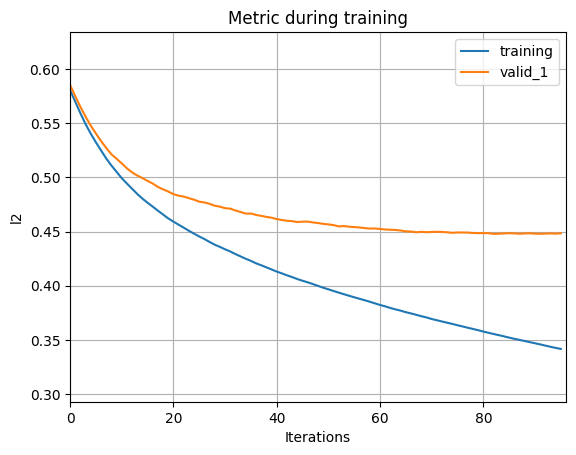

----> || Train Optimized QWK SCORE ::  0.638
----> || Val Optimized QWK SCORE ::  0.340
----> || Train Optimized Val QWK SCORE ::  0.462
----> || Val Optimized Train QWK SCORE ::  0.497
Fold 1 - Rounded Train QWK: 0.4987, Rounded Validation QWK: 0.3366


<Figure size 640x480 with 0 Axes>

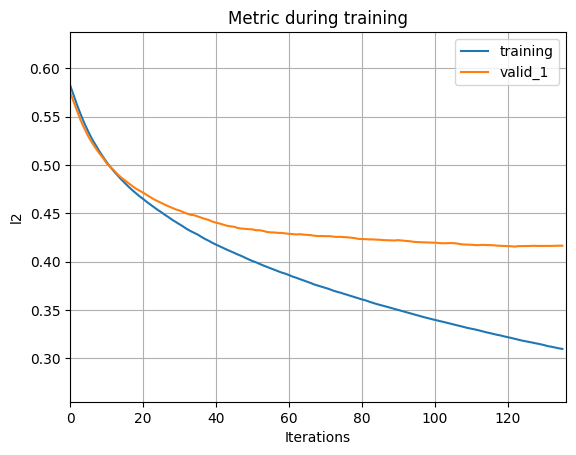

----> || Train Optimized QWK SCORE ::  0.693
----> || Val Optimized QWK SCORE ::  0.534
----> || Train Optimized Val QWK SCORE ::  0.497
----> || Val Optimized Train QWK SCORE ::  0.668
Fold 2 - Rounded Train QWK: 0.5483, Rounded Validation QWK: 0.4301


<Figure size 640x480 with 0 Axes>

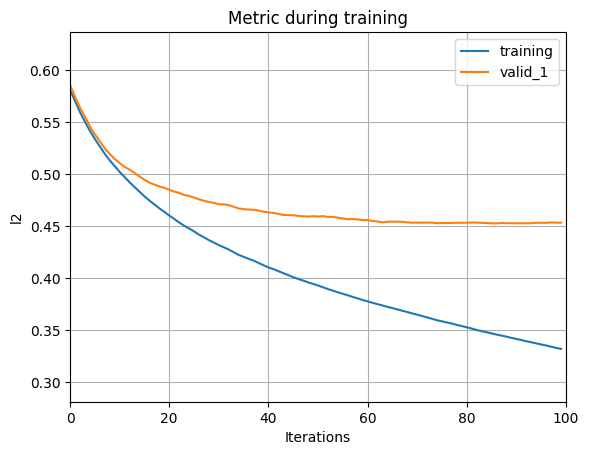

----> || Train Optimized QWK SCORE ::  0.643
----> || Val Optimized QWK SCORE ::  0.383
----> || Train Optimized Val QWK SCORE ::  0.480
----> || Val Optimized Train QWK SCORE ::  0.511
Fold 3 - Rounded Train QWK: 0.5293, Rounded Validation QWK: 0.3294


<Figure size 640x480 with 0 Axes>

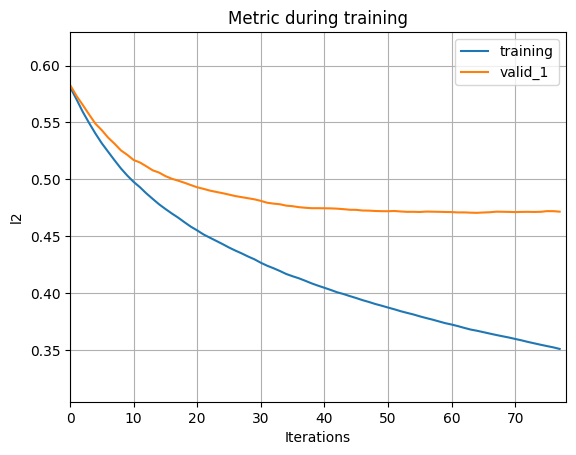

----> || Train Optimized QWK SCORE ::  0.616
----> || Val Optimized QWK SCORE ::  0.366
----> || Train Optimized Val QWK SCORE ::  0.441
----> || Val Optimized Train QWK SCORE ::  0.479
Fold 4 - Rounded Train QWK: 0.4793, Rounded Validation QWK: 0.3251


<Figure size 640x480 with 0 Axes>

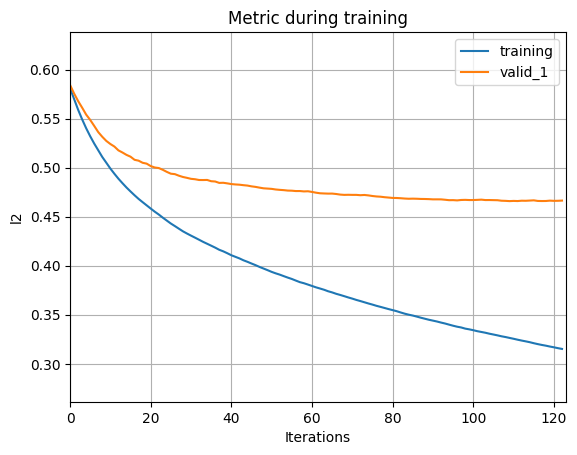

----> || Train Optimized QWK SCORE ::  0.667
----> || Val Optimized QWK SCORE ::  0.351
----> || Train Optimized Val QWK SCORE ::  0.417
----> || Val Optimized Train QWK SCORE ::  0.533
Fold 5 - Rounded Train QWK: 0.5545, Rounded Validation QWK: 0.3377
Mean Train QWK --> 0.6513
Mean Validation QWK ---> 0.3949
----> || Optimized QWK SCORE ::  0.472


In [87]:
lgb_models_list, lgb_submission_df, lgb_raw_train_preds, lgb_raw_test_preds, lgb_optuna_study = lgb_feature_selection(train_final_df, test_final_df, 150)

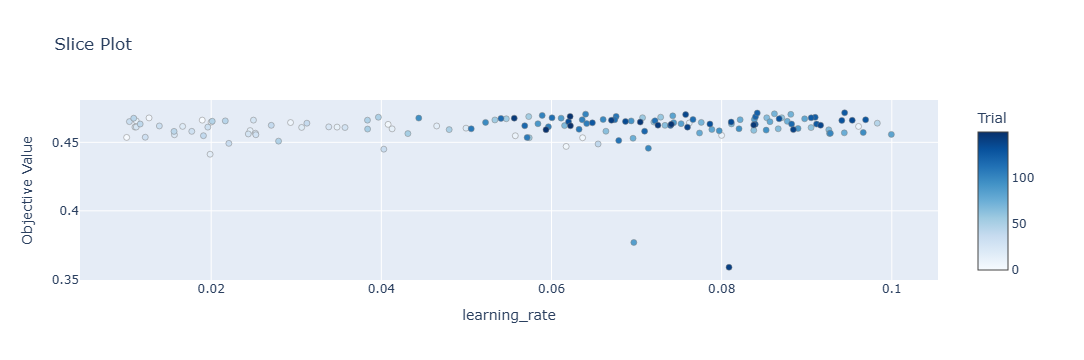

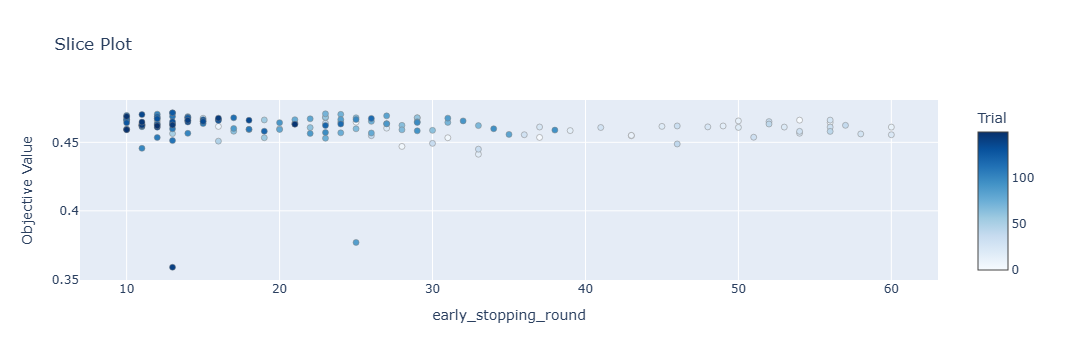

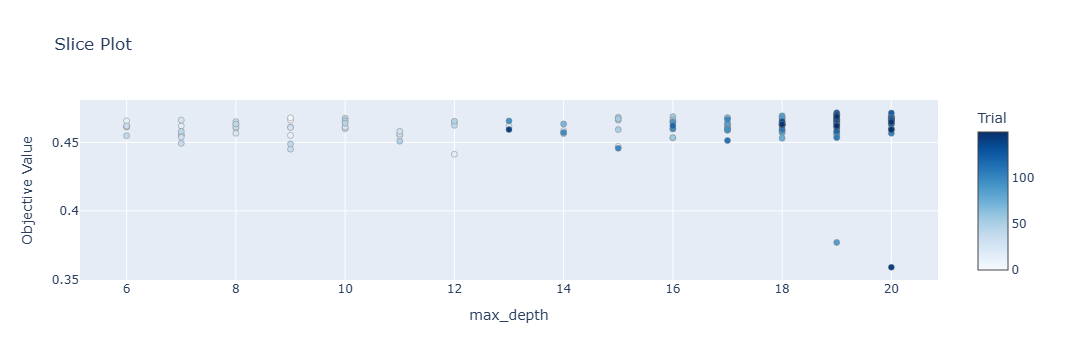

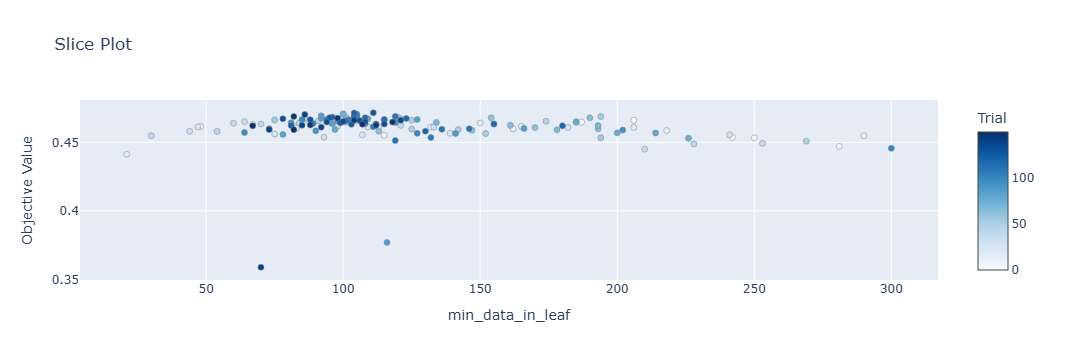

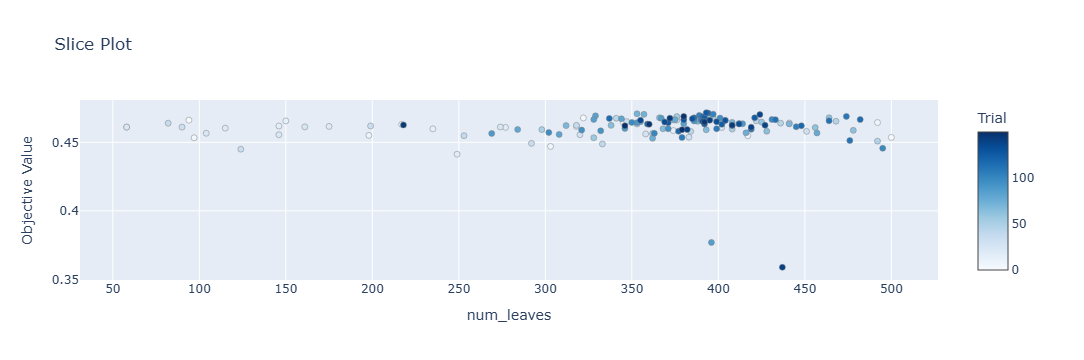

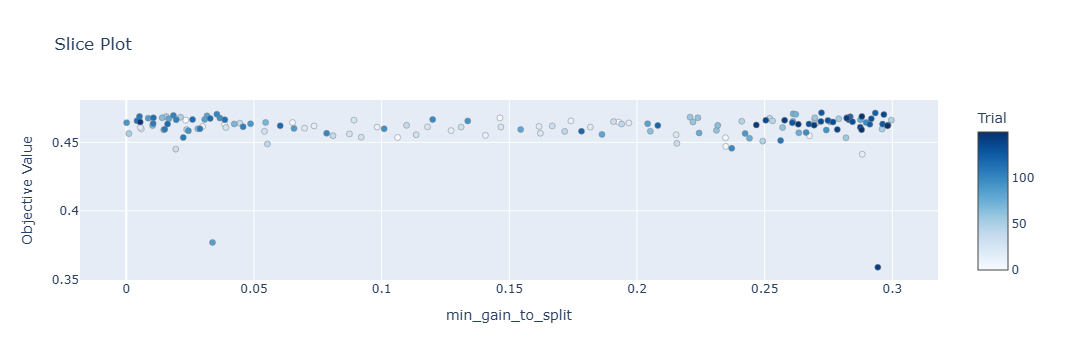

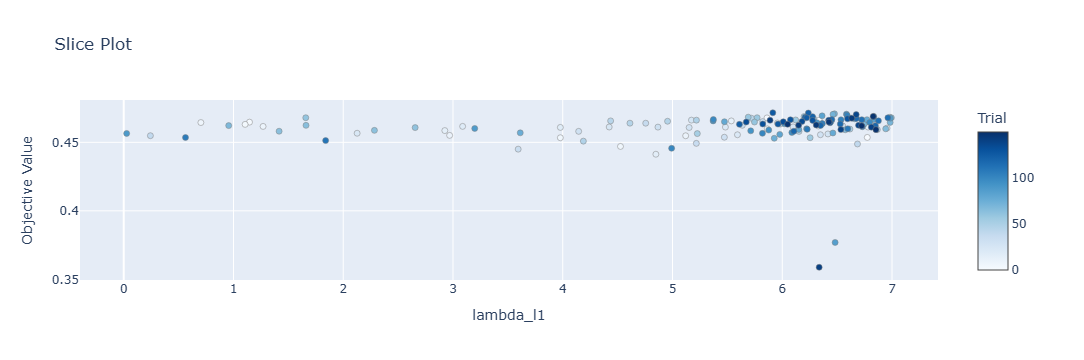

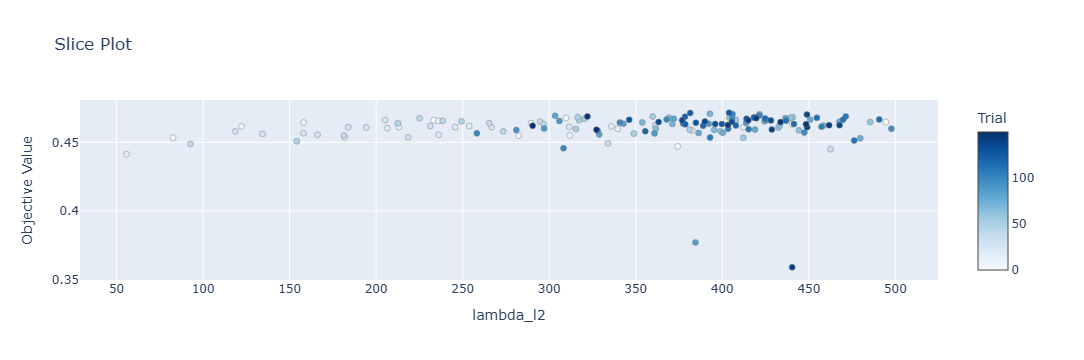

In [88]:
for param in lgb_optuna_study.best_params.keys():
    fig = plot_slice(lgb_optuna_study, params=[param])
    fig.show()

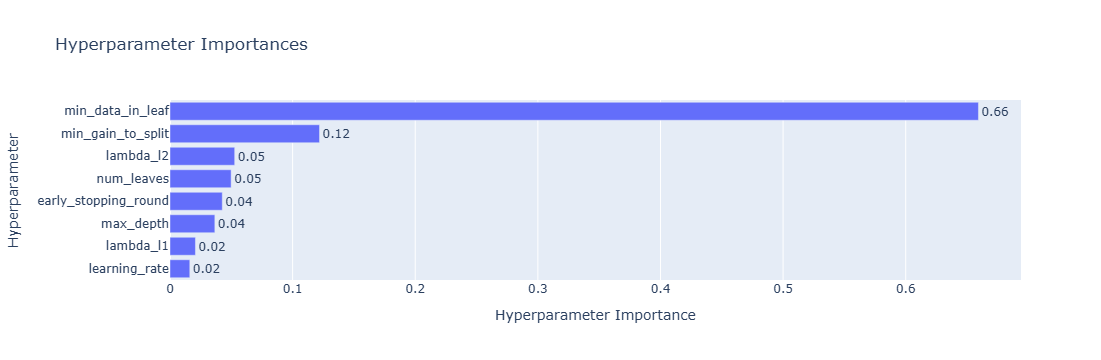

In [89]:
plot_param_importances(lgb_optuna_study)

In [90]:
lgb_optuna_study.best_params

{'learning_rate': 0.09445776873993646,
 'early_stopping_round': 13,
 'max_depth': 19,
 'min_data_in_leaf': 111,
 'num_leaves': 393,
 'min_gain_to_split': 0.2722527848586357,
 'lambda_l1': 5.914068426661135,
 'lambda_l2': 403.93324408527053}

In [91]:
cols = train_final_df.drop(['id', 'sii'], axis=1).columns
importance_list = []
for model in lgb_models_list:
    importance_list.append(model.feature_importances_)

importance_mean = np.mean(importance_list, axis=0)
imp_df = pd.DataFrame(sorted(zip(cols, importance_mean)), columns=['Feature', 'Importance']).sort_values('Importance', ascending=False)
unimportant_df = imp_df[imp_df['Importance'] < imp_df['Importance'].quantile(0.5)]
unimportant_cols = unimportant_df['Feature'].tolist()

In [92]:
train_selected_df = train_final_df.drop(unimportant_cols, axis=1)
print(train_selected_df.shape)
train_selected_df.head()

(2736, 876)


id  Basic_Demos-Age  CGAS-CGAS_Score  Physical-BMI  Physical-Height  \
0  00008ff9              5.0             51.0     16.877316             46.0   
1  000fd460              9.0             63.2     14.035590             48.0   
2  00105258             10.0             71.0     16.648696             56.5   
3  00115b9f              9.0             71.0     18.292347             56.0   
4  001f3379             13.0             50.0     22.279952             59.5   

   Physical-Weight  Physical-Waist_Circumference  Physical-Diastolic_BP  \
0             50.8                          25.0                   78.8   
1             46.0                          22.0                   75.0   
2             75.6                          27.0                   65.0   
3             81.6                          26.4                   60.0   
4            112.2                          32.0                   60.0   

   Physical-HeartRate  Physical-Systolic_BP  Fitness_Endurance-Max_Stage  \
0                80.0                 130.2                          4.4   
1                70.0                 122.0                          5.8   
2                94.0                 117.0                          5.0   
3                97.0                 117.0                          6.0   
4                73.0                 102.0                          4.6   

   Fitness_Endurance-Time_Mins  Fitness_Endurance-Time_Sec  FGC-FGC_CU  \
0                          6.2                        22.6         0.0   
1                          9.0                        14.4         3.0   
2                          7.0                        33.0        20.0   
3                          9.0                        37.0        18.0   
4                          5.8                        39.4        12.0   

   FGC-FGC_GSND  FGC-FGC_GSND_Zone  FGC-FGC_GSD  FGC-FGC_PU  FGC-FGC_PU_Zone  \
0         20.50                1.8        21.18         0.0              0.0   
1         23.08                2.0        24.94         5.0              0.0   
2         10.20                1.0        14.70         7.0              1.0   
3         17.66                2.0        19.24         5.0              0.0   
4         16.50                2.0        17.90         6.0              0.0   

   FGC-FGC_SRL  FGC-FGC_TL  BIA-BIA_Activity_Level_num  BIA-BIA_BMC  \
0          7.0         6.0                         2.0     2.668550   
1         11.0         3.0                         2.0     2.579490   
2         10.0         5.0                         2.4     4.310264   
3          7.0         7.0                         3.0     3.841910   
4         10.0         8.0                         2.0     4.330360   

   BIA-BIA_BMI  BIA-BIA_FFMI  BIA-BIA_FMI  BIA-BIA_Fat  BIA-BIA_Frame_num  \
0     16.87920      13.81770      3.06143     9.213770                1.0   
1     14.03710      12.82540      1.21172     3.970850                1.0   
2     18.29524      24.52766     -6.23241   -24.811978                1.4   
3     18.29430      14.07400      4.22033    18.824300                2.0   
4     30.18650      16.68770     13.49880    67.971500                2.0   

   PAQ_A-PAQ_A_Total  PAQ_C-PAQ_C_Total  SDS-SDS_Total_Raw  \
0              1.844             2.6342               41.6   
1              1.704             2.3400               46.0   
2              2.578             2.1700               38.0   
3              2.018             2.4510               31.0   
4              2.004             4.1100               40.0   

   PreInt_EduHx-computerinternet_hoursday  total_num_nan  CGAS-Season_isnan  \
0                                     3.0           19.0                0.0   
1                                     0.0           12.0                1.0   
2                                     2.0           20.0                0.0   
3                                     0.0            7.0                0.0   
4                                   

In [93]:
test_selected_df = test_final_df.drop(unimportant_cols, axis=1)
print(test_selected_df.shape)
test_selected_df.head()

(20, 875)


id  Basic_Demos-Age  CGAS-CGAS_Score  Physical-BMI  Physical-Height  \
0  00008ff9              5.0             51.0     16.877316           46.000   
1  000fd460              9.0             63.2     14.035590           48.000   
2  00105258             10.0             71.0     16.648696           56.500   
3  00115b9f              9.0             71.0     18.292347           56.000   
4  0016bb22             18.0             65.8     22.367377           66.878   

   Physical-Weight  Physical-Waist_Circumference  Physical-Diastolic_BP  \
0             50.8                          25.0                   78.8   
1             46.0                          22.0                   75.0   
2             75.6                          27.0                   65.0   
3             81.6                          26.4                   60.0   
4             20.0                          31.7                   66.4   

   Physical-HeartRate  Physical-Systolic_BP  Fitness_Endurance-Max_Stage  \
0                80.0                 130.2                          4.4   
1                70.0                 122.0                          5.8   
2                94.0                 117.0                          5.0   
3                97.0                 117.0                          6.0   
4                75.4                 113.6                          4.6   

   Fitness_Endurance-Time_Mins  Fitness_Endurance-Time_Sec  FGC-FGC_CU  \
0                          6.2                        22.6         0.0   
1                          9.0                        14.4         3.0   
2                          7.0                        33.0        20.0   
3                          9.0                        37.0        18.0   
4                          7.2                        17.8         5.8   

   FGC-FGC_GSND  FGC-FGC_GSND_Zone  FGC-FGC_GSD  FGC-FGC_PU  FGC-FGC_PU_Zone  \
0         20.50                1.8        21.18         0.0              0.0   
1         23.08                2.0        24.94         5.0              0.0   
2         10.20                1.0        14.70         7.0              1.0   
3         17.66                2.0        19.24         5.0              0.0   
4         28.28                2.2        27.96         4.2              0.4   

   FGC-FGC_SRL  FGC-FGC_TL  BIA-BIA_Activity_Level_num  BIA-BIA_BMC  \
0          7.0         6.0                         2.0     2.668550   
1         11.0         3.0                         2.0     2.579490   
2         10.0         5.0                         2.4     4.310264   
3          7.0         7.0                         3.0     3.841910   
4         12.5         8.6                         3.0     5.477302   

   BIA-BIA_BMI  BIA-BIA_FFMI  BIA-BIA_FMI  BIA-BIA_Fat  BIA-BIA_Frame_num  \
0     16.87920      13.81770     3.061430     9.213770                1.0   
1     14.03710      12.82540     1.211720     3.970850                1.0   
2     18.29524      24.52766    -6.232410   -24.811978                1.4   
3     18.29430      14.07400     4.220330    18.824300                2.0   
4     20.24658      15.81610     4.430456    26.554596                2.4   

   PAQ_A-PAQ_A_Total  PAQ_C-PAQ_C_Total  SDS-SDS_Total_Raw  \
0              1.844             2.6342               41.6   
1              1.704             2.3400               46.0   
2              2.578             2.1700               38.0   
3              2.018             2.4510               31.0   
4              1.040             2.2922               65.2   

   PreInt_EduHx-computerinternet_hoursday  total_num_nan  CGAS-Season_isnan  \
0                                     3.0           19.0                0.0   
1                                     0.0           12.0                1.0   
2                                     2.0           20.0                0.0   
3                                     0.0            7.0                0.0   
4                                   

[I 2024-12-14 20:42:18,787] A new study created in memory with name: no-name-f9db6c13-b157-4c90-978c-2d497434633b
[I 2024-12-14 20:42:27,781] Trial 0 finished with value: 0.4600686960652146 and parameters: {'learning_rate': 0.017348858952776595, 'early_stopping_round': 35, 'max_depth': 9, 'min_data_in_leaf': 230, 'num_leaves': 125, 'min_gain_to_split': 0.015392903402849278, 'lambda_l1': 0.1611620219174139, 'lambda_l2': 376.7862550815101}. Best is trial 0 with value: 0.4600686960652146.


----> || Optimized QWK SCORE ::  0.460


[I 2024-12-14 20:42:46,888] Trial 1 finished with value: 0.45595439712503605 and parameters: {'learning_rate': 0.01366225692494425, 'early_stopping_round': 14, 'max_depth': 19, 'min_data_in_leaf': 28, 'num_leaves': 317, 'min_gain_to_split': 0.2887050764865385, 'lambda_l1': 1.147167457040903, 'lambda_l2': 267.5144717536026}. Best is trial 0 with value: 0.4600686960652146.


----> || Optimized QWK SCORE ::  0.456


[I 2024-12-14 20:42:51,602] Trial 2 finished with value: 0.4590317478133822 and parameters: {'learning_rate': 0.09484279554128744, 'early_stopping_round': 35, 'max_depth': 12, 'min_data_in_leaf': 162, 'num_leaves': 474, 'min_gain_to_split': 0.027092293181660444, 'lambda_l1': 3.944732181555864, 'lambda_l2': 470.82293047020954}. Best is trial 0 with value: 0.4600686960652146.


----> || Optimized QWK SCORE ::  0.459


[I 2024-12-14 20:43:03,717] Trial 3 finished with value: 0.46625979818498975 and parameters: {'learning_rate': 0.012730528648452113, 'early_stopping_round': 15, 'max_depth': 17, 'min_data_in_leaf': 110, 'num_leaves': 76, 'min_gain_to_split': 0.24974005032393087, 'lambda_l1': 0.6940237811177296, 'lambda_l2': 313.5510055078274}. Best is trial 3 with value: 0.46625979818498975.


----> || Optimized QWK SCORE ::  0.466


[I 2024-12-14 20:43:13,993] Trial 4 finished with value: 0.4624489169292403 and parameters: {'learning_rate': 0.012033873570136059, 'early_stopping_round': 37, 'max_depth': 16, 'min_data_in_leaf': 200, 'num_leaves': 163, 'min_gain_to_split': 0.18745601569101972, 'lambda_l1': 3.4319960587248586, 'lambda_l2': 154.78522808466096}. Best is trial 3 with value: 0.46625979818498975.


----> || Optimized QWK SCORE ::  0.462


[I 2024-12-14 20:43:22,054] Trial 5 finished with value: 0.4593050517680919 and parameters: {'learning_rate': 0.022701066039380262, 'early_stopping_round': 59, 'max_depth': 13, 'min_data_in_leaf': 136, 'num_leaves': 402, 'min_gain_to_split': 0.2939056727962818, 'lambda_l1': 2.368824050372118, 'lambda_l2': 122.88328316475724}. Best is trial 3 with value: 0.46625979818498975.


----> || Optimized QWK SCORE ::  0.459


[I 2024-12-14 20:43:26,775] Trial 6 finished with value: 0.45604442143899115 and parameters: {'learning_rate': 0.07046754989043172, 'early_stopping_round': 31, 'max_depth': 10, 'min_data_in_leaf': 181, 'num_leaves': 363, 'min_gain_to_split': 0.25211039144644715, 'lambda_l1': 1.0073636450489571, 'lambda_l2': 429.1904961000469}. Best is trial 3 with value: 0.46625979818498975.


----> || Optimized QWK SCORE ::  0.456


[I 2024-12-14 20:43:36,115] Trial 7 finished with value: 0.44341963073455926 and parameters: {'learning_rate': 0.019149183951869424, 'early_stopping_round': 36, 'max_depth': 17, 'min_data_in_leaf': 211, 'num_leaves': 467, 'min_gain_to_split': 0.014661977376424317, 'lambda_l1': 5.782709479790534, 'lambda_l2': 452.252873364098}. Best is trial 3 with value: 0.46625979818498975.


----> || Optimized QWK SCORE ::  0.443


[I 2024-12-14 20:43:40,688] Trial 8 finished with value: 0.47255992518580503 and parameters: {'learning_rate': 0.043077165725940086, 'early_stopping_round': 48, 'max_depth': 11, 'min_data_in_leaf': 194, 'num_leaves': 230, 'min_gain_to_split': 0.004353906663398799, 'lambda_l1': 5.8813754720985925, 'lambda_l2': 122.94540482577855}. Best is trial 8 with value: 0.47255992518580503.


----> || Optimized QWK SCORE ::  0.473


[I 2024-12-14 20:43:45,407] Trial 9 finished with value: 0.46371664677669955 and parameters: {'learning_rate': 0.06666787858949652, 'early_stopping_round': 43, 'max_depth': 13, 'min_data_in_leaf': 206, 'num_leaves': 166, 'min_gain_to_split': 0.06889414939327775, 'lambda_l1': 5.787056743955279, 'lambda_l2': 442.49006609838915}. Best is trial 8 with value: 0.47255992518580503.


----> || Optimized QWK SCORE ::  0.464


[I 2024-12-14 20:43:49,810] Trial 10 finished with value: 0.44488101555080406 and parameters: {'learning_rate': 0.039400546826325766, 'early_stopping_round': 55, 'max_depth': 6, 'min_data_in_leaf': 291, 'num_leaves': 249, 'min_gain_to_split': 0.10975523163308637, 'lambda_l1': 6.559380700748447, 'lambda_l2': 63.711352278938534}. Best is trial 8 with value: 0.47255992518580503.


----> || Optimized QWK SCORE ::  0.445


[I 2024-12-14 20:43:55,244] Trial 11 finished with value: 0.46753128967894064 and parameters: {'learning_rate': 0.041295471476390636, 'early_stopping_round': 10, 'max_depth': 16, 'min_data_in_leaf': 96, 'num_leaves': 53, 'min_gain_to_split': 0.18584887993001942, 'lambda_l1': 4.150207248456224, 'lambda_l2': 270.6117004374211}. Best is trial 8 with value: 0.47255992518580503.


----> || Optimized QWK SCORE ::  0.468


[I 2024-12-14 20:44:02,352] Trial 12 finished with value: 0.46275204679611026 and parameters: {'learning_rate': 0.04241932932893546, 'early_stopping_round': 49, 'max_depth': 10, 'min_data_in_leaf': 83, 'num_leaves': 240, 'min_gain_to_split': 0.16008998088668713, 'lambda_l1': 4.640850192729866, 'lambda_l2': 221.1443573163558}. Best is trial 8 with value: 0.47255992518580503.


----> || Optimized QWK SCORE ::  0.463


[I 2024-12-14 20:44:08,849] Trial 13 finished with value: 0.4554460907281307 and parameters: {'learning_rate': 0.044899111403074655, 'early_stopping_round': 24, 'max_depth': 20, 'min_data_in_leaf': 64, 'num_leaves': 61, 'min_gain_to_split': 0.1934557132688789, 'lambda_l1': 4.750877815596409, 'lambda_l2': 184.2841552868241}. Best is trial 8 with value: 0.47255992518580503.


----> || Optimized QWK SCORE ::  0.455


[I 2024-12-14 20:44:12,147] Trial 14 finished with value: 0.44909813512687247 and parameters: {'learning_rate': 0.05844023565057316, 'early_stopping_round': 24, 'max_depth': 15, 'min_data_in_leaf': 261, 'num_leaves': 186, 'min_gain_to_split': 0.1160116269109561, 'lambda_l1': 6.744347638700704, 'lambda_l2': 63.82172808088845}. Best is trial 8 with value: 0.47255992518580503.


----> || Optimized QWK SCORE ::  0.449


[I 2024-12-14 20:44:20,316] Trial 15 finished with value: 0.4643999273548479 and parameters: {'learning_rate': 0.03207232948359092, 'early_stopping_round': 47, 'max_depth': 8, 'min_data_in_leaf': 124, 'num_leaves': 309, 'min_gain_to_split': 0.06969187403905588, 'lambda_l1': 2.736178775591876, 'lambda_l2': 292.1482362463965}. Best is trial 8 with value: 0.47255992518580503.


----> || Optimized QWK SCORE ::  0.464


[I 2024-12-14 20:44:25,305] Trial 16 finished with value: 0.4624212872506833 and parameters: {'learning_rate': 0.05294391850843219, 'early_stopping_round': 10, 'max_depth': 15, 'min_data_in_leaf': 81, 'num_leaves': 111, 'min_gain_to_split': 0.21189856769292661, 'lambda_l1': 5.24645506176214, 'lambda_l2': 373.69388276053303}. Best is trial 8 with value: 0.47255992518580503.


----> || Optimized QWK SCORE ::  0.462


[I 2024-12-14 20:44:28,896] Trial 17 finished with value: 0.4591087043821769 and parameters: {'learning_rate': 0.0817110953484671, 'early_stopping_round': 23, 'max_depth': 11, 'min_data_in_leaf': 153, 'num_leaves': 214, 'min_gain_to_split': 0.13462291474134147, 'lambda_l1': 3.789790248094624, 'lambda_l2': 230.74622587431065}. Best is trial 8 with value: 0.47255992518580503.


----> || Optimized QWK SCORE ::  0.459


[I 2024-12-14 20:44:43,478] Trial 18 finished with value: 0.45021757002835194 and parameters: {'learning_rate': 0.03069120526605347, 'early_stopping_round': 52, 'max_depth': 7, 'min_data_in_leaf': 25, 'num_leaves': 294, 'min_gain_to_split': 0.07040352139920995, 'lambda_l1': 2.2639012603649453, 'lambda_l2': 121.59312981025786}. Best is trial 8 with value: 0.47255992518580503.


----> || Optimized QWK SCORE ::  0.450


[I 2024-12-14 20:44:50,014] Trial 19 finished with value: 0.46749043836422477 and parameters: {'learning_rate': 0.05065984328405178, 'early_stopping_round': 42, 'max_depth': 15, 'min_data_in_leaf': 105, 'num_leaves': 388, 'min_gain_to_split': 0.16550441135423968, 'lambda_l1': 6.091965964879835, 'lambda_l2': 341.35438155923805}. Best is trial 8 with value: 0.47255992518580503.


----> || Optimized QWK SCORE ::  0.467


[I 2024-12-14 20:44:55,150] Trial 20 finished with value: 0.45389494996576996 and parameters: {'learning_rate': 0.033075732056395135, 'early_stopping_round': 43, 'max_depth': 19, 'min_data_in_leaf': 245, 'num_leaves': 114, 'min_gain_to_split': 0.23985984943091704, 'lambda_l1': 4.692455727006523, 'lambda_l2': 237.83919974185434}. Best is trial 8 with value: 0.47255992518580503.


----> || Optimized QWK SCORE ::  0.454


[I 2024-12-14 20:45:01,377] Trial 21 finished with value: 0.4626319031928062 and parameters: {'learning_rate': 0.050434027808953175, 'early_stopping_round': 44, 'max_depth': 14, 'min_data_in_leaf': 106, 'num_leaves': 410, 'min_gain_to_split': 0.16144263031826214, 'lambda_l1': 5.967266774119983, 'lambda_l2': 331.3663882115055}. Best is trial 8 with value: 0.47255992518580503.


----> || Optimized QWK SCORE ::  0.463


[I 2024-12-14 20:45:08,174] Trial 22 finished with value: 0.4628722009230217 and parameters: {'learning_rate': 0.05890910020307068, 'early_stopping_round': 30, 'max_depth': 12, 'min_data_in_leaf': 58, 'num_leaves': 367, 'min_gain_to_split': 0.18577815828917377, 'lambda_l1': 6.927647293524174, 'lambda_l2': 369.588825774916}. Best is trial 8 with value: 0.47255992518580503.


----> || Optimized QWK SCORE ::  0.463


[I 2024-12-14 20:45:12,972] Trial 23 finished with value: 0.45551941767837956 and parameters: {'learning_rate': 0.06472871032926884, 'early_stopping_round': 39, 'max_depth': 17, 'min_data_in_leaf': 162, 'num_leaves': 422, 'min_gain_to_split': 0.10581532610843328, 'lambda_l1': 5.341684038483586, 'lambda_l2': 187.85728022505788}. Best is trial 8 with value: 0.47255992518580503.


----> || Optimized QWK SCORE ::  0.456


[I 2024-12-14 20:45:19,546] Trial 24 finished with value: 0.46482885839048516 and parameters: {'learning_rate': 0.03870844462884236, 'early_stopping_round': 56, 'max_depth': 15, 'min_data_in_leaf': 137, 'num_leaves': 336, 'min_gain_to_split': 0.22243341296299904, 'lambda_l1': 6.045725744674972, 'lambda_l2': 346.2488771385398}. Best is trial 8 with value: 0.47255992518580503.


----> || Optimized QWK SCORE ::  0.465


[I 2024-12-14 20:45:27,148] Trial 25 finished with value: 0.4672233097296119 and parameters: {'learning_rate': 0.047345034567174885, 'early_stopping_round': 49, 'max_depth': 14, 'min_data_in_leaf': 95, 'num_leaves': 268, 'min_gain_to_split': 0.1658773262530159, 'lambda_l1': 4.24327166318925, 'lambda_l2': 411.3398686836681}. Best is trial 8 with value: 0.47255992518580503.


----> || Optimized QWK SCORE ::  0.467


[I 2024-12-14 20:45:34,131] Trial 26 finished with value: 0.4547113967468076 and parameters: {'learning_rate': 0.02637971027134917, 'early_stopping_round': 41, 'max_depth': 18, 'min_data_in_leaf': 178, 'num_leaves': 210, 'min_gain_to_split': 0.13956421660458435, 'lambda_l1': 2.994209920920466, 'lambda_l2': 269.8107261779864}. Best is trial 8 with value: 0.47255992518580503.


----> || Optimized QWK SCORE ::  0.455


[I 2024-12-14 20:45:40,956] Trial 27 finished with value: 0.4554115449555054 and parameters: {'learning_rate': 0.05421115523691067, 'early_stopping_round': 19, 'max_depth': 12, 'min_data_in_leaf': 56, 'num_leaves': 448, 'min_gain_to_split': 0.039413000605976786, 'lambda_l1': 6.314018803961753, 'lambda_l2': 106.95294496327818}. Best is trial 8 with value: 0.47255992518580503.


----> || Optimized QWK SCORE ::  0.455


[I 2024-12-14 20:45:46,792] Trial 28 finished with value: 0.468617728425771 and parameters: {'learning_rate': 0.07417412591964734, 'early_stopping_round': 30, 'max_depth': 16, 'min_data_in_leaf': 114, 'num_leaves': 500, 'min_gain_to_split': 0.0943985655343112, 'lambda_l1': 5.201966317580284, 'lambda_l2': 488.09212503203173}. Best is trial 8 with value: 0.47255992518580503.


----> || Optimized QWK SCORE ::  0.469


[I 2024-12-14 20:45:51,112] Trial 29 finished with value: 0.457526274845492 and parameters: {'learning_rate': 0.08168752211202139, 'early_stopping_round': 31, 'max_depth': 16, 'min_data_in_leaf': 223, 'num_leaves': 491, 'min_gain_to_split': 0.05105250454379425, 'lambda_l1': 5.327960495773853, 'lambda_l2': 397.4547384545946}. Best is trial 8 with value: 0.47255992518580503.


----> || Optimized QWK SCORE ::  0.458


[I 2024-12-14 20:45:55,204] Trial 30 finished with value: 0.4431270132069922 and parameters: {'learning_rate': 0.08002281309605971, 'early_stopping_round': 20, 'max_depth': 10, 'min_data_in_leaf': 184, 'num_leaves': 148, 'min_gain_to_split': 1.4234428078558833e-05, 'lambda_l1': 5.092704424839004, 'lambda_l2': 492.4384046066887}. Best is trial 8 with value: 0.47255992518580503.


----> || Optimized QWK SCORE ::  0.443


[I 2024-12-14 20:45:59,488] Trial 31 finished with value: 0.45919355928893835 and parameters: {'learning_rate': 0.09697829569896926, 'early_stopping_round': 27, 'max_depth': 14, 'min_data_in_leaf': 116, 'num_leaves': 376, 'min_gain_to_split': 0.09363804419468186, 'lambda_l1': 4.22392777442638, 'lambda_l2': 311.77807141412603}. Best is trial 8 with value: 0.47255992518580503.


----> || Optimized QWK SCORE ::  0.459


[I 2024-12-14 20:46:05,970] Trial 32 finished with value: 0.4631434364575838 and parameters: {'learning_rate': 0.038116946978227005, 'early_stopping_round': 46, 'max_depth': 16, 'min_data_in_leaf': 136, 'num_leaves': 429, 'min_gain_to_split': 0.1338131940198132, 'lambda_l1': 5.6156749534649615, 'lambda_l2': 186.67272176082062}. Best is trial 8 with value: 0.47255992518580503.


----> || Optimized QWK SCORE ::  0.463


[I 2024-12-14 20:46:11,326] Trial 33 finished with value: 0.4566829994258216 and parameters: {'learning_rate': 0.07211754298293598, 'early_stopping_round': 10, 'max_depth': 18, 'min_data_in_leaf': 89, 'num_leaves': 338, 'min_gain_to_split': 0.09054483685639193, 'lambda_l1': 6.4668712776808475, 'lambda_l2': 481.3768490595601}. Best is trial 8 with value: 0.47255992518580503.


----> || Optimized QWK SCORE ::  0.457


[I 2024-12-14 20:46:17,411] Trial 34 finished with value: 0.4634394740003478 and parameters: {'learning_rate': 0.062153929183458544, 'early_stopping_round': 14, 'max_depth': 13, 'min_data_in_leaf': 70, 'num_leaves': 494, 'min_gain_to_split': 0.17498669171963757, 'lambda_l1': 4.948397780849574, 'lambda_l2': 291.75399597332415}. Best is trial 8 with value: 0.47255992518580503.


----> || Optimized QWK SCORE ::  0.463


[I 2024-12-14 20:46:23,205] Trial 35 finished with value: 0.45223289994347093 and parameters: {'learning_rate': 0.04677119347830694, 'early_stopping_round': 34, 'max_depth': 18, 'min_data_in_leaf': 102, 'num_leaves': 85, 'min_gain_to_split': 0.2036613359909049, 'lambda_l1': 4.37206136314322, 'lambda_l2': 409.27393475855024}. Best is trial 8 with value: 0.47255992518580503.


----> || Optimized QWK SCORE ::  0.452


[I 2024-12-14 20:46:28,856] Trial 36 finished with value: 0.46315215028240075 and parameters: {'learning_rate': 0.08725468096967796, 'early_stopping_round': 40, 'max_depth': 16, 'min_data_in_leaf': 48, 'num_leaves': 459, 'min_gain_to_split': 0.2249548369352547, 'lambda_l1': 3.662085479550681, 'lambda_l2': 155.95062776558785}. Best is trial 8 with value: 0.47255992518580503.


----> || Optimized QWK SCORE ::  0.463


[I 2024-12-14 20:46:32,800] Trial 37 finished with value: 0.46945497003877323 and parameters: {'learning_rate': 0.0739290566614578, 'early_stopping_round': 17, 'max_depth': 11, 'min_data_in_leaf': 152, 'num_leaves': 397, 'min_gain_to_split': 0.26683142817153216, 'lambda_l1': 1.6697056370862988, 'lambda_l2': 251.61080421614886}. Best is trial 8 with value: 0.47255992518580503.


----> || Optimized QWK SCORE ::  0.469


[I 2024-12-14 20:46:36,600] Trial 38 finished with value: 0.453852575037201 and parameters: {'learning_rate': 0.09015541604775994, 'early_stopping_round': 17, 'max_depth': 11, 'min_data_in_leaf': 161, 'num_leaves': 447, 'min_gain_to_split': 0.2878278383929602, 'lambda_l1': 1.7064467360892763, 'lambda_l2': 93.35532672619291}. Best is trial 8 with value: 0.47255992518580503.


----> || Optimized QWK SCORE ::  0.454


[I 2024-12-14 20:46:40,582] Trial 39 finished with value: 0.4689512367985076 and parameters: {'learning_rate': 0.07268313741078435, 'early_stopping_round': 12, 'max_depth': 9, 'min_data_in_leaf': 145, 'num_leaves': 345, 'min_gain_to_split': 0.2737082598066702, 'lambda_l1': 0.03155418187909831, 'lambda_l2': 252.9802671817517}. Best is trial 8 with value: 0.47255992518580503.


----> || Optimized QWK SCORE ::  0.469


[I 2024-12-14 20:46:44,288] Trial 40 finished with value: 0.46261442296352073 and parameters: {'learning_rate': 0.07515229881976665, 'early_stopping_round': 16, 'max_depth': 9, 'min_data_in_leaf': 193, 'num_leaves': 347, 'min_gain_to_split': 0.2701105767394179, 'lambda_l1': 0.1529286190231639, 'lambda_l2': 237.7986175733676}. Best is trial 8 with value: 0.47255992518580503.


----> || Optimized QWK SCORE ::  0.463


[I 2024-12-14 20:46:48,192] Trial 41 finished with value: 0.46273732530251155 and parameters: {'learning_rate': 0.0764780568303361, 'early_stopping_round': 12, 'max_depth': 9, 'min_data_in_leaf': 142, 'num_leaves': 286, 'min_gain_to_split': 0.26925409117217075, 'lambda_l1': 0.5428007015805141, 'lambda_l2': 258.1462803213645}. Best is trial 8 with value: 0.47255992518580503.


----> || Optimized QWK SCORE ::  0.463


[I 2024-12-14 20:46:52,251] Trial 42 finished with value: 0.4543439392598563 and parameters: {'learning_rate': 0.06940381065427893, 'early_stopping_round': 12, 'max_depth': 11, 'min_data_in_leaf': 127, 'num_leaves': 322, 'min_gain_to_split': 0.2761281552656208, 'lambda_l1': 1.3018744293691036, 'lambda_l2': 208.5523774775529}. Best is trial 8 with value: 0.47255992518580503.


----> || Optimized QWK SCORE ::  0.454


[I 2024-12-14 20:46:56,008] Trial 43 finished with value: 0.46712291282896135 and parameters: {'learning_rate': 0.09034853254743871, 'early_stopping_round': 18, 'max_depth': 8, 'min_data_in_leaf': 174, 'num_leaves': 390, 'min_gain_to_split': 0.24852276993346922, 'lambda_l1': 0.6349646379191686, 'lambda_l2': 159.75923979126597}. Best is trial 8 with value: 0.47255992518580503.


----> || Optimized QWK SCORE ::  0.467


[I 2024-12-14 20:47:00,088] Trial 44 finished with value: 0.46654361869605343 and parameters: {'learning_rate': 0.0578618773049853, 'early_stopping_round': 13, 'max_depth': 10, 'min_data_in_leaf': 150, 'num_leaves': 269, 'min_gain_to_split': 0.2989644147426843, 'lambda_l1': 3.271802829030522, 'lambda_l2': 261.2208061155336}. Best is trial 8 with value: 0.47255992518580503.


----> || Optimized QWK SCORE ::  0.467


[I 2024-12-14 20:47:04,284] Trial 45 finished with value: 0.4570619296827799 and parameters: {'learning_rate': 0.0674940999205868, 'early_stopping_round': 21, 'max_depth': 8, 'min_data_in_leaf': 121, 'num_leaves': 53, 'min_gain_to_split': 0.25701584570015823, 'lambda_l1': 1.856660855662635, 'lambda_l2': 288.58007189457203}. Best is trial 8 with value: 0.47255992518580503.


----> || Optimized QWK SCORE ::  0.457


[I 2024-12-14 20:47:07,887] Trial 46 finished with value: 0.45669783379656403 and parameters: {'learning_rate': 0.08581956637517436, 'early_stopping_round': 16, 'max_depth': 12, 'min_data_in_leaf': 217, 'num_leaves': 242, 'min_gain_to_split': 0.025461947229392656, 'lambda_l1': 1.026452255584267, 'lambda_l2': 317.48020052246846}. Best is trial 8 with value: 0.47255992518580503.


----> || Optimized QWK SCORE ::  0.457


[I 2024-12-14 20:47:11,577] Trial 47 finished with value: 0.46325161948445237 and parameters: {'learning_rate': 0.0724752930733221, 'early_stopping_round': 27, 'max_depth': 13, 'min_data_in_leaf': 192, 'num_leaves': 154, 'min_gain_to_split': 0.23262551314068086, 'lambda_l1': 2.5446303586818226, 'lambda_l2': 215.00555162139682}. Best is trial 8 with value: 0.47255992518580503.


----> || Optimized QWK SCORE ::  0.463


[I 2024-12-14 20:47:15,123] Trial 48 finished with value: 0.4566080708572461 and parameters: {'learning_rate': 0.06377079204218825, 'early_stopping_round': 10, 'max_depth': 10, 'min_data_in_leaf': 243, 'num_leaves': 352, 'min_gain_to_split': 0.05995414030073051, 'lambda_l1': 0.38605752090891915, 'lambda_l2': 251.03050657554326}. Best is trial 8 with value: 0.47255992518580503.


----> || Optimized QWK SCORE ::  0.457


[I 2024-12-14 20:47:19,612] Trial 49 finished with value: 0.46618058499364146 and parameters: {'learning_rate': 0.07785379883150836, 'early_stopping_round': 22, 'max_depth': 7, 'min_data_in_leaf': 146, 'num_leaves': 303, 'min_gain_to_split': 0.2870092403590383, 'lambda_l1': 1.525306690169883, 'lambda_l2': 452.58657312311294}. Best is trial 8 with value: 0.47255992518580503.


----> || Optimized QWK SCORE ::  0.466


[I 2024-12-14 20:47:24,307] Trial 50 finished with value: 0.45393280027341276 and parameters: {'learning_rate': 0.0414981543988179, 'early_stopping_round': 14, 'max_depth': 11, 'min_data_in_leaf': 169, 'num_leaves': 206, 'min_gain_to_split': 0.12027628126812645, 'lambda_l1': 3.9652896205084263, 'lambda_l2': 82.58933546990141}. Best is trial 8 with value: 0.47255992518580503.


----> || Optimized QWK SCORE ::  0.454


[I 2024-12-14 20:47:31,559] Trial 51 finished with value: 0.461427027027027 and parameters: {'learning_rate': 0.04955737783687775, 'early_stopping_round': 51, 'max_depth': 15, 'min_data_in_leaf': 113, 'num_leaves': 392, 'min_gain_to_split': 0.14536983103520326, 'lambda_l1': 5.610564151260336, 'lambda_l2': 340.93021423805465}. Best is trial 8 with value: 0.47255992518580503.


----> || Optimized QWK SCORE ::  0.461


[I 2024-12-14 20:47:40,357] Trial 52 finished with value: 0.4546887928493556 and parameters: {'learning_rate': 0.04410979380978542, 'early_stopping_round': 37, 'max_depth': 16, 'min_data_in_leaf': 73, 'num_leaves': 379, 'min_gain_to_split': 0.19958621042945318, 'lambda_l1': 2.1369318441178557, 'lambda_l2': 362.6931610155405}. Best is trial 8 with value: 0.47255992518580503.


----> || Optimized QWK SCORE ::  0.455


[I 2024-12-14 20:47:47,321] Trial 53 finished with value: 0.45943903604318337 and parameters: {'learning_rate': 0.03710249596520779, 'early_stopping_round': 34, 'max_depth': 17, 'min_data_in_leaf': 131, 'num_leaves': 411, 'min_gain_to_split': 0.15449926695885882, 'lambda_l1': 6.2147914218041205, 'lambda_l2': 310.5235817943134}. Best is trial 8 with value: 0.47255992518580503.


----> || Optimized QWK SCORE ::  0.459


[I 2024-12-14 20:47:54,194] Trial 54 finished with value: 0.4666400015773714 and parameters: {'learning_rate': 0.05169571220712066, 'early_stopping_round': 53, 'max_depth': 14, 'min_data_in_leaf': 96, 'num_leaves': 319, 'min_gain_to_split': 0.17608205198271235, 'lambda_l1': 5.619739566545919, 'lambda_l2': 273.69738878336267}. Best is trial 8 with value: 0.47255992518580503.


----> || Optimized QWK SCORE ::  0.467


[I 2024-12-14 20:48:04,444] Trial 55 finished with value: 0.4607109172365008 and parameters: {'learning_rate': 0.03466990265061097, 'early_stopping_round': 46, 'max_depth': 15, 'min_data_in_leaf': 43, 'num_leaves': 474, 'min_gain_to_split': 0.2564015490716735, 'lambda_l1': 3.16398204067071, 'lambda_l2': 204.4720203904232}. Best is trial 8 with value: 0.47255992518580503.


----> || Optimized QWK SCORE ::  0.461


[I 2024-12-14 20:48:10,048] Trial 56 finished with value: 0.4553922547872492 and parameters: {'learning_rate': 0.061195152428418116, 'early_stopping_round': 42, 'max_depth': 12, 'min_data_in_leaf': 106, 'num_leaves': 428, 'min_gain_to_split': 0.08369364448162063, 'lambda_l1': 6.755840346515205, 'lambda_l2': 133.97707347639385}. Best is trial 8 with value: 0.47255992518580503.


----> || Optimized QWK SCORE ::  0.455


[I 2024-12-14 20:48:20,721] Trial 57 finished with value: 0.4657786204644473 and parameters: {'learning_rate': 0.026372774465250392, 'early_stopping_round': 26, 'max_depth': 17, 'min_data_in_leaf': 82, 'num_leaves': 90, 'min_gain_to_split': 0.12795755662662991, 'lambda_l1': 5.871604294046175, 'lambda_l2': 432.55099233953166}. Best is trial 8 with value: 0.47255992518580503.


----> || Optimized QWK SCORE ::  0.466


[I 2024-12-14 20:48:24,681] Trial 58 finished with value: 0.4493129500893106 and parameters: {'learning_rate': 0.056738104577908635, 'early_stopping_round': 12, 'max_depth': 9, 'min_data_in_leaf': 208, 'num_leaves': 173, 'min_gain_to_split': 0.18915532609639787, 'lambda_l1': 5.051415359576693, 'lambda_l2': 459.4448130731196}. Best is trial 8 with value: 0.47255992518580503.


----> || Optimized QWK SCORE ::  0.449


[I 2024-12-14 20:48:34,871] Trial 59 finished with value: 0.4572249345227354 and parameters: {'learning_rate': 0.01727577867971989, 'early_stopping_round': 48, 'max_depth': 19, 'min_data_in_leaf': 150, 'num_leaves': 133, 'min_gain_to_split': 0.21379714554311827, 'lambda_l1': 4.50437160690398, 'lambda_l2': 246.7048458534058}. Best is trial 8 with value: 0.47255992518580503.


----> || Optimized QWK SCORE ::  0.457


[I 2024-12-14 20:48:41,583] Trial 60 finished with value: 0.46360784730714033 and parameters: {'learning_rate': 0.04200665841220792, 'early_stopping_round': 58, 'max_depth': 13, 'min_data_in_leaf': 166, 'num_leaves': 361, 'min_gain_to_split': 0.006187534437900169, 'lambda_l1': 3.9807524699717516, 'lambda_l2': 227.038354937174}. Best is trial 8 with value: 0.47255992518580503.


----> || Optimized QWK SCORE ::  0.464


[I 2024-12-14 20:48:49,549] Trial 61 finished with value: 0.46320763185598046 and parameters: {'learning_rate': 0.046497002278108344, 'early_stopping_round': 51, 'max_depth': 14, 'min_data_in_leaf': 95, 'num_leaves': 258, 'min_gain_to_split': 0.16664931362020222, 'lambda_l1': 0.004009105145649228, 'lambda_l2': 415.0747462056758}. Best is trial 8 with value: 0.47255992518580503.


----> || Optimized QWK SCORE ::  0.463


[I 2024-12-14 20:48:55,907] Trial 62 finished with value: 0.466278085926483 and parameters: {'learning_rate': 0.047372919754144344, 'early_stopping_round': 45, 'max_depth': 14, 'min_data_in_leaf': 119, 'num_leaves': 272, 'min_gain_to_split': 0.17887316161367478, 'lambda_l1': 4.243873413780925, 'lambda_l2': 356.4270081337579}. Best is trial 8 with value: 0.47255992518580503.


----> || Optimized QWK SCORE ::  0.466


[I 2024-12-14 20:49:01,128] Trial 63 finished with value: 0.45888638831344475 and parameters: {'learning_rate': 0.05520714773999081, 'early_stopping_round': 49, 'max_depth': 15, 'min_data_in_leaf': 293, 'num_leaves': 227, 'min_gain_to_split': 0.15299678144119247, 'lambda_l1': 4.865772843604779, 'lambda_l2': 387.1659781126169}. Best is trial 8 with value: 0.47255992518580503.


----> || Optimized QWK SCORE ::  0.459


[I 2024-12-14 20:49:09,109] Trial 64 finished with value: 0.46866550986642985 and parameters: {'learning_rate': 0.04977348673785766, 'early_stopping_round': 39, 'max_depth': 16, 'min_data_in_leaf': 90, 'num_leaves': 188, 'min_gain_to_split': 0.02909852947872668, 'lambda_l1': 3.5247883003623177, 'lambda_l2': 469.8578423470156}. Best is trial 8 with value: 0.47255992518580503.


----> || Optimized QWK SCORE ::  0.469


[I 2024-12-14 20:49:16,547] Trial 65 finished with value: 0.46662140734781943 and parameters: {'learning_rate': 0.050733716756497446, 'early_stopping_round': 38, 'max_depth': 17, 'min_data_in_leaf': 108, 'num_leaves': 189, 'min_gain_to_split': 0.023463955138637374, 'lambda_l1': 2.8532977027643454, 'lambda_l2': 497.03576279568017}. Best is trial 8 with value: 0.47255992518580503.


----> || Optimized QWK SCORE ::  0.467


[I 2024-12-14 20:49:24,053] Trial 66 finished with value: 0.46390792504336453 and parameters: {'learning_rate': 0.029624660408047364, 'early_stopping_round': 31, 'max_depth': 16, 'min_data_in_leaf': 130, 'num_leaves': 193, 'min_gain_to_split': 0.014803905889818418, 'lambda_l1': 3.5987287771197565, 'lambda_l2': 287.9953089154734}. Best is trial 8 with value: 0.47255992518580503.


----> || Optimized QWK SCORE ::  0.464


[I 2024-12-14 20:49:31,005] Trial 67 finished with value: 0.46649018133581865 and parameters: {'learning_rate': 0.0663732560594589, 'early_stopping_round': 43, 'max_depth': 18, 'min_data_in_leaf': 88, 'num_leaves': 230, 'min_gain_to_split': 0.037394716846704035, 'lambda_l1': 3.4042363509526137, 'lambda_l2': 472.24224204259355}. Best is trial 8 with value: 0.47255992518580503.


----> || Optimized QWK SCORE ::  0.466


[I 2024-12-14 20:49:39,453] Trial 68 finished with value: 0.4614434807623694 and parameters: {'learning_rate': 0.060471811411407096, 'early_stopping_round': 35, 'max_depth': 20, 'min_data_in_leaf': 77, 'num_leaves': 286, 'min_gain_to_split': 0.03766679870079924, 'lambda_l1': 0.8565268691938304, 'lambda_l2': 440.30004096939115}. Best is trial 8 with value: 0.47255992518580503.


----> || Optimized QWK SCORE ::  0.461


[I 2024-12-14 20:49:44,059] Trial 69 finished with value: 0.46272246619669477 and parameters: {'learning_rate': 0.08392782243223873, 'early_stopping_round': 40, 'max_depth': 17, 'min_data_in_leaf': 140, 'num_leaves': 327, 'min_gain_to_split': 0.053513807152937125, 'lambda_l1': 5.406686111614641, 'lambda_l2': 172.42152576295598}. Best is trial 8 with value: 0.47255992518580503.


----> || Optimized QWK SCORE ::  0.463


[I 2024-12-14 20:49:48,703] Trial 70 finished with value: 0.4680175529887107 and parameters: {'learning_rate': 0.05356918463644296, 'early_stopping_round': 11, 'max_depth': 15, 'min_data_in_leaf': 114, 'num_leaves': 444, 'min_gain_to_split': 0.10348075140941845, 'lambda_l1': 6.110062706086626, 'lambda_l2': 54.859053153772095}. Best is trial 8 with value: 0.47255992518580503.


----> || Optimized QWK SCORE ::  0.468


[I 2024-12-14 20:49:53,595] Trial 71 finished with value: 0.4562419026556386 and parameters: {'learning_rate': 0.0534151796637352, 'early_stopping_round': 10, 'max_depth': 15, 'min_data_in_leaf': 98, 'num_leaves': 440, 'min_gain_to_split': 0.10438172285033455, 'lambda_l1': 6.206481537714737, 'lambda_l2': 121.17629279381696}. Best is trial 8 with value: 0.47255992518580503.


----> || Optimized QWK SCORE ::  0.456


[I 2024-12-14 20:49:58,899] Trial 72 finished with value: 0.45799604549372186 and parameters: {'learning_rate': 0.04457213087503822, 'early_stopping_round': 14, 'max_depth': 16, 'min_data_in_leaf': 158, 'num_leaves': 485, 'min_gain_to_split': 0.07829691457609572, 'lambda_l1': 6.530112352858767, 'lambda_l2': 140.62351153693322}. Best is trial 8 with value: 0.47255992518580503.


----> || Optimized QWK SCORE ::  0.458


[I 2024-12-14 20:50:03,097] Trial 73 finished with value: 0.46341408941423456 and parameters: {'learning_rate': 0.07375969634019389, 'early_stopping_round': 12, 'max_depth': 16, 'min_data_in_leaf': 117, 'num_leaves': 462, 'min_gain_to_split': 0.12683895995261663, 'lambda_l1': 6.9759087547793595, 'lambda_l2': 74.05240266781016}. Best is trial 8 with value: 0.47255992518580503.


----> || Optimized QWK SCORE ::  0.463


[I 2024-12-14 20:50:07,612] Trial 74 finished with value: 0.4586777245605216 and parameters: {'learning_rate': 0.04091287320387521, 'early_stopping_round': 16, 'max_depth': 6, 'min_data_in_leaf': 275, 'num_leaves': 498, 'min_gain_to_split': 0.046151825539741995, 'lambda_l1': 6.063927150536788, 'lambda_l2': 99.18281651599399}. Best is trial 8 with value: 0.47255992518580503.


----> || Optimized QWK SCORE ::  0.459


[I 2024-12-14 20:50:13,371] Trial 75 finished with value: 0.4533339644556752 and parameters: {'learning_rate': 0.07015359024816899, 'early_stopping_round': 29, 'max_depth': 15, 'min_data_in_leaf': 89, 'num_leaves': 412, 'min_gain_to_split': 0.11302249250134133, 'lambda_l1': 5.836324508990896, 'lambda_l2': 197.56436734236638}. Best is trial 8 with value: 0.47255992518580503.


----> || Optimized QWK SCORE ::  0.453


[I 2024-12-14 20:50:24,352] Trial 76 finished with value: 0.46025613384502606 and parameters: {'learning_rate': 0.03596719152724773, 'early_stopping_round': 11, 'max_depth': 14, 'min_data_in_leaf': 60, 'num_leaves': 401, 'min_gain_to_split': 0.0010733708402587694, 'lambda_l1': 5.462177671143443, 'lambda_l2': 485.40420087117866}. Best is trial 8 with value: 0.47255992518580503.


----> || Optimized QWK SCORE ::  0.460


[I 2024-12-14 20:50:29,202] Trial 77 finished with value: 0.4616406229566319 and parameters: {'learning_rate': 0.04886482462725506, 'early_stopping_round': 19, 'max_depth': 10, 'min_data_in_leaf': 127, 'num_leaves': 380, 'min_gain_to_split': 0.09809158225072032, 'lambda_l1': 6.758554061500275, 'lambda_l2': 57.2225387830536}. Best is trial 8 with value: 0.47255992518580503.


----> || Optimized QWK SCORE ::  0.462


[I 2024-12-14 20:50:33,937] Trial 78 finished with value: 0.46238409329891983 and parameters: {'learning_rate': 0.05606068850373548, 'early_stopping_round': 14, 'max_depth': 13, 'min_data_in_leaf': 187, 'num_leaves': 437, 'min_gain_to_split': 0.2746714400296967, 'lambda_l1': 2.5887781132665593, 'lambda_l2': 330.41958862161346}. Best is trial 8 with value: 0.47255992518580503.


----> || Optimized QWK SCORE ::  0.462


[I 2024-12-14 20:50:37,908] Trial 79 finished with value: 0.46280536603231026 and parameters: {'learning_rate': 0.07866220067038399, 'early_stopping_round': 17, 'max_depth': 11, 'min_data_in_leaf': 112, 'num_leaves': 109, 'min_gain_to_split': 0.2431459383815426, 'lambda_l1': 5.19433589670275, 'lambda_l2': 466.68534951655175}. Best is trial 8 with value: 0.47255992518580503.


----> || Optimized QWK SCORE ::  0.463


[I 2024-12-14 20:50:42,231] Trial 80 finished with value: 0.4631606228092586 and parameters: {'learning_rate': 0.06353186818122737, 'early_stopping_round': 33, 'max_depth': 9, 'min_data_in_leaf': 199, 'num_leaves': 454, 'min_gain_to_split': 0.07587634642117497, 'lambda_l1': 3.8199681317319807, 'lambda_l2': 50.08997291693477}. Best is trial 8 with value: 0.47255992518580503.


----> || Optimized QWK SCORE ::  0.463


[I 2024-12-14 20:50:48,465] Trial 81 finished with value: 0.470072248860088 and parameters: {'learning_rate': 0.052917134769120855, 'early_stopping_round': 48, 'max_depth': 14, 'min_data_in_leaf': 103, 'num_leaves': 256, 'min_gain_to_split': 0.16976064706877558, 'lambda_l1': 4.5959115491707205, 'lambda_l2': 415.5211852447826}. Best is trial 8 with value: 0.47255992518580503.


----> || Optimized QWK SCORE ::  0.470


[I 2024-12-14 20:50:54,303] Trial 82 finished with value: 0.4639483238996296 and parameters: {'learning_rate': 0.05878172510256095, 'early_stopping_round': 44, 'max_depth': 15, 'min_data_in_leaf': 100, 'num_leaves': 252, 'min_gain_to_split': 0.16183805928610645, 'lambda_l1': 4.627688568153214, 'lambda_l2': 391.85101778015525}. Best is trial 8 with value: 0.47255992518580503.


----> || Optimized QWK SCORE ::  0.464


[I 2024-12-14 20:51:00,294] Trial 83 finished with value: 0.46891731862422026 and parameters: {'learning_rate': 0.05159362210635798, 'early_stopping_round': 47, 'max_depth': 7, 'min_data_in_leaf': 133, 'num_leaves': 471, 'min_gain_to_split': 0.168860217915711, 'lambda_l1': 4.826373896753557, 'lambda_l2': 303.1730427822247}. Best is trial 8 with value: 0.47255992518580503.


----> || Optimized QWK SCORE ::  0.469


[I 2024-12-14 20:51:06,626] Trial 84 finished with value: 0.4618720259582382 and parameters: {'learning_rate': 0.05301347029657389, 'early_stopping_round': 55, 'max_depth': 7, 'min_data_in_leaf': 137, 'num_leaves': 465, 'min_gain_to_split': 0.13974849466016237, 'lambda_l1': 4.803063613563008, 'lambda_l2': 303.1748430858073}. Best is trial 8 with value: 0.47255992518580503.


----> || Optimized QWK SCORE ::  0.462


[I 2024-12-14 20:51:13,070] Trial 85 finished with value: 0.4696691835268326 and parameters: {'learning_rate': 0.043717544151330896, 'early_stopping_round': 47, 'max_depth': 7, 'min_data_in_leaf': 154, 'num_leaves': 235, 'min_gain_to_split': 0.19521565882165448, 'lambda_l1': 4.1196865937939275, 'lambda_l2': 474.357909500581}. Best is trial 8 with value: 0.47255992518580503.


----> || Optimized QWK SCORE ::  0.470


[I 2024-12-14 20:51:20,151] Trial 86 finished with value: 0.4652026559381294 and parameters: {'learning_rate': 0.04529322280987854, 'early_stopping_round': 50, 'max_depth': 8, 'min_data_in_leaf': 155, 'num_leaves': 478, 'min_gain_to_split': 0.2025384833427864, 'lambda_l1': 4.449861296863575, 'lambda_l2': 477.6938183476222}. Best is trial 8 with value: 0.47255992518580503.


----> || Optimized QWK SCORE ::  0.465


[I 2024-12-14 20:51:27,180] Trial 87 finished with value: 0.46158906006577816 and parameters: {'learning_rate': 0.03927370870931902, 'early_stopping_round': 48, 'max_depth': 7, 'min_data_in_leaf': 174, 'num_leaves': 230, 'min_gain_to_split': 0.06323860219113654, 'lambda_l1': 4.970114305548075, 'lambda_l2': 421.97537268172783}. Best is trial 8 with value: 0.47255992518580503.


----> || Optimized QWK SCORE ::  0.462


[I 2024-12-14 20:51:32,144] Trial 88 finished with value: 0.4637127578304049 and parameters: {'learning_rate': 0.06863991196309832, 'early_stopping_round': 47, 'max_depth': 6, 'min_data_in_leaf': 144, 'num_leaves': 217, 'min_gain_to_split': 0.17035340954420736, 'lambda_l1': 4.121566137038966, 'lambda_l2': 499.76008387352294}. Best is trial 8 with value: 0.47255992518580503.


----> || Optimized QWK SCORE ::  0.464


[I 2024-12-14 20:51:37,933] Trial 89 finished with value: 0.4653606530537516 and parameters: {'learning_rate': 0.04900764539749761, 'early_stopping_round': 53, 'max_depth': 8, 'min_data_in_leaf': 134, 'num_leaves': 200, 'min_gain_to_split': 0.26359709238663953, 'lambda_l1': 5.188999609964932, 'lambda_l2': 455.0891633378839}. Best is trial 8 with value: 0.47255992518580503.


----> || Optimized QWK SCORE ::  0.465


[I 2024-12-14 20:51:44,212] Trial 90 finished with value: 0.46457022763096234 and parameters: {'learning_rate': 0.043018854844565725, 'early_stopping_round': 45, 'max_depth': 9, 'min_data_in_leaf': 123, 'num_leaves': 259, 'min_gain_to_split': 0.28122237933063526, 'lambda_l1': 4.595743286486918, 'lambda_l2': 444.15985521354435}. Best is trial 8 with value: 0.47255992518580503.


----> || Optimized QWK SCORE ::  0.465


[I 2024-12-14 20:51:49,351] Trial 91 finished with value: 0.46668522245535904 and parameters: {'learning_rate': 0.05401171388273142, 'early_stopping_round': 11, 'max_depth': 7, 'min_data_in_leaf': 148, 'num_leaves': 477, 'min_gain_to_split': 0.1829483529517556, 'lambda_l1': 3.7959387110854204, 'lambda_l2': 485.93576787507334}. Best is trial 8 with value: 0.47255992518580503.


----> || Optimized QWK SCORE ::  0.467


[I 2024-12-14 20:51:56,076] Trial 92 finished with value: 0.46338392999666245 and parameters: {'learning_rate': 0.052096683248533074, 'early_stopping_round': 46, 'max_depth': 6, 'min_data_in_leaf': 70, 'num_leaves': 286, 'min_gain_to_split': 0.19541363332492298, 'lambda_l1': 4.108824341211381, 'lambda_l2': 467.58560411353443}. Best is trial 8 with value: 0.47255992518580503.


----> || Optimized QWK SCORE ::  0.463


[I 2024-12-14 20:52:01,693] Trial 93 finished with value: 0.4624612982730041 and parameters: {'learning_rate': 0.04632443267801014, 'early_stopping_round': 15, 'max_depth': 8, 'min_data_in_leaf': 124, 'num_leaves': 243, 'min_gain_to_split': 0.008830801874518086, 'lambda_l1': 4.361055328976175, 'lambda_l2': 280.3830606040034}. Best is trial 8 with value: 0.47255992518580503.


----> || Optimized QWK SCORE ::  0.462


[I 2024-12-14 20:52:07,291] Trial 94 finished with value: 0.36112896241824965 and parameters: {'learning_rate': 0.04013404194536248, 'early_stopping_round': 13, 'max_depth': 10, 'min_data_in_leaf': 111, 'num_leaves': 177, 'min_gain_to_split': 0.15135083109931768, 'lambda_l1': 3.416776946093961, 'lambda_l2': 234.1444463804285}. Best is trial 8 with value: 0.47255992518580503.


----> || Optimized QWK SCORE ::  0.361


[I 2024-12-14 20:52:11,921] Trial 95 finished with value: 0.4561637038145573 and parameters: {'learning_rate': 0.07585094254697262, 'early_stopping_round': 48, 'max_depth': 16, 'min_data_in_leaf': 91, 'num_leaves': 68, 'min_gain_to_split': 0.21150683988176852, 'lambda_l1': 3.184860724399316, 'lambda_l2': 220.55870252140687}. Best is trial 8 with value: 0.47255992518580503.


----> || Optimized QWK SCORE ::  0.456


[I 2024-12-14 20:52:17,897] Trial 96 finished with value: 0.46445074722758384 and parameters: {'learning_rate': 0.04322066461274726, 'early_stopping_round': 52, 'max_depth': 7, 'min_data_in_leaf': 163, 'num_leaves': 217, 'min_gain_to_split': 0.019699759073135186, 'lambda_l1': 6.350220040551098, 'lambda_l2': 266.1201519623959}. Best is trial 8 with value: 0.47255992518580503.


----> || Optimized QWK SCORE ::  0.464


[I 2024-12-14 20:52:24,713] Trial 97 finished with value: 0.4673201066206719 and parameters: {'learning_rate': 0.04777245606543589, 'early_stopping_round': 55, 'max_depth': 17, 'min_data_in_leaf': 102, 'num_leaves': 310, 'min_gain_to_split': 0.1901582880154926, 'lambda_l1': 4.738602806372818, 'lambda_l2': 249.20594036434235}. Best is trial 8 with value: 0.47255992518580503.


----> || Optimized QWK SCORE ::  0.467


[I 2024-12-14 20:52:29,896] Trial 98 finished with value: 0.458680595353102 and parameters: {'learning_rate': 0.07190827040517521, 'early_stopping_round': 50, 'max_depth': 12, 'min_data_in_leaf': 169, 'num_leaves': 483, 'min_gain_to_split': 0.18157144584577428, 'lambda_l1': 1.9940715519745698, 'lambda_l2': 432.51752152302106}. Best is trial 8 with value: 0.47255992518580503.


----> || Optimized QWK SCORE ::  0.459


[I 2024-12-14 20:52:34,058] Trial 99 finished with value: 0.4605792822168644 and parameters: {'learning_rate': 0.08066983135812354, 'early_stopping_round': 24, 'max_depth': 14, 'min_data_in_leaf': 154, 'num_leaves': 421, 'min_gain_to_split': 0.1727420304096253, 'lambda_l1': 1.4066866847992032, 'lambda_l2': 171.63234032053822}. Best is trial 8 with value: 0.47255992518580503.


----> || Optimized QWK SCORE ::  0.461


[I 2024-12-14 20:52:40,375] Trial 100 finished with value: 0.4583263235795333 and parameters: {'learning_rate': 0.03316077544318343, 'early_stopping_round': 41, 'max_depth': 16, 'min_data_in_leaf': 236, 'num_leaves': 298, 'min_gain_to_split': 0.15937446795219873, 'lambda_l1': 5.537424404357583, 'lambda_l2': 301.2830568948591}. Best is trial 8 with value: 0.47255992518580503.


----> || Optimized QWK SCORE ::  0.458


[I 2024-12-14 20:52:47,056] Trial 101 finished with value: 0.47027362754908386 and parameters: {'learning_rate': 0.057339843483316444, 'early_stopping_round': 42, 'max_depth': 15, 'min_data_in_leaf': 81, 'num_leaves': 500, 'min_gain_to_split': 0.14259220773479786, 'lambda_l1': 6.015800423981074, 'lambda_l2': 323.3194081361035}. Best is trial 8 with value: 0.47255992518580503.


----> || Optimized QWK SCORE ::  0.470


[I 2024-12-14 20:52:53,595] Trial 102 finished with value: 0.46645306260504316 and parameters: {'learning_rate': 0.05732999198138414, 'early_stopping_round': 39, 'max_depth': 13, 'min_data_in_leaf': 106, 'num_leaves': 489, 'min_gain_to_split': 0.14350268738726157, 'lambda_l1': 4.3188370838942856, 'lambda_l2': 401.99392113305}. Best is trial 8 with value: 0.47255992518580503.


----> || Optimized QWK SCORE ::  0.466


[I 2024-12-14 20:53:00,979] Trial 103 finished with value: 0.4648495856954734 and parameters: {'learning_rate': 0.050753543688338607, 'early_stopping_round': 42, 'max_depth': 15, 'min_data_in_leaf': 80, 'num_leaves': 472, 'min_gain_to_split': 0.12417955578082249, 'lambda_l1': 5.763179412411553, 'lambda_l2': 326.78395686575567}. Best is trial 8 with value: 0.47255992518580503.


----> || Optimized QWK SCORE ::  0.465


[I 2024-12-14 20:53:07,121] Trial 104 finished with value: 0.4660251263174542 and parameters: {'learning_rate': 0.060251088100537815, 'early_stopping_round': 45, 'max_depth': 15, 'min_data_in_leaf': 115, 'num_leaves': 456, 'min_gain_to_split': 0.13497674420021363, 'lambda_l1': 3.6169243492520624, 'lambda_l2': 377.97855878122635}. Best is trial 8 with value: 0.47255992518580503.


----> || Optimized QWK SCORE ::  0.466


[I 2024-12-14 20:53:11,479] Trial 105 finished with value: 0.4624907082151454 and parameters: {'learning_rate': 0.06560244311070398, 'early_stopping_round': 11, 'max_depth': 14, 'min_data_in_leaf': 133, 'num_leaves': 497, 'min_gain_to_split': 0.2344802050475376, 'lambda_l1': 5.971762089544625, 'lambda_l2': 321.7074505103653}. Best is trial 8 with value: 0.47255992518580503.


----> || Optimized QWK SCORE ::  0.462


[I 2024-12-14 20:53:16,992] Trial 106 finished with value: 0.46358101185975864 and parameters: {'learning_rate': 0.08300967068650167, 'early_stopping_round': 37, 'max_depth': 16, 'min_data_in_leaf': 85, 'num_leaves': 440, 'min_gain_to_split': 0.22058619955136483, 'lambda_l1': 4.01286775933545, 'lambda_l2': 274.2410775858932}. Best is trial 8 with value: 0.47255992518580503.


----> || Optimized QWK SCORE ::  0.464


[I 2024-12-14 20:53:25,105] Trial 107 finished with value: 0.4572898310130833 and parameters: {'learning_rate': 0.0548140521861694, 'early_stopping_round': 44, 'max_depth': 16, 'min_data_in_leaf': 75, 'num_leaves': 260, 'min_gain_to_split': 0.030196058736156287, 'lambda_l1': 5.314228148393296, 'lambda_l2': 258.5987119326201}. Best is trial 8 with value: 0.47255992518580503.


----> || Optimized QWK SCORE ::  0.457


[I 2024-12-14 20:53:30,465] Trial 108 finished with value: 0.46155801245393324 and parameters: {'learning_rate': 0.07385971539401842, 'early_stopping_round': 47, 'max_depth': 15, 'min_data_in_leaf': 141, 'num_leaves': 399, 'min_gain_to_split': 0.29393169722182444, 'lambda_l1': 0.30901798850769135, 'lambda_l2': 465.17226353310036}. Best is trial 8 with value: 0.47255992518580503.


----> || Optimized QWK SCORE ::  0.462


[I 2024-12-14 20:53:37,324] Trial 109 finished with value: 0.4634599282351203 and parameters: {'learning_rate': 0.03812526034835277, 'early_stopping_round': 43, 'max_depth': 9, 'min_data_in_leaf': 180, 'num_leaves': 279, 'min_gain_to_split': 0.089148437980726, 'lambda_l1': 1.1320265363341286, 'lambda_l2': 340.4737886155898}. Best is trial 8 with value: 0.47255992518580503.


----> || Optimized QWK SCORE ::  0.463


[I 2024-12-14 20:53:43,054] Trial 110 finished with value: 0.4567463995930966 and parameters: {'learning_rate': 0.04552048333599641, 'early_stopping_round': 36, 'max_depth': 11, 'min_data_in_leaf': 94, 'num_leaves': 234, 'min_gain_to_split': 0.10040036845544409, 'lambda_l1': 5.764525559371237, 'lambda_l2': 108.72483703215995}. Best is trial 8 with value: 0.47255992518580503.


----> || Optimized QWK SCORE ::  0.457


[I 2024-12-14 20:53:49,899] Trial 111 finished with value: 0.4637236333944508 and parameters: {'learning_rate': 0.048715054395762084, 'early_stopping_round': 40, 'max_depth': 14, 'min_data_in_leaf': 105, 'num_leaves': 370, 'min_gain_to_split': 0.1574449836674356, 'lambda_l1': 6.3836527651890504, 'lambda_l2': 349.3597326223078}. Best is trial 8 with value: 0.47255992518580503.


----> || Optimized QWK SCORE ::  0.464


[I 2024-12-14 20:53:57,913] Trial 112 finished with value: 0.46503218674067515 and parameters: {'learning_rate': 0.0518398189652282, 'early_stopping_round': 42, 'max_depth': 15, 'min_data_in_leaf': 65, 'num_leaves': 357, 'min_gain_to_split': 0.1659547065878776, 'lambda_l1': 6.226177686164003, 'lambda_l2': 293.0092499285759}. Best is trial 8 with value: 0.47255992518580503.


----> || Optimized QWK SCORE ::  0.465


[I 2024-12-14 20:54:04,840] Trial 113 finished with value: 0.4598180067554184 and parameters: {'learning_rate': 0.05012308597819544, 'early_stopping_round': 38, 'max_depth': 17, 'min_data_in_leaf': 128, 'num_leaves': 467, 'min_gain_to_split': 0.14559484591016353, 'lambda_l1': 6.127242707064809, 'lambda_l2': 442.5673800926739}. Best is trial 8 with value: 0.47255992518580503.


----> || Optimized QWK SCORE ::  0.460


[I 2024-12-14 20:54:22,705] Trial 114 finished with value: 0.4621680762352226 and parameters: {'learning_rate': 0.010268242219432032, 'early_stopping_round': 50, 'max_depth': 15, 'min_data_in_leaf': 120, 'num_leaves': 420, 'min_gain_to_split': 0.17586138526804845, 'lambda_l1': 2.9733714065249517, 'lambda_l2': 283.19423214560527}. Best is trial 8 with value: 0.47255992518580503.


----> || Optimized QWK SCORE ::  0.462


[I 2024-12-14 20:54:27,377] Trial 115 finished with value: 0.4628502869372869 and parameters: {'learning_rate': 0.07807372057736593, 'early_stopping_round': 13, 'max_depth': 14, 'min_data_in_leaf': 101, 'num_leaves': 449, 'min_gain_to_split': 0.19543189961645568, 'lambda_l1': 6.654900734038669, 'lambda_l2': 304.41186554314635}. Best is trial 8 with value: 0.47255992518580503.


----> || Optimized QWK SCORE ::  0.463


[I 2024-12-14 20:54:35,507] Trial 116 finished with value: 0.4575757079071363 and parameters: {'learning_rate': 0.06301573579350016, 'early_stopping_round': 46, 'max_depth': 16, 'min_data_in_leaf': 51, 'num_leaves': 342, 'min_gain_to_split': 0.170065986641193, 'lambda_l1': 4.503937263921748, 'lambda_l2': 492.04684700245275}. Best is trial 8 with value: 0.47255992518580503.


----> || Optimized QWK SCORE ::  0.458


[I 2024-12-14 20:54:42,470] Trial 117 finished with value: 0.45851080436188485 and parameters: {'learning_rate': 0.05554106625817642, 'early_stopping_round': 41, 'max_depth': 16, 'min_data_in_leaf': 85, 'num_leaves': 500, 'min_gain_to_split': 0.030945635255626148, 'lambda_l1': 5.10260360230832, 'lambda_l2': 83.58410129129788}. Best is trial 8 with value: 0.47255992518580503.


----> || Optimized QWK SCORE ::  0.459


[I 2024-12-14 20:54:49,044] Trial 118 finished with value: 0.4692743948172938 and parameters: {'learning_rate': 0.04353555939555921, 'early_stopping_round': 47, 'max_depth': 13, 'min_data_in_leaf': 109, 'num_leaves': 387, 'min_gain_to_split': 0.18763469399696872, 'lambda_l1': 4.882627612074381, 'lambda_l2': 317.43305011048056}. Best is trial 8 with value: 0.47255992518580503.


----> || Optimized QWK SCORE ::  0.469


[I 2024-12-14 20:54:55,507] Trial 119 finished with value: 0.4629858157943094 and parameters: {'learning_rate': 0.04132413181536119, 'early_stopping_round': 48, 'max_depth': 12, 'min_data_in_leaf': 111, 'num_leaves': 98, 'min_gain_to_split': 0.1871201211470563, 'lambda_l1': 4.930595704995749, 'lambda_l2': 143.10362959778715}. Best is trial 8 with value: 0.47255992518580503.


----> || Optimized QWK SCORE ::  0.463


[I 2024-12-14 20:55:03,617] Trial 120 finished with value: 0.4570298182750119 and parameters: {'learning_rate': 0.03581861721831318, 'early_stopping_round': 49, 'max_depth': 13, 'min_data_in_leaf': 93, 'num_leaves': 385, 'min_gain_to_split': 0.20527133949518098, 'lambda_l1': 4.6630734893823735, 'lambda_l2': 314.202836163019}. Best is trial 8 with value: 0.47255992518580503.


----> || Optimized QWK SCORE ::  0.457


[I 2024-12-14 20:55:10,313] Trial 121 finished with value: 0.4586682791491783 and parameters: {'learning_rate': 0.04308963640438875, 'early_stopping_round': 45, 'max_depth': 15, 'min_data_in_leaf': 159, 'num_leaves': 370, 'min_gain_to_split': 0.18093529902795347, 'lambda_l1': 5.678448162048066, 'lambda_l2': 362.03193562671686}. Best is trial 8 with value: 0.47255992518580503.


----> || Optimized QWK SCORE ::  0.459


[I 2024-12-14 20:55:15,134] Trial 122 finished with value: 0.47217192921484985 and parameters: {'learning_rate': 0.04753436068124711, 'early_stopping_round': 10, 'max_depth': 14, 'min_data_in_leaf': 117, 'num_leaves': 145, 'min_gain_to_split': 0.16324356363948148, 'lambda_l1': 0.8374489390914645, 'lambda_l2': 295.67912240913637}. Best is trial 8 with value: 0.47255992518580503.


----> || Optimized QWK SCORE ::  0.472


[I 2024-12-14 20:55:20,819] Trial 123 finished with value: 0.4699091561145762 and parameters: {'learning_rate': 0.04416844322239587, 'early_stopping_round': 11, 'max_depth': 14, 'min_data_in_leaf': 118, 'num_leaves': 157, 'min_gain_to_split': 0.11316536009401111, 'lambda_l1': 0.4462286008745704, 'lambda_l2': 475.529547182759}. Best is trial 8 with value: 0.47255992518580503.


----> || Optimized QWK SCORE ::  0.470


[I 2024-12-14 20:55:25,765] Trial 124 finished with value: 0.4634599282351203 and parameters: {'learning_rate': 0.04733291995689743, 'early_stopping_round': 10, 'max_depth': 13, 'min_data_in_leaf': 145, 'num_leaves': 141, 'min_gain_to_split': 0.10832976360724451, 'lambda_l1': 0.7446185210083995, 'lambda_l2': 478.58210233420215}. Best is trial 8 with value: 0.47255992518580503.


----> || Optimized QWK SCORE ::  0.463


[I 2024-12-14 20:55:31,463] Trial 125 finished with value: 0.46944447669563616 and parameters: {'learning_rate': 0.04502354168906339, 'early_stopping_round': 13, 'max_depth': 14, 'min_data_in_leaf': 117, 'num_leaves': 176, 'min_gain_to_split': 0.11398538109406389, 'lambda_l1': 0.4525462591630444, 'lambda_l2': 459.13010826273677}. Best is trial 8 with value: 0.47255992518580503.


----> || Optimized QWK SCORE ::  0.469


[I 2024-12-14 20:55:36,965] Trial 126 finished with value: 0.46665674294795745 and parameters: {'learning_rate': 0.04448149802428187, 'early_stopping_round': 13, 'max_depth': 14, 'min_data_in_leaf': 122, 'num_leaves': 124, 'min_gain_to_split': 0.11982557598921408, 'lambda_l1': 0.4562632664586817, 'lambda_l2': 455.6053564741041}. Best is trial 8 with value: 0.47255992518580503.


----> || Optimized QWK SCORE ::  0.467


[I 2024-12-14 20:55:43,925] Trial 127 finished with value: 0.46649457824014473 and parameters: {'learning_rate': 0.039655346397558404, 'early_stopping_round': 47, 'max_depth': 13, 'min_data_in_leaf': 138, 'num_leaves': 163, 'min_gain_to_split': 0.15011622638898686, 'lambda_l1': 0.16634814991989263, 'lambda_l2': 473.86889088455547}. Best is trial 8 with value: 0.47255992518580503.


----> || Optimized QWK SCORE ::  0.466


[I 2024-12-14 20:55:49,445] Trial 128 finished with value: 0.46015741550491274 and parameters: {'learning_rate': 0.04527849274798222, 'early_stopping_round': 12, 'max_depth': 14, 'min_data_in_leaf': 116, 'num_leaves': 160, 'min_gain_to_split': 0.1299977241985081, 'lambda_l1': 0.8897621470745287, 'lambda_l2': 423.34854891829013}. Best is trial 8 with value: 0.47255992518580503.


----> || Optimized QWK SCORE ::  0.460


[I 2024-12-14 20:55:56,273] Trial 129 finished with value: 0.46523145232733143 and parameters: {'learning_rate': 0.047752665519748036, 'early_stopping_round': 51, 'max_depth': 10, 'min_data_in_leaf': 130, 'num_leaves': 181, 'min_gain_to_split': 0.11645032716257225, 'lambda_l1': 0.09008899224025571, 'lambda_l2': 491.9852398166632}. Best is trial 8 with value: 0.47255992518580503.


----> || Optimized QWK SCORE ::  0.465


[I 2024-12-14 20:56:01,960] Trial 130 finished with value: 0.4682788964492758 and parameters: {'learning_rate': 0.042619701792813686, 'early_stopping_round': 15, 'max_depth': 13, 'min_data_in_leaf': 151, 'num_leaves': 196, 'min_gain_to_split': 0.161840035953073, 'lambda_l1': 0.6595655236977277, 'lambda_l2': 484.01360165160753}. Best is trial 8 with value: 0.47255992518580503.


----> || Optimized QWK SCORE ::  0.468


[I 2024-12-14 20:56:08,095] Trial 131 finished with value: 0.4682899115331548 and parameters: {'learning_rate': 0.041190468473258475, 'early_stopping_round': 19, 'max_depth': 13, 'min_data_in_leaf': 149, 'num_leaves': 198, 'min_gain_to_split': 0.15907921168040492, 'lambda_l1': 0.5239182216713172, 'lambda_l2': 485.1778320282693}. Best is trial 8 with value: 0.47255992518580503.


----> || Optimized QWK SCORE ::  0.468


[I 2024-12-14 20:56:14,264] Trial 132 finished with value: 0.46599232488585207 and parameters: {'learning_rate': 0.037715060258019205, 'early_stopping_round': 16, 'max_depth': 12, 'min_data_in_leaf': 136, 'num_leaves': 153, 'min_gain_to_split': 0.1351498240085126, 'lambda_l1': 0.3408229839081461, 'lambda_l2': 463.2044310364337}. Best is trial 8 with value: 0.47255992518580503.


----> || Optimized QWK SCORE ::  0.466


[I 2024-12-14 20:56:20,015] Trial 133 finished with value: 0.4652071931196248 and parameters: {'learning_rate': 0.040724622677592755, 'early_stopping_round': 18, 'max_depth': 14, 'min_data_in_leaf': 125, 'num_leaves': 207, 'min_gain_to_split': 0.2600808566330286, 'lambda_l1': 0.25604052885968365, 'lambda_l2': 446.4609798388104}. Best is trial 8 with value: 0.47255992518580503.


----> || Optimized QWK SCORE ::  0.465


[I 2024-12-14 20:56:25,384] Trial 134 finished with value: 0.46472068264641897 and parameters: {'learning_rate': 0.0440695180212043, 'early_stopping_round': 21, 'max_depth': 12, 'min_data_in_leaf': 173, 'num_leaves': 186, 'min_gain_to_split': 0.16851061120980065, 'lambda_l1': 0.9208483809520471, 'lambda_l2': 475.51660253608446}. Best is trial 8 with value: 0.47255992518580503.


----> || Optimized QWK SCORE ::  0.465


[I 2024-12-14 20:56:29,924] Trial 135 finished with value: 0.4597185314825668 and parameters: {'learning_rate': 0.06790416833194252, 'early_stopping_round': 14, 'max_depth': 13, 'min_data_in_leaf': 145, 'num_leaves': 219, 'min_gain_to_split': 0.14070435237928655, 'lambda_l1': 0.4781235847948987, 'lambda_l2': 488.63116637817683}. Best is trial 8 with value: 0.47255992518580503.


----> || Optimized QWK SCORE ::  0.460


[I 2024-12-14 20:56:35,239] Trial 136 finished with value: 0.4712219916503282 and parameters: {'learning_rate': 0.049397578836090084, 'early_stopping_round': 10, 'max_depth': 11, 'min_data_in_leaf': 108, 'num_leaves': 203, 'min_gain_to_split': 0.1566829710769738, 'lambda_l1': 0.5484649687459008, 'lambda_l2': 460.1062149464758}. Best is trial 8 with value: 0.47255992518580503.


----> || Optimized QWK SCORE ::  0.471


[I 2024-12-14 20:56:40,249] Trial 137 finished with value: 0.4657187439408349 and parameters: {'learning_rate': 0.04963884862613621, 'early_stopping_round': 10, 'max_depth': 11, 'min_data_in_leaf': 105, 'num_leaves': 144, 'min_gain_to_split': 0.09245397222165688, 'lambda_l1': 0.015306880572348192, 'lambda_l2': 295.9311900140763}. Best is trial 8 with value: 0.47255992518580503.


----> || Optimized QWK SCORE ::  0.466


[I 2024-12-14 20:56:46,370] Trial 138 finished with value: 0.4737052124033586 and parameters: {'learning_rate': 0.04654169836293135, 'early_stopping_round': 11, 'max_depth': 11, 'min_data_in_leaf': 99, 'num_leaves': 173, 'min_gain_to_split': 0.1467609607723354, 'lambda_l1': 0.17902769986367656, 'lambda_l2': 457.18669553575717}. Best is trial 138 with value: 0.4737052124033586.


----> || Optimized QWK SCORE ::  0.474


[I 2024-12-14 20:56:52,350] Trial 139 finished with value: 0.4705675903866855 and parameters: {'learning_rate': 0.0464186761377105, 'early_stopping_round': 12, 'max_depth': 11, 'min_data_in_leaf': 98, 'num_leaves': 164, 'min_gain_to_split': 0.1497902082191116, 'lambda_l1': 0.6586300551954045, 'lambda_l2': 450.5590046704791}. Best is trial 138 with value: 0.4737052124033586.


----> || Optimized QWK SCORE ::  0.471


[I 2024-12-14 20:56:58,262] Trial 140 finished with value: 0.4692729917294538 and parameters: {'learning_rate': 0.04681927526495658, 'early_stopping_round': 12, 'max_depth': 11, 'min_data_in_leaf': 100, 'num_leaves': 132, 'min_gain_to_split': 0.15389373952074892, 'lambda_l1': 0.7320128491740099, 'lambda_l2': 447.1039419509777}. Best is trial 138 with value: 0.4737052124033586.


----> || Optimized QWK SCORE ::  0.469


[I 2024-12-14 20:57:04,432] Trial 141 finished with value: 0.47452454139631406 and parameters: {'learning_rate': 0.046760399899708656, 'early_stopping_round': 12, 'max_depth': 11, 'min_data_in_leaf': 99, 'num_leaves': 171, 'min_gain_to_split': 0.1513337576666375, 'lambda_l1': 0.7158499956663646, 'lambda_l2': 434.62212451164515}. Best is trial 141 with value: 0.47452454139631406.


----> || Optimized QWK SCORE ::  0.475


[I 2024-12-14 20:57:10,564] Trial 142 finished with value: 0.47242007968887056 and parameters: {'learning_rate': 0.046273305850364675, 'early_stopping_round': 12, 'max_depth': 11, 'min_data_in_leaf': 99, 'num_leaves': 171, 'min_gain_to_split': 0.1473789269577001, 'lambda_l1': 0.7591375906469375, 'lambda_l2': 450.71709599078457}. Best is trial 141 with value: 0.47452454139631406.


----> || Optimized QWK SCORE ::  0.472


[I 2024-12-14 20:57:16,238] Trial 143 finished with value: 0.4637795965451532 and parameters: {'learning_rate': 0.04665252403229186, 'early_stopping_round': 11, 'max_depth': 11, 'min_data_in_leaf': 96, 'num_leaves': 173, 'min_gain_to_split': 0.14727966410152588, 'lambda_l1': 0.7752195031556931, 'lambda_l2': 438.5102477287001}. Best is trial 141 with value: 0.47452454139631406.


----> || Optimized QWK SCORE ::  0.464


[I 2024-12-14 20:57:21,934] Trial 144 finished with value: 0.4670829121680248 and parameters: {'learning_rate': 0.04586166526648712, 'early_stopping_round': 13, 'max_depth': 11, 'min_data_in_leaf': 101, 'num_leaves': 132, 'min_gain_to_split': 0.1546054536711177, 'lambda_l1': 1.249168579722934, 'lambda_l2': 449.6759894800221}. Best is trial 141 with value: 0.47452454139631406.


----> || Optimized QWK SCORE ::  0.467


[I 2024-12-14 20:57:27,439] Trial 145 finished with value: 0.4713633594538884 and parameters: {'learning_rate': 0.04802394427242124, 'early_stopping_round': 12, 'max_depth': 11, 'min_data_in_leaf': 108, 'num_leaves': 172, 'min_gain_to_split': 0.15190872459020563, 'lambda_l1': 1.060265662326401, 'lambda_l2': 418.2916080081368}. Best is trial 141 with value: 0.47452454139631406.


----> || Optimized QWK SCORE ::  0.471


[I 2024-12-14 20:57:33,874] Trial 146 finished with value: 0.4651018569439407 and parameters: {'learning_rate': 0.04341151021715436, 'early_stopping_round': 15, 'max_depth': 10, 'min_data_in_leaf': 109, 'num_leaves': 166, 'min_gain_to_split': 0.14122117478035673, 'lambda_l1': 1.170811529023403, 'lambda_l2': 415.5698710824048}. Best is trial 141 with value: 0.47452454139631406.


----> || Optimized QWK SCORE ::  0.465


[I 2024-12-14 20:57:39,975] Trial 147 finished with value: 0.46401438836643305 and parameters: {'learning_rate': 0.048424384374263, 'early_stopping_round': 11, 'max_depth': 11, 'min_data_in_leaf': 81, 'num_leaves': 173, 'min_gain_to_split': 0.1344544237181162, 'lambda_l1': 0.6193907320518212, 'lambda_l2': 428.36491025051583}. Best is trial 141 with value: 0.47452454139631406.


----> || Optimized QWK SCORE ::  0.464


[I 2024-12-14 20:57:45,284] Trial 148 finished with value: 0.46302061116506177 and parameters: {'learning_rate': 0.044659189120898966, 'early_stopping_round': 10, 'max_depth': 12, 'min_data_in_leaf': 109, 'num_leaves': 155, 'min_gain_to_split': 0.14601695791354272, 'lambda_l1': 1.5023346656618866, 'lambda_l2': 402.0657013560503}. Best is trial 141 with value: 0.47452454139631406.


----> || Optimized QWK SCORE ::  0.463


[I 2024-12-14 20:57:51,270] Trial 149 finished with value: 0.46514226384796664 and parameters: {'learning_rate': 0.05012471175349357, 'early_stopping_round': 12, 'max_depth': 10, 'min_data_in_leaf': 89, 'num_leaves': 168, 'min_gain_to_split': 0.16172997024083502, 'lambda_l1': 1.0402319912113802, 'lambda_l2': 457.7754834662428}. Best is trial 141 with value: 0.47452454139631406.


----> || Optimized QWK SCORE ::  0.465


<Figure size 640x480 with 0 Axes>

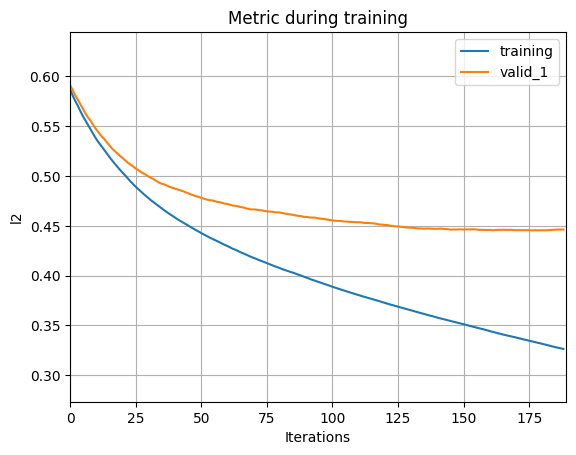

----> || Train Optimized QWK SCORE ::  0.669
----> || Val Optimized QWK SCORE ::  0.490
----> || Train Optimized Val QWK SCORE ::  0.449
----> || Val Optimized Train QWK SCORE ::  0.623
Fold 1 - Rounded Train QWK: 0.5375, Rounded Validation QWK: 0.3260


<Figure size 640x480 with 0 Axes>

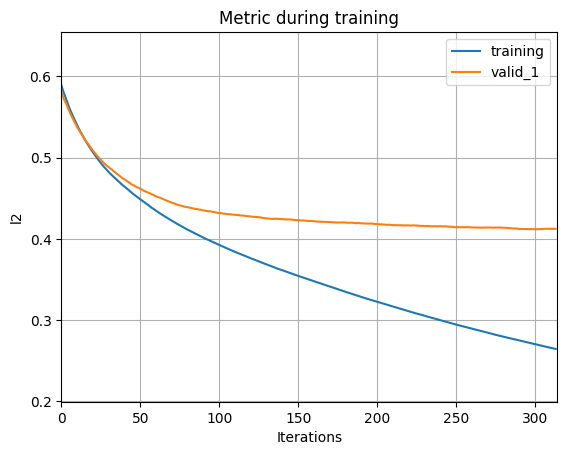

----> || Train Optimized QWK SCORE ::  0.754
----> || Val Optimized QWK SCORE ::  0.436
----> || Train Optimized Val QWK SCORE ::  0.514
----> || Val Optimized Train QWK SCORE ::  0.621
Fold 2 - Rounded Train QWK: 0.6410, Rounded Validation QWK: 0.4233


<Figure size 640x480 with 0 Axes>

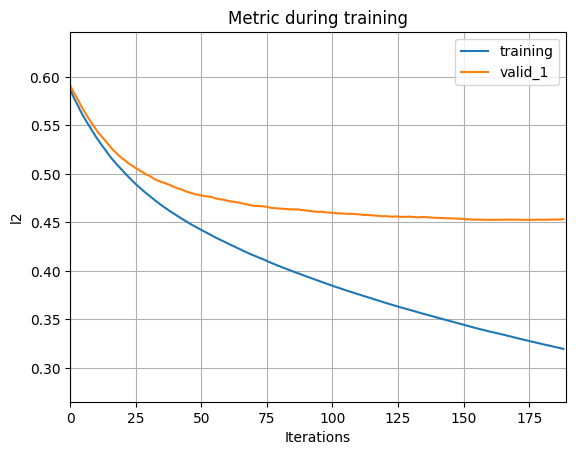

----> || Train Optimized QWK SCORE ::  0.679
----> || Val Optimized QWK SCORE ::  0.507
----> || Train Optimized Val QWK SCORE ::  0.481
----> || Val Optimized Train QWK SCORE ::  0.673
Fold 3 - Rounded Train QWK: 0.5621, Rounded Validation QWK: 0.3033


<Figure size 640x480 with 0 Axes>

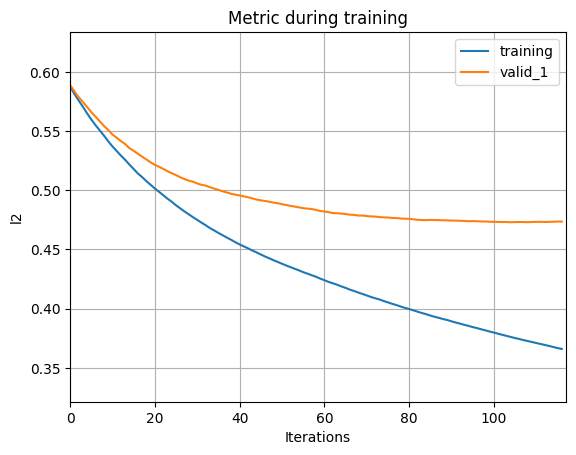

----> || Train Optimized QWK SCORE ::  0.473
----> || Val Optimized QWK SCORE ::  0.346
----> || Train Optimized Val QWK SCORE ::  0.340
----> || Val Optimized Train QWK SCORE ::  0.464
Fold 4 - Rounded Train QWK: 0.4709, Rounded Validation QWK: 0.3352


<Figure size 640x480 with 0 Axes>

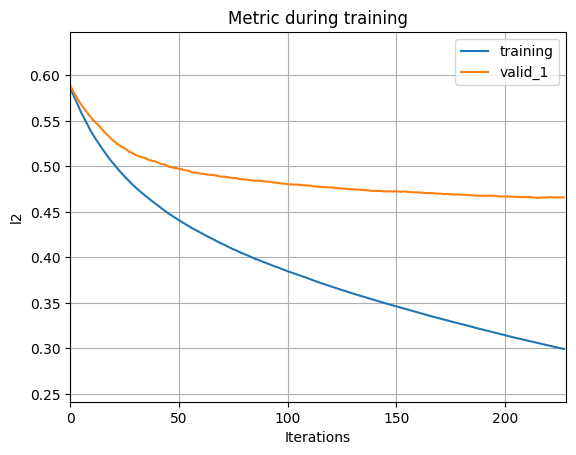

----> || Train Optimized QWK SCORE ::  0.701
----> || Val Optimized QWK SCORE ::  0.439
----> || Train Optimized Val QWK SCORE ::  0.419
----> || Val Optimized Train QWK SCORE ::  0.695
Fold 5 - Rounded Train QWK: 0.5885, Rounded Validation QWK: 0.3607
Mean Train QWK --> 0.6550
Mean Validation QWK ---> 0.4434
----> || Optimized QWK SCORE ::  0.474


In [94]:
lgb_models_list2, lgb_submission_df, lgb_raw_train_preds, lgb_raw_test_preds, lgb_optuna_study = lgb_feature_selection(
    train_selected_df, test_selected_df, 150
)

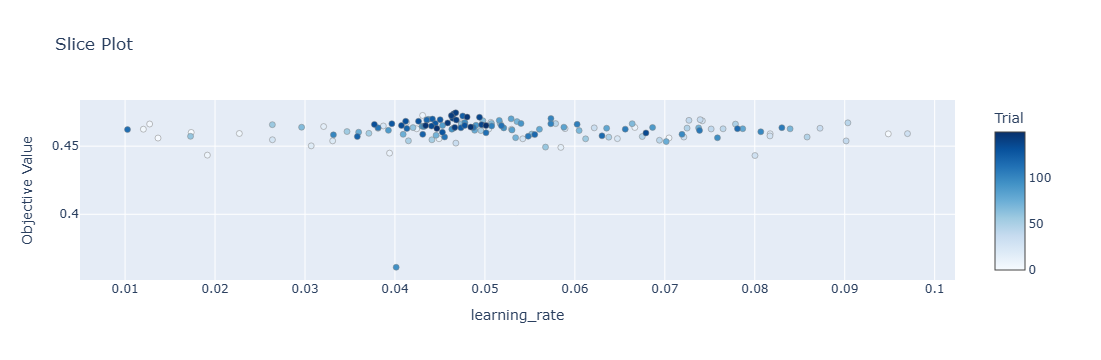

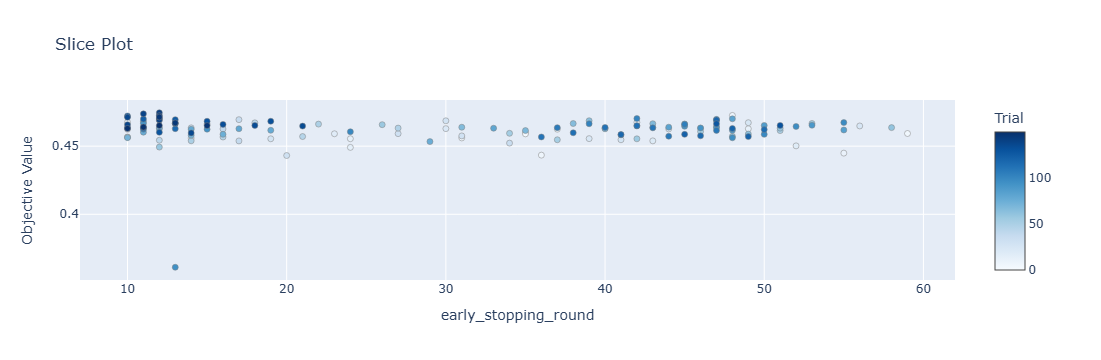

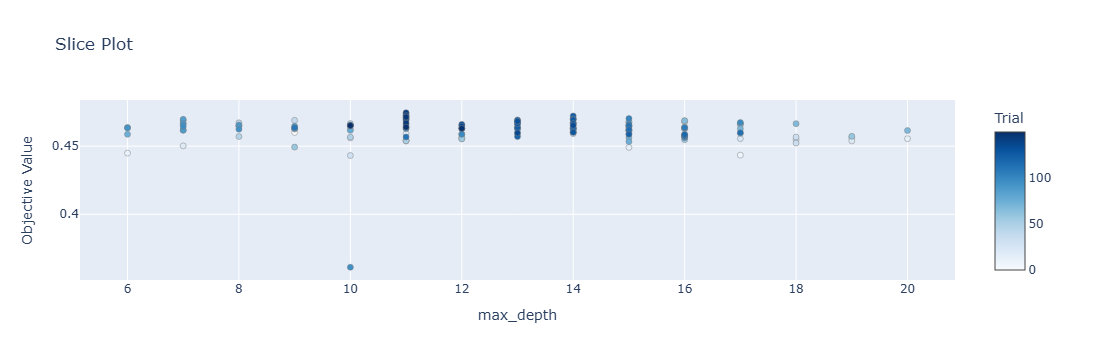

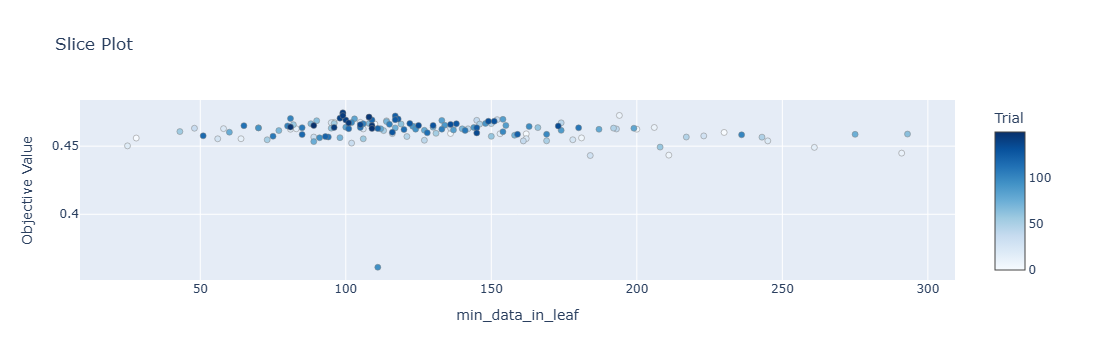

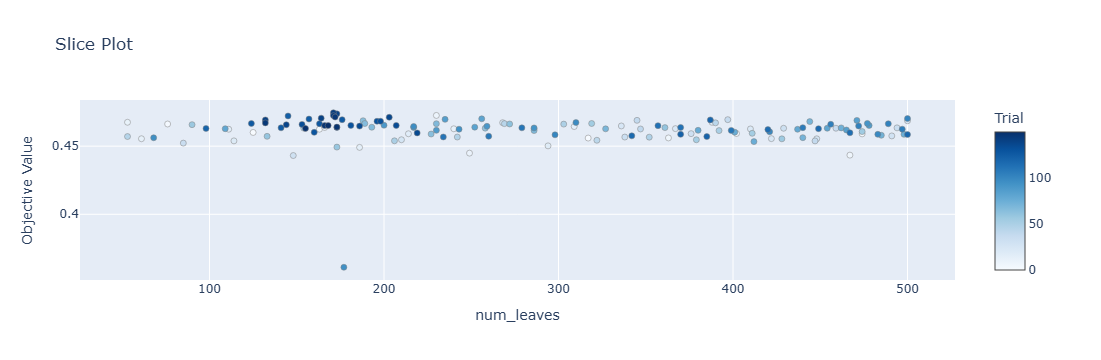

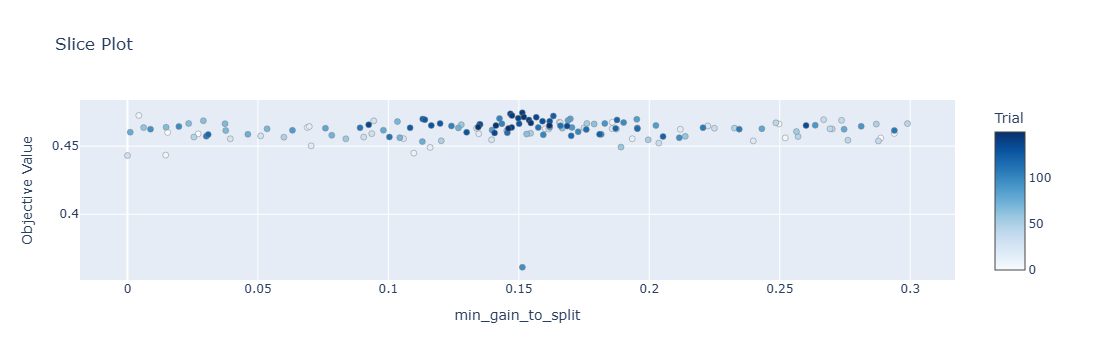

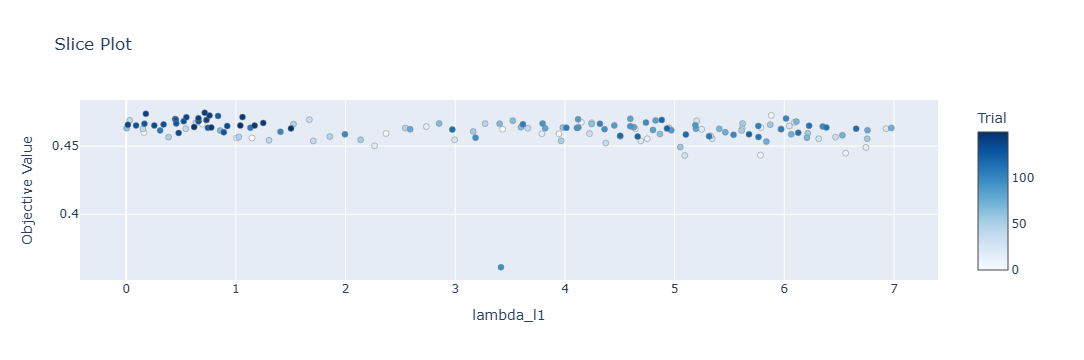

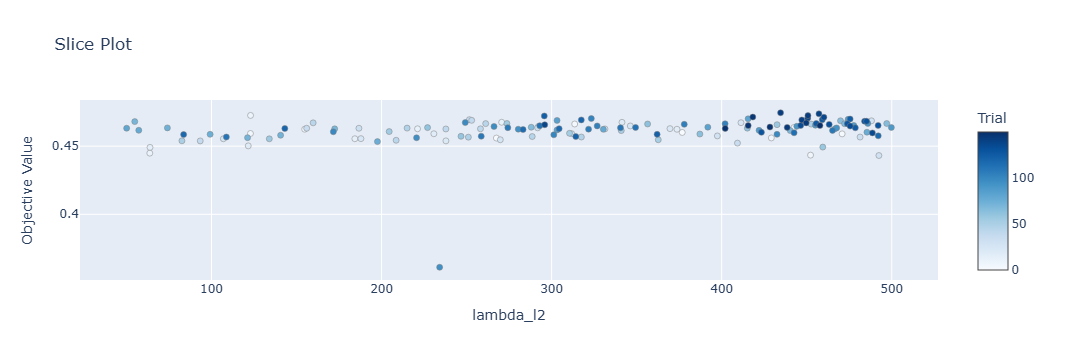

In [95]:
for param in lgb_optuna_study.best_params.keys():
    fig = plot_slice(lgb_optuna_study, params=[param])
    fig.show()

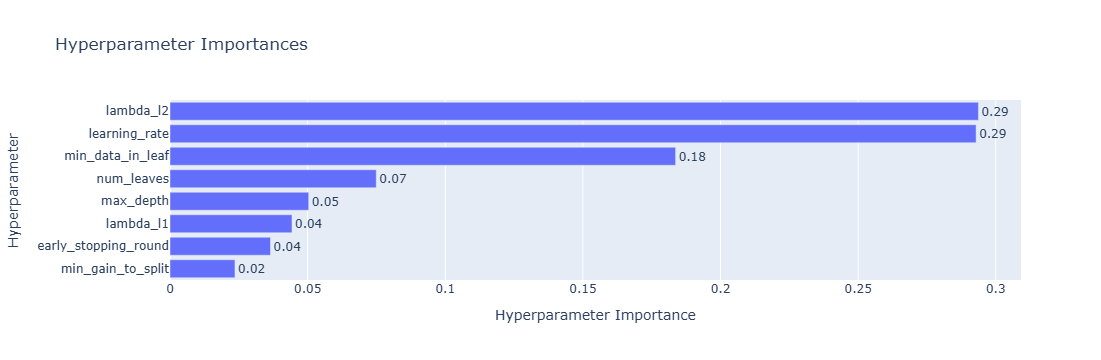

In [96]:
plot_param_importances(lgb_optuna_study)

In [97]:
lgb_optuna_study.best_params

{'learning_rate': 0.046760399899708656,
 'early_stopping_round': 12,
 'max_depth': 11,
 'min_data_in_leaf': 99,
 'num_leaves': 171,
 'min_gain_to_split': 0.1513337576666375,
 'lambda_l1': 0.7158499956663646,
 'lambda_l2': 434.62212451164515}

In [100]:
cols = train_selected_df.drop(['id', 'sii'], axis=1).columns
importance_list = []
for model in lgb_models_list2:
    importance_list.append(model.feature_importances_)

importance_mean = np.mean(importance_list, axis=0)
imp_df = pd.DataFrame(sorted(zip(cols, importance_mean)), columns=['Feature', 'Importance']).sort_values('Importance', ascending=False)
unimportant_df = imp_df[imp_df['Importance'] < imp_df['Importance'].quantile(0.5)]
unimportant_cols = unimportant_df['Feature'].tolist()

In [101]:
train_selected_df3 = train_selected_df.drop(unimportant_cols, axis=1)
print(train_selected_df3.shape)
train_selected_df3.head()

(2736, 455)


id  Basic_Demos-Age  CGAS-CGAS_Score  Physical-BMI  Physical-Height  \
0  00008ff9              5.0             51.0     16.877316             46.0   
1  000fd460              9.0             63.2     14.035590             48.0   
2  00105258             10.0             71.0     16.648696             56.5   
3  00115b9f              9.0             71.0     18.292347             56.0   
4  001f3379             13.0             50.0     22.279952             59.5   

   Physical-Weight  Physical-Waist_Circumference  Physical-HeartRate  \
0             50.8                          25.0                80.0   
1             46.0                          22.0                70.0   
2             75.6                          27.0                94.0   
3             81.6                          26.4                97.0   
4            112.2                          32.0                73.0   

   Physical-Systolic_BP  Fitness_Endurance-Max_Stage  \
0                 130.2                          4.4   
1                 122.0                          5.8   
2                 117.0                          5.0   
3                 117.0                          6.0   
4                 102.0                          4.6   

   Fitness_Endurance-Time_Mins  Fitness_Endurance-Time_Sec  FGC-FGC_CU  \
0                          6.2                        22.6         0.0   
1                          9.0                        14.4         3.0   
2                          7.0                        33.0        20.0   
3                          9.0                        37.0        18.0   
4                          5.8                        39.4        12.0   

   FGC-FGC_GSND  FGC-FGC_GSD  FGC-FGC_PU  FGC-FGC_TL  \
0         20.50        21.18         0.0         6.0   
1         23.08        24.94         5.0         3.0   
2         10.20        14.70         7.0         5.0   
3         17.66        19.24         5.0         7.0   
4         16.50        17.90         6.0         8.0   

   BIA-BIA_Activity_Level_num  BIA-BIA_BMC  BIA-BIA_BMI  BIA-BIA_FFMI  \
0                         2.0     2.668550     16.87920      13.81770   
1                         2.0     2.579490     14.03710      12.82540   
2                         2.4     4.310264     18.29524      24.52766   
3                         3.0     3.841910     18.29430      14.07400   
4                         2.0     4.330360     30.18650      16.68770   

   BIA-BIA_FMI  BIA-BIA_Fat  BIA-BIA_Frame_num  PAQ_A-PAQ_A_Total  \
0      3.06143     9.213770                1.0              1.844   
1      1.21172     3.970850                1.0              1.704   
2     -6.23241   -24.811978                1.4              2.578   
3      4.22033    18.824300                2.0              2.018   
4     13.49880    67.971500                2.0              2.004   

   PAQ_C-PAQ_C_Total  SDS-SDS_Total_Raw  \
0             2.6342               41.6   
1             2.3400               46.0   
2             2.1700               38.0   
3             2.4510               31.0   
4             4.1100               40.0   

   PreInt_EduHx-computerinternet_hoursday  total_num_nan  \
0                                     3.0           19.0   
1                                     0.0           12.0   
2                                     2.0           20.0   
3                                     0.0            7.0   
4                                     0.0            7.0   

   Physical-Waist_Circumference_isnan  FGC-FGC_CU_isnan  PAQ_C-Season_isnan  \
0                                 1.0               0.0                 1.0   
1                                 0.0               0.0                 0.0   
2                                 1.0               0.0                 0.0   
3                                 1.0               0.0                 0.0   
4                                 1.0               0.0                 0.0   

       Y_3%     Z_std     Z

In [102]:
test_selected_df3 = test_selected_df.drop(unimportant_cols, axis=1)
print(test_selected_df3.shape)
test_selected_df3.head()

(20, 454)


id  Basic_Demos-Age  CGAS-CGAS_Score  Physical-BMI  Physical-Height  \
0  00008ff9              5.0             51.0     16.877316           46.000   
1  000fd460              9.0             63.2     14.035590           48.000   
2  00105258             10.0             71.0     16.648696           56.500   
3  00115b9f              9.0             71.0     18.292347           56.000   
4  0016bb22             18.0             65.8     22.367377           66.878   

   Physical-Weight  Physical-Waist_Circumference  Physical-HeartRate  \
0             50.8                          25.0                80.0   
1             46.0                          22.0                70.0   
2             75.6                          27.0                94.0   
3             81.6                          26.4                97.0   
4             20.0                          31.7                75.4   

   Physical-Systolic_BP  Fitness_Endurance-Max_Stage  \
0                 130.2                          4.4   
1                 122.0                          5.8   
2                 117.0                          5.0   
3                 117.0                          6.0   
4                 113.6                          4.6   

   Fitness_Endurance-Time_Mins  Fitness_Endurance-Time_Sec  FGC-FGC_CU  \
0                          6.2                        22.6         0.0   
1                          9.0                        14.4         3.0   
2                          7.0                        33.0        20.0   
3                          9.0                        37.0        18.0   
4                          7.2                        17.8         5.8   

   FGC-FGC_GSND  FGC-FGC_GSD  FGC-FGC_PU  FGC-FGC_TL  \
0         20.50        21.18         0.0         6.0   
1         23.08        24.94         5.0         3.0   
2         10.20        14.70         7.0         5.0   
3         17.66        19.24         5.0         7.0   
4         28.28        27.96         4.2         8.6   

   BIA-BIA_Activity_Level_num  BIA-BIA_BMC  BIA-BIA_BMI  BIA-BIA_FFMI  \
0                         2.0     2.668550     16.87920      13.81770   
1                         2.0     2.579490     14.03710      12.82540   
2                         2.4     4.310264     18.29524      24.52766   
3                         3.0     3.841910     18.29430      14.07400   
4                         3.0     5.477302     20.24658      15.81610   

   BIA-BIA_FMI  BIA-BIA_Fat  BIA-BIA_Frame_num  PAQ_A-PAQ_A_Total  \
0     3.061430     9.213770                1.0              1.844   
1     1.211720     3.970850                1.0              1.704   
2    -6.232410   -24.811978                1.4              2.578   
3     4.220330    18.824300                2.0              2.018   
4     4.430456    26.554596                2.4              1.040   

   PAQ_C-PAQ_C_Total  SDS-SDS_Total_Raw  \
0             2.6342               41.6   
1             2.3400               46.0   
2             2.1700               38.0   
3             2.4510               31.0   
4             2.2922               65.2   

   PreInt_EduHx-computerinternet_hoursday  total_num_nan  \
0                                     3.0           19.0   
1                                     0.0           12.0   
2                                     2.0           20.0   
3                                     0.0            7.0   
4                                     2.2           52.0   

   Physical-Waist_Circumference_isnan  FGC-FGC_CU_isnan  PAQ_C-Season_isnan  \
0                                 1.0               0.0                 1.0   
1                                 0.0               0.0                 0.0   
2                                 1.0               0.0                 0.0   
3                                 1.0               0.0                 0.0   
4                                 1.0               1.0                 1.0   

       Y_3%     Z_std     Z

[I 2024-12-14 21:03:58,589] A new study created in memory with name: no-name-bc7c8ce5-97f6-491c-a04d-53d00679835f
[I 2024-12-14 21:04:04,495] Trial 0 finished with value: 0.45796979227161805 and parameters: {'learning_rate': 0.02848472979006656, 'early_stopping_round': 35, 'max_depth': 14, 'min_data_in_leaf': 231, 'num_leaves': 324, 'min_gain_to_split': 0.1836691152244608, 'lambda_l1': 1.0247604795502507, 'lambda_l2': 970.3355965753353}. Best is trial 0 with value: 0.45796979227161805.


----> || Optimized QWK SCORE ::  0.458


[I 2024-12-14 21:04:07,743] Trial 1 finished with value: 0.4557693848813381 and parameters: {'learning_rate': 0.08936515970440694, 'early_stopping_round': 13, 'max_depth': 10, 'min_data_in_leaf': 221, 'num_leaves': 734, 'min_gain_to_split': 0.08487116647709582, 'lambda_l1': 1.4652484452409964, 'lambda_l2': 791.370460341502}. Best is trial 0 with value: 0.45796979227161805.


----> || Optimized QWK SCORE ::  0.456


[I 2024-12-14 21:04:14,700] Trial 2 finished with value: 0.4737598973807353 and parameters: {'learning_rate': 0.03243252107513933, 'early_stopping_round': 50, 'max_depth': 7, 'min_data_in_leaf': 64, 'num_leaves': 211, 'min_gain_to_split': 0.16234555667153286, 'lambda_l1': 5.136867553326885, 'lambda_l2': 286.06759568626023}. Best is trial 2 with value: 0.4737598973807353.


----> || Optimized QWK SCORE ::  0.474


[I 2024-12-14 21:04:18,337] Trial 3 finished with value: 0.4625540832343965 and parameters: {'learning_rate': 0.05283625185575437, 'early_stopping_round': 45, 'max_depth': 15, 'min_data_in_leaf': 234, 'num_leaves': 126, 'min_gain_to_split': 0.2717458590204364, 'lambda_l1': 0.023869784957181173, 'lambda_l2': 710.0169141924699}. Best is trial 2 with value: 0.4737598973807353.


----> || Optimized QWK SCORE ::  0.463


[I 2024-12-14 21:04:21,120] Trial 4 finished with value: 0.4629618619616346 and parameters: {'learning_rate': 0.0779473271682362, 'early_stopping_round': 13, 'max_depth': 6, 'min_data_in_leaf': 182, 'num_leaves': 470, 'min_gain_to_split': 0.19471904673323004, 'lambda_l1': 6.21515154200617, 'lambda_l2': 393.4391715806559}. Best is trial 2 with value: 0.4737598973807353.


----> || Optimized QWK SCORE ::  0.463


[I 2024-12-14 21:04:26,543] Trial 5 finished with value: 0.46483063229215116 and parameters: {'learning_rate': 0.03820212836896705, 'early_stopping_round': 42, 'max_depth': 15, 'min_data_in_leaf': 117, 'num_leaves': 561, 'min_gain_to_split': 0.29024642079750823, 'lambda_l1': 9.445631658207184, 'lambda_l2': 740.6983869904742}. Best is trial 2 with value: 0.4737598973807353.


----> || Optimized QWK SCORE ::  0.465


[I 2024-12-14 21:04:32,087] Trial 6 finished with value: 0.463636934603747 and parameters: {'learning_rate': 0.03560113917467804, 'early_stopping_round': 15, 'max_depth': 6, 'min_data_in_leaf': 150, 'num_leaves': 430, 'min_gain_to_split': 0.12714294386696615, 'lambda_l1': 9.070340132124027, 'lambda_l2': 789.2254389260418}. Best is trial 2 with value: 0.4737598973807353.


----> || Optimized QWK SCORE ::  0.464


[I 2024-12-14 21:04:36,451] Trial 7 finished with value: 0.45831764182272583 and parameters: {'learning_rate': 0.03675401925501363, 'early_stopping_round': 23, 'max_depth': 15, 'min_data_in_leaf': 219, 'num_leaves': 279, 'min_gain_to_split': 0.07871194009188213, 'lambda_l1': 7.498009784201103, 'lambda_l2': 552.3585175930654}. Best is trial 2 with value: 0.4737598973807353.


----> || Optimized QWK SCORE ::  0.458


[I 2024-12-14 21:04:49,852] Trial 8 finished with value: 0.45975513435161586 and parameters: {'learning_rate': 0.010806763580014422, 'early_stopping_round': 34, 'max_depth': 10, 'min_data_in_leaf': 125, 'num_leaves': 499, 'min_gain_to_split': 0.11839383888285442, 'lambda_l1': 5.093294682818872, 'lambda_l2': 263.90693027305576}. Best is trial 2 with value: 0.4737598973807353.


----> || Optimized QWK SCORE ::  0.460


[I 2024-12-14 21:04:52,984] Trial 9 finished with value: 0.46420839948044446 and parameters: {'learning_rate': 0.094640749764503, 'early_stopping_round': 10, 'max_depth': 10, 'min_data_in_leaf': 49, 'num_leaves': 65, 'min_gain_to_split': 0.25730850804388256, 'lambda_l1': 3.5347457197126175, 'lambda_l2': 501.1082513886362}. Best is trial 2 with value: 0.4737598973807353.


----> || Optimized QWK SCORE ::  0.464


[I 2024-12-14 21:05:03,512] Trial 10 finished with value: 0.45239727181815115 and parameters: {'learning_rate': 0.06557756857660621, 'early_stopping_round': 59, 'max_depth': 20, 'min_data_in_leaf': 20, 'num_leaves': 987, 'min_gain_to_split': 0.008320848507648498, 'lambda_l1': 3.3342136470225334, 'lambda_l2': 57.529852636694415}. Best is trial 2 with value: 0.4737598973807353.


----> || Optimized QWK SCORE ::  0.452


[I 2024-12-14 21:05:08,564] Trial 11 finished with value: 0.46398232465513456 and parameters: {'learning_rate': 0.05016654877639368, 'early_stopping_round': 48, 'max_depth': 18, 'min_data_in_leaf': 93, 'num_leaves': 695, 'min_gain_to_split': 0.21496713404818274, 'lambda_l1': 9.898850161171467, 'lambda_l2': 227.26131696594086}. Best is trial 2 with value: 0.4737598973807353.


----> || Optimized QWK SCORE ::  0.464


[I 2024-12-14 21:05:15,269] Trial 12 finished with value: 0.45789407472638066 and parameters: {'learning_rate': 0.018337163497723998, 'early_stopping_round': 47, 'max_depth': 12, 'min_data_in_leaf': 296, 'num_leaves': 684, 'min_gain_to_split': 0.2967041190393883, 'lambda_l1': 7.822702292541913, 'lambda_l2': 604.4981333422846}. Best is trial 2 with value: 0.4737598973807353.


----> || Optimized QWK SCORE ::  0.458


[I 2024-12-14 21:05:21,817] Trial 13 finished with value: 0.46606419749379824 and parameters: {'learning_rate': 0.039680865275881355, 'early_stopping_round': 52, 'max_depth': 17, 'min_data_in_leaf': 82, 'num_leaves': 267, 'min_gain_to_split': 0.24028202594926024, 'lambda_l1': 6.8386552452223075, 'lambda_l2': 972.762429316607}. Best is trial 2 with value: 0.4737598973807353.


----> || Optimized QWK SCORE ::  0.466


[I 2024-12-14 21:05:33,303] Trial 14 finished with value: 0.4641917939283755 and parameters: {'learning_rate': 0.022059025746227458, 'early_stopping_round': 58, 'max_depth': 18, 'min_data_in_leaf': 47, 'num_leaves': 181, 'min_gain_to_split': 0.23458219011751835, 'lambda_l1': 5.918015053161536, 'lambda_l2': 999.1223183661854}. Best is trial 2 with value: 0.4737598973807353.


----> || Optimized QWK SCORE ::  0.464


[I 2024-12-14 21:05:39,150] Trial 15 finished with value: 0.47432545625301425 and parameters: {'learning_rate': 0.045908603300425344, 'early_stopping_round': 53, 'max_depth': 8, 'min_data_in_leaf': 83, 'num_leaves': 257, 'min_gain_to_split': 0.16435756498618723, 'lambda_l1': 3.751662303218856, 'lambda_l2': 326.5474318431262}. Best is trial 15 with value: 0.47432545625301425.


----> || Optimized QWK SCORE ::  0.474


[I 2024-12-14 21:05:44,119] Trial 16 finished with value: 0.4647043235793842 and parameters: {'learning_rate': 0.06308294787300976, 'early_stopping_round': 54, 'max_depth': 8, 'min_data_in_leaf': 76, 'num_leaves': 353, 'min_gain_to_split': 0.16461193730514923, 'lambda_l1': 3.6257789858945255, 'lambda_l2': 313.9297429991917}. Best is trial 15 with value: 0.47432545625301425.


----> || Optimized QWK SCORE ::  0.465


[I 2024-12-14 21:05:51,870] Trial 17 finished with value: 0.4610494562559754 and parameters: {'learning_rate': 0.0470618889778491, 'early_stopping_round': 40, 'max_depth': 8, 'min_data_in_leaf': 20, 'num_leaves': 179, 'min_gain_to_split': 0.15483017459193052, 'lambda_l1': 4.252501355555229, 'lambda_l2': 118.1868787391694}. Best is trial 15 with value: 0.47432545625301425.


----> || Optimized QWK SCORE ::  0.461


[I 2024-12-14 21:05:55,427] Trial 18 finished with value: 0.46912831869260063 and parameters: {'learning_rate': 0.06655288663266432, 'early_stopping_round': 27, 'max_depth': 8, 'min_data_in_leaf': 120, 'num_leaves': 217, 'min_gain_to_split': 0.0725497410256478, 'lambda_l1': 2.2138761702102867, 'lambda_l2': 393.2992778814713}. Best is trial 15 with value: 0.47432545625301425.


----> || Optimized QWK SCORE ::  0.469


[I 2024-12-14 21:06:00,107] Trial 19 finished with value: 0.46305515394961194 and parameters: {'learning_rate': 0.02877574344211048, 'early_stopping_round': 53, 'max_depth': 12, 'min_data_in_leaf': 170, 'num_leaves': 56, 'min_gain_to_split': 0.11584458647793106, 'lambda_l1': 4.830515631399361, 'lambda_l2': 172.0527795331601}. Best is trial 15 with value: 0.47432545625301425.


----> || Optimized QWK SCORE ::  0.463


[I 2024-12-14 21:06:06,799] Trial 20 finished with value: 0.4754326636164711 and parameters: {'learning_rate': 0.05917527037115868, 'early_stopping_round': 30, 'max_depth': 7, 'min_data_in_leaf': 64, 'num_leaves': 394, 'min_gain_to_split': 0.034615765940966076, 'lambda_l1': 2.4406929761294194, 'lambda_l2': 377.69145454702175}. Best is trial 20 with value: 0.4754326636164711.


----> || Optimized QWK SCORE ::  0.475


[I 2024-12-14 21:06:13,309] Trial 21 finished with value: 0.4658214816231082 and parameters: {'learning_rate': 0.058964837977396885, 'early_stopping_round': 28, 'max_depth': 7, 'min_data_in_leaf': 54, 'num_leaves': 363, 'min_gain_to_split': 0.008542530838384355, 'lambda_l1': 2.411649084546414, 'lambda_l2': 383.78582267735493}. Best is trial 20 with value: 0.4754326636164711.


----> || Optimized QWK SCORE ::  0.466


[I 2024-12-14 21:06:18,912] Trial 22 finished with value: 0.46846497596458836 and parameters: {'learning_rate': 0.07242989364570651, 'early_stopping_round': 41, 'max_depth': 9, 'min_data_in_leaf': 93, 'num_leaves': 594, 'min_gain_to_split': 0.054438114987463065, 'lambda_l1': 2.6536674881200355, 'lambda_l2': 468.60491849573043}. Best is trial 20 with value: 0.4754326636164711.


----> || Optimized QWK SCORE ::  0.468


[I 2024-12-14 21:06:24,187] Trial 23 finished with value: 0.47072804867742746 and parameters: {'learning_rate': 0.046835984838593914, 'early_stopping_round': 29, 'max_depth': 6, 'min_data_in_leaf': 59, 'num_leaves': 420, 'min_gain_to_split': 0.18702930377104002, 'lambda_l1': 5.159425456925438, 'lambda_l2': 318.3586046727235}. Best is trial 20 with value: 0.4754326636164711.


----> || Optimized QWK SCORE ::  0.471


[I 2024-12-14 21:06:27,082] Trial 24 finished with value: 0.4580686999547521 and parameters: {'learning_rate': 0.07781435122369519, 'early_stopping_round': 20, 'max_depth': 11, 'min_data_in_leaf': 138, 'num_leaves': 248, 'min_gain_to_split': 0.13945252401343003, 'lambda_l1': 4.067099559958489, 'lambda_l2': 222.82151311088927}. Best is trial 20 with value: 0.4754326636164711.


----> || Optimized QWK SCORE ::  0.458


[I 2024-12-14 21:06:32,505] Trial 25 finished with value: 0.47659105997831797 and parameters: {'learning_rate': 0.045395982289384414, 'early_stopping_round': 38, 'max_depth': 7, 'min_data_in_leaf': 100, 'num_leaves': 147, 'min_gain_to_split': 0.036471472536421384, 'lambda_l1': 1.1351883593811545, 'lambda_l2': 427.96351505943625}. Best is trial 25 with value: 0.47659105997831797.


----> || Optimized QWK SCORE ::  0.477


[I 2024-12-14 21:06:39,700] Trial 26 finished with value: 0.4760290911755547 and parameters: {'learning_rate': 0.04331333049528638, 'early_stopping_round': 32, 'max_depth': 9, 'min_data_in_leaf': 100, 'num_leaves': 140, 'min_gain_to_split': 0.03469098325219366, 'lambda_l1': 0.49853072649939434, 'lambda_l2': 625.9786027516803}. Best is trial 25 with value: 0.47659105997831797.


----> || Optimized QWK SCORE ::  0.476


[I 2024-12-14 21:06:44,712] Trial 27 finished with value: 0.4781576354956315 and parameters: {'learning_rate': 0.05679871021187509, 'early_stopping_round': 32, 'max_depth': 9, 'min_data_in_leaf': 106, 'num_leaves': 123, 'min_gain_to_split': 0.0356934212109172, 'lambda_l1': 0.1433571441029704, 'lambda_l2': 639.6852916281388}. Best is trial 27 with value: 0.4781576354956315.


----> || Optimized QWK SCORE ::  0.478


[I 2024-12-14 21:06:50,760] Trial 28 finished with value: 0.47804122437731045 and parameters: {'learning_rate': 0.05522774471717547, 'early_stopping_round': 37, 'max_depth': 9, 'min_data_in_leaf': 104, 'num_leaves': 127, 'min_gain_to_split': 0.049155272709743306, 'lambda_l1': 0.9490826593184648, 'lambda_l2': 647.1849339507615}. Best is trial 27 with value: 0.4781576354956315.


----> || Optimized QWK SCORE ::  0.478


[I 2024-12-14 21:06:54,926] Trial 29 finished with value: 0.4695925798694607 and parameters: {'learning_rate': 0.05595447042920434, 'early_stopping_round': 37, 'max_depth': 13, 'min_data_in_leaf': 191, 'num_leaves': 99, 'min_gain_to_split': 0.04218936640972056, 'lambda_l1': 1.4588861441559176, 'lambda_l2': 675.5968657137373}. Best is trial 27 with value: 0.4781576354956315.


----> || Optimized QWK SCORE ::  0.470


[I 2024-12-14 21:07:01,398] Trial 30 finished with value: 0.47370062427951687 and parameters: {'learning_rate': 0.07023918070275541, 'early_stopping_round': 38, 'max_depth': 11, 'min_data_in_leaf': 108, 'num_leaves': 900, 'min_gain_to_split': 0.08787915484669825, 'lambda_l1': 0.5469845334868603, 'lambda_l2': 856.19311448177}. Best is trial 27 with value: 0.4781576354956315.


----> || Optimized QWK SCORE ::  0.474


[I 2024-12-14 21:07:06,321] Trial 31 finished with value: 0.45982948580056104 and parameters: {'learning_rate': 0.04084491257691196, 'early_stopping_round': 32, 'max_depth': 9, 'min_data_in_leaf': 141, 'num_leaves': 143, 'min_gain_to_split': 0.0282908426536261, 'lambda_l1': 1.0334770243663776, 'lambda_l2': 615.8039115431334}. Best is trial 27 with value: 0.4781576354956315.


----> || Optimized QWK SCORE ::  0.460


[I 2024-12-14 21:07:12,028] Trial 32 finished with value: 0.47358336813881696 and parameters: {'learning_rate': 0.05175439014344677, 'early_stopping_round': 35, 'max_depth': 10, 'min_data_in_leaf': 98, 'num_leaves': 137, 'min_gain_to_split': 0.059111890978831516, 'lambda_l1': 0.08518404677190136, 'lambda_l2': 591.6084003111739}. Best is trial 27 with value: 0.4781576354956315.


----> || Optimized QWK SCORE ::  0.474


[I 2024-12-14 21:07:16,889] Trial 33 finished with value: 0.46797185036245303 and parameters: {'learning_rate': 0.04512465789879233, 'early_stopping_round': 25, 'max_depth': 9, 'min_data_in_leaf': 132, 'num_leaves': 308, 'min_gain_to_split': 0.10046090846018622, 'lambda_l1': 1.6351322430460868, 'lambda_l2': 663.5103527273899}. Best is trial 27 with value: 0.4781576354956315.


----> || Optimized QWK SCORE ::  0.468


[I 2024-12-14 21:07:22,158] Trial 34 finished with value: 0.47287132516459773 and parameters: {'learning_rate': 0.059560691215238694, 'early_stopping_round': 33, 'max_depth': 7, 'min_data_in_leaf': 106, 'num_leaves': 112, 'min_gain_to_split': 0.017416729012598477, 'lambda_l1': 0.7106625216408887, 'lambda_l2': 872.1843407919162}. Best is trial 27 with value: 0.4781576354956315.


----> || Optimized QWK SCORE ::  0.473


[I 2024-12-14 21:07:28,155] Trial 35 finished with value: 0.471267600682054 and parameters: {'learning_rate': 0.03126425762082142, 'early_stopping_round': 43, 'max_depth': 9, 'min_data_in_leaf': 157, 'num_leaves': 51, 'min_gain_to_split': 0.05213003855876086, 'lambda_l1': 1.5123497796669123, 'lambda_l2': 456.9759738297987}. Best is trial 27 with value: 0.4781576354956315.


----> || Optimized QWK SCORE ::  0.471


[I 2024-12-14 21:07:32,942] Trial 36 finished with value: 0.4739236193595415 and parameters: {'learning_rate': 0.052585481764087644, 'early_stopping_round': 37, 'max_depth': 13, 'min_data_in_leaf': 111, 'num_leaves': 189, 'min_gain_to_split': 0.023310449678523863, 'lambda_l1': 0.09275231373250381, 'lambda_l2': 556.636938847374}. Best is trial 27 with value: 0.4781576354956315.


----> || Optimized QWK SCORE ::  0.474


[I 2024-12-14 21:07:41,320] Trial 37 finished with value: 0.46618968081537315 and parameters: {'learning_rate': 0.079381044212147, 'early_stopping_round': 32, 'max_depth': 11, 'min_data_in_leaf': 38, 'num_leaves': 157, 'min_gain_to_split': 0.004350170246858159, 'lambda_l1': 0.7378832221697585, 'lambda_l2': 748.2285507278696}. Best is trial 27 with value: 0.4781576354956315.


----> || Optimized QWK SCORE ::  0.466


[I 2024-12-14 21:07:48,253] Trial 38 finished with value: 0.4689298486342014 and parameters: {'learning_rate': 0.041825103189132525, 'early_stopping_round': 20, 'max_depth': 6, 'min_data_in_leaf': 70, 'num_leaves': 316, 'min_gain_to_split': 0.06793933524823856, 'lambda_l1': 1.908911963651128, 'lambda_l2': 650.2702936149531}. Best is trial 27 with value: 0.4781576354956315.


----> || Optimized QWK SCORE ::  0.469


[I 2024-12-14 21:07:54,235] Trial 39 finished with value: 0.46663882862356 and parameters: {'learning_rate': 0.02542215307649405, 'early_stopping_round': 39, 'max_depth': 7, 'min_data_in_leaf': 169, 'num_leaves': 95, 'min_gain_to_split': 0.09611324973434526, 'lambda_l1': 2.9795027085338077, 'lambda_l2': 520.6003667308356}. Best is trial 27 with value: 0.4781576354956315.


----> || Optimized QWK SCORE ::  0.467


[I 2024-12-14 21:08:00,504] Trial 40 finished with value: 0.46603895762964 and parameters: {'learning_rate': 0.034072456029682105, 'early_stopping_round': 45, 'max_depth': 10, 'min_data_in_leaf': 148, 'num_leaves': 219, 'min_gain_to_split': 0.043332853372340815, 'lambda_l1': 0.8597555568578412, 'lambda_l2': 719.1901674224953}. Best is trial 27 with value: 0.4781576354956315.


----> || Optimized QWK SCORE ::  0.466


[I 2024-12-14 21:08:07,802] Trial 41 finished with value: 0.47538314131476245 and parameters: {'learning_rate': 0.057099428940582404, 'early_stopping_round': 30, 'max_depth': 7, 'min_data_in_leaf': 69, 'num_leaves': 393, 'min_gain_to_split': 0.03432577806614906, 'lambda_l1': 1.1594813518725187, 'lambda_l2': 452.10596974554835}. Best is trial 27 with value: 0.4781576354956315.


----> || Optimized QWK SCORE ::  0.475


[I 2024-12-14 21:08:14,773] Trial 42 finished with value: 0.47633937205853905 and parameters: {'learning_rate': 0.06310472384010422, 'early_stopping_round': 36, 'max_depth': 8, 'min_data_in_leaf': 88, 'num_leaves': 220, 'min_gain_to_split': 0.03610234752478618, 'lambda_l1': 0.3222571613573991, 'lambda_l2': 796.4730731252386}. Best is trial 27 with value: 0.4781576354956315.


----> || Optimized QWK SCORE ::  0.476


[I 2024-12-14 21:08:21,726] Trial 43 finished with value: 0.48106170920416325 and parameters: {'learning_rate': 0.06301102638799089, 'early_stopping_round': 36, 'max_depth': 9, 'min_data_in_leaf': 88, 'num_leaves': 102, 'min_gain_to_split': 0.0009052984918699256, 'lambda_l1': 0.22817432455800551, 'lambda_l2': 838.8357222614604}. Best is trial 43 with value: 0.48106170920416325.


----> || Optimized QWK SCORE ::  0.481


[I 2024-12-14 21:08:26,001] Trial 44 finished with value: 0.4700090874675561 and parameters: {'learning_rate': 0.07293033395426642, 'early_stopping_round': 36, 'max_depth': 8, 'min_data_in_leaf': 122, 'num_leaves': 101, 'min_gain_to_split': 0.0006442135630313288, 'lambda_l1': 0.07382397912937984, 'lambda_l2': 912.7149216612615}. Best is trial 43 with value: 0.48106170920416325.


----> || Optimized QWK SCORE ::  0.470


[I 2024-12-14 21:08:31,464] Trial 45 finished with value: 0.46437798644293815 and parameters: {'learning_rate': 0.08494103999513944, 'early_stopping_round': 44, 'max_depth': 6, 'min_data_in_leaf': 85, 'num_leaves': 227, 'min_gain_to_split': 0.06310585831713326, 'lambda_l1': 1.890973365370523, 'lambda_l2': 822.0213373752288}. Best is trial 43 with value: 0.48106170920416325.


----> || Optimized QWK SCORE ::  0.464


[I 2024-12-14 21:08:35,386] Trial 46 finished with value: 0.36155228368461345 and parameters: {'learning_rate': 0.06187271500146813, 'early_stopping_round': 35, 'max_depth': 11, 'min_data_in_leaf': 282, 'num_leaves': 291, 'min_gain_to_split': 0.023121043610465773, 'lambda_l1': 0.3045006537434966, 'lambda_l2': 776.0843159764985}. Best is trial 43 with value: 0.48106170920416325.


----> || Optimized QWK SCORE ::  0.362


[I 2024-12-14 21:08:40,757] Trial 47 finished with value: 0.47028309883031016 and parameters: {'learning_rate': 0.06610818917941369, 'early_stopping_round': 41, 'max_depth': 10, 'min_data_in_leaf': 128, 'num_leaves': 194, 'min_gain_to_split': 0.04922452090997309, 'lambda_l1': 1.3071608921703777, 'lambda_l2': 912.3484882079831}. Best is trial 43 with value: 0.48106170920416325.


----> || Optimized QWK SCORE ::  0.470


[I 2024-12-14 21:08:48,868] Trial 48 finished with value: 0.4754349175718039 and parameters: {'learning_rate': 0.04948042106278614, 'early_stopping_round': 47, 'max_depth': 8, 'min_data_in_leaf': 85, 'num_leaves': 79, 'min_gain_to_split': 0.019693413164765985, 'lambda_l1': 1.019273475793069, 'lambda_l2': 698.0423423646732}. Best is trial 43 with value: 0.48106170920416325.


----> || Optimized QWK SCORE ::  0.475


[I 2024-12-14 21:08:59,249] Trial 49 finished with value: 0.4626676803099786 and parameters: {'learning_rate': 0.055105848764241294, 'early_stopping_round': 26, 'max_depth': 14, 'min_data_in_leaf': 34, 'num_leaves': 823, 'min_gain_to_split': 0.07721900917697123, 'lambda_l1': 1.9386888710309975, 'lambda_l2': 819.4390625428424}. Best is trial 43 with value: 0.48106170920416325.


----> || Optimized QWK SCORE ::  0.463


[I 2024-12-14 21:09:03,311] Trial 50 finished with value: 0.46045503791982667 and parameters: {'learning_rate': 0.06958533085729413, 'early_stopping_round': 39, 'max_depth': 12, 'min_data_in_leaf': 191, 'num_leaves': 148, 'min_gain_to_split': 0.0126757768017893, 'lambda_l1': 2.992414373915401, 'lambda_l2': 559.1164580874234}. Best is trial 43 with value: 0.48106170920416325.


----> || Optimized QWK SCORE ::  0.460


[I 2024-12-14 21:09:08,720] Trial 51 finished with value: 0.4668255945095062 and parameters: {'learning_rate': 0.06306218226517356, 'early_stopping_round': 33, 'max_depth': 9, 'min_data_in_leaf': 100, 'num_leaves': 136, 'min_gain_to_split': 0.03719295559038231, 'lambda_l1': 0.40016145993415686, 'lambda_l2': 743.5505824906027}. Best is trial 43 with value: 0.48106170920416325.


----> || Optimized QWK SCORE ::  0.467


[I 2024-12-14 21:09:13,715] Trial 52 finished with value: 0.47392836018555373 and parameters: {'learning_rate': 0.04436912624441826, 'early_stopping_round': 23, 'max_depth': 9, 'min_data_in_leaf': 113, 'num_leaves': 169, 'min_gain_to_split': 0.0008036334669843479, 'lambda_l1': 0.5066197877814637, 'lambda_l2': 628.2083736956639}. Best is trial 43 with value: 0.48106170920416325.


----> || Optimized QWK SCORE ::  0.474


[I 2024-12-14 21:09:20,434] Trial 53 finished with value: 0.4670596360910325 and parameters: {'learning_rate': 0.05375171891146267, 'early_stopping_round': 31, 'max_depth': 8, 'min_data_in_leaf': 90, 'num_leaves': 248, 'min_gain_to_split': 0.031170970703585526, 'lambda_l1': 0.708101236123842, 'lambda_l2': 779.6530382405757}. Best is trial 43 with value: 0.48106170920416325.


----> || Optimized QWK SCORE ::  0.467


[I 2024-12-14 21:09:28,501] Trial 54 finished with value: 0.4735111831271809 and parameters: {'learning_rate': 0.036987938117595424, 'early_stopping_round': 35, 'max_depth': 10, 'min_data_in_leaf': 74, 'num_leaves': 54, 'min_gain_to_split': 0.0848256161150425, 'lambda_l1': 1.1196151886928254, 'lambda_l2': 584.9707805602385}. Best is trial 43 with value: 0.48106170920416325.


----> || Optimized QWK SCORE ::  0.474


[I 2024-12-14 21:09:34,611] Trial 55 finished with value: 0.47353264097625947 and parameters: {'learning_rate': 0.04874679987237261, 'early_stopping_round': 34, 'max_depth': 7, 'min_data_in_leaf': 100, 'num_leaves': 112, 'min_gain_to_split': 0.04772219480797928, 'lambda_l1': 8.143661470766151, 'lambda_l2': 493.3353731834825}. Best is trial 43 with value: 0.48106170920416325.


----> || Optimized QWK SCORE ::  0.474


[I 2024-12-14 21:09:41,831] Trial 56 finished with value: 0.47186748359931785 and parameters: {'learning_rate': 0.04242399528674427, 'early_stopping_round': 38, 'max_depth': 9, 'min_data_in_leaf': 120, 'num_leaves': 518, 'min_gain_to_split': 0.06573918648501884, 'lambda_l1': 0.3955382229596719, 'lambda_l2': 700.9451656771291}. Best is trial 43 with value: 0.48106170920416325.


----> || Optimized QWK SCORE ::  0.472


[I 2024-12-14 21:09:48,485] Trial 57 finished with value: 0.46493618947347704 and parameters: {'learning_rate': 0.09771791626267207, 'early_stopping_round': 42, 'max_depth': 8, 'min_data_in_leaf': 42, 'num_leaves': 200, 'min_gain_to_split': 0.012738799017764483, 'lambda_l1': 1.6645539134118001, 'lambda_l2': 425.2653430630776}. Best is trial 43 with value: 0.48106170920416325.


----> || Optimized QWK SCORE ::  0.465


[I 2024-12-14 21:09:54,059] Trial 58 finished with value: 0.46788276239399373 and parameters: {'learning_rate': 0.06136290082754263, 'early_stopping_round': 29, 'max_depth': 6, 'min_data_in_leaf': 79, 'num_leaves': 274, 'min_gain_to_split': 0.11408180219366289, 'lambda_l1': 0.0293052965031953, 'lambda_l2': 889.4734295124545}. Best is trial 43 with value: 0.48106170920416325.


----> || Optimized QWK SCORE ::  0.468


[I 2024-12-14 21:10:03,545] Trial 59 finished with value: 0.46456135382000996 and parameters: {'learning_rate': 0.06569444292985945, 'early_stopping_round': 40, 'max_depth': 10, 'min_data_in_leaf': 58, 'num_leaves': 598, 'min_gain_to_split': 0.028139287092912108, 'lambda_l1': 1.2275678830026606, 'lambda_l2': 947.5145686725868}. Best is trial 43 with value: 0.48106170920416325.


----> || Optimized QWK SCORE ::  0.465


[I 2024-12-14 21:10:09,256] Trial 60 finished with value: 0.47260572100633713 and parameters: {'learning_rate': 0.0755743572210759, 'early_stopping_round': 37, 'max_depth': 16, 'min_data_in_leaf': 104, 'num_leaves': 121, 'min_gain_to_split': 0.04002699453438759, 'lambda_l1': 2.2447838542936367, 'lambda_l2': 829.0832022091502}. Best is trial 43 with value: 0.48106170920416325.


----> || Optimized QWK SCORE ::  0.473


[I 2024-12-14 21:10:16,296] Trial 61 finished with value: 0.4710482128164929 and parameters: {'learning_rate': 0.05020056640706952, 'early_stopping_round': 46, 'max_depth': 9, 'min_data_in_leaf': 88, 'num_leaves': 77, 'min_gain_to_split': 0.019802302858433044, 'lambda_l1': 0.9036938614217639, 'lambda_l2': 694.1879833891813}. Best is trial 43 with value: 0.48106170920416325.


----> || Optimized QWK SCORE ::  0.471


[I 2024-12-14 21:10:23,033] Trial 62 finished with value: 0.4737382368122527 and parameters: {'learning_rate': 0.056573217911556506, 'early_stopping_round': 56, 'max_depth': 8, 'min_data_in_leaf': 80, 'num_leaves': 84, 'min_gain_to_split': 0.0554869108255952, 'lambda_l1': 0.4267195727846318, 'lambda_l2': 632.6630902360793}. Best is trial 43 with value: 0.48106170920416325.


----> || Optimized QWK SCORE ::  0.474


[I 2024-12-14 21:10:30,815] Trial 63 finished with value: 0.4756511740106294 and parameters: {'learning_rate': 0.049114769552329796, 'early_stopping_round': 51, 'max_depth': 20, 'min_data_in_leaf': 92, 'num_leaves': 172, 'min_gain_to_split': 0.013266210171253985, 'lambda_l1': 0.9217266157819795, 'lambda_l2': 724.8625807943919}. Best is trial 43 with value: 0.48106170920416325.


----> || Optimized QWK SCORE ::  0.476


[I 2024-12-14 21:10:36,110] Trial 64 finished with value: 0.46585992630562767 and parameters: {'learning_rate': 0.05330269709812707, 'early_stopping_round': 50, 'max_depth': 20, 'min_data_in_leaf': 133, 'num_leaves': 235, 'min_gain_to_split': 0.032118752263735, 'lambda_l1': 0.7752515794265329, 'lambda_l2': 760.0446226112224}. Best is trial 43 with value: 0.48106170920416325.


----> || Optimized QWK SCORE ::  0.466


[I 2024-12-14 21:10:43,813] Trial 65 finished with value: 0.476440938972583 and parameters: {'learning_rate': 0.0387795947506319, 'early_stopping_round': 49, 'max_depth': 16, 'min_data_in_leaf': 113, 'num_leaves': 177, 'min_gain_to_split': 0.010659895738813235, 'lambda_l1': 1.4041082918601955, 'lambda_l2': 807.4769036592846}. Best is trial 43 with value: 0.48106170920416325.


----> || Optimized QWK SCORE ::  0.476


[I 2024-12-14 21:10:49,972] Trial 66 finished with value: 0.4677568532032691 and parameters: {'learning_rate': 0.03214245603778967, 'early_stopping_round': 31, 'max_depth': 16, 'min_data_in_leaf': 118, 'num_leaves': 346, 'min_gain_to_split': 0.2818764745216391, 'lambda_l1': 1.5089308160025015, 'lambda_l2': 854.2892191530713}. Best is trial 43 with value: 0.48106170920416325.


----> || Optimized QWK SCORE ::  0.468


[I 2024-12-14 21:10:54,218] Trial 67 finished with value: 0.4711922561231203 and parameters: {'learning_rate': 0.04363332430107025, 'early_stopping_round': 24, 'max_depth': 18, 'min_data_in_leaf': 110, 'num_leaves': 158, 'min_gain_to_split': 0.04458037353961615, 'lambda_l1': 6.299009858666217, 'lambda_l2': 346.5152408061956}. Best is trial 43 with value: 0.48106170920416325.


----> || Optimized QWK SCORE ::  0.471


[I 2024-12-14 21:10:59,132] Trial 68 finished with value: 0.4618147273231602 and parameters: {'learning_rate': 0.03924223040701869, 'early_stopping_round': 27, 'max_depth': 19, 'min_data_in_leaf': 145, 'num_leaves': 207, 'min_gain_to_split': 0.20746328802694664, 'lambda_l1': 0.3057791984170444, 'lambda_l2': 803.5839191275618}. Best is trial 43 with value: 0.48106170920416325.


----> || Optimized QWK SCORE ::  0.462


[I 2024-12-14 21:11:04,646] Trial 69 finished with value: 0.47342142544173016 and parameters: {'learning_rate': 0.05879770908725479, 'early_stopping_round': 33, 'max_depth': 7, 'min_data_in_leaf': 98, 'num_leaves': 128, 'min_gain_to_split': 0.009336441458873605, 'lambda_l1': 1.7975544052030217, 'lambda_l2': 527.9094537048294}. Best is trial 43 with value: 0.48106170920416325.


----> || Optimized QWK SCORE ::  0.473


[I 2024-12-14 21:11:14,011] Trial 70 finished with value: 0.4652437627452023 and parameters: {'learning_rate': 0.0475575691524778, 'early_stopping_round': 49, 'max_depth': 12, 'min_data_in_leaf': 65, 'num_leaves': 181, 'min_gain_to_split': 0.05807585155710916, 'lambda_l1': 2.7744436396598946, 'lambda_l2': 674.4804882823033}. Best is trial 43 with value: 0.48106170920416325.


----> || Optimized QWK SCORE ::  0.465


[I 2024-12-14 21:11:20,461] Trial 71 finished with value: 0.4745325584976733 and parameters: {'learning_rate': 0.051482242650775646, 'early_stopping_round': 52, 'max_depth': 19, 'min_data_in_leaf': 94, 'num_leaves': 158, 'min_gain_to_split': 0.012260466782480463, 'lambda_l1': 1.3446630246078, 'lambda_l2': 729.0173669402724}. Best is trial 43 with value: 0.48106170920416325.


----> || Optimized QWK SCORE ::  0.475


[I 2024-12-14 21:11:27,108] Trial 72 finished with value: 0.4752172184527441 and parameters: {'learning_rate': 0.03778129107509809, 'early_stopping_round': 55, 'max_depth': 17, 'min_data_in_leaf': 114, 'num_leaves': 177, 'min_gain_to_split': 0.026375034506966218, 'lambda_l1': 0.6193122909868113, 'lambda_l2': 649.8484061974059}. Best is trial 43 with value: 0.48106170920416325.


----> || Optimized QWK SCORE ::  0.475


[I 2024-12-14 21:11:34,702] Trial 73 finished with value: 0.46234135197145787 and parameters: {'learning_rate': 0.046397231186919345, 'early_stopping_round': 59, 'max_depth': 14, 'min_data_in_leaf': 76, 'num_leaves': 122, 'min_gain_to_split': 0.00043478333614256105, 'lambda_l1': 1.02426512100948, 'lambda_l2': 592.8487752048588}. Best is trial 43 with value: 0.48106170920416325.


----> || Optimized QWK SCORE ::  0.462


[I 2024-12-14 21:11:39,529] Trial 74 finished with value: 0.46747358076474166 and parameters: {'learning_rate': 0.06400520667766857, 'early_stopping_round': 36, 'max_depth': 16, 'min_data_in_leaf': 128, 'num_leaves': 81, 'min_gain_to_split': 0.019698715272371978, 'lambda_l1': 0.28460938782366396, 'lambda_l2': 800.5428554696806}. Best is trial 43 with value: 0.48106170920416325.


----> || Optimized QWK SCORE ::  0.467


[I 2024-12-14 21:11:45,508] Trial 75 finished with value: 0.4817981960736777 and parameters: {'learning_rate': 0.06895685131510375, 'early_stopping_round': 51, 'max_depth': 7, 'min_data_in_leaf': 105, 'num_leaves': 473, 'min_gain_to_split': 0.1728900064878141, 'lambda_l1': 0.054926078558585, 'lambda_l2': 768.10946658685}. Best is trial 75 with value: 0.4817981960736777.


----> || Optimized QWK SCORE ::  0.482


[I 2024-12-14 21:11:51,373] Trial 76 finished with value: 0.4689407058552887 and parameters: {'learning_rate': 0.06884917222998542, 'early_stopping_round': 43, 'max_depth': 7, 'min_data_in_leaf': 105, 'num_leaves': 468, 'min_gain_to_split': 0.1582431709814723, 'lambda_l1': 0.09215461191639367, 'lambda_l2': 853.478933732039}. Best is trial 75 with value: 0.4817981960736777.


----> || Optimized QWK SCORE ::  0.469


[I 2024-12-14 21:11:58,637] Trial 77 finished with value: 0.4702022676854366 and parameters: {'learning_rate': 0.0345391644418163, 'early_stopping_round': 34, 'max_depth': 8, 'min_data_in_leaf': 117, 'num_leaves': 730, 'min_gain_to_split': 0.19135193746551696, 'lambda_l1': 0.6186303213848634, 'lambda_l2': 766.7538364532916}. Best is trial 75 with value: 0.4817981960736777.


----> || Optimized QWK SCORE ::  0.470


[I 2024-12-14 21:12:10,950] Trial 78 finished with value: 0.4643070666263881 and parameters: {'learning_rate': 0.01410449195355852, 'early_stopping_round': 39, 'max_depth': 9, 'min_data_in_leaf': 158, 'num_leaves': 292, 'min_gain_to_split': 0.17333179886174527, 'lambda_l1': 0.051639567785561113, 'lambda_l2': 903.814037294298}. Best is trial 75 with value: 0.4817981960736777.


----> || Optimized QWK SCORE ::  0.464


[I 2024-12-14 21:12:15,114] Trial 79 finished with value: 0.4677425520180132 and parameters: {'learning_rate': 0.08032002858649612, 'early_stopping_round': 31, 'max_depth': 6, 'min_data_in_leaf': 136, 'num_leaves': 645, 'min_gain_to_split': 0.07179799971784517, 'lambda_l1': 1.3121370429983892, 'lambda_l2': 420.91303260752204}. Best is trial 75 with value: 0.4817981960736777.


----> || Optimized QWK SCORE ::  0.468


[I 2024-12-14 21:12:22,656] Trial 80 finished with value: 0.46918246506900996 and parameters: {'learning_rate': 0.05801830924852671, 'early_stopping_round': 29, 'max_depth': 10, 'min_data_in_leaf': 52, 'num_leaves': 457, 'min_gain_to_split': 0.14537578980875232, 'lambda_l1': 2.1435491097800954, 'lambda_l2': 958.5274904672879}. Best is trial 75 with value: 0.4817981960736777.


----> || Optimized QWK SCORE ::  0.469


[I 2024-12-14 21:12:28,475] Trial 81 finished with value: 0.46890879815646413 and parameters: {'learning_rate': 0.06040740231115206, 'early_stopping_round': 50, 'max_depth': 15, 'min_data_in_leaf': 91, 'num_leaves': 231, 'min_gain_to_split': 0.1367255837405999, 'lambda_l1': 0.86981522769661, 'lambda_l2': 723.3807923444383}. Best is trial 75 with value: 0.4817981960736777.


----> || Optimized QWK SCORE ::  0.469


[I 2024-12-14 21:12:33,907] Trial 82 finished with value: 0.47010308519525823 and parameters: {'learning_rate': 0.0716617434038058, 'early_stopping_round': 57, 'max_depth': 19, 'min_data_in_leaf': 94, 'num_leaves': 207, 'min_gain_to_split': 0.20270199709022452, 'lambda_l1': 0.3206116132295016, 'lambda_l2': 788.2206394624619}. Best is trial 75 with value: 0.4817981960736777.


----> || Optimized QWK SCORE ::  0.470


[I 2024-12-14 21:12:39,456] Trial 83 finished with value: 0.4660392328527263 and parameters: {'learning_rate': 0.05491323672334185, 'early_stopping_round': 51, 'max_depth': 17, 'min_data_in_leaf': 104, 'num_leaves': 103, 'min_gain_to_split': 0.17714946243091056, 'lambda_l1': 4.763522608075925, 'lambda_l2': 682.9906338131599}. Best is trial 75 with value: 0.4817981960736777.


----> || Optimized QWK SCORE ::  0.466


[I 2024-12-14 21:12:46,967] Trial 84 finished with value: 0.47077185774125563 and parameters: {'learning_rate': 0.06413500814921409, 'early_stopping_round': 54, 'max_depth': 8, 'min_data_in_leaf': 84, 'num_leaves': 142, 'min_gain_to_split': 0.039258091761060966, 'lambda_l1': 0.9647101653805258, 'lambda_l2': 837.4587601877967}. Best is trial 75 with value: 0.4817981960736777.


----> || Optimized QWK SCORE ::  0.471


[I 2024-12-14 21:12:51,449] Trial 85 finished with value: 0.46641960057648746 and parameters: {'learning_rate': 0.06760592753043129, 'early_stopping_round': 36, 'max_depth': 9, 'min_data_in_leaf': 125, 'num_leaves': 266, 'min_gain_to_split': 0.011772919488554204, 'lambda_l1': 0.6261055530516432, 'lambda_l2': 658.7675853885928}. Best is trial 75 with value: 0.4817981960736777.


----> || Optimized QWK SCORE ::  0.466


[I 2024-12-14 21:13:00,154] Trial 86 finished with value: 0.46713732856194445 and parameters: {'learning_rate': 0.04078436243908988, 'early_stopping_round': 48, 'max_depth': 7, 'min_data_in_leaf': 70, 'num_leaves': 797, 'min_gain_to_split': 0.22159128802167527, 'lambda_l1': 1.2274383711592762, 'lambda_l2': 738.6967829371737}. Best is trial 75 with value: 0.4817981960736777.


----> || Optimized QWK SCORE ::  0.467


[I 2024-12-14 21:13:05,896] Trial 87 finished with value: 0.45606518289320774 and parameters: {'learning_rate': 0.029146392607728156, 'early_stopping_round': 46, 'max_depth': 20, 'min_data_in_leaf': 258, 'num_leaves': 64, 'min_gain_to_split': 0.025934998556784584, 'lambda_l1': 0.2594800404126164, 'lambda_l2': 578.0308812990569}. Best is trial 75 with value: 0.4817981960736777.


----> || Optimized QWK SCORE ::  0.456


[I 2024-12-14 21:13:11,396] Trial 88 finished with value: 0.47308443240227904 and parameters: {'learning_rate': 0.07525084991327394, 'early_stopping_round': 53, 'max_depth': 11, 'min_data_in_leaf': 110, 'num_leaves': 559, 'min_gain_to_split': 0.006844194013573848, 'lambda_l1': 1.6098988147239863, 'lambda_l2': 710.5428827363654}. Best is trial 75 with value: 0.4817981960736777.


----> || Optimized QWK SCORE ::  0.473


[I 2024-12-14 21:13:19,884] Trial 89 finished with value: 0.4740091309442044 and parameters: {'learning_rate': 0.0508811470275455, 'early_stopping_round': 60, 'max_depth': 8, 'min_data_in_leaf': 63, 'num_leaves': 170, 'min_gain_to_split': 0.034591759531537515, 'lambda_l1': 0.7978776567222361, 'lambda_l2': 629.7868604732329}. Best is trial 75 with value: 0.4817981960736777.


----> || Optimized QWK SCORE ::  0.474


[I 2024-12-14 21:13:26,932] Trial 90 finished with value: 0.47830200209548746 and parameters: {'learning_rate': 0.06123187374438393, 'early_stopping_round': 41, 'max_depth': 10, 'min_data_in_leaf': 94, 'num_leaves': 330, 'min_gain_to_split': 0.04873130763559583, 'lambda_l1': 0.5907156518783953, 'lambda_l2': 879.6967910371463}. Best is trial 75 with value: 0.4817981960736777.


----> || Optimized QWK SCORE ::  0.478


[I 2024-12-14 21:13:34,181] Trial 91 finished with value: 0.4769127548113379 and parameters: {'learning_rate': 0.04838789165979055, 'early_stopping_round': 41, 'max_depth': 10, 'min_data_in_leaf': 96, 'num_leaves': 413, 'min_gain_to_split': 0.051056203175149154, 'lambda_l1': 0.5278210136896329, 'lambda_l2': 879.0724635006945}. Best is trial 75 with value: 0.4817981960736777.


----> || Optimized QWK SCORE ::  0.477


[I 2024-12-14 21:13:40,685] Trial 92 finished with value: 0.47681320855654163 and parameters: {'learning_rate': 0.06236106141933965, 'early_stopping_round': 40, 'max_depth': 10, 'min_data_in_leaf': 99, 'num_leaves': 424, 'min_gain_to_split': 0.04735258122059662, 'lambda_l1': 0.5119242748494998, 'lambda_l2': 932.9771981290081}. Best is trial 75 with value: 0.4817981960736777.


----> || Optimized QWK SCORE ::  0.477


[I 2024-12-14 21:13:47,748] Trial 93 finished with value: 0.47117138265407466 and parameters: {'learning_rate': 0.06162224706833402, 'early_stopping_round': 41, 'max_depth': 10, 'min_data_in_leaf': 84, 'num_leaves': 371, 'min_gain_to_split': 0.05289653520783838, 'lambda_l1': 0.435413884760254, 'lambda_l2': 943.1558227734115}. Best is trial 75 with value: 0.4817981960736777.


----> || Optimized QWK SCORE ::  0.471


[I 2024-12-14 21:13:54,108] Trial 94 finished with value: 0.47216980752248605 and parameters: {'learning_rate': 0.06765893216659914, 'early_stopping_round': 38, 'max_depth': 11, 'min_data_in_leaf': 100, 'num_leaves': 423, 'min_gain_to_split': 0.06175933407047566, 'lambda_l1': 0.19796971594317747, 'lambda_l2': 878.711279029707}. Best is trial 75 with value: 0.4817981960736777.


----> || Optimized QWK SCORE ::  0.472


[I 2024-12-14 21:14:01,060] Trial 95 finished with value: 0.4684401247963138 and parameters: {'learning_rate': 0.05623246950228758, 'early_stopping_round': 44, 'max_depth': 10, 'min_data_in_leaf': 74, 'num_leaves': 491, 'min_gain_to_split': 0.0802347112416127, 'lambda_l1': 0.5745905190473259, 'lambda_l2': 988.111656094514}. Best is trial 75 with value: 0.4817981960736777.


----> || Optimized QWK SCORE ::  0.468


[I 2024-12-14 21:14:07,094] Trial 96 finished with value: 0.47663815148036515 and parameters: {'learning_rate': 0.0651781825358246, 'early_stopping_round': 41, 'max_depth': 11, 'min_data_in_leaf': 106, 'num_leaves': 337, 'min_gain_to_split': 0.044374524394859956, 'lambda_l1': 1.2004844659513818, 'lambda_l2': 920.376271153559}. Best is trial 75 with value: 0.4817981960736777.


----> || Optimized QWK SCORE ::  0.477


[I 2024-12-14 21:14:13,161] Trial 97 finished with value: 0.47391790535933453 and parameters: {'learning_rate': 0.05452396924516026, 'early_stopping_round': 42, 'max_depth': 13, 'min_data_in_leaf': 124, 'num_leaves': 402, 'min_gain_to_split': 0.050780997636645606, 'lambda_l1': 1.4235202077884497, 'lambda_l2': 932.996689434706}. Best is trial 75 with value: 0.4817981960736777.


----> || Optimized QWK SCORE ::  0.474


[I 2024-12-14 21:14:18,250] Trial 98 finished with value: 0.47381637864565274 and parameters: {'learning_rate': 0.0650620525874348, 'early_stopping_round': 41, 'max_depth': 11, 'min_data_in_leaf': 105, 'num_leaves': 444, 'min_gain_to_split': 0.09618667683158724, 'lambda_l1': 1.054879732713744, 'lambda_l2': 926.1089834125384}. Best is trial 75 with value: 0.4817981960736777.


----> || Optimized QWK SCORE ::  0.474


[I 2024-12-14 21:14:24,096] Trial 99 finished with value: 0.47256156505865377 and parameters: {'learning_rate': 0.06002580780221583, 'early_stopping_round': 44, 'max_depth': 11, 'min_data_in_leaf': 115, 'num_leaves': 338, 'min_gain_to_split': 0.046849592382648686, 'lambda_l1': 1.7460333993340948, 'lambda_l2': 968.6708333071567}. Best is trial 75 with value: 0.4817981960736777.


----> || Optimized QWK SCORE ::  0.473


[I 2024-12-14 21:14:29,800] Trial 100 finished with value: 0.47030449618238224 and parameters: {'learning_rate': 0.0716766872877565, 'early_stopping_round': 40, 'max_depth': 10, 'min_data_in_leaf': 97, 'num_leaves': 492, 'min_gain_to_split': 0.07077045135414743, 'lambda_l1': 9.184818702981982, 'lambda_l2': 900.7365721933504}. Best is trial 75 with value: 0.4817981960736777.


----> || Optimized QWK SCORE ::  0.470


[I 2024-12-14 21:14:35,904] Trial 101 finished with value: 0.4809287714748003 and parameters: {'learning_rate': 0.0625140773710028, 'early_stopping_round': 38, 'max_depth': 9, 'min_data_in_leaf': 90, 'num_leaves': 367, 'min_gain_to_split': 0.043032198166108995, 'lambda_l1': 0.03346486093015777, 'lambda_l2': 871.152498363452}. Best is trial 75 with value: 0.4817981960736777.


----> || Optimized QWK SCORE ::  0.481


[I 2024-12-14 21:14:41,992] Trial 102 finished with value: 0.4809714342437825 and parameters: {'learning_rate': 0.058327551687248944, 'early_stopping_round': 40, 'max_depth': 9, 'min_data_in_leaf': 110, 'num_leaves': 401, 'min_gain_to_split': 0.04753321687416611, 'lambda_l1': 0.725494245170653, 'lambda_l2': 875.1864111707287}. Best is trial 75 with value: 0.4817981960736777.


----> || Optimized QWK SCORE ::  0.481


[I 2024-12-14 21:14:49,242] Trial 103 finished with value: 0.4740680827318767 and parameters: {'learning_rate': 0.05792458346604161, 'early_stopping_round': 38, 'max_depth': 9, 'min_data_in_leaf': 79, 'num_leaves': 366, 'min_gain_to_split': 0.04246853262063151, 'lambda_l1': 0.04593880000067105, 'lambda_l2': 888.1961519862684}. Best is trial 75 with value: 0.4817981960736777.


----> || Optimized QWK SCORE ::  0.474


[I 2024-12-14 21:14:54,110] Trial 104 finished with value: 0.4651761670144692 and parameters: {'learning_rate': 0.06235868166795157, 'early_stopping_round': 42, 'max_depth': 9, 'min_data_in_leaf': 211, 'num_leaves': 395, 'min_gain_to_split': 0.05476964337702195, 'lambda_l1': 0.8457972643334872, 'lambda_l2': 864.9007782402873}. Best is trial 75 with value: 0.4817981960736777.


----> || Optimized QWK SCORE ::  0.465


[I 2024-12-14 21:14:59,179] Trial 105 finished with value: 0.46768520774511635 and parameters: {'learning_rate': 0.06720914132559537, 'early_stopping_round': 40, 'max_depth': 10, 'min_data_in_leaf': 105, 'num_leaves': 423, 'min_gain_to_split': 0.06509918605679577, 'lambda_l1': 0.45709690663178365, 'lambda_l2': 918.3001442789189}. Best is trial 75 with value: 0.4817981960736777.


----> || Optimized QWK SCORE ::  0.468


[I 2024-12-14 21:15:05,838] Trial 106 finished with value: 0.4765483736639986 and parameters: {'learning_rate': 0.053289075738608596, 'early_stopping_round': 37, 'max_depth': 9, 'min_data_in_leaf': 88, 'num_leaves': 317, 'min_gain_to_split': 0.05886137327394563, 'lambda_l1': 0.6952576262208692, 'lambda_l2': 837.9028933468467}. Best is trial 75 with value: 0.4817981960736777.


----> || Optimized QWK SCORE ::  0.477


[I 2024-12-14 21:15:11,950] Trial 107 finished with value: 0.4744984157656952 and parameters: {'learning_rate': 0.059978170442048555, 'early_stopping_round': 39, 'max_depth': 10, 'min_data_in_leaf': 109, 'num_leaves': 377, 'min_gain_to_split': 0.07464648381012258, 'lambda_l1': 1.1264017436191196, 'lambda_l2': 978.6338737719885}. Best is trial 75 with value: 0.4817981960736777.


----> || Optimized QWK SCORE ::  0.474


[I 2024-12-14 21:15:17,558] Trial 108 finished with value: 0.4715321526209437 and parameters: {'learning_rate': 0.06484793210536477, 'early_stopping_round': 34, 'max_depth': 9, 'min_data_in_leaf': 95, 'num_leaves': 533, 'min_gain_to_split': 0.08413573922092894, 'lambda_l1': 0.28479187431333836, 'lambda_l2': 871.6382340719682}. Best is trial 75 with value: 0.4817981960736777.


----> || Optimized QWK SCORE ::  0.472


[I 2024-12-14 21:15:23,608] Trial 109 finished with value: 0.46925810096114484 and parameters: {'learning_rate': 0.05715083388376106, 'early_stopping_round': 37, 'max_depth': 10, 'min_data_in_leaf': 120, 'num_leaves': 335, 'min_gain_to_split': 0.10733954929301323, 'lambda_l1': 0.5238495213362793, 'lambda_l2': 997.924063980505}. Best is trial 75 with value: 0.4817981960736777.


----> || Optimized QWK SCORE ::  0.469


[I 2024-12-14 21:15:29,373] Trial 110 finished with value: 0.4730721147948731 and parameters: {'learning_rate': 0.07396723398675328, 'early_stopping_round': 35, 'max_depth': 9, 'min_data_in_leaf': 99, 'num_leaves': 453, 'min_gain_to_split': 0.04672120377929981, 'lambda_l1': 0.00653107157614366, 'lambda_l2': 847.3591781304988}. Best is trial 75 with value: 0.4817981960736777.


----> || Optimized QWK SCORE ::  0.473


[I 2024-12-14 21:15:36,702] Trial 111 finished with value: 0.47477680191623717 and parameters: {'learning_rate': 0.05293026979604968, 'early_stopping_round': 43, 'max_depth': 9, 'min_data_in_leaf': 84, 'num_leaves': 355, 'min_gain_to_split': 0.0592288951083768, 'lambda_l1': 0.781461301670041, 'lambda_l2': 823.2058564587152}. Best is trial 75 with value: 0.4817981960736777.


----> || Optimized QWK SCORE ::  0.475


[I 2024-12-14 21:15:42,932] Trial 112 finished with value: 0.4752002308968901 and parameters: {'learning_rate': 0.06996686070350194, 'early_stopping_round': 37, 'max_depth': 8, 'min_data_in_leaf': 91, 'num_leaves': 312, 'min_gain_to_split': 0.03852229933702073, 'lambda_l1': 0.6635385736970774, 'lambda_l2': 895.2197750804372}. Best is trial 75 with value: 0.4817981960736777.


----> || Optimized QWK SCORE ::  0.475


[I 2024-12-14 21:15:50,867] Trial 113 finished with value: 0.47265266984669707 and parameters: {'learning_rate': 0.04840917535465912, 'early_stopping_round': 39, 'max_depth': 9, 'min_data_in_leaf': 89, 'num_leaves': 405, 'min_gain_to_split': 0.03207404979028132, 'lambda_l1': 0.18395631602951973, 'lambda_l2': 873.5414562396085}. Best is trial 75 with value: 0.4817981960736777.


----> || Optimized QWK SCORE ::  0.473


[I 2024-12-14 21:15:57,091] Trial 114 finished with value: 0.4738562300115542 and parameters: {'learning_rate': 0.06205875144848826, 'early_stopping_round': 42, 'max_depth': 12, 'min_data_in_leaf': 129, 'num_leaves': 439, 'min_gain_to_split': 0.050373716073899164, 'lambda_l1': 0.5040947174482071, 'lambda_l2': 826.2485628040849}. Best is trial 75 with value: 0.4817981960736777.


----> || Optimized QWK SCORE ::  0.474


[I 2024-12-14 21:16:04,611] Trial 115 finished with value: 0.4595426224372585 and parameters: {'learning_rate': 0.05571220496447763, 'early_stopping_round': 40, 'max_depth': 10, 'min_data_in_leaf': 77, 'num_leaves': 326, 'min_gain_to_split': 0.06332813107530691, 'lambda_l1': 1.1745251362442926, 'lambda_l2': 947.0610708374285}. Best is trial 75 with value: 0.4817981960736777.


----> || Optimized QWK SCORE ::  0.460


[I 2024-12-14 21:16:11,265] Trial 116 finished with value: 0.47689054132414643 and parameters: {'learning_rate': 0.051927893294882246, 'early_stopping_round': 36, 'max_depth': 10, 'min_data_in_leaf': 104, 'num_leaves': 379, 'min_gain_to_split': 0.024158007428728763, 'lambda_l1': 2.06322515571623, 'lambda_l2': 839.2683782145593}. Best is trial 75 with value: 0.4817981960736777.


----> || Optimized QWK SCORE ::  0.477


[I 2024-12-14 21:16:18,190] Trial 117 finished with value: 0.4786153512644675 and parameters: {'learning_rate': 0.05839209930186166, 'early_stopping_round': 38, 'max_depth': 11, 'min_data_in_leaf': 103, 'num_leaves': 381, 'min_gain_to_split': 0.021924796120683293, 'lambda_l1': 0.9964284013457909, 'lambda_l2': 933.4960870762466}. Best is trial 75 with value: 0.4817981960736777.


----> || Optimized QWK SCORE ::  0.479


[I 2024-12-14 21:16:25,479] Trial 118 finished with value: 0.47724365973110394 and parameters: {'learning_rate': 0.058748654482283405, 'early_stopping_round': 36, 'max_depth': 11, 'min_data_in_leaf': 109, 'num_leaves': 385, 'min_gain_to_split': 0.023779087306678857, 'lambda_l1': 1.9654898374305239, 'lambda_l2': 926.7812077267326}. Best is trial 75 with value: 0.4817981960736777.


----> || Optimized QWK SCORE ::  0.477


[I 2024-12-14 21:16:32,308] Trial 119 finished with value: 0.4719455444346766 and parameters: {'learning_rate': 0.05872510991371685, 'early_stopping_round': 33, 'max_depth': 12, 'min_data_in_leaf': 115, 'num_leaves': 475, 'min_gain_to_split': 0.021190511845480344, 'lambda_l1': 2.1180987810248073, 'lambda_l2': 963.0313339987373}. Best is trial 75 with value: 0.4817981960736777.


----> || Optimized QWK SCORE ::  0.472


[I 2024-12-14 21:16:38,776] Trial 120 finished with value: 0.46884967505252495 and parameters: {'learning_rate': 0.05135615106960183, 'early_stopping_round': 36, 'max_depth': 11, 'min_data_in_leaf': 142, 'num_leaves': 383, 'min_gain_to_split': 0.01739382401834271, 'lambda_l1': 2.4775082336658762, 'lambda_l2': 884.3675143291078}. Best is trial 75 with value: 0.4817981960736777.


----> || Optimized QWK SCORE ::  0.469


[I 2024-12-14 21:16:45,708] Trial 121 finished with value: 0.47448301265105997 and parameters: {'learning_rate': 0.06068656046941132, 'early_stopping_round': 35, 'max_depth': 11, 'min_data_in_leaf': 102, 'num_leaves': 408, 'min_gain_to_split': 0.027725339683949, 'lambda_l1': 3.301217355705166, 'lambda_l2': 902.7274176387258}. Best is trial 75 with value: 0.4817981960736777.


----> || Optimized QWK SCORE ::  0.474


[I 2024-12-14 21:16:51,628] Trial 122 finished with value: 0.47340721052176715 and parameters: {'learning_rate': 0.06550966077185644, 'early_stopping_round': 38, 'max_depth': 11, 'min_data_in_leaf': 109, 'num_leaves': 290, 'min_gain_to_split': 0.041838455235708324, 'lambda_l1': 0.9999020668650882, 'lambda_l2': 926.4430384061308}. Best is trial 75 with value: 0.4817981960736777.


----> || Optimized QWK SCORE ::  0.473


[I 2024-12-14 21:16:57,266] Trial 123 finished with value: 0.4666928705771718 and parameters: {'learning_rate': 0.06390563230783047, 'early_stopping_round': 41, 'max_depth': 10, 'min_data_in_leaf': 95, 'num_leaves': 353, 'min_gain_to_split': 0.25300748305253606, 'lambda_l1': 1.9956437809765966, 'lambda_l2': 914.4510395714294}. Best is trial 75 with value: 0.4817981960736777.


----> || Optimized QWK SCORE ::  0.467


[I 2024-12-14 21:17:02,612] Trial 124 finished with value: 0.4722256138144396 and parameters: {'learning_rate': 0.0576722631823942, 'early_stopping_round': 32, 'max_depth': 10, 'min_data_in_leaf': 121, 'num_leaves': 432, 'min_gain_to_split': 0.028819844226485723, 'lambda_l1': 1.5556091479283394, 'lambda_l2': 856.6700790034633}. Best is trial 75 with value: 0.4817981960736777.


----> || Optimized QWK SCORE ::  0.472


[I 2024-12-14 21:17:09,220] Trial 125 finished with value: 0.4735704965603187 and parameters: {'learning_rate': 0.054897186960716465, 'early_stopping_round': 34, 'max_depth': 12, 'min_data_in_leaf': 108, 'num_leaves': 520, 'min_gain_to_split': 0.0162179771979338, 'lambda_l1': 0.24505027975011043, 'lambda_l2': 940.9225051383561}. Best is trial 75 with value: 0.4817981960736777.


----> || Optimized QWK SCORE ::  0.474


[I 2024-12-14 21:17:14,826] Trial 126 finished with value: 0.472343518671933 and parameters: {'learning_rate': 0.06880080671896174, 'early_stopping_round': 38, 'max_depth': 11, 'min_data_in_leaf': 111, 'num_leaves': 470, 'min_gain_to_split': 0.022591164589461636, 'lambda_l1': 0.44340968880257303, 'lambda_l2': 812.4215091007322}. Best is trial 75 with value: 0.4817981960736777.


----> || Optimized QWK SCORE ::  0.472


[I 2024-12-14 21:17:19,283] Trial 127 finished with value: 0.47512904674127354 and parameters: {'learning_rate': 0.062414300133330214, 'early_stopping_round': 11, 'max_depth': 10, 'min_data_in_leaf': 102, 'num_leaves': 383, 'min_gain_to_split': 0.04363045826595817, 'lambda_l1': 0.861315680584972, 'lambda_l2': 844.1714659656488}. Best is trial 75 with value: 0.4817981960736777.


----> || Optimized QWK SCORE ::  0.475


[I 2024-12-14 21:17:24,389] Trial 128 finished with value: 0.46554357642179434 and parameters: {'learning_rate': 0.05927185603068817, 'early_stopping_round': 39, 'max_depth': 10, 'min_data_in_leaf': 152, 'num_leaves': 403, 'min_gain_to_split': 0.03460639173629803, 'lambda_l1': 5.4715702064386775, 'lambda_l2': 865.725023810203}. Best is trial 75 with value: 0.4817981960736777.


----> || Optimized QWK SCORE ::  0.466


[I 2024-12-14 21:17:29,228] Trial 129 finished with value: 0.46538365823309835 and parameters: {'learning_rate': 0.056333780708726064, 'early_stopping_round': 36, 'max_depth': 12, 'min_data_in_leaf': 95, 'num_leaves': 422, 'min_gain_to_split': 0.004762667860000715, 'lambda_l1': 1.2899612438337804, 'lambda_l2': 59.08481258263572}. Best is trial 75 with value: 0.4817981960736777.


----> || Optimized QWK SCORE ::  0.465


[I 2024-12-14 21:17:34,189] Trial 130 finished with value: 0.4616102977331722 and parameters: {'learning_rate': 0.06048510133025759, 'early_stopping_round': 45, 'max_depth': 11, 'min_data_in_leaf': 117, 'num_leaves': 363, 'min_gain_to_split': 0.16690070813149027, 'lambda_l1': 4.163422749301706, 'lambda_l2': 955.0510055469654}. Best is trial 75 with value: 0.4817981960736777.


----> || Optimized QWK SCORE ::  0.462


[I 2024-12-14 21:17:42,298] Trial 131 finished with value: 0.47608850560345106 and parameters: {'learning_rate': 0.04515250508340881, 'early_stopping_round': 40, 'max_depth': 9, 'min_data_in_leaf': 100, 'num_leaves': 385, 'min_gain_to_split': 0.037077530010143404, 'lambda_l1': 0.6617632009754022, 'lambda_l2': 892.5353915364294}. Best is trial 75 with value: 0.4817981960736777.


----> || Optimized QWK SCORE ::  0.476


[I 2024-12-14 21:17:49,550] Trial 132 finished with value: 0.47633941650636713 and parameters: {'learning_rate': 0.05220827519085383, 'early_stopping_round': 37, 'max_depth': 9, 'min_data_in_leaf': 83, 'num_leaves': 341, 'min_gain_to_split': 0.03026466543897316, 'lambda_l1': 1.0572833420670291, 'lambda_l2': 925.5996188289365}. Best is trial 75 with value: 0.4817981960736777.


----> || Optimized QWK SCORE ::  0.476


[I 2024-12-14 21:17:55,507] Trial 133 finished with value: 0.474911378876939 and parameters: {'learning_rate': 0.06707289848314094, 'early_stopping_round': 38, 'max_depth': 8, 'min_data_in_leaf': 71, 'num_leaves': 444, 'min_gain_to_split': 0.049760072494753754, 'lambda_l1': 0.01661484273332081, 'lambda_l2': 542.6086806026013}. Best is trial 75 with value: 0.4817981960736777.


----> || Optimized QWK SCORE ::  0.475


[I 2024-12-14 21:18:00,413] Trial 134 finished with value: 0.4724750031729503 and parameters: {'learning_rate': 0.063368897534613, 'early_stopping_round': 41, 'max_depth': 10, 'min_data_in_leaf': 105, 'num_leaves': 299, 'min_gain_to_split': 0.04054429326339377, 'lambda_l1': 1.724286087207252, 'lambda_l2': 358.53191522212023}. Best is trial 75 with value: 0.4817981960736777.


----> || Optimized QWK SCORE ::  0.472


[I 2024-12-14 21:18:07,127] Trial 135 finished with value: 0.47127045669717316 and parameters: {'learning_rate': 0.04712217841416561, 'early_stopping_round': 35, 'max_depth': 7, 'min_data_in_leaf': 89, 'num_leaves': 419, 'min_gain_to_split': 0.020545449190481752, 'lambda_l1': 0.2727238103686068, 'lambda_l2': 757.2528815381606}. Best is trial 75 with value: 0.4817981960736777.


----> || Optimized QWK SCORE ::  0.471


[I 2024-12-14 21:18:13,965] Trial 136 finished with value: 0.47236036408008586 and parameters: {'learning_rate': 0.050135294143242644, 'early_stopping_round': 36, 'max_depth': 9, 'min_data_in_leaf': 97, 'num_leaves': 372, 'min_gain_to_split': 0.026410919416392783, 'lambda_l1': 8.160452592040674, 'lambda_l2': 791.2588632929661}. Best is trial 75 with value: 0.4817981960736777.


----> || Optimized QWK SCORE ::  0.472


[I 2024-12-14 21:18:19,950] Trial 137 finished with value: 0.47281577164183863 and parameters: {'learning_rate': 0.054247160717391295, 'early_stopping_round': 43, 'max_depth': 11, 'min_data_in_leaf': 126, 'num_leaves': 461, 'min_gain_to_split': 0.055951525808760304, 'lambda_l1': 1.3987238089990186, 'lambda_l2': 879.424780782341}. Best is trial 75 with value: 0.4817981960736777.


----> || Optimized QWK SCORE ::  0.473


[I 2024-12-14 21:18:23,981] Trial 138 finished with value: 0.4653891939844156 and parameters: {'learning_rate': 0.05820497392082992, 'early_stopping_round': 39, 'max_depth': 10, 'min_data_in_leaf': 134, 'num_leaves': 351, 'min_gain_to_split': 0.12405949133849065, 'lambda_l1': 0.793585622132274, 'lambda_l2': 493.71317550362016}. Best is trial 75 with value: 0.4817981960736777.


----> || Optimized QWK SCORE ::  0.465


[I 2024-12-14 21:18:28,117] Trial 139 finished with value: 0.46675221268055145 and parameters: {'learning_rate': 0.06131892848210435, 'early_stopping_round': 34, 'max_depth': 6, 'min_data_in_leaf': 115, 'num_leaves': 99, 'min_gain_to_split': 0.18120146220679187, 'lambda_l1': 0.5206709343851568, 'lambda_l2': 902.7577927070932}. Best is trial 75 with value: 0.4817981960736777.


----> || Optimized QWK SCORE ::  0.467


[I 2024-12-14 21:18:33,838] Trial 140 finished with value: 0.46904181788760724 and parameters: {'learning_rate': 0.06577128616146337, 'early_stopping_round': 17, 'max_depth': 8, 'min_data_in_leaf': 80, 'num_leaves': 502, 'min_gain_to_split': 0.06781698801118505, 'lambda_l1': 3.9011002485431274, 'lambda_l2': 975.5283707558002}. Best is trial 75 with value: 0.4817981960736777.


----> || Optimized QWK SCORE ::  0.469


[I 2024-12-14 21:18:40,803] Trial 141 finished with value: 0.4744524333369987 and parameters: {'learning_rate': 0.053095122113186594, 'early_stopping_round': 37, 'max_depth': 9, 'min_data_in_leaf': 88, 'num_leaves': 398, 'min_gain_to_split': 0.04607070639475129, 'lambda_l1': 0.6621635847225781, 'lambda_l2': 845.8707707685015}. Best is trial 75 with value: 0.4817981960736777.


----> || Optimized QWK SCORE ::  0.474


[I 2024-12-14 21:18:45,965] Trial 142 finished with value: 0.46887628855305896 and parameters: {'learning_rate': 0.05646690274103458, 'early_stopping_round': 40, 'max_depth': 9, 'min_data_in_leaf': 92, 'num_leaves': 324, 'min_gain_to_split': 0.05499508877725726, 'lambda_l1': 0.9478750157652625, 'lambda_l2': 259.32721494353217}. Best is trial 75 with value: 0.4817981960736777.


----> || Optimized QWK SCORE ::  0.469


[I 2024-12-14 21:18:53,114] Trial 143 finished with value: 0.4776984368838847 and parameters: {'learning_rate': 0.04921702034679104, 'early_stopping_round': 38, 'max_depth': 7, 'min_data_in_leaf': 107, 'num_leaves': 313, 'min_gain_to_split': 0.03154587721184243, 'lambda_l1': 1.1885408020436419, 'lambda_l2': 841.7373370106371}. Best is trial 75 with value: 0.4817981960736777.


----> || Optimized QWK SCORE ::  0.478


[I 2024-12-14 21:19:00,354] Trial 144 finished with value: 0.47404003210929413 and parameters: {'learning_rate': 0.04313876288743881, 'early_stopping_round': 39, 'max_depth': 7, 'min_data_in_leaf': 108, 'num_leaves': 265, 'min_gain_to_split': 0.03191630707988038, 'lambda_l1': 1.2289977346997127, 'lambda_l2': 865.126737495573}. Best is trial 75 with value: 0.4817981960736777.


----> || Optimized QWK SCORE ::  0.474


[I 2024-12-14 21:19:06,320] Trial 145 finished with value: 0.4785718158700809 and parameters: {'learning_rate': 0.046524609589057006, 'early_stopping_round': 41, 'max_depth': 6, 'min_data_in_leaf': 102, 'num_leaves': 123, 'min_gain_to_split': 0.03773766202508094, 'lambda_l1': 0.41365704072988746, 'lambda_l2': 407.8758818079985}. Best is trial 75 with value: 0.4817981960736777.


----> || Optimized QWK SCORE ::  0.479


[I 2024-12-14 21:19:13,809] Trial 146 finished with value: 0.4762691490704707 and parameters: {'learning_rate': 0.04839015070224611, 'early_stopping_round': 41, 'max_depth': 6, 'min_data_in_leaf': 103, 'num_leaves': 368, 'min_gain_to_split': 0.03845838894318001, 'lambda_l1': 0.35909363431054797, 'lambda_l2': 920.0827608032189}. Best is trial 75 with value: 0.4817981960736777.


----> || Optimized QWK SCORE ::  0.476


[I 2024-12-14 21:19:20,528] Trial 147 finished with value: 0.48075296982633886 and parameters: {'learning_rate': 0.050097284921458374, 'early_stopping_round': 42, 'max_depth': 6, 'min_data_in_leaf': 111, 'num_leaves': 118, 'min_gain_to_split': 0.024212030138975146, 'lambda_l1': 0.17429183369409096, 'lambda_l2': 774.595967933446}. Best is trial 75 with value: 0.4817981960736777.


----> || Optimized QWK SCORE ::  0.481


[I 2024-12-14 21:19:26,466] Trial 148 finished with value: 0.47101201801889714 and parameters: {'learning_rate': 0.0463652106371039, 'early_stopping_round': 42, 'max_depth': 6, 'min_data_in_leaf': 119, 'num_leaves': 120, 'min_gain_to_split': 0.005934692630349139, 'lambda_l1': 0.17038416334177797, 'lambda_l2': 818.0236181504059}. Best is trial 75 with value: 0.4817981960736777.


----> || Optimized QWK SCORE ::  0.471


[I 2024-12-14 21:19:34,595] Trial 149 finished with value: 0.47571238642854063 and parameters: {'learning_rate': 0.051006211173693514, 'early_stopping_round': 43, 'max_depth': 6, 'min_data_in_leaf': 112, 'num_leaves': 977, 'min_gain_to_split': 0.014373463854823475, 'lambda_l1': 0.3722983335057509, 'lambda_l2': 806.073818866846}. Best is trial 75 with value: 0.4817981960736777.


----> || Optimized QWK SCORE ::  0.476


[I 2024-12-14 21:19:41,755] Trial 150 finished with value: 0.47498164504861284 and parameters: {'learning_rate': 0.048953553208816905, 'early_stopping_round': 36, 'max_depth': 7, 'min_data_in_leaf': 97, 'num_leaves': 50, 'min_gain_to_split': 0.02492496856873807, 'lambda_l1': 0.04272347512517795, 'lambda_l2': 783.5257544262575}. Best is trial 75 with value: 0.4817981960736777.


----> || Optimized QWK SCORE ::  0.475


[I 2024-12-14 21:19:47,960] Trial 151 finished with value: 0.47886128395357186 and parameters: {'learning_rate': 0.059145209440521644, 'early_stopping_round': 40, 'max_depth': 7, 'min_data_in_leaf': 106, 'num_leaves': 91, 'min_gain_to_split': 0.04498563561715373, 'lambda_l1': 0.5382418766815519, 'lambda_l2': 770.8533577141601}. Best is trial 75 with value: 0.4817981960736777.


----> || Optimized QWK SCORE ::  0.479


[I 2024-12-14 21:19:53,615] Trial 152 finished with value: 0.47545114681398526 and parameters: {'learning_rate': 0.05483858277230638, 'early_stopping_round': 38, 'max_depth': 6, 'min_data_in_leaf': 101, 'num_leaves': 84, 'min_gain_to_split': 0.033762083288526534, 'lambda_l1': 0.5441069014961113, 'lambda_l2': 760.4850355255882}. Best is trial 75 with value: 0.4817981960736777.


----> || Optimized QWK SCORE ::  0.475


[I 2024-12-14 21:19:59,319] Trial 153 finished with value: 0.4793336042259244 and parameters: {'learning_rate': 0.058674579626705754, 'early_stopping_round': 40, 'max_depth': 7, 'min_data_in_leaf': 113, 'num_leaves': 128, 'min_gain_to_split': 0.05016929149512474, 'lambda_l1': 0.1979713063133819, 'lambda_l2': 771.7424744029638}. Best is trial 75 with value: 0.4817981960736777.


----> || Optimized QWK SCORE ::  0.479


[I 2024-12-14 21:20:05,114] Trial 154 finished with value: 0.47338095190788887 and parameters: {'learning_rate': 0.05757678451009885, 'early_stopping_round': 39, 'max_depth': 7, 'min_data_in_leaf': 122, 'num_leaves': 135, 'min_gain_to_split': 0.01913943024712475, 'lambda_l1': 0.220860397635793, 'lambda_l2': 773.1032101593441}. Best is trial 75 with value: 0.4817981960736777.


----> || Optimized QWK SCORE ::  0.473


[I 2024-12-14 21:20:10,503] Trial 155 finished with value: 0.47651478857951046 and parameters: {'learning_rate': 0.05937248520870224, 'early_stopping_round': 44, 'max_depth': 7, 'min_data_in_leaf': 109, 'num_leaves': 72, 'min_gain_to_split': 0.03968649523228257, 'lambda_l1': 0.7435298836082251, 'lambda_l2': 747.1575916100971}. Best is trial 75 with value: 0.4817981960736777.


----> || Optimized QWK SCORE ::  0.477


[I 2024-12-14 21:20:16,471] Trial 156 finished with value: 0.4634722586974942 and parameters: {'learning_rate': 0.05200726806958323, 'early_stopping_round': 40, 'max_depth': 6, 'min_data_in_leaf': 115, 'num_leaves': 97, 'min_gain_to_split': 0.0518699376964808, 'lambda_l1': 0.20901329801717441, 'lambda_l2': 827.1464237184363}. Best is trial 75 with value: 0.4817981960736777.


----> || Optimized QWK SCORE ::  0.463


[I 2024-12-14 21:20:23,068] Trial 157 finished with value: 0.48059759884588105 and parameters: {'learning_rate': 0.05411852266758206, 'early_stopping_round': 37, 'max_depth': 8, 'min_data_in_leaf': 93, 'num_leaves': 120, 'min_gain_to_split': 0.02506558636374956, 'lambda_l1': 0.011185565802749764, 'lambda_l2': 797.6182071580231}. Best is trial 75 with value: 0.4817981960736777.


----> || Optimized QWK SCORE ::  0.481


[I 2024-12-14 21:20:29,463] Trial 158 finished with value: 0.47531483068670066 and parameters: {'learning_rate': 0.056185730257509114, 'early_stopping_round': 42, 'max_depth': 8, 'min_data_in_leaf': 90, 'num_leaves': 119, 'min_gain_to_split': 0.14996870863417114, 'lambda_l1': 0.3931302506530868, 'lambda_l2': 793.7848469945743}. Best is trial 75 with value: 0.4817981960736777.


----> || Optimized QWK SCORE ::  0.475


[I 2024-12-14 21:20:36,164] Trial 159 finished with value: 0.47538093684410443 and parameters: {'learning_rate': 0.05396646040067755, 'early_stopping_round': 37, 'max_depth': 7, 'min_data_in_leaf': 95, 'num_leaves': 150, 'min_gain_to_split': 0.027500568415723174, 'lambda_l1': 0.025177737948640644, 'lambda_l2': 731.666729177377}. Best is trial 75 with value: 0.4817981960736777.


----> || Optimized QWK SCORE ::  0.475


[I 2024-12-14 21:20:41,775] Trial 160 finished with value: 0.4695247222660429 and parameters: {'learning_rate': 0.059163469650115055, 'early_stopping_round': 38, 'max_depth': 7, 'min_data_in_leaf': 131, 'num_leaves': 109, 'min_gain_to_split': 0.00026745739446896663, 'lambda_l1': 0.24470595033805254, 'lambda_l2': 778.1636299513199}. Best is trial 75 with value: 0.4817981960736777.


----> || Optimized QWK SCORE ::  0.470


[I 2024-12-14 21:20:49,333] Trial 161 finished with value: 0.47858207293158617 and parameters: {'learning_rate': 0.05084524029839416, 'early_stopping_round': 35, 'max_depth': 8, 'min_data_in_leaf': 105, 'num_leaves': 88, 'min_gain_to_split': 0.034120482988412325, 'lambda_l1': 0.5071617648555755, 'lambda_l2': 804.123647811889}. Best is trial 75 with value: 0.4817981960736777.


----> || Optimized QWK SCORE ::  0.479


[I 2024-12-14 21:20:54,921] Trial 162 finished with value: 0.47326827279446293 and parameters: {'learning_rate': 0.05003827441971069, 'early_stopping_round': 33, 'max_depth': 8, 'min_data_in_leaf': 111, 'num_leaves': 73, 'min_gain_to_split': 0.03390697285793934, 'lambda_l1': 0.5274443376451486, 'lambda_l2': 798.093383534057}. Best is trial 75 with value: 0.4817981960736777.


----> || Optimized QWK SCORE ::  0.473


[I 2024-12-14 21:21:01,756] Trial 163 finished with value: 0.4817734733935851 and parameters: {'learning_rate': 0.045821813467032554, 'early_stopping_round': 35, 'max_depth': 8, 'min_data_in_leaf': 105, 'num_leaves': 131, 'min_gain_to_split': 0.04428607085866671, 'lambda_l1': 0.004022854138057398, 'lambda_l2': 757.0378464542057}. Best is trial 75 with value: 0.4817981960736777.


----> || Optimized QWK SCORE ::  0.482


[I 2024-12-14 21:21:06,747] Trial 164 finished with value: 0.470460324996122 and parameters: {'learning_rate': 0.04601851437342798, 'early_stopping_round': 35, 'max_depth': 8, 'min_data_in_leaf': 122, 'num_leaves': 137, 'min_gain_to_split': 0.043806528935667395, 'lambda_l1': 0.012223467978574099, 'lambda_l2': 692.0674380176519}. Best is trial 75 with value: 0.4817981960736777.


----> || Optimized QWK SCORE ::  0.470


[I 2024-12-14 21:21:13,451] Trial 165 finished with value: 0.48070236196721683 and parameters: {'learning_rate': 0.05711969315136341, 'early_stopping_round': 34, 'max_depth': 8, 'min_data_in_leaf': 105, 'num_leaves': 162, 'min_gain_to_split': 0.014033103521007622, 'lambda_l1': 0.21015136475607174, 'lambda_l2': 763.2532476730153}. Best is trial 75 with value: 0.4817981960736777.


----> || Optimized QWK SCORE ::  0.481


[I 2024-12-14 21:21:20,371] Trial 166 finished with value: 0.477129494625969 and parameters: {'learning_rate': 0.055667858192711264, 'early_stopping_round': 32, 'max_depth': 8, 'min_data_in_leaf': 103, 'num_leaves': 158, 'min_gain_to_split': 0.010757147861785357, 'lambda_l1': 0.20406106778832506, 'lambda_l2': 748.1605780009985}. Best is trial 75 with value: 0.4817981960736777.


----> || Optimized QWK SCORE ::  0.477


[I 2024-12-14 21:21:25,299] Trial 167 finished with value: 0.4598313981755403 and parameters: {'learning_rate': 0.04409211358553395, 'early_stopping_round': 34, 'max_depth': 7, 'min_data_in_leaf': 170, 'num_leaves': 97, 'min_gain_to_split': 0.01596143074010595, 'lambda_l1': 0.377077808071832, 'lambda_l2': 708.3406524680263}. Best is trial 75 with value: 0.4817981960736777.


----> || Optimized QWK SCORE ::  0.460


[I 2024-12-14 21:21:30,201] Trial 168 finished with value: 0.4732108327273862 and parameters: {'learning_rate': 0.09066476095168852, 'early_stopping_round': 30, 'max_depth': 8, 'min_data_in_leaf': 86, 'num_leaves': 118, 'min_gain_to_split': 0.006999573851677921, 'lambda_l1': 0.016602481743790393, 'lambda_l2': 778.7059409263701}. Best is trial 75 with value: 0.4817981960736777.


----> || Optimized QWK SCORE ::  0.473


[I 2024-12-14 21:21:36,214] Trial 169 finished with value: 0.47742506337557766 and parameters: {'learning_rate': 0.05352292333969879, 'early_stopping_round': 35, 'max_depth': 8, 'min_data_in_leaf': 113, 'num_leaves': 87, 'min_gain_to_split': 0.030342287009580044, 'lambda_l1': 0.7012519009398464, 'lambda_l2': 765.0076004185636}. Best is trial 75 with value: 0.4817981960736777.


----> || Optimized QWK SCORE ::  0.477


[I 2024-12-14 21:21:44,737] Trial 170 finished with value: 0.4810982132948618 and parameters: {'learning_rate': 0.04074037741542683, 'early_stopping_round': 33, 'max_depth': 7, 'min_data_in_leaf': 93, 'num_leaves': 135, 'min_gain_to_split': 0.0381009066306275, 'lambda_l1': 0.36868428866192854, 'lambda_l2': 812.555620663966}. Best is trial 75 with value: 0.4817981960736777.


----> || Optimized QWK SCORE ::  0.481


[I 2024-12-14 21:21:52,174] Trial 171 finished with value: 0.47681693868548736 and parameters: {'learning_rate': 0.042695045229456184, 'early_stopping_round': 34, 'max_depth': 7, 'min_data_in_leaf': 93, 'num_leaves': 147, 'min_gain_to_split': 0.03798568232399901, 'lambda_l1': 0.3429648859022276, 'lambda_l2': 809.5872347345776}. Best is trial 75 with value: 0.4817981960736777.


----> || Optimized QWK SCORE ::  0.477


[I 2024-12-14 21:21:57,697] Trial 172 finished with value: 0.474264136927791 and parameters: {'learning_rate': 0.05734495734789497, 'early_stopping_round': 31, 'max_depth': 8, 'min_data_in_leaf': 99, 'num_leaves': 129, 'min_gain_to_split': 0.0448436102623348, 'lambda_l1': 0.20211856626905136, 'lambda_l2': 731.0080411871753}. Best is trial 75 with value: 0.4817981960736777.


----> || Optimized QWK SCORE ::  0.474


[I 2024-12-14 21:22:03,911] Trial 173 finished with value: 0.47228922125175443 and parameters: {'learning_rate': 0.06019507407578937, 'early_stopping_round': 33, 'max_depth': 7, 'min_data_in_leaf': 106, 'num_leaves': 182, 'min_gain_to_split': 0.035384934237377964, 'lambda_l1': 6.9486869397674385, 'lambda_l2': 826.3939258963067}. Best is trial 75 with value: 0.4817981960736777.


----> || Optimized QWK SCORE ::  0.472


[I 2024-12-14 21:22:12,126] Trial 174 finished with value: 0.4698580849887414 and parameters: {'learning_rate': 0.04102000007226513, 'early_stopping_round': 39, 'max_depth': 6, 'min_data_in_leaf': 83, 'num_leaves': 111, 'min_gain_to_split': 0.05118243945429982, 'lambda_l1': 0.8856874631045102, 'lambda_l2': 771.2063290988453}. Best is trial 75 with value: 0.4817981960736777.


----> || Optimized QWK SCORE ::  0.470


[I 2024-12-14 21:22:17,498] Trial 175 finished with value: 0.47472321563114506 and parameters: {'learning_rate': 0.05037217159302101, 'early_stopping_round': 32, 'max_depth': 8, 'min_data_in_leaf': 117, 'num_leaves': 68, 'min_gain_to_split': 0.05822019746446753, 'lambda_l1': 0.6157690081061182, 'lambda_l2': 806.4668699830332}. Best is trial 75 with value: 0.4817981960736777.


----> || Optimized QWK SCORE ::  0.475


[I 2024-12-14 21:22:23,870] Trial 176 finished with value: 0.4748361835686208 and parameters: {'learning_rate': 0.061451564181716135, 'early_stopping_round': 37, 'max_depth': 7, 'min_data_in_leaf': 101, 'num_leaves': 167, 'min_gain_to_split': 0.019186677951355653, 'lambda_l1': 4.524043146157588, 'lambda_l2': 785.8393362239764}. Best is trial 75 with value: 0.4817981960736777.


----> || Optimized QWK SCORE ::  0.475


[I 2024-12-14 21:22:32,372] Trial 177 finished with value: 0.4799939472278486 and parameters: {'learning_rate': 0.03573633091161944, 'early_stopping_round': 38, 'max_depth': 8, 'min_data_in_leaf': 93, 'num_leaves': 191, 'min_gain_to_split': 0.030788625852613057, 'lambda_l1': 0.48618854274435697, 'lambda_l2': 742.5184655328515}. Best is trial 75 with value: 0.4817981960736777.


----> || Optimized QWK SCORE ::  0.480


[I 2024-12-14 21:22:40,660] Trial 178 finished with value: 0.4728442046930502 and parameters: {'learning_rate': 0.039130438355614056, 'early_stopping_round': 35, 'max_depth': 8, 'min_data_in_leaf': 90, 'num_leaves': 196, 'min_gain_to_split': 0.040854020782544534, 'lambda_l1': 0.39406484880113435, 'lambda_l2': 750.5963969837081}. Best is trial 75 with value: 0.4817981960736777.


----> || Optimized QWK SCORE ::  0.473


[I 2024-12-14 21:22:51,246] Trial 179 finished with value: 0.47888787182784587 and parameters: {'learning_rate': 0.02565159899059974, 'early_stopping_round': 33, 'max_depth': 9, 'min_data_in_leaf': 95, 'num_leaves': 133, 'min_gain_to_split': 0.024036457705306716, 'lambda_l1': 0.17946083587165196, 'lambda_l2': 722.1013528972641}. Best is trial 75 with value: 0.4817981960736777.


----> || Optimized QWK SCORE ::  0.479


[I 2024-12-14 21:23:04,200] Trial 180 finished with value: 0.47424601306987835 and parameters: {'learning_rate': 0.02148012494575233, 'early_stopping_round': 33, 'max_depth': 9, 'min_data_in_leaf': 75, 'num_leaves': 135, 'min_gain_to_split': 0.024292872249547917, 'lambda_l1': 0.13801832103084144, 'lambda_l2': 729.7852046890771}. Best is trial 75 with value: 0.4817981960736777.


----> || Optimized QWK SCORE ::  0.474


[I 2024-12-14 21:23:11,908] Trial 181 finished with value: 0.47160360631077236 and parameters: {'learning_rate': 0.036308029488587405, 'early_stopping_round': 32, 'max_depth': 9, 'min_data_in_leaf': 98, 'num_leaves': 157, 'min_gain_to_split': 0.017346874212259066, 'lambda_l1': 0.0174558103772075, 'lambda_l2': 671.3468323303249}. Best is trial 75 with value: 0.4817981960736777.


----> || Optimized QWK SCORE ::  0.472


[I 2024-12-14 21:23:25,791] Trial 182 finished with value: 0.46992935167321326 and parameters: {'learning_rate': 0.020543379238328826, 'early_stopping_round': 34, 'max_depth': 8, 'min_data_in_leaf': 82, 'num_leaves': 103, 'min_gain_to_split': 0.010509153986809827, 'lambda_l1': 0.4276467985884219, 'lambda_l2': 748.6811477090279}. Best is trial 75 with value: 0.4817981960736777.


----> || Optimized QWK SCORE ::  0.470


[I 2024-12-14 21:23:36,089] Trial 183 finished with value: 0.48090452214599544 and parameters: {'learning_rate': 0.02868373486658025, 'early_stopping_round': 31, 'max_depth': 8, 'min_data_in_leaf': 91, 'num_leaves': 131, 'min_gain_to_split': 0.04668444029222086, 'lambda_l1': 0.6166773267130297, 'lambda_l2': 716.1160789341017}. Best is trial 75 with value: 0.4817981960736777.


----> || Optimized QWK SCORE ::  0.481


[I 2024-12-14 21:23:46,127] Trial 184 finished with value: 0.4750688406593039 and parameters: {'learning_rate': 0.024991620200594554, 'early_stopping_round': 30, 'max_depth': 8, 'min_data_in_leaf': 91, 'num_leaves': 87, 'min_gain_to_split': 0.02962907877031077, 'lambda_l1': 0.22844833945185422, 'lambda_l2': 711.7937447988842}. Best is trial 75 with value: 0.4817981960736777.


----> || Optimized QWK SCORE ::  0.475


[I 2024-12-14 21:23:56,298] Trial 185 finished with value: 0.47521652644370316 and parameters: {'learning_rate': 0.02649312761034488, 'early_stopping_round': 33, 'max_depth': 8, 'min_data_in_leaf': 86, 'num_leaves': 125, 'min_gain_to_split': 0.0376003882372002, 'lambda_l1': 0.575961710393353, 'lambda_l2': 756.5861044690653}. Best is trial 75 with value: 0.4817981960736777.


----> || Optimized QWK SCORE ::  0.475


[I 2024-12-14 21:24:05,854] Trial 186 finished with value: 0.4711705916500619 and parameters: {'learning_rate': 0.025263064343173637, 'early_stopping_round': 28, 'max_depth': 8, 'min_data_in_leaf': 95, 'num_leaves': 145, 'min_gain_to_split': 0.04761097705445125, 'lambda_l1': 0.385000416643427, 'lambda_l2': 722.311755651172}. Best is trial 75 with value: 0.4817981960736777.


----> || Optimized QWK SCORE ::  0.471


[I 2024-12-14 21:24:14,882] Trial 187 finished with value: 0.4731373316141996 and parameters: {'learning_rate': 0.0305537135467835, 'early_stopping_round': 31, 'max_depth': 6, 'min_data_in_leaf': 93, 'num_leaves': 110, 'min_gain_to_split': 0.026305968304636548, 'lambda_l1': 0.8202490140285164, 'lambda_l2': 790.8967440312645}. Best is trial 75 with value: 0.4817981960736777.


----> || Optimized QWK SCORE ::  0.473


[I 2024-12-14 21:24:24,329] Trial 188 finished with value: 0.478142034933724 and parameters: {'learning_rate': 0.027854965855884564, 'early_stopping_round': 40, 'max_depth': 9, 'min_data_in_leaf': 103, 'num_leaves': 185, 'min_gain_to_split': 0.04288177183792094, 'lambda_l1': 0.23260767202117327, 'lambda_l2': 769.9719129116654}. Best is trial 75 with value: 0.4817981960736777.


----> || Optimized QWK SCORE ::  0.478


[I 2024-12-14 21:24:33,454] Trial 189 finished with value: 0.47660168751818444 and parameters: {'learning_rate': 0.03350232405666388, 'early_stopping_round': 31, 'max_depth': 7, 'min_data_in_leaf': 79, 'num_leaves': 159, 'min_gain_to_split': 0.03447353510791049, 'lambda_l1': 0.6204204002353124, 'lambda_l2': 697.436569655552}. Best is trial 75 with value: 0.4817981960736777.


----> || Optimized QWK SCORE ::  0.477


[I 2024-12-14 21:24:43,590] Trial 190 finished with value: 0.481642578641413 and parameters: {'learning_rate': 0.029015182034234848, 'early_stopping_round': 36, 'max_depth': 8, 'min_data_in_leaf': 87, 'num_leaves': 133, 'min_gain_to_split': 0.019569928066563012, 'lambda_l1': 0.4635819741583118, 'lambda_l2': 734.8204935751489}. Best is trial 75 with value: 0.4817981960736777.


----> || Optimized QWK SCORE ::  0.482


[I 2024-12-14 21:24:56,016] Trial 191 finished with value: 0.47560122666379734 and parameters: {'learning_rate': 0.02337716690914534, 'early_stopping_round': 36, 'max_depth': 8, 'min_data_in_leaf': 88, 'num_leaves': 133, 'min_gain_to_split': 0.014064069120027715, 'lambda_l1': 0.004243978699367323, 'lambda_l2': 741.08584754103}. Best is trial 75 with value: 0.4817981960736777.


----> || Optimized QWK SCORE ::  0.476


[I 2024-12-14 21:25:05,226] Trial 192 finished with value: 0.47749479719445087 and parameters: {'learning_rate': 0.03174207861718639, 'early_stopping_round': 35, 'max_depth': 7, 'min_data_in_leaf': 97, 'num_leaves': 102, 'min_gain_to_split': 0.023626108798624288, 'lambda_l1': 0.46580741249820906, 'lambda_l2': 767.8491049246397}. Best is trial 75 with value: 0.4817981960736777.


----> || Optimized QWK SCORE ::  0.477


[I 2024-12-14 21:25:15,226] Trial 193 finished with value: 0.4796392972143251 and parameters: {'learning_rate': 0.02733810346711437, 'early_stopping_round': 38, 'max_depth': 8, 'min_data_in_leaf': 84, 'num_leaves': 61, 'min_gain_to_split': 0.020130155627004886, 'lambda_l1': 0.21837959517132005, 'lambda_l2': 717.8729169665745}. Best is trial 75 with value: 0.4817981960736777.


----> || Optimized QWK SCORE ::  0.480


[I 2024-12-14 21:25:24,173] Trial 194 finished with value: 0.47566444274308206 and parameters: {'learning_rate': 0.028799365218023305, 'early_stopping_round': 38, 'max_depth': 8, 'min_data_in_leaf': 70, 'num_leaves': 61, 'min_gain_to_split': 0.019889984811099506, 'lambda_l1': 0.21646034789571666, 'lambda_l2': 294.6725014357874}. Best is trial 75 with value: 0.4817981960736777.


----> || Optimized QWK SCORE ::  0.476


[I 2024-12-14 21:25:32,931] Trial 195 finished with value: 0.46814510255754993 and parameters: {'learning_rate': 0.0272533324570789, 'early_stopping_round': 38, 'max_depth': 8, 'min_data_in_leaf': 81, 'num_leaves': 72, 'min_gain_to_split': 0.19330874882118732, 'lambda_l1': 0.7396779956629355, 'lambda_l2': 715.569835247758}. Best is trial 75 with value: 0.4817981960736777.


----> || Optimized QWK SCORE ::  0.468


[I 2024-12-14 21:25:42,185] Trial 196 finished with value: 0.47426995762501 and parameters: {'learning_rate': 0.030563091318649215, 'early_stopping_round': 37, 'max_depth': 8, 'min_data_in_leaf': 76, 'num_leaves': 87, 'min_gain_to_split': 0.17068175350496312, 'lambda_l1': 0.4186360614210064, 'lambda_l2': 736.906425034628}. Best is trial 75 with value: 0.4817981960736777.


----> || Optimized QWK SCORE ::  0.474


[I 2024-12-14 21:25:58,170] Trial 197 finished with value: 0.47779571294775924 and parameters: {'learning_rate': 0.018811646816110455, 'early_stopping_round': 39, 'max_depth': 7, 'min_data_in_leaf': 85, 'num_leaves': 122, 'min_gain_to_split': 0.009584241469006884, 'lambda_l1': 0.5748942908506796, 'lambda_l2': 810.3930275851742}. Best is trial 75 with value: 0.4817981960736777.


----> || Optimized QWK SCORE ::  0.478


[I 2024-12-14 21:26:05,817] Trial 198 finished with value: 0.46263765164440185 and parameters: {'learning_rate': 0.022906019904578977, 'early_stopping_round': 36, 'max_depth': 6, 'min_data_in_leaf': 93, 'num_leaves': 55, 'min_gain_to_split': 0.002842456856879635, 'lambda_l1': 0.23037720271103446, 'lambda_l2': 181.4758511610239}. Best is trial 75 with value: 0.4817981960736777.


----> || Optimized QWK SCORE ::  0.463


[I 2024-12-14 21:26:17,081] Trial 199 finished with value: 0.4678199430838462 and parameters: {'learning_rate': 0.03381990378739893, 'early_stopping_round': 37, 'max_depth': 8, 'min_data_in_leaf': 65, 'num_leaves': 169, 'min_gain_to_split': 0.031235628340282647, 'lambda_l1': 0.37405334356267306, 'lambda_l2': 789.1267097056692}. Best is trial 75 with value: 0.4817981960736777.


----> || Optimized QWK SCORE ::  0.468


<Figure size 640x480 with 0 Axes>

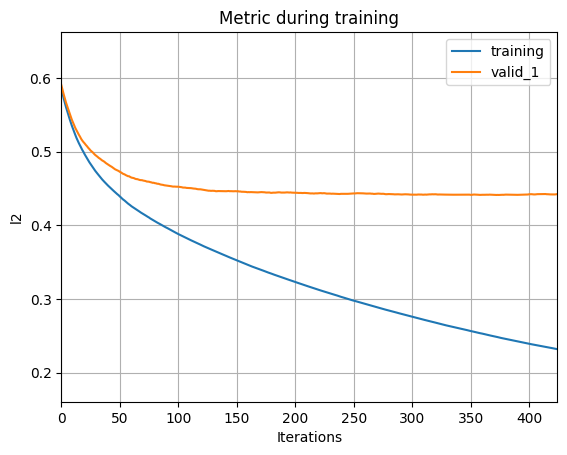

----> || Train Optimized QWK SCORE ::  0.774
----> || Val Optimized QWK SCORE ::  0.510
----> || Train Optimized Val QWK SCORE ::  0.474
----> || Val Optimized Train QWK SCORE ::  0.766
Fold 1 - Rounded Train QWK: 0.6687, Rounded Validation QWK: 0.3562


<Figure size 640x480 with 0 Axes>

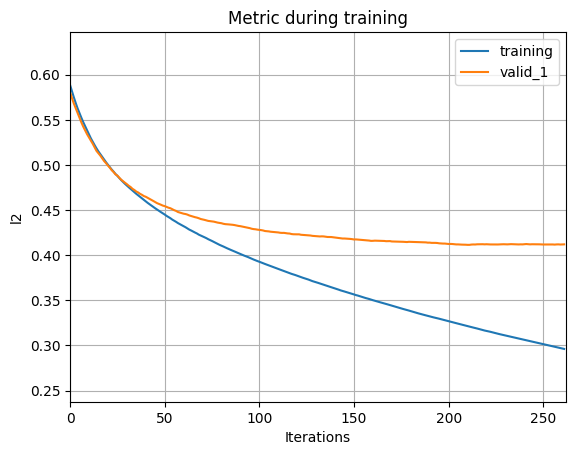

----> || Train Optimized QWK SCORE ::  0.689
----> || Val Optimized QWK SCORE ::  0.524
----> || Train Optimized Val QWK SCORE ::  0.519
----> || Val Optimized Train QWK SCORE ::  0.678
Fold 2 - Rounded Train QWK: 0.5497, Rounded Validation QWK: 0.4399


<Figure size 640x480 with 0 Axes>

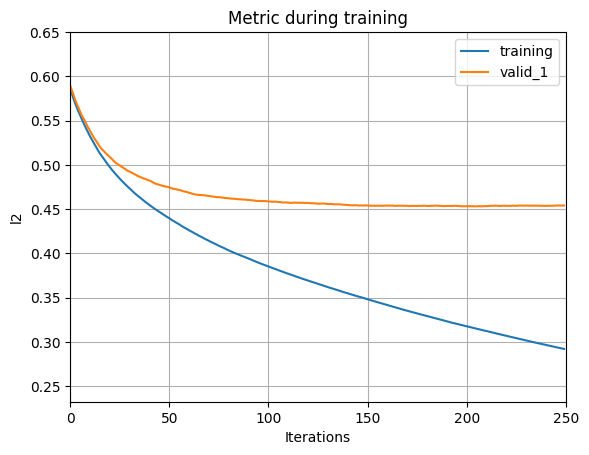

----> || Train Optimized QWK SCORE ::  0.687
----> || Val Optimized QWK SCORE ::  0.479
----> || Train Optimized Val QWK SCORE ::  0.491
----> || Val Optimized Train QWK SCORE ::  0.655
Fold 3 - Rounded Train QWK: 0.5756, Rounded Validation QWK: 0.3133


<Figure size 640x480 with 0 Axes>

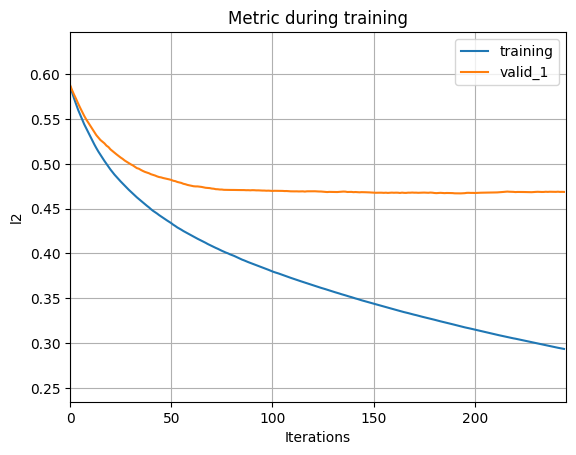

----> || Train Optimized QWK SCORE ::  0.670
----> || Val Optimized QWK SCORE ::  0.353
----> || Train Optimized Val QWK SCORE ::  0.436
----> || Val Optimized Train QWK SCORE ::  0.566
Fold 4 - Rounded Train QWK: 0.5723, Rounded Validation QWK: 0.3399


<Figure size 640x480 with 0 Axes>

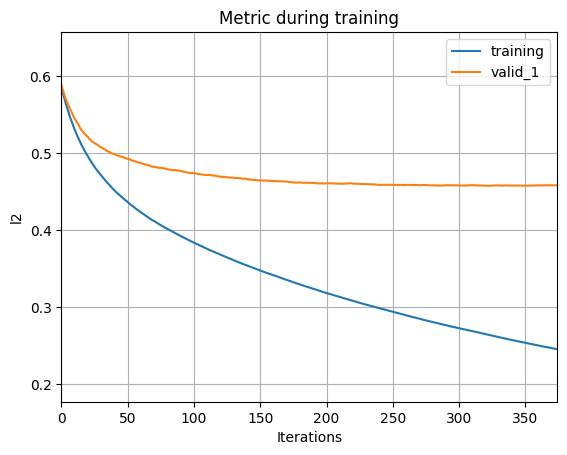

----> || Train Optimized QWK SCORE ::  0.751
----> || Val Optimized QWK SCORE ::  0.439
----> || Train Optimized Val QWK SCORE ::  0.418
----> || Val Optimized Train QWK SCORE ::  0.746
Fold 5 - Rounded Train QWK: 0.6526, Rounded Validation QWK: 0.3660
Mean Train QWK --> 0.7143
Mean Validation QWK ---> 0.4611
----> || Optimized QWK SCORE ::  0.482


In [103]:
lgb_models_list3, lgb_submission_df, lgb_raw_train_preds, lgb_raw_test_preds, lgb_optuna_study = lgb_feature_selection(
    train_selected_df3, test_selected_df3, 200
)

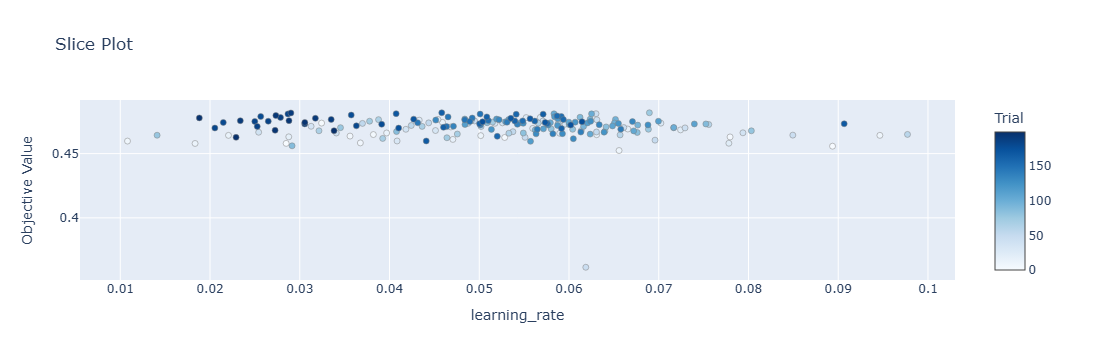

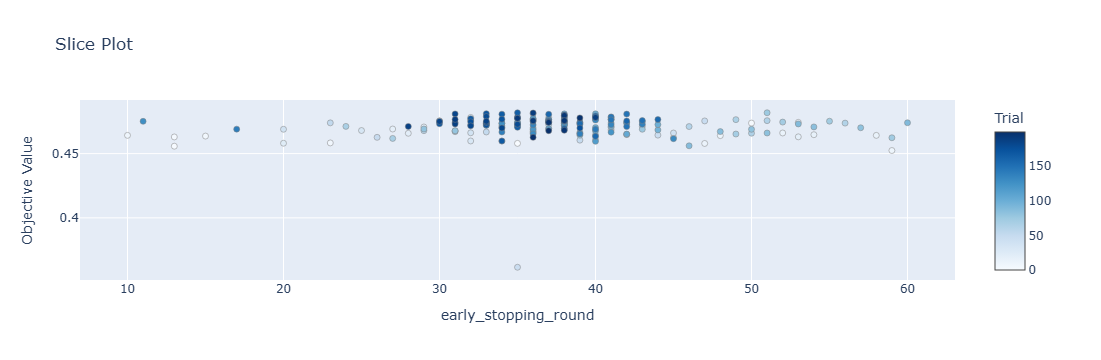

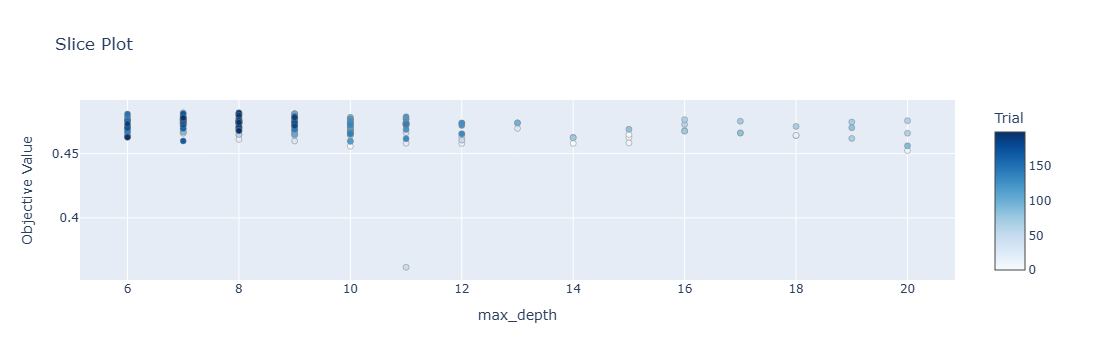

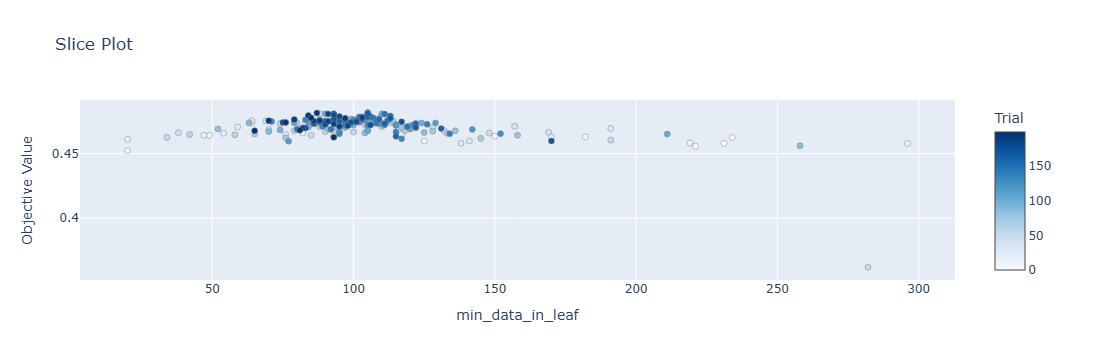

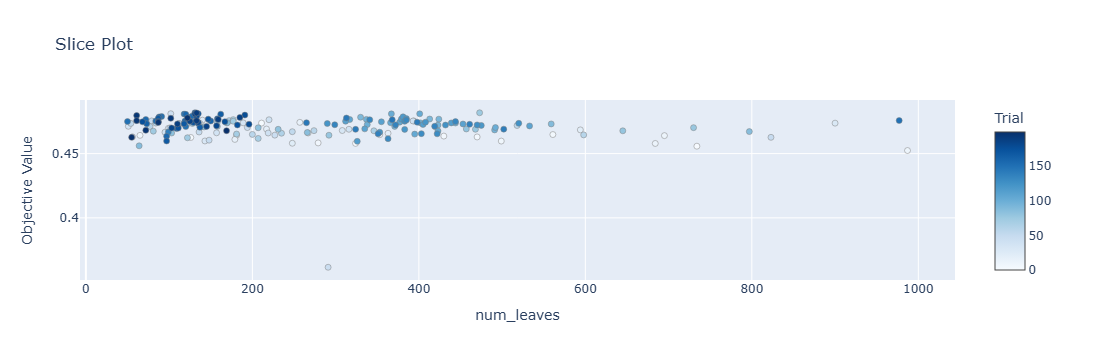

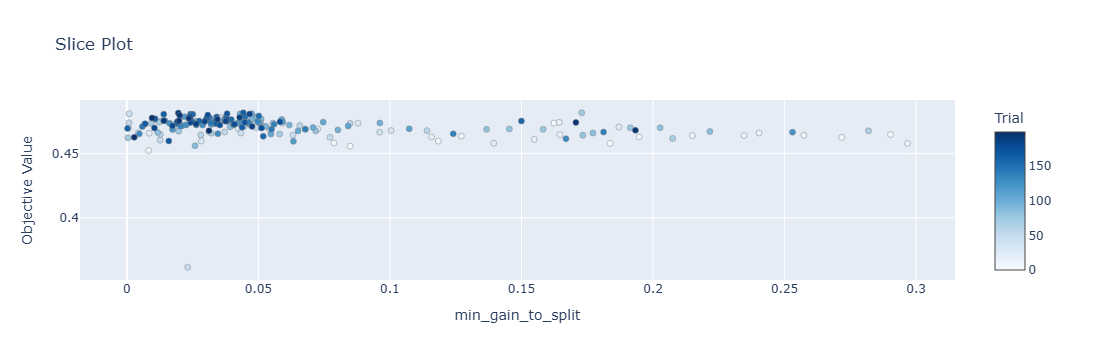

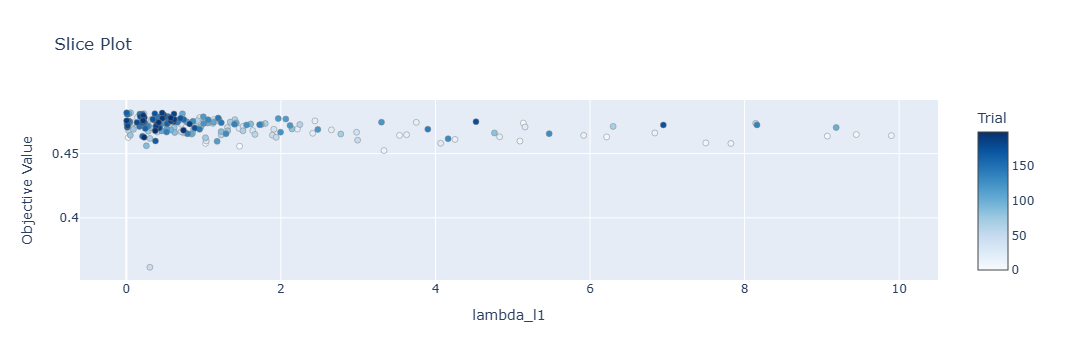

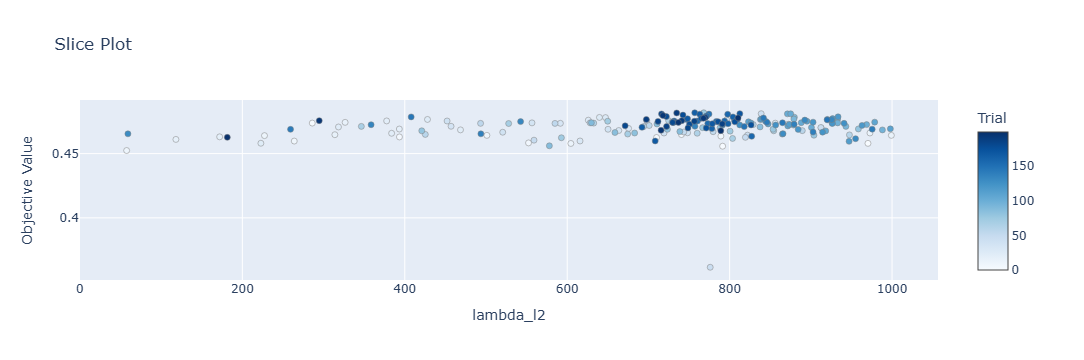

In [104]:
for param in lgb_optuna_study.best_params.keys():
    fig = plot_slice(lgb_optuna_study, params=[param])
    fig.show()

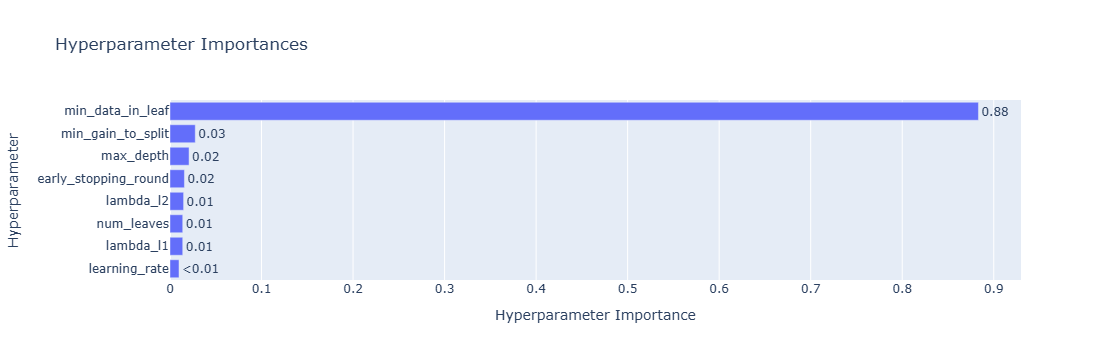

In [105]:
plot_param_importances(lgb_optuna_study)

In [106]:
lgb_optuna_study.best_params

{'learning_rate': 0.06895685131510375,
 'early_stopping_round': 51,
 'max_depth': 7,
 'min_data_in_leaf': 105,
 'num_leaves': 473,
 'min_gain_to_split': 0.1728900064878141,
 'lambda_l1': 0.054926078558585,
 'lambda_l2': 768.10946658685}

In [107]:
cols = train_selected_df3.drop(['id', 'sii'], axis=1).columns
importance_list = []
for model in lgb_models_list3:
    importance_list.append(model.feature_importances_)

importance_mean = np.mean(importance_list, axis=0)
imp_df = pd.DataFrame(sorted(zip(cols, importance_mean)), columns=['Feature', 'Importance']).sort_values('Importance', ascending=False)
unimportant_df = imp_df[imp_df['Importance'] < imp_df['Importance'].quantile(0.5)]
unimportant_cols = unimportant_df['Feature'].tolist()

In [108]:
train_selected_df4 = train_selected_df3.drop(unimportant_cols, axis=1)
print(train_selected_df4.shape)
train_selected_df4.head()

(2736, 245)


id  Basic_Demos-Age  CGAS-CGAS_Score  Physical-BMI  Physical-Height  \
0  00008ff9              5.0             51.0     16.877316             46.0   
1  000fd460              9.0             63.2     14.035590             48.0   
2  00105258             10.0             71.0     16.648696             56.5   
3  00115b9f              9.0             71.0     18.292347             56.0   
4  001f3379             13.0             50.0     22.279952             59.5   

   Physical-Weight  Physical-Waist_Circumference  Physical-HeartRate  \
0             50.8                          25.0                80.0   
1             46.0                          22.0                70.0   
2             75.6                          27.0                94.0   
3             81.6                          26.4                97.0   
4            112.2                          32.0                73.0   

   Physical-Systolic_BP  Fitness_Endurance-Max_Stage  \
0                 130.2                          4.4   
1                 122.0                          5.8   
2                 117.0                          5.0   
3                 117.0                          6.0   
4                 102.0                          4.6   

   Fitness_Endurance-Time_Sec  FGC-FGC_CU  FGC-FGC_GSND  FGC-FGC_GSD  \
0                        22.6         0.0         20.50        21.18   
1                        14.4         3.0         23.08        24.94   
2                        33.0        20.0         10.20        14.70   
3                        37.0        18.0         17.66        19.24   
4                        39.4        12.0         16.50        17.90   

   FGC-FGC_PU  BIA-BIA_BMC  BIA-BIA_FFMI  PAQ_A-PAQ_A_Total  \
0         0.0     2.668550      13.81770              1.844   
1         5.0     2.579490      12.82540              1.704   
2         7.0     4.310264      24.52766              2.578   
3         5.0     3.841910      14.07400              2.018   
4         6.0     4.330360      16.68770              2.004   

   PAQ_C-PAQ_C_Total  SDS-SDS_Total_Raw  \
0             2.6342               41.6   
1             2.3400               46.0   
2             2.1700               38.0   
3             2.4510               31.0   
4             4.1100               40.0   

   PreInt_EduHx-computerinternet_hoursday  Physical-Waist_Circumference_isnan  \
0                                     3.0                                 1.0   
1                                     0.0                                 0.0   
2                                     2.0                                 1.0   
3                                     0.0                                 1.0   
4                                     0.0                                 1.0   

       Y_3%  anglez_max  X_weekday_3_min  X_weekday_3_max  X_weekday_4_mean  \
0 -0.781337   89.296684        -1.181594         1.139090          0.029699   
1 -0.897664   89.456932        -1.175764         1.132539          0.030971   
2 -0.862860   89.528796        -1.384442         1.330352          0.013404   
3 -0.928411   89.751656        -0.973490         0.985729         -0.213124   
4 -0.823287   89.476036        -1.015088         1.006678          0.255062   

   X_weekday_4_entropy  X_weekday_5_entropy  X_weekday_6_max  \
0            39.926039            34.137011         1.078925   
1            18.003700            18.304327         1.245570   
2            72.632825            64.814719         1.400885   
3            11.136038            10.005599         1.007214   
4            13.664883            28.633865         1.005606   

   Y_weekday_2_entropy  Y_weekday_4_sum  Y_weekday_4_entropy  \
0           109.066086       609.172693            32.881972   
1            25.098020      2069.067865            53.061190   
2            37.745747     -1113.500378           132.689714   
3            16.189899      -866.483032            12.516920   
4            39.8051

In [109]:
test_selected_df4 = test_selected_df3.drop(unimportant_cols, axis=1)
print(test_selected_df4.shape)
test_selected_df4.head()

(20, 244)


id  Basic_Demos-Age  CGAS-CGAS_Score  Physical-BMI  Physical-Height  \
0  00008ff9              5.0             51.0     16.877316           46.000   
1  000fd460              9.0             63.2     14.035590           48.000   
2  00105258             10.0             71.0     16.648696           56.500   
3  00115b9f              9.0             71.0     18.292347           56.000   
4  0016bb22             18.0             65.8     22.367377           66.878   

   Physical-Weight  Physical-Waist_Circumference  Physical-HeartRate  \
0             50.8                          25.0                80.0   
1             46.0                          22.0                70.0   
2             75.6                          27.0                94.0   
3             81.6                          26.4                97.0   
4             20.0                          31.7                75.4   

   Physical-Systolic_BP  Fitness_Endurance-Max_Stage  \
0                 130.2                          4.4   
1                 122.0                          5.8   
2                 117.0                          5.0   
3                 117.0                          6.0   
4                 113.6                          4.6   

   Fitness_Endurance-Time_Sec  FGC-FGC_CU  FGC-FGC_GSND  FGC-FGC_GSD  \
0                        22.6         0.0         20.50        21.18   
1                        14.4         3.0         23.08        24.94   
2                        33.0        20.0         10.20        14.70   
3                        37.0        18.0         17.66        19.24   
4                        17.8         5.8         28.28        27.96   

   FGC-FGC_PU  BIA-BIA_BMC  BIA-BIA_FFMI  PAQ_A-PAQ_A_Total  \
0         0.0     2.668550      13.81770              1.844   
1         5.0     2.579490      12.82540              1.704   
2         7.0     4.310264      24.52766              2.578   
3         5.0     3.841910      14.07400              2.018   
4         4.2     5.477302      15.81610              1.040   

   PAQ_C-PAQ_C_Total  SDS-SDS_Total_Raw  \
0             2.6342               41.6   
1             2.3400               46.0   
2             2.1700               38.0   
3             2.4510               31.0   
4             2.2922               65.2   

   PreInt_EduHx-computerinternet_hoursday  Physical-Waist_Circumference_isnan  \
0                                     3.0                                 1.0   
1                                     0.0                                 0.0   
2                                     2.0                                 1.0   
3                                     0.0                                 1.0   
4                                     2.2                                 1.0   

       Y_3%  anglez_max  X_weekday_3_min  X_weekday_3_max  X_weekday_4_mean  \
0 -0.781337   89.296684        -1.181594         1.139090          0.029699   
1 -0.897664   89.456932        -1.175764         1.132539          0.030971   
2 -0.862860   89.528796        -1.384442         1.330352          0.013404   
3 -0.928411   89.751656        -0.973490         0.985729         -0.213124   
4 -0.868592   88.557333        -1.180735         1.299433         -0.043651   

   X_weekday_4_entropy  X_weekday_5_entropy  X_weekday_6_max  \
0            39.926039            34.137011         1.078925   
1            18.003700            18.304327         1.245570   
2            72.632825            64.814719         1.400885   
3            11.136038            10.005599         1.007214   
4            30.512318            34.729864         0.682226   

   Y_weekday_2_entropy  Y_weekday_4_sum  Y_weekday_4_entropy  \
0           109.066086       609.172693            32.881972   
1            25.098020      2069.067865            53.061190   
2            37.745747     -1113.500378           132.689714   
3            16.189899      -866.483032            12.516920   
4            57.9436

[I 2024-12-14 21:32:19,718] A new study created in memory with name: no-name-4371f921-97bd-425e-bcec-e066baab2ccb
[I 2024-12-14 21:32:32,792] Trial 0 finished with value: 0.474116840059449 and parameters: {'learning_rate': 0.013784146653832288, 'early_stopping_round': 14, 'max_depth': 18, 'min_data_in_leaf': 59, 'num_leaves': 660, 'min_gain_to_split': 0.03790133492212363, 'lambda_l1': 4.864926560018427, 'lambda_l2': 490.1328083809242}. Best is trial 0 with value: 0.474116840059449.


----> || Optimized QWK SCORE ::  0.474


[I 2024-12-14 21:32:35,410] Trial 1 finished with value: 0.4693344727817872 and parameters: {'learning_rate': 0.09738872280243169, 'early_stopping_round': 55, 'max_depth': 8, 'min_data_in_leaf': 197, 'num_leaves': 719, 'min_gain_to_split': 0.290851758970783, 'lambda_l1': 8.847718195453222, 'lambda_l2': 437.3183151876451}. Best is trial 0 with value: 0.474116840059449.


----> || Optimized QWK SCORE ::  0.469


[I 2024-12-14 21:32:39,835] Trial 2 finished with value: 0.4593343487797884 and parameters: {'learning_rate': 0.04479039987031002, 'early_stopping_round': 42, 'max_depth': 12, 'min_data_in_leaf': 244, 'num_leaves': 950, 'min_gain_to_split': 0.20096904715468542, 'lambda_l1': 3.1010362421523476, 'lambda_l2': 579.082855547008}. Best is trial 0 with value: 0.474116840059449.


----> || Optimized QWK SCORE ::  0.459


[I 2024-12-14 21:32:44,020] Trial 3 finished with value: 0.4838082998341229 and parameters: {'learning_rate': 0.042711574817687205, 'early_stopping_round': 11, 'max_depth': 14, 'min_data_in_leaf': 78, 'num_leaves': 719, 'min_gain_to_split': 0.067879009550755, 'lambda_l1': 1.441609576657601, 'lambda_l2': 138.36465929104247}. Best is trial 3 with value: 0.4838082998341229.


----> || Optimized QWK SCORE ::  0.484


[I 2024-12-14 21:32:50,269] Trial 4 finished with value: 0.4738021825283373 and parameters: {'learning_rate': 0.03072734857268198, 'early_stopping_round': 37, 'max_depth': 18, 'min_data_in_leaf': 199, 'num_leaves': 460, 'min_gain_to_split': 0.07011486507472288, 'lambda_l1': 5.547776318305599, 'lambda_l2': 951.3352385638264}. Best is trial 3 with value: 0.4838082998341229.


----> || Optimized QWK SCORE ::  0.474


[I 2024-12-14 21:32:54,100] Trial 5 finished with value: 0.473468332615252 and parameters: {'learning_rate': 0.07009953521474634, 'early_stopping_round': 52, 'max_depth': 11, 'min_data_in_leaf': 35, 'num_leaves': 332, 'min_gain_to_split': 0.2846675731581789, 'lambda_l1': 4.164163558414168, 'lambda_l2': 768.6954174398489}. Best is trial 3 with value: 0.4838082998341229.


----> || Optimized QWK SCORE ::  0.473


[I 2024-12-14 21:32:57,484] Trial 6 finished with value: 0.47559114786765777 and parameters: {'learning_rate': 0.026601882467264068, 'early_stopping_round': 12, 'max_depth': 20, 'min_data_in_leaf': 118, 'num_leaves': 226, 'min_gain_to_split': 0.09025919690344936, 'lambda_l1': 3.8084104420456475, 'lambda_l2': 53.27992743381748}. Best is trial 3 with value: 0.4838082998341229.


----> || Optimized QWK SCORE ::  0.476


[I 2024-12-14 21:33:00,780] Trial 7 finished with value: 0.45718348146459387 and parameters: {'learning_rate': 0.07284948289703032, 'early_stopping_round': 58, 'max_depth': 17, 'min_data_in_leaf': 275, 'num_leaves': 125, 'min_gain_to_split': 0.08628904785085363, 'lambda_l1': 0.07228530474741257, 'lambda_l2': 802.5656973506647}. Best is trial 3 with value: 0.4838082998341229.


----> || Optimized QWK SCORE ::  0.457


[I 2024-12-14 21:33:02,885] Trial 8 finished with value: 0.46688532196174914 and parameters: {'learning_rate': 0.05438038507228653, 'early_stopping_round': 24, 'max_depth': 15, 'min_data_in_leaf': 160, 'num_leaves': 161, 'min_gain_to_split': 0.16959986097850718, 'lambda_l1': 4.692263342899098, 'lambda_l2': 55.5305903741107}. Best is trial 3 with value: 0.4838082998341229.


----> || Optimized QWK SCORE ::  0.467


[I 2024-12-14 21:33:05,952] Trial 9 finished with value: 0.4556148357652504 and parameters: {'learning_rate': 0.060044839289963285, 'early_stopping_round': 22, 'max_depth': 13, 'min_data_in_leaf': 262, 'num_leaves': 609, 'min_gain_to_split': 0.12257752628869895, 'lambda_l1': 4.537294328875201, 'lambda_l2': 979.9113731638888}. Best is trial 3 with value: 0.4838082998341229.


----> || Optimized QWK SCORE ::  0.456


[I 2024-12-14 21:33:09,666] Trial 10 finished with value: 0.47339133183022597 and parameters: {'learning_rate': 0.09353648482378704, 'early_stopping_round': 27, 'max_depth': 6, 'min_data_in_leaf': 93, 'num_leaves': 900, 'min_gain_to_split': 0.00015277630590321278, 'lambda_l1': 0.10409694846098638, 'lambda_l2': 273.4791448300939}. Best is trial 3 with value: 0.4838082998341229.


----> || Optimized QWK SCORE ::  0.473


[I 2024-12-14 21:33:13,090] Trial 11 finished with value: 0.47027601537235175 and parameters: {'learning_rate': 0.027917583910011652, 'early_stopping_round': 11, 'max_depth': 20, 'min_data_in_leaf': 115, 'num_leaves': 409, 'min_gain_to_split': 0.10900741936742378, 'lambda_l1': 2.380341946607134, 'lambda_l2': 56.50093216802907}. Best is trial 3 with value: 0.4838082998341229.


----> || Optimized QWK SCORE ::  0.470


[I 2024-12-14 21:33:17,906] Trial 12 finished with value: 0.47909112608977356 and parameters: {'learning_rate': 0.03589447959553687, 'early_stopping_round': 18, 'max_depth': 15, 'min_data_in_leaf': 119, 'num_leaves': 778, 'min_gain_to_split': 0.03521431380383473, 'lambda_l1': 1.9627047796482535, 'lambda_l2': 166.77915285440108}. Best is trial 3 with value: 0.4838082998341229.


----> || Optimized QWK SCORE ::  0.479


[I 2024-12-14 21:33:22,908] Trial 13 finished with value: 0.48312470998652657 and parameters: {'learning_rate': 0.042339387993753363, 'early_stopping_round': 19, 'max_depth': 15, 'min_data_in_leaf': 74, 'num_leaves': 799, 'min_gain_to_split': 0.0009356370980896089, 'lambda_l1': 1.6576202465892909, 'lambda_l2': 258.08612093904287}. Best is trial 3 with value: 0.4838082998341229.


----> || Optimized QWK SCORE ::  0.483


[I 2024-12-14 21:33:29,809] Trial 14 finished with value: 0.4839728618290592 and parameters: {'learning_rate': 0.04767425765381197, 'early_stopping_round': 32, 'max_depth': 10, 'min_data_in_leaf': 66, 'num_leaves': 826, 'min_gain_to_split': 0.008174667155067669, 'lambda_l1': 1.2116708748224339, 'lambda_l2': 314.21357446938794}. Best is trial 14 with value: 0.4839728618290592.


----> || Optimized QWK SCORE ::  0.484


[I 2024-12-14 21:33:37,393] Trial 15 finished with value: 0.47615585525651305 and parameters: {'learning_rate': 0.05439287236024391, 'early_stopping_round': 31, 'max_depth': 10, 'min_data_in_leaf': 36, 'num_leaves': 565, 'min_gain_to_split': 0.04180853126253198, 'lambda_l1': 6.67264780158591, 'lambda_l2': 352.64339630063523}. Best is trial 14 with value: 0.4839728618290592.


----> || Optimized QWK SCORE ::  0.476


[I 2024-12-14 21:33:46,177] Trial 16 finished with value: 0.37619563311827575 and parameters: {'learning_rate': 0.013854054482157166, 'early_stopping_round': 47, 'max_depth': 9, 'min_data_in_leaf': 153, 'num_leaves': 1000, 'min_gain_to_split': 0.15019286678217345, 'lambda_l1': 1.0071024458341773, 'lambda_l2': 227.85731575547436}. Best is trial 14 with value: 0.4839728618290592.


----> || Optimized QWK SCORE ::  0.376


[I 2024-12-14 21:33:50,020] Trial 17 finished with value: 0.47159945721112717 and parameters: {'learning_rate': 0.07088851661314881, 'early_stopping_round': 37, 'max_depth': 7, 'min_data_in_leaf': 80, 'num_leaves': 852, 'min_gain_to_split': 0.23426791900744598, 'lambda_l1': 9.96472175020783, 'lambda_l2': 626.9218553103381}. Best is trial 14 with value: 0.4839728618290592.


----> || Optimized QWK SCORE ::  0.472


[I 2024-12-14 21:33:57,740] Trial 18 finished with value: 0.478030929214011 and parameters: {'learning_rate': 0.08330871233331755, 'early_stopping_round': 31, 'max_depth': 13, 'min_data_in_leaf': 21, 'num_leaves': 690, 'min_gain_to_split': 0.05831662799968342, 'lambda_l1': 3.157796296501884, 'lambda_l2': 355.10713602567444}. Best is trial 14 with value: 0.4839728618290592.


----> || Optimized QWK SCORE ::  0.478


[I 2024-12-14 21:34:01,853] Trial 19 finished with value: 0.4720522417067402 and parameters: {'learning_rate': 0.046342865441084825, 'early_stopping_round': 44, 'max_depth': 10, 'min_data_in_leaf': 155, 'num_leaves': 504, 'min_gain_to_split': 0.014362052622692112, 'lambda_l1': 6.613018028932869, 'lambda_l2': 151.0804192292151}. Best is trial 14 with value: 0.4839728618290592.


----> || Optimized QWK SCORE ::  0.472


[I 2024-12-14 21:34:07,849] Trial 20 finished with value: 0.480938630455897 and parameters: {'learning_rate': 0.06218992195940579, 'early_stopping_round': 30, 'max_depth': 13, 'min_data_in_leaf': 55, 'num_leaves': 787, 'min_gain_to_split': 0.11598174640126874, 'lambda_l1': 0.965779242403621, 'lambda_l2': 371.02139354119}. Best is trial 14 with value: 0.4839728618290592.


----> || Optimized QWK SCORE ::  0.481


[I 2024-12-14 21:34:14,054] Trial 21 finished with value: 0.4805308353454686 and parameters: {'learning_rate': 0.04120777243458208, 'early_stopping_round': 18, 'max_depth': 15, 'min_data_in_leaf': 83, 'num_leaves': 829, 'min_gain_to_split': 0.00014435299517234833, 'lambda_l1': 1.661795133678218, 'lambda_l2': 281.91544970166143}. Best is trial 14 with value: 0.4839728618290592.


----> || Optimized QWK SCORE ::  0.481


[I 2024-12-14 21:34:19,016] Trial 22 finished with value: 0.4785749632345254 and parameters: {'learning_rate': 0.049073467922383665, 'early_stopping_round': 17, 'max_depth': 16, 'min_data_in_leaf': 60, 'num_leaves': 763, 'min_gain_to_split': 0.027109447481689676, 'lambda_l1': 0.9541093118830327, 'lambda_l2': 173.78682614244764}. Best is trial 14 with value: 0.4839728618290592.


----> || Optimized QWK SCORE ::  0.479


[I 2024-12-14 21:34:24,680] Trial 23 finished with value: 0.4742110634392809 and parameters: {'learning_rate': 0.036164016163336025, 'early_stopping_round': 22, 'max_depth': 14, 'min_data_in_leaf': 93, 'num_leaves': 886, 'min_gain_to_split': 0.06208805239910141, 'lambda_l1': 2.7505172846659995, 'lambda_l2': 246.59493098117997}. Best is trial 14 with value: 0.4839728618290592.


----> || Optimized QWK SCORE ::  0.474


[I 2024-12-14 21:34:30,750] Trial 24 finished with value: 0.46783867724276607 and parameters: {'learning_rate': 0.022280511584262943, 'early_stopping_round': 10, 'max_depth': 11, 'min_data_in_leaf': 121, 'num_leaves': 640, 'min_gain_to_split': 0.018650104803658182, 'lambda_l1': 1.542756732053448, 'lambda_l2': 432.55757119761023}. Best is trial 14 with value: 0.4839728618290592.


----> || Optimized QWK SCORE ::  0.468


[I 2024-12-14 21:34:36,840] Trial 25 finished with value: 0.48514478855298293 and parameters: {'learning_rate': 0.03737231758477148, 'early_stopping_round': 15, 'max_depth': 12, 'min_data_in_leaf': 59, 'num_leaves': 752, 'min_gain_to_split': 0.052900931964179845, 'lambda_l1': 0.5047756528364218, 'lambda_l2': 135.61113117636017}. Best is trial 25 with value: 0.48514478855298293.


----> || Optimized QWK SCORE ::  0.485


[I 2024-12-14 21:34:43,184] Trial 26 finished with value: 0.4744912708955177 and parameters: {'learning_rate': 0.03635632822816879, 'early_stopping_round': 15, 'max_depth': 11, 'min_data_in_leaf': 45, 'num_leaves': 721, 'min_gain_to_split': 0.09061699084556893, 'lambda_l1': 0.42067215636871136, 'lambda_l2': 128.8973556634397}. Best is trial 25 with value: 0.48514478855298293.


----> || Optimized QWK SCORE ::  0.474


[I 2024-12-14 21:34:56,730] Trial 27 finished with value: 0.4677583900938954 and parameters: {'learning_rate': 0.019894872577375454, 'early_stopping_round': 25, 'max_depth': 9, 'min_data_in_leaf': 24, 'num_leaves': 543, 'min_gain_to_split': 0.0556873186108168, 'lambda_l1': 2.5345551612654877, 'lambda_l2': 128.17942092419455}. Best is trial 25 with value: 0.48514478855298293.


----> || Optimized QWK SCORE ::  0.468


[I 2024-12-14 21:35:01,098] Trial 28 finished with value: 0.47101298927963686 and parameters: {'learning_rate': 0.0498713016754873, 'early_stopping_round': 34, 'max_depth': 12, 'min_data_in_leaf': 185, 'num_leaves': 919, 'min_gain_to_split': 0.14836092166750386, 'lambda_l1': 3.5049717478513376, 'lambda_l2': 320.83656701884786}. Best is trial 25 with value: 0.48514478855298293.


----> || Optimized QWK SCORE ::  0.471


[I 2024-12-14 21:35:05,384] Trial 29 finished with value: 0.47522299027377857 and parameters: {'learning_rate': 0.06203167332252504, 'early_stopping_round': 15, 'max_depth': 12, 'min_data_in_leaf': 65, 'num_leaves': 633, 'min_gain_to_split': 0.03936605180461151, 'lambda_l1': 0.9575742701902461, 'lambda_l2': 515.6485031962467}. Best is trial 25 with value: 0.48514478855298293.


----> || Optimized QWK SCORE ::  0.475


[I 2024-12-14 21:35:14,017] Trial 30 finished with value: 0.4734336419682498 and parameters: {'learning_rate': 0.014138570006800827, 'early_stopping_round': 13, 'max_depth': 8, 'min_data_in_leaf': 103, 'num_leaves': 997, 'min_gain_to_split': 0.07626786892204562, 'lambda_l1': 5.392727677697569, 'lambda_l2': 199.70497832062682}. Best is trial 25 with value: 0.48514478855298293.


----> || Optimized QWK SCORE ::  0.473


[I 2024-12-14 21:35:19,414] Trial 31 finished with value: 0.4799041221095849 and parameters: {'learning_rate': 0.04153911995627243, 'early_stopping_round': 20, 'max_depth': 14, 'min_data_in_leaf': 75, 'num_leaves': 837, 'min_gain_to_split': 0.01749944490630102, 'lambda_l1': 1.7363665822271657, 'lambda_l2': 297.26801999424555}. Best is trial 25 with value: 0.48514478855298293.


----> || Optimized QWK SCORE ::  0.480


[I 2024-12-14 21:35:23,468] Trial 32 finished with value: 0.4685383391210154 and parameters: {'learning_rate': 0.032076349952551875, 'early_stopping_round': 10, 'max_depth': 16, 'min_data_in_leaf': 141, 'num_leaves': 720, 'min_gain_to_split': 0.04443021755274178, 'lambda_l1': 2.2417326315541266, 'lambda_l2': 410.76963654349333}. Best is trial 25 with value: 0.48514478855298293.


----> || Optimized QWK SCORE ::  0.469


[I 2024-12-14 21:35:28,792] Trial 33 finished with value: 0.4791067348093192 and parameters: {'learning_rate': 0.04204257771617594, 'early_stopping_round': 15, 'max_depth': 14, 'min_data_in_leaf': 51, 'num_leaves': 778, 'min_gain_to_split': 0.01061121487444705, 'lambda_l1': 0.6440988529887814, 'lambda_l2': 107.46132635466938}. Best is trial 25 with value: 0.48514478855298293.


----> || Optimized QWK SCORE ::  0.479


[I 2024-12-14 21:35:33,827] Trial 34 finished with value: 0.48182491686271167 and parameters: {'learning_rate': 0.05099558542307299, 'early_stopping_round': 27, 'max_depth': 18, 'min_data_in_leaf': 70, 'num_leaves': 682, 'min_gain_to_split': 0.02732712160288466, 'lambda_l1': 1.3634240062581329, 'lambda_l2': 208.86860006482806}. Best is trial 25 with value: 0.48514478855298293.


----> || Optimized QWK SCORE ::  0.482


[I 2024-12-14 21:35:38,643] Trial 35 finished with value: 0.47347527530237754 and parameters: {'learning_rate': 0.03842055143344212, 'early_stopping_round': 20, 'max_depth': 16, 'min_data_in_leaf': 96, 'num_leaves': 593, 'min_gain_to_split': 0.051572370111977135, 'lambda_l1': 3.038691495809317, 'lambda_l2': 223.71948269140893}. Best is trial 25 with value: 0.48514478855298293.


----> || Optimized QWK SCORE ::  0.473


[I 2024-12-14 21:35:42,616] Trial 36 finished with value: 0.45596637551717345 and parameters: {'learning_rate': 0.04516325750255885, 'early_stopping_round': 40, 'max_depth': 10, 'min_data_in_leaf': 234, 'num_leaves': 834, 'min_gain_to_split': 0.23850007365432324, 'lambda_l1': 7.680342276372345, 'lambda_l2': 607.7019795456174}. Best is trial 25 with value: 0.48514478855298293.


----> || Optimized QWK SCORE ::  0.456


[I 2024-12-14 21:35:47,873] Trial 37 finished with value: 0.4792034237053274 and parameters: {'learning_rate': 0.03204283860753576, 'early_stopping_round': 49, 'max_depth': 12, 'min_data_in_leaf': 137, 'num_leaves': 944, 'min_gain_to_split': 0.06970480003322392, 'lambda_l1': 0.10124802193319371, 'lambda_l2': 108.12796901062137}. Best is trial 25 with value: 0.48514478855298293.


----> || Optimized QWK SCORE ::  0.479


[I 2024-12-14 21:35:59,849] Trial 38 finished with value: 0.46641857539703335 and parameters: {'learning_rate': 0.021822948322619853, 'early_stopping_round': 13, 'max_depth': 18, 'min_data_in_leaf': 38, 'num_leaves': 734, 'min_gain_to_split': 0.10313117040423428, 'lambda_l1': 3.801613412737123, 'lambda_l2': 488.3314370050593}. Best is trial 25 with value: 0.48514478855298293.


----> || Optimized QWK SCORE ::  0.466


[I 2024-12-14 21:36:03,445] Trial 39 finished with value: 0.4690754008557103 and parameters: {'learning_rate': 0.058241037277400626, 'early_stopping_round': 21, 'max_depth': 13, 'min_data_in_leaf': 181, 'num_leaves': 432, 'min_gain_to_split': 0.00036834480940636013, 'lambda_l1': 1.3422004353448194, 'lambda_l2': 676.7320432453158}. Best is trial 25 with value: 0.48514478855298293.


----> || Optimized QWK SCORE ::  0.469


[I 2024-12-14 21:36:05,853] Trial 40 finished with value: 0.45759205626810096 and parameters: {'learning_rate': 0.06452002733579085, 'early_stopping_round': 25, 'max_depth': 11, 'min_data_in_leaf': 299, 'num_leaves': 674, 'min_gain_to_split': 0.08253344580520633, 'lambda_l1': 2.0956207308737023, 'lambda_l2': 87.43543639150978}. Best is trial 25 with value: 0.48514478855298293.


----> || Optimized QWK SCORE ::  0.458


[I 2024-12-14 21:36:10,755] Trial 41 finished with value: 0.4777493436139453 and parameters: {'learning_rate': 0.052767725373984595, 'early_stopping_round': 28, 'max_depth': 19, 'min_data_in_leaf': 69, 'num_leaves': 675, 'min_gain_to_split': 0.027627736977728332, 'lambda_l1': 1.4512255792909516, 'lambda_l2': 194.6352836692162}. Best is trial 25 with value: 0.48514478855298293.


----> || Optimized QWK SCORE ::  0.478


[I 2024-12-14 21:36:17,048] Trial 42 finished with value: 0.4810915193452723 and parameters: {'learning_rate': 0.04908744432436474, 'early_stopping_round': 34, 'max_depth': 17, 'min_data_in_leaf': 78, 'num_leaves': 808, 'min_gain_to_split': 0.028884085778528062, 'lambda_l1': 0.6440478101703389, 'lambda_l2': 254.22951132397222}. Best is trial 25 with value: 0.48514478855298293.


----> || Optimized QWK SCORE ::  0.481


[I 2024-12-14 21:36:21,990] Trial 43 finished with value: 0.47998096009181856 and parameters: {'learning_rate': 0.05677950879454044, 'early_stopping_round': 27, 'max_depth': 17, 'min_data_in_leaf': 109, 'num_leaves': 880, 'min_gain_to_split': 0.04673149102159934, 'lambda_l1': 1.259978117709932, 'lambda_l2': 321.75489462124995}. Best is trial 25 with value: 0.48514478855298293.


----> || Optimized QWK SCORE ::  0.480


[I 2024-12-14 21:36:30,425] Trial 44 finished with value: 0.4821807503928609 and parameters: {'learning_rate': 0.04509523687545667, 'early_stopping_round': 17, 'max_depth': 19, 'min_data_in_leaf': 51, 'num_leaves': 743, 'min_gain_to_split': 0.013008798306598957, 'lambda_l1': 0.4901070287244925, 'lambda_l2': 884.4272842089493}. Best is trial 25 with value: 0.48514478855298293.


----> || Optimized QWK SCORE ::  0.482


[I 2024-12-14 21:36:40,995] Trial 45 finished with value: 0.4788730754000605 and parameters: {'learning_rate': 0.029306625423534308, 'early_stopping_round': 17, 'max_depth': 19, 'min_data_in_leaf': 48, 'num_leaves': 298, 'min_gain_to_split': 0.011351903219653726, 'lambda_l1': 0.07047267664998291, 'lambda_l2': 870.9486403697513}. Best is trial 25 with value: 0.48514478855298293.


----> || Optimized QWK SCORE ::  0.479


[I 2024-12-14 21:36:47,697] Trial 46 finished with value: 0.4703762879281417 and parameters: {'learning_rate': 0.04357213777399797, 'early_stopping_round': 12, 'max_depth': 14, 'min_data_in_leaf': 34, 'num_leaves': 60, 'min_gain_to_split': 0.13141716950597754, 'lambda_l1': 0.49921111877591295, 'lambda_l2': 723.4535850645442}. Best is trial 25 with value: 0.48514478855298293.


----> || Optimized QWK SCORE ::  0.470


[I 2024-12-14 21:36:55,699] Trial 47 finished with value: 0.4789649614348612 and parameters: {'learning_rate': 0.03947182803617229, 'early_stopping_round': 59, 'max_depth': 20, 'min_data_in_leaf': 132, 'num_leaves': 737, 'min_gain_to_split': 0.10010242131750495, 'lambda_l1': 2.017451511076734, 'lambda_l2': 860.6638479147828}. Best is trial 25 with value: 0.48514478855298293.


----> || Optimized QWK SCORE ::  0.479


[I 2024-12-14 21:37:02,135] Trial 48 finished with value: 0.47400759280117033 and parameters: {'learning_rate': 0.033903930354469286, 'early_stopping_round': 23, 'max_depth': 9, 'min_data_in_leaf': 59, 'num_leaves': 499, 'min_gain_to_split': 0.1904239463366422, 'lambda_l1': 2.861143662199299, 'lambda_l2': 478.92525710782945}. Best is trial 25 with value: 0.48514478855298293.


----> || Optimized QWK SCORE ::  0.474


[I 2024-12-14 21:37:09,199] Trial 49 finished with value: 0.4741084438990719 and parameters: {'learning_rate': 0.02602651289737197, 'early_stopping_round': 18, 'max_depth': 19, 'min_data_in_leaf': 89, 'num_leaves': 865, 'min_gain_to_split': 0.05925614629177341, 'lambda_l1': 0.4542469706829043, 'lambda_l2': 569.7305129512217}. Best is trial 25 with value: 0.48514478855298293.


----> || Optimized QWK SCORE ::  0.474


[I 2024-12-14 21:37:22,280] Trial 50 finished with value: 0.4658101560308652 and parameters: {'learning_rate': 0.04627642744512704, 'early_stopping_round': 54, 'max_depth': 15, 'min_data_in_leaf': 24, 'num_leaves': 938, 'min_gain_to_split': 0.03769222623108057, 'lambda_l1': 4.1168473560659855, 'lambda_l2': 371.53766058486156}. Best is trial 25 with value: 0.48514478855298293.


----> || Optimized QWK SCORE ::  0.466


[I 2024-12-14 21:37:26,999] Trial 51 finished with value: 0.47903385012728117 and parameters: {'learning_rate': 0.05277439388990905, 'early_stopping_round': 28, 'max_depth': 18, 'min_data_in_leaf': 65, 'num_leaves': 684, 'min_gain_to_split': 0.02177211115803103, 'lambda_l1': 1.1713076443671873, 'lambda_l2': 195.7510315713373}. Best is trial 25 with value: 0.48514478855298293.


----> || Optimized QWK SCORE ::  0.479


[I 2024-12-14 21:37:34,006] Trial 52 finished with value: 0.4852220123155906 and parameters: {'learning_rate': 0.06699822880458184, 'early_stopping_round': 36, 'max_depth': 17, 'min_data_in_leaf': 74, 'num_leaves': 766, 'min_gain_to_split': 0.008376505502021785, 'lambda_l1': 1.7760838737969231, 'lambda_l2': 999.3648362114651}. Best is trial 52 with value: 0.4852220123155906.


----> || Optimized QWK SCORE ::  0.485


[I 2024-12-14 21:37:40,067] Trial 53 finished with value: 0.4859382819015847 and parameters: {'learning_rate': 0.07772496739101446, 'early_stopping_round': 42, 'max_depth': 17, 'min_data_in_leaf': 104, 'num_leaves': 755, 'min_gain_to_split': 0.0014547935112604196, 'lambda_l1': 1.8251905559734007, 'lambda_l2': 988.8913664604664}. Best is trial 53 with value: 0.4859382819015847.


----> || Optimized QWK SCORE ::  0.486


[I 2024-12-14 21:37:46,052] Trial 54 finished with value: 0.47858005074766585 and parameters: {'learning_rate': 0.07824848188404596, 'early_stopping_round': 42, 'max_depth': 17, 'min_data_in_leaf': 101, 'num_leaves': 805, 'min_gain_to_split': 0.0017293494004299575, 'lambda_l1': 2.4205345626474895, 'lambda_l2': 992.127938294385}. Best is trial 53 with value: 0.4859382819015847.


----> || Optimized QWK SCORE ::  0.479


[I 2024-12-14 21:37:50,013] Trial 55 finished with value: 0.4793800608351516 and parameters: {'learning_rate': 0.08982657926883664, 'early_stopping_round': 37, 'max_depth': 16, 'min_data_in_leaf': 85, 'num_leaves': 762, 'min_gain_to_split': 0.29635227347076193, 'lambda_l1': 1.8172672443104578, 'lambda_l2': 954.7590115434533}. Best is trial 53 with value: 0.4859382819015847.


----> || Optimized QWK SCORE ::  0.479


[I 2024-12-14 21:37:55,584] Trial 56 finished with value: 0.4820056611403154 and parameters: {'learning_rate': 0.06649456284980718, 'early_stopping_round': 39, 'max_depth': 15, 'min_data_in_leaf': 118, 'num_leaves': 625, 'min_gain_to_split': 0.03516818243700628, 'lambda_l1': 3.23131827493215, 'lambda_l2': 932.6222778319487}. Best is trial 53 with value: 0.4859382819015847.


----> || Optimized QWK SCORE ::  0.482


[I 2024-12-14 21:38:01,720] Trial 57 finished with value: 0.489355415669787 and parameters: {'learning_rate': 0.07952294613235088, 'early_stopping_round': 45, 'max_depth': 17, 'min_data_in_leaf': 79, 'num_leaves': 807, 'min_gain_to_split': 0.007626671165479392, 'lambda_l1': 1.851403008065447, 'lambda_l2': 795.1359414277595}. Best is trial 57 with value: 0.489355415669787.


----> || Optimized QWK SCORE ::  0.489


[I 2024-12-14 21:38:08,138] Trial 58 finished with value: 0.49121991808858967 and parameters: {'learning_rate': 0.07584093222785224, 'early_stopping_round': 47, 'max_depth': 17, 'min_data_in_leaf': 110, 'num_leaves': 902, 'min_gain_to_split': 0.06762318941845426, 'lambda_l1': 2.3325256647708352, 'lambda_l2': 829.5801116526322}. Best is trial 58 with value: 0.49121991808858967.


----> || Optimized QWK SCORE ::  0.491


[I 2024-12-14 21:38:14,693] Trial 59 finished with value: 0.4863832261781186 and parameters: {'learning_rate': 0.07621916845051903, 'early_stopping_round': 45, 'max_depth': 17, 'min_data_in_leaf': 106, 'num_leaves': 966, 'min_gain_to_split': 0.049878185428837325, 'lambda_l1': 2.66895805351621, 'lambda_l2': 829.3002959373249}. Best is trial 58 with value: 0.49121991808858967.


----> || Optimized QWK SCORE ::  0.486


[I 2024-12-14 21:38:20,790] Trial 60 finished with value: 0.4843444670840992 and parameters: {'learning_rate': 0.07528749821842767, 'early_stopping_round': 46, 'max_depth': 17, 'min_data_in_leaf': 128, 'num_leaves': 904, 'min_gain_to_split': 0.0634399716864399, 'lambda_l1': 3.4695814580876707, 'lambda_l2': 828.0183197974815}. Best is trial 58 with value: 0.49121991808858967.


----> || Optimized QWK SCORE ::  0.484


[I 2024-12-14 21:38:25,835] Trial 61 finished with value: 0.4815120607557457 and parameters: {'learning_rate': 0.078566885737514, 'early_stopping_round': 45, 'max_depth': 17, 'min_data_in_leaf': 110, 'num_leaves': 972, 'min_gain_to_split': 0.07178752855006279, 'lambda_l1': 3.450275053825876, 'lambda_l2': 783.2440812037652}. Best is trial 58 with value: 0.49121991808858967.


----> || Optimized QWK SCORE ::  0.482


[I 2024-12-14 21:38:32,075] Trial 62 finished with value: 0.48375749659215017 and parameters: {'learning_rate': 0.07498493853254128, 'early_stopping_round': 48, 'max_depth': 18, 'min_data_in_leaf': 127, 'num_leaves': 915, 'min_gain_to_split': 0.04738433832515164, 'lambda_l1': 2.7128791050135743, 'lambda_l2': 826.8869851426473}. Best is trial 58 with value: 0.49121991808858967.


----> || Optimized QWK SCORE ::  0.484


[I 2024-12-14 21:38:36,826] Trial 63 finished with value: 0.47969251623029185 and parameters: {'learning_rate': 0.08528413650399669, 'early_stopping_round': 45, 'max_depth': 16, 'min_data_in_leaf': 142, 'num_leaves': 906, 'min_gain_to_split': 0.08903325307291557, 'lambda_l1': 4.371856689392179, 'lambda_l2': 908.0033128522257}. Best is trial 58 with value: 0.49121991808858967.


----> || Optimized QWK SCORE ::  0.480


[I 2024-12-14 21:38:42,121] Trial 64 finished with value: 0.4755193744722971 and parameters: {'learning_rate': 0.0685038839756562, 'early_stopping_round': 50, 'max_depth': 17, 'min_data_in_leaf': 104, 'num_leaves': 969, 'min_gain_to_split': 0.05784508312261934, 'lambda_l1': 2.340273884890887, 'lambda_l2': 746.7070246266667}. Best is trial 58 with value: 0.49121991808858967.


----> || Optimized QWK SCORE ::  0.476


[I 2024-12-14 21:38:46,158] Trial 65 finished with value: 0.4683091909940835 and parameters: {'learning_rate': 0.07449439504886074, 'early_stopping_round': 42, 'max_depth': 17, 'min_data_in_leaf': 162, 'num_leaves': 864, 'min_gain_to_split': 0.06591932785619861, 'lambda_l1': 2.630698650066053, 'lambda_l2': 829.9640875956223}. Best is trial 58 with value: 0.49121991808858967.


----> || Optimized QWK SCORE ::  0.468


[I 2024-12-14 21:38:51,560] Trial 66 finished with value: 0.49302580006586305 and parameters: {'learning_rate': 0.09977751235816837, 'early_stopping_round': 53, 'max_depth': 18, 'min_data_in_leaf': 92, 'num_leaves': 900, 'min_gain_to_split': 0.08026757726451449, 'lambda_l1': 3.852890422965741, 'lambda_l2': 694.5661560799599}. Best is trial 66 with value: 0.49302580006586305.


----> || Optimized QWK SCORE ::  0.493


[I 2024-12-14 21:38:56,431] Trial 67 finished with value: 0.4851488977341468 and parameters: {'learning_rate': 0.09894344042040551, 'early_stopping_round': 52, 'max_depth': 18, 'min_data_in_leaf': 91, 'num_leaves': 855, 'min_gain_to_split': 0.03468228882274992, 'lambda_l1': 4.001614691543694, 'lambda_l2': 712.2995455473531}. Best is trial 66 with value: 0.49302580006586305.


----> || Optimized QWK SCORE ::  0.485


[I 2024-12-14 21:39:01,323] Trial 68 finished with value: 0.48617044966592404 and parameters: {'learning_rate': 0.09284886443203673, 'early_stopping_round': 52, 'max_depth': 18, 'min_data_in_leaf': 92, 'num_leaves': 958, 'min_gain_to_split': 0.020963263651194816, 'lambda_l1': 5.09571602518783, 'lambda_l2': 708.676672106988}. Best is trial 66 with value: 0.49302580006586305.


----> || Optimized QWK SCORE ::  0.486


[I 2024-12-14 21:39:06,721] Trial 69 finished with value: 0.48994095840649143 and parameters: {'learning_rate': 0.0958692168650123, 'early_stopping_round': 55, 'max_depth': 20, 'min_data_in_leaf': 82, 'num_leaves': 960, 'min_gain_to_split': 0.00760405666843218, 'lambda_l1': 4.925919231991652, 'lambda_l2': 666.9375228299767}. Best is trial 66 with value: 0.49302580006586305.


----> || Optimized QWK SCORE ::  0.490


[I 2024-12-14 21:39:12,254] Trial 70 finished with value: 0.4864271687651611 and parameters: {'learning_rate': 0.09540967241208123, 'early_stopping_round': 57, 'max_depth': 20, 'min_data_in_leaf': 114, 'num_leaves': 980, 'min_gain_to_split': 0.019238152001533268, 'lambda_l1': 5.335126807103771, 'lambda_l2': 673.7371339974557}. Best is trial 66 with value: 0.49302580006586305.


----> || Optimized QWK SCORE ::  0.486


[I 2024-12-14 21:39:17,347] Trial 71 finished with value: 0.48295465381381275 and parameters: {'learning_rate': 0.09482463519244354, 'early_stopping_round': 55, 'max_depth': 20, 'min_data_in_leaf': 99, 'num_leaves': 974, 'min_gain_to_split': 0.01948305179640724, 'lambda_l1': 5.03264731228888, 'lambda_l2': 672.7783818685948}. Best is trial 66 with value: 0.49302580006586305.


----> || Optimized QWK SCORE ::  0.483


[I 2024-12-14 21:39:22,649] Trial 72 finished with value: 0.482115531752104 and parameters: {'learning_rate': 0.09016685510893452, 'early_stopping_round': 57, 'max_depth': 19, 'min_data_in_leaf': 110, 'num_leaves': 989, 'min_gain_to_split': 0.022854870980357836, 'lambda_l1': 6.001246092738876, 'lambda_l2': 666.9474248184074}. Best is trial 66 with value: 0.49302580006586305.


----> || Optimized QWK SCORE ::  0.482


[I 2024-12-14 21:39:28,243] Trial 73 finished with value: 0.48222870462382494 and parameters: {'learning_rate': 0.09597545532195231, 'early_stopping_round': 52, 'max_depth': 20, 'min_data_in_leaf': 85, 'num_leaves': 942, 'min_gain_to_split': 0.0072691471543184175, 'lambda_l1': 4.885498918653078, 'lambda_l2': 755.528545751548}. Best is trial 66 with value: 0.49302580006586305.


----> || Optimized QWK SCORE ::  0.482


[I 2024-12-14 21:39:34,254] Trial 74 finished with value: 0.48244424258993057 and parameters: {'learning_rate': 0.08450164705735429, 'early_stopping_round': 56, 'max_depth': 18, 'min_data_in_leaf': 123, 'num_leaves': 938, 'min_gain_to_split': 0.042781163829173983, 'lambda_l1': 5.772630272148765, 'lambda_l2': 802.1912248712526}. Best is trial 66 with value: 0.49302580006586305.


----> || Optimized QWK SCORE ::  0.482


[I 2024-12-14 21:39:39,291] Trial 75 finished with value: 0.48015288403474177 and parameters: {'learning_rate': 0.09157764318027786, 'early_stopping_round': 50, 'max_depth': 19, 'min_data_in_leaf': 115, 'num_leaves': 885, 'min_gain_to_split': 0.03160240860048404, 'lambda_l1': 5.14167477614241, 'lambda_l2': 715.9582490273393}. Best is trial 66 with value: 0.49302580006586305.


----> || Optimized QWK SCORE ::  0.480


[I 2024-12-14 21:39:44,934] Trial 76 finished with value: 0.4822188071660458 and parameters: {'learning_rate': 0.08741489812854918, 'early_stopping_round': 54, 'max_depth': 20, 'min_data_in_leaf': 96, 'num_leaves': 961, 'min_gain_to_split': 0.07863476973133003, 'lambda_l1': 4.522160858421472, 'lambda_l2': 641.9370749585723}. Best is trial 66 with value: 0.49302580006586305.


----> || Optimized QWK SCORE ::  0.482


[I 2024-12-14 21:39:49,989] Trial 77 finished with value: 0.47840571255877373 and parameters: {'learning_rate': 0.08158336440005398, 'early_stopping_round': 60, 'max_depth': 18, 'min_data_in_leaf': 147, 'num_leaves': 926, 'min_gain_to_split': 0.018282704670198997, 'lambda_l1': 6.2656473205744545, 'lambda_l2': 584.4438058528306}. Best is trial 66 with value: 0.49302580006586305.


----> || Optimized QWK SCORE ::  0.478


[I 2024-12-14 21:39:55,954] Trial 78 finished with value: 0.492507339521567 and parameters: {'learning_rate': 0.09807159734551919, 'early_stopping_round': 51, 'max_depth': 16, 'min_data_in_leaf': 78, 'num_leaves': 995, 'min_gain_to_split': 0.02622587934046814, 'lambda_l1': 5.415112359735101, 'lambda_l2': 774.6679586915176}. Best is trial 66 with value: 0.49302580006586305.


----> || Optimized QWK SCORE ::  0.493


[I 2024-12-14 21:40:01,201] Trial 79 finished with value: 0.4832277531718162 and parameters: {'learning_rate': 0.09993852053097982, 'early_stopping_round': 51, 'max_depth': 16, 'min_data_in_leaf': 82, 'num_leaves': 988, 'min_gain_to_split': 0.05108589013846723, 'lambda_l1': 6.928800148315382, 'lambda_l2': 783.2384816131255}. Best is trial 66 with value: 0.49302580006586305.


----> || Optimized QWK SCORE ::  0.483


[I 2024-12-14 21:40:06,653] Trial 80 finished with value: 0.485693804947243 and parameters: {'learning_rate': 0.09396471306066013, 'early_stopping_round': 48, 'max_depth': 19, 'min_data_in_leaf': 90, 'num_leaves': 954, 'min_gain_to_split': 0.039111173907528454, 'lambda_l1': 5.202245224617541, 'lambda_l2': 736.8195692701925}. Best is trial 66 with value: 0.49302580006586305.


----> || Optimized QWK SCORE ::  0.486


[I 2024-12-14 21:40:11,419] Trial 81 finished with value: 0.47834282670163497 and parameters: {'learning_rate': 0.09769338309349526, 'early_stopping_round': 53, 'max_depth': 18, 'min_data_in_leaf': 105, 'num_leaves': 887, 'min_gain_to_split': 0.025112525480824183, 'lambda_l1': 5.585000946284005, 'lambda_l2': 705.4390374533706}. Best is trial 66 with value: 0.49302580006586305.


----> || Optimized QWK SCORE ::  0.478


[I 2024-12-14 21:40:18,462] Trial 82 finished with value: 0.4904522334739543 and parameters: {'learning_rate': 0.09216134634509592, 'early_stopping_round': 57, 'max_depth': 16, 'min_data_in_leaf': 77, 'num_leaves': 1000, 'min_gain_to_split': 0.005178378723475476, 'lambda_l1': 3.781089876006079, 'lambda_l2': 690.045363155563}. Best is trial 66 with value: 0.49302580006586305.


----> || Optimized QWK SCORE ::  0.490


[I 2024-12-14 21:40:23,761] Trial 83 finished with value: 0.48362905685426727 and parameters: {'learning_rate': 0.09207020756942408, 'early_stopping_round': 57, 'max_depth': 16, 'min_data_in_leaf': 76, 'num_leaves': 993, 'min_gain_to_split': 0.01436892133282107, 'lambda_l1': 4.736371507480266, 'lambda_l2': 691.3479397723779}. Best is trial 66 with value: 0.49302580006586305.


----> || Optimized QWK SCORE ::  0.484


[I 2024-12-14 21:40:27,976] Trial 84 finished with value: 0.47570948598655016 and parameters: {'learning_rate': 0.08766416402275679, 'early_stopping_round': 58, 'max_depth': 20, 'min_data_in_leaf': 81, 'num_leaves': 924, 'min_gain_to_split': 0.2628079978590456, 'lambda_l1': 4.290532342288586, 'lambda_l2': 632.9496182322492}. Best is trial 66 with value: 0.49302580006586305.


----> || Optimized QWK SCORE ::  0.476


[I 2024-12-14 21:40:35,145] Trial 85 finished with value: 0.4793265389090604 and parameters: {'learning_rate': 0.08197843521866081, 'early_stopping_round': 55, 'max_depth': 16, 'min_data_in_leaf': 60, 'num_leaves': 969, 'min_gain_to_split': 0.031095767851502604, 'lambda_l1': 3.8167880120546016, 'lambda_l2': 781.4259123912399}. Best is trial 66 with value: 0.49302580006586305.


----> || Optimized QWK SCORE ::  0.479


[I 2024-12-14 21:40:42,669] Trial 86 finished with value: 0.48729170236064445 and parameters: {'learning_rate': 0.09729082115582027, 'early_stopping_round': 53, 'max_depth': 19, 'min_data_in_leaf': 67, 'num_leaves': 995, 'min_gain_to_split': 0.007223779428743304, 'lambda_l1': 5.371975565713771, 'lambda_l2': 847.132304476504}. Best is trial 66 with value: 0.49302580006586305.


----> || Optimized QWK SCORE ::  0.487


[I 2024-12-14 21:40:48,751] Trial 87 finished with value: 0.47932195629155494 and parameters: {'learning_rate': 0.09645968039194362, 'early_stopping_round': 50, 'max_depth': 20, 'min_data_in_leaf': 70, 'num_leaves': 912, 'min_gain_to_split': 0.006215064224710964, 'lambda_l1': 5.454362086804965, 'lambda_l2': 840.7314634318423}. Best is trial 66 with value: 0.49302580006586305.


----> || Optimized QWK SCORE ::  0.479


[I 2024-12-14 21:40:56,918] Trial 88 finished with value: 0.49113555339791437 and parameters: {'learning_rate': 0.09808233712207962, 'early_stopping_round': 60, 'max_depth': 19, 'min_data_in_leaf': 54, 'num_leaves': 999, 'min_gain_to_split': 0.012459978316035021, 'lambda_l1': 5.983585142104616, 'lambda_l2': 805.9433718190769}. Best is trial 66 with value: 0.49302580006586305.


----> || Optimized QWK SCORE ::  0.491


[I 2024-12-14 21:41:02,599] Trial 89 finished with value: 0.47391558086749985 and parameters: {'learning_rate': 0.09750906891513186, 'early_stopping_round': 60, 'max_depth': 19, 'min_data_in_leaf': 43, 'num_leaves': 999, 'min_gain_to_split': 0.1302111530290095, 'lambda_l1': 6.432187356466767, 'lambda_l2': 801.6971660208278}. Best is trial 66 with value: 0.49302580006586305.


----> || Optimized QWK SCORE ::  0.474


[I 2024-12-14 21:41:09,391] Trial 90 finished with value: 0.48186305594587275 and parameters: {'learning_rate': 0.09479909931912431, 'early_stopping_round': 58, 'max_depth': 19, 'min_data_in_leaf': 56, 'num_leaves': 840, 'min_gain_to_split': 0.016360784729824947, 'lambda_l1': 5.889282022705013, 'lambda_l2': 912.1660753174945}. Best is trial 66 with value: 0.49302580006586305.


----> || Optimized QWK SCORE ::  0.482


[I 2024-12-14 21:41:15,736] Trial 91 finished with value: 0.4785008686838781 and parameters: {'learning_rate': 0.09991664389208207, 'early_stopping_round': 56, 'max_depth': 20, 'min_data_in_leaf': 68, 'num_leaves': 944, 'min_gain_to_split': 0.009815412315208796, 'lambda_l1': 6.206834926188021, 'lambda_l2': 854.5325571607476}. Best is trial 66 with value: 0.49302580006586305.


----> || Optimized QWK SCORE ::  0.479


[I 2024-12-14 21:41:23,868] Trial 92 finished with value: 0.48083168071965066 and parameters: {'learning_rate': 0.08812681890258042, 'early_stopping_round': 53, 'max_depth': 19, 'min_data_in_leaf': 63, 'num_leaves': 974, 'min_gain_to_split': 0.027525530623174116, 'lambda_l1': 7.0708406344443615, 'lambda_l2': 812.4455050545487}. Best is trial 66 with value: 0.49302580006586305.


----> || Optimized QWK SCORE ::  0.481


[I 2024-12-14 21:41:29,847] Trial 93 finished with value: 0.49035466175080245 and parameters: {'learning_rate': 0.09071273704596437, 'early_stopping_round': 47, 'max_depth': 18, 'min_data_in_leaf': 88, 'num_leaves': 893, 'min_gain_to_split': 0.006815886052210904, 'lambda_l1': 4.592185760338927, 'lambda_l2': 769.613815022866}. Best is trial 66 with value: 0.49302580006586305.


----> || Optimized QWK SCORE ::  0.490


[I 2024-12-14 21:41:35,655] Trial 94 finished with value: 0.4849098315977234 and parameters: {'learning_rate': 0.09070342663867534, 'early_stopping_round': 47, 'max_depth': 19, 'min_data_in_leaf': 85, 'num_leaves': 893, 'min_gain_to_split': 0.00517328679606012, 'lambda_l1': 5.306977684626057, 'lambda_l2': 759.6815347290172}. Best is trial 66 with value: 0.49302580006586305.


----> || Optimized QWK SCORE ::  0.485


[I 2024-12-14 21:41:45,287] Trial 95 finished with value: 0.48020613867588946 and parameters: {'learning_rate': 0.09705597974443421, 'early_stopping_round': 59, 'max_depth': 18, 'min_data_in_leaf': 31, 'num_leaves': 871, 'min_gain_to_split': 0.010897067724088817, 'lambda_l1': 4.637182230996712, 'lambda_l2': 652.89380802908}. Best is trial 66 with value: 0.49302580006586305.


----> || Optimized QWK SCORE ::  0.480


[I 2024-12-14 21:41:50,112] Trial 96 finished with value: 0.47678359307209683 and parameters: {'learning_rate': 0.09450097850529872, 'early_stopping_round': 54, 'max_depth': 20, 'min_data_in_leaf': 52, 'num_leaves': 818, 'min_gain_to_split': 0.1703400087909791, 'lambda_l1': 5.700963832596561, 'lambda_l2': 887.4903350524461}. Best is trial 66 with value: 0.49302580006586305.


----> || Optimized QWK SCORE ::  0.477


[I 2024-12-14 21:41:55,761] Trial 97 finished with value: 0.48348079727758864 and parameters: {'learning_rate': 0.0982204710479708, 'early_stopping_round': 56, 'max_depth': 19, 'min_data_in_leaf': 77, 'num_leaves': 940, 'min_gain_to_split': 0.00010684752053845368, 'lambda_l1': 4.783060172673886, 'lambda_l2': 608.580251378384}. Best is trial 66 with value: 0.49302580006586305.


----> || Optimized QWK SCORE ::  0.483


[I 2024-12-14 21:41:59,732] Trial 98 finished with value: 0.46147368489900564 and parameters: {'learning_rate': 0.08586441986933509, 'early_stopping_round': 49, 'max_depth': 18, 'min_data_in_leaf': 231, 'num_leaves': 1000, 'min_gain_to_split': 0.023456393201867112, 'lambda_l1': 4.448261842323797, 'lambda_l2': 736.3779712043959}. Best is trial 66 with value: 0.49302580006586305.


----> || Optimized QWK SCORE ::  0.461


[I 2024-12-14 21:42:05,635] Trial 99 finished with value: 0.4856539554611382 and parameters: {'learning_rate': 0.08920629503533478, 'early_stopping_round': 57, 'max_depth': 20, 'min_data_in_leaf': 73, 'num_leaves': 921, 'min_gain_to_split': 0.01413600962618911, 'lambda_l1': 3.753856998313863, 'lambda_l2': 773.5798413763728}. Best is trial 66 with value: 0.49302580006586305.


----> || Optimized QWK SCORE ::  0.486


[I 2024-12-14 21:42:15,026] Trial 100 finished with value: 0.48261046967828725 and parameters: {'learning_rate': 0.07196316398809392, 'early_stopping_round': 51, 'max_depth': 15, 'min_data_in_leaf': 40, 'num_leaves': 899, 'min_gain_to_split': 0.006589808841562392, 'lambda_l1': 6.096842156342891, 'lambda_l2': 689.6866044670674}. Best is trial 66 with value: 0.49302580006586305.


----> || Optimized QWK SCORE ::  0.483


[I 2024-12-14 21:42:20,727] Trial 101 finished with value: 0.4769463584261704 and parameters: {'learning_rate': 0.09207967376796236, 'early_stopping_round': 44, 'max_depth': 17, 'min_data_in_leaf': 96, 'num_leaves': 977, 'min_gain_to_split': 0.043683268586253106, 'lambda_l1': 3.054624563615983, 'lambda_l2': 809.7410142981907}. Best is trial 66 with value: 0.49302580006586305.


----> || Optimized QWK SCORE ::  0.477


[I 2024-12-14 21:42:25,377] Trial 102 finished with value: 0.48156984994765617 and parameters: {'learning_rate': 0.09580710049797372, 'early_stopping_round': 44, 'max_depth': 17, 'min_data_in_leaf': 88, 'num_leaves': 961, 'min_gain_to_split': 0.033380033799533346, 'lambda_l1': 4.916083195702753, 'lambda_l2': 878.1900796901507}. Best is trial 66 with value: 0.49302580006586305.


----> || Optimized QWK SCORE ::  0.482


[I 2024-12-14 21:42:30,495] Trial 103 finished with value: 0.4858222613728166 and parameters: {'learning_rate': 0.09302288551689933, 'early_stopping_round': 48, 'max_depth': 18, 'min_data_in_leaf': 114, 'num_leaves': 930, 'min_gain_to_split': 0.014619704162003833, 'lambda_l1': 5.502226117358753, 'lambda_l2': 845.9473104258709}. Best is trial 66 with value: 0.49302580006586305.


----> || Optimized QWK SCORE ::  0.486


[I 2024-12-14 21:42:35,748] Trial 104 finished with value: 0.48553088239205666 and parameters: {'learning_rate': 0.08064916624260073, 'early_stopping_round': 46, 'max_depth': 17, 'min_data_in_leaf': 98, 'num_leaves': 952, 'min_gain_to_split': 0.09843185771058238, 'lambda_l1': 4.042491490726231, 'lambda_l2': 542.9422178952963}. Best is trial 66 with value: 0.49302580006586305.


----> || Optimized QWK SCORE ::  0.486


[I 2024-12-14 21:42:41,949] Trial 105 finished with value: 0.4823948364121967 and parameters: {'learning_rate': 0.086378789868684, 'early_stopping_round': 53, 'max_depth': 19, 'min_data_in_leaf': 79, 'num_leaves': 852, 'min_gain_to_split': 0.050708092133941465, 'lambda_l1': 9.934321850942503, 'lambda_l2': 736.7794407810884}. Best is trial 66 with value: 0.49302580006586305.


----> || Optimized QWK SCORE ::  0.482


[I 2024-12-14 21:42:47,868] Trial 106 finished with value: 0.4837241656668555 and parameters: {'learning_rate': 0.08328312163254298, 'early_stopping_round': 59, 'max_depth': 18, 'min_data_in_leaf': 66, 'num_leaves': 232, 'min_gain_to_split': 0.03902429593130835, 'lambda_l1': 3.2283075799840586, 'lambda_l2': 766.5822435468823}. Best is trial 66 with value: 0.49302580006586305.


----> || Optimized QWK SCORE ::  0.484


[I 2024-12-14 21:42:52,396] Trial 107 finished with value: 0.48039439625962366 and parameters: {'learning_rate': 0.09850924293685455, 'early_stopping_round': 40, 'max_depth': 17, 'min_data_in_leaf': 108, 'num_leaves': 983, 'min_gain_to_split': 0.02389618226003542, 'lambda_l1': 3.607662874726416, 'lambda_l2': 798.9735579875282}. Best is trial 66 with value: 0.49302580006586305.


----> || Optimized QWK SCORE ::  0.480


[I 2024-12-14 21:42:58,079] Trial 108 finished with value: 0.4824286333641895 and parameters: {'learning_rate': 0.09572854303866618, 'early_stopping_round': 43, 'max_depth': 16, 'min_data_in_leaf': 73, 'num_leaves': 900, 'min_gain_to_split': 0.01769929338970044, 'lambda_l1': 5.328897000363698, 'lambda_l2': 659.3485923573663}. Best is trial 66 with value: 0.49302580006586305.


----> || Optimized QWK SCORE ::  0.482


[I 2024-12-14 21:43:05,876] Trial 109 finished with value: 0.48364461370173806 and parameters: {'learning_rate': 0.08923863313930766, 'early_stopping_round': 51, 'max_depth': 18, 'min_data_in_leaf': 45, 'num_leaves': 920, 'min_gain_to_split': 0.07328744696821397, 'lambda_l1': 2.1949320033004267, 'lambda_l2': 902.0615067478486}. Best is trial 66 with value: 0.49302580006586305.


----> || Optimized QWK SCORE ::  0.484


[I 2024-12-14 21:43:10,935] Trial 110 finished with value: 0.4799041413020174 and parameters: {'learning_rate': 0.09368496584570127, 'early_stopping_round': 58, 'max_depth': 6, 'min_data_in_leaf': 123, 'num_leaves': 999, 'min_gain_to_split': 0.006403596156454978, 'lambda_l1': 4.221063593972076, 'lambda_l2': 685.8956117521149}. Best is trial 66 with value: 0.49302580006586305.


----> || Optimized QWK SCORE ::  0.480


[I 2024-12-14 21:43:15,681] Trial 111 finished with value: 0.4819641766230288 and parameters: {'learning_rate': 0.09239774092642218, 'early_stopping_round': 55, 'max_depth': 18, 'min_data_in_leaf': 93, 'num_leaves': 953, 'min_gain_to_split': 0.02185890880145649, 'lambda_l1': 2.86531195104371, 'lambda_l2': 713.0010959158557}. Best is trial 66 with value: 0.49302580006586305.


----> || Optimized QWK SCORE ::  0.482


[I 2024-12-14 21:43:21,698] Trial 112 finished with value: 0.48431806572450187 and parameters: {'learning_rate': 0.09963045098574454, 'early_stopping_round': 52, 'max_depth': 19, 'min_data_in_leaf': 86, 'num_leaves': 958, 'min_gain_to_split': 0.03018101929542602, 'lambda_l1': 5.114901289007344, 'lambda_l2': 819.2614731034163}. Best is trial 66 with value: 0.49302580006586305.


----> || Optimized QWK SCORE ::  0.484


[I 2024-12-14 21:43:27,230] Trial 113 finished with value: 0.4848083185739587 and parameters: {'learning_rate': 0.09096291106236573, 'early_stopping_round': 54, 'max_depth': 16, 'min_data_in_leaf': 91, 'num_leaves': 876, 'min_gain_to_split': 0.011144201288584493, 'lambda_l1': 5.746761593363725, 'lambda_l2': 790.6181679419208}. Best is trial 66 with value: 0.49302580006586305.


----> || Optimized QWK SCORE ::  0.485


[I 2024-12-14 21:43:31,969] Trial 114 finished with value: 0.4828175893463684 and parameters: {'learning_rate': 0.09683653881634452, 'early_stopping_round': 49, 'max_depth': 18, 'min_data_in_leaf': 102, 'num_leaves': 974, 'min_gain_to_split': 5.9710145936846086e-05, 'lambda_l1': 4.904614523911706, 'lambda_l2': 612.4314691651887}. Best is trial 66 with value: 0.49302580006586305.


----> || Optimized QWK SCORE ::  0.483


[I 2024-12-14 21:43:37,955] Trial 115 finished with value: 0.4918057499730806 and parameters: {'learning_rate': 0.09337831776495284, 'early_stopping_round': 47, 'max_depth': 17, 'min_data_in_leaf': 80, 'num_leaves': 934, 'min_gain_to_split': 0.019934956431181296, 'lambda_l1': 4.599119894102973, 'lambda_l2': 743.299949739916}. Best is trial 66 with value: 0.49302580006586305.


----> || Optimized QWK SCORE ::  0.492


[I 2024-12-14 21:43:44,488] Trial 116 finished with value: 0.4815272839697017 and parameters: {'learning_rate': 0.09425623465229838, 'early_stopping_round': 47, 'max_depth': 17, 'min_data_in_leaf': 58, 'num_leaves': 938, 'min_gain_to_split': 0.05583013712424242, 'lambda_l1': 4.543685633814705, 'lambda_l2': 763.9566313274601}. Best is trial 66 with value: 0.49302580006586305.


----> || Optimized QWK SCORE ::  0.482


[I 2024-12-14 21:43:50,478] Trial 117 finished with value: 0.4862999388264082 and parameters: {'learning_rate': 0.06972877372149369, 'early_stopping_round': 46, 'max_depth': 15, 'min_data_in_leaf': 79, 'num_leaves': 374, 'min_gain_to_split': 0.0382789778094329, 'lambda_l1': 2.478929497677171, 'lambda_l2': 857.5452394109825}. Best is trial 66 with value: 0.49302580006586305.


----> || Optimized QWK SCORE ::  0.486


[I 2024-12-14 21:43:57,236] Trial 118 finished with value: 0.47492198743249603 and parameters: {'learning_rate': 0.07993905053836346, 'early_stopping_round': 45, 'max_depth': 16, 'min_data_in_leaf': 64, 'num_leaves': 790, 'min_gain_to_split': 0.01699643744479129, 'lambda_l1': 3.8743781772975945, 'lambda_l2': 740.1255458341768}. Best is trial 66 with value: 0.49302580006586305.


----> || Optimized QWK SCORE ::  0.475


[I 2024-12-14 21:44:03,309] Trial 119 finished with value: 0.4746990743464444 and parameters: {'learning_rate': 0.07722155883686586, 'early_stopping_round': 47, 'max_depth': 20, 'min_data_in_leaf': 114, 'num_leaves': 901, 'min_gain_to_split': 0.026803773277055163, 'lambda_l1': 4.721716149895122, 'lambda_l2': 826.7837918204299}. Best is trial 66 with value: 0.49302580006586305.


----> || Optimized QWK SCORE ::  0.475


[I 2024-12-14 21:44:08,915] Trial 120 finished with value: 0.48723547895083386 and parameters: {'learning_rate': 0.09817023935332743, 'early_stopping_round': 49, 'max_depth': 17, 'min_data_in_leaf': 71, 'num_leaves': 978, 'min_gain_to_split': 0.08182170287714353, 'lambda_l1': 4.342283032679073, 'lambda_l2': 726.3864316585752}. Best is trial 66 with value: 0.49302580006586305.


----> || Optimized QWK SCORE ::  0.487


[I 2024-12-14 21:44:14,006] Trial 121 finished with value: 0.4889249628303547 and parameters: {'learning_rate': 0.09797012777413437, 'early_stopping_round': 49, 'max_depth': 17, 'min_data_in_leaf': 82, 'num_leaves': 982, 'min_gain_to_split': 0.08560011579630354, 'lambda_l1': 4.316044594057882, 'lambda_l2': 728.5705865906388}. Best is trial 66 with value: 0.49302580006586305.


----> || Optimized QWK SCORE ::  0.489


[I 2024-12-14 21:44:19,244] Trial 122 finished with value: 0.48113483155270753 and parameters: {'learning_rate': 0.09832834186470378, 'early_stopping_round': 50, 'max_depth': 17, 'min_data_in_leaf': 70, 'num_leaves': 986, 'min_gain_to_split': 0.09078450199195402, 'lambda_l1': 4.326050802114448, 'lambda_l2': 690.6769562417348}. Best is trial 66 with value: 0.49302580006586305.


----> || Optimized QWK SCORE ::  0.481


[I 2024-12-14 21:44:25,121] Trial 123 finished with value: 0.4795450256164755 and parameters: {'learning_rate': 0.0951945796164332, 'early_stopping_round': 48, 'max_depth': 17, 'min_data_in_leaf': 53, 'num_leaves': 926, 'min_gain_to_split': 0.10697835615164598, 'lambda_l1': 4.022502066042436, 'lambda_l2': 727.9621799963854}. Best is trial 66 with value: 0.49302580006586305.


----> || Optimized QWK SCORE ::  0.480


[I 2024-12-14 21:44:30,297] Trial 124 finished with value: 0.4868381668460324 and parameters: {'learning_rate': 0.09628759768655493, 'early_stopping_round': 49, 'max_depth': 16, 'min_data_in_leaf': 83, 'num_leaves': 1000, 'min_gain_to_split': 0.0831951329924567, 'lambda_l1': 4.194141407535879, 'lambda_l2': 700.3028041473924}. Best is trial 66 with value: 0.49302580006586305.


----> || Optimized QWK SCORE ::  0.487


[I 2024-12-14 21:44:35,626] Trial 125 finished with value: 0.48054781860888984 and parameters: {'learning_rate': 0.0998583631993802, 'early_stopping_round': 49, 'max_depth': 16, 'min_data_in_leaf': 81, 'num_leaves': 948, 'min_gain_to_split': 0.09529722013626613, 'lambda_l1': 4.549293351144391, 'lambda_l2': 753.3761913222759}. Best is trial 66 with value: 0.49302580006586305.


----> || Optimized QWK SCORE ::  0.481


[I 2024-12-14 21:44:41,538] Trial 126 finished with value: 0.48151043980453134 and parameters: {'learning_rate': 0.09657934276963318, 'early_stopping_round': 51, 'max_depth': 15, 'min_data_in_leaf': 72, 'num_leaves': 999, 'min_gain_to_split': 0.08169870728939549, 'lambda_l1': 4.201338048702727, 'lambda_l2': 771.3859982994637}. Best is trial 66 with value: 0.49302580006586305.


----> || Optimized QWK SCORE ::  0.482


[I 2024-12-14 21:44:46,991] Trial 127 finished with value: 0.4839356037692667 and parameters: {'learning_rate': 0.09327076894027003, 'early_stopping_round': 53, 'max_depth': 16, 'min_data_in_leaf': 84, 'num_leaves': 966, 'min_gain_to_split': 0.08610580713763667, 'lambda_l1': 3.3294487307004017, 'lambda_l2': 701.0550787414879}. Best is trial 66 with value: 0.49302580006586305.


----> || Optimized QWK SCORE ::  0.484


[I 2024-12-14 21:44:52,978] Trial 128 finished with value: 0.48742940516719435 and parameters: {'learning_rate': 0.09727117814045178, 'early_stopping_round': 49, 'max_depth': 17, 'min_data_in_leaf': 61, 'num_leaves': 850, 'min_gain_to_split': 0.1144893906557348, 'lambda_l1': 3.616421387092311, 'lambda_l2': 755.3122474829428}. Best is trial 66 with value: 0.49302580006586305.


----> || Optimized QWK SCORE ::  0.487


[I 2024-12-14 21:44:59,233] Trial 129 finished with value: 0.4848395577764315 and parameters: {'learning_rate': 0.09028469229002835, 'early_stopping_round': 51, 'max_depth': 17, 'min_data_in_leaf': 48, 'num_leaves': 839, 'min_gain_to_split': 0.11538201163853228, 'lambda_l1': 3.8737518893654497, 'lambda_l2': 790.1067562990407}. Best is trial 66 with value: 0.49302580006586305.


----> || Optimized QWK SCORE ::  0.485


[I 2024-12-14 21:45:03,902] Trial 130 finished with value: 0.4787113175922697 and parameters: {'learning_rate': 0.09815474700062414, 'early_stopping_round': 47, 'max_depth': 17, 'min_data_in_leaf': 64, 'num_leaves': 909, 'min_gain_to_split': 0.11493206582086743, 'lambda_l1': 3.597048315255029, 'lambda_l2': 747.8826050747864}. Best is trial 66 with value: 0.49302580006586305.


----> || Optimized QWK SCORE ::  0.479


[I 2024-12-14 21:45:08,567] Trial 131 finished with value: 0.48145420764036795 and parameters: {'learning_rate': 0.09695227178141572, 'early_stopping_round': 49, 'max_depth': 16, 'min_data_in_leaf': 74, 'num_leaves': 866, 'min_gain_to_split': 0.14430793299567798, 'lambda_l1': 4.305704637847813, 'lambda_l2': 719.9730494003329}. Best is trial 66 with value: 0.49302580006586305.


----> || Optimized QWK SCORE ::  0.481


[I 2024-12-14 21:45:15,397] Trial 132 finished with value: 0.4787013335920418 and parameters: {'learning_rate': 0.0931777525905755, 'early_stopping_round': 50, 'max_depth': 18, 'min_data_in_leaf': 57, 'num_leaves': 934, 'min_gain_to_split': 0.06774976241042789, 'lambda_l1': 4.96557067923128, 'lambda_l2': 648.2696433488986}. Best is trial 66 with value: 0.49302580006586305.


----> || Optimized QWK SCORE ::  0.479


[I 2024-12-14 21:45:20,109] Trial 133 finished with value: 0.4834959824441031 and parameters: {'learning_rate': 0.09803353956175553, 'early_stopping_round': 48, 'max_depth': 16, 'min_data_in_leaf': 78, 'num_leaves': 975, 'min_gain_to_split': 0.07622555771371958, 'lambda_l1': 3.6405916520132258, 'lambda_l2': 728.1018499758769}. Best is trial 66 with value: 0.49302580006586305.


----> || Optimized QWK SCORE ::  0.483


[I 2024-12-14 21:45:26,110] Trial 134 finished with value: 0.4810123407243905 and parameters: {'learning_rate': 0.09985151017190268, 'early_stopping_round': 55, 'max_depth': 17, 'min_data_in_leaf': 62, 'num_leaves': 887, 'min_gain_to_split': 0.0936982708431695, 'lambda_l1': 4.099252065439879, 'lambda_l2': 769.1950599986815}. Best is trial 66 with value: 0.49302580006586305.


----> || Optimized QWK SCORE ::  0.481


[I 2024-12-14 21:45:31,198] Trial 135 finished with value: 0.4849509443368586 and parameters: {'learning_rate': 0.09523634247710634, 'early_stopping_round': 53, 'max_depth': 18, 'min_data_in_leaf': 88, 'num_leaves': 954, 'min_gain_to_split': 0.08511015724195253, 'lambda_l1': 4.657217131159637, 'lambda_l2': 806.5797221949313}. Best is trial 66 with value: 0.49302580006586305.


----> || Optimized QWK SCORE ::  0.485


[I 2024-12-14 21:45:36,164] Trial 136 finished with value: 0.47954659908031927 and parameters: {'learning_rate': 0.08865442268815044, 'early_stopping_round': 46, 'max_depth': 17, 'min_data_in_leaf': 68, 'num_leaves': 1000, 'min_gain_to_split': 0.10665002758412045, 'lambda_l1': 4.531051864949741, 'lambda_l2': 670.825123907673}. Best is trial 66 with value: 0.49302580006586305.


----> || Optimized QWK SCORE ::  0.480


[I 2024-12-14 21:45:40,637] Trial 137 finished with value: 0.482699885094808 and parameters: {'learning_rate': 0.09148097308700862, 'early_stopping_round': 52, 'max_depth': 16, 'min_data_in_leaf': 98, 'num_leaves': 820, 'min_gain_to_split': 0.12376724503051723, 'lambda_l1': 3.4089145192910353, 'lambda_l2': 754.8999070107996}. Best is trial 66 with value: 0.49302580006586305.


----> || Optimized QWK SCORE ::  0.483


[I 2024-12-14 21:45:45,486] Trial 138 finished with value: 0.48544743781918 and parameters: {'learning_rate': 0.09651220621073148, 'early_stopping_round': 50, 'max_depth': 18, 'min_data_in_leaf': 80, 'num_leaves': 579, 'min_gain_to_split': 0.08152169790382394, 'lambda_l1': 3.9227804242593, 'lambda_l2': 706.0603705532506}. Best is trial 66 with value: 0.49302580006586305.


----> || Optimized QWK SCORE ::  0.485


[I 2024-12-14 21:45:50,537] Trial 139 finished with value: 0.4771701241095032 and parameters: {'learning_rate': 0.0941757440183474, 'early_stopping_round': 49, 'max_depth': 17, 'min_data_in_leaf': 85, 'num_leaves': 852, 'min_gain_to_split': 0.07474223094183934, 'lambda_l1': 4.3970488702138315, 'lambda_l2': 626.309083368698}. Best is trial 66 with value: 0.49302580006586305.


----> || Optimized QWK SCORE ::  0.477


[I 2024-12-14 21:45:55,934] Trial 140 finished with value: 0.4888656404124945 and parameters: {'learning_rate': 0.09749912134155135, 'early_stopping_round': 56, 'max_depth': 16, 'min_data_in_leaf': 74, 'num_leaves': 916, 'min_gain_to_split': 0.06310197914815403, 'lambda_l1': 5.567942396991756, 'lambda_l2': 785.7695221867721}. Best is trial 66 with value: 0.49302580006586305.


----> || Optimized QWK SCORE ::  0.489


[I 2024-12-14 21:46:02,385] Trial 141 finished with value: 0.48293018839944846 and parameters: {'learning_rate': 0.09801609151624704, 'early_stopping_round': 54, 'max_depth': 16, 'min_data_in_leaf': 73, 'num_leaves': 919, 'min_gain_to_split': 0.06219760324586916, 'lambda_l1': 5.535493816071015, 'lambda_l2': 839.7930100710681}. Best is trial 66 with value: 0.49302580006586305.


----> || Optimized QWK SCORE ::  0.483


[I 2024-12-14 21:46:08,028] Trial 142 finished with value: 0.48817270677400815 and parameters: {'learning_rate': 0.09549887371725575, 'early_stopping_round': 56, 'max_depth': 17, 'min_data_in_leaf': 93, 'num_leaves': 981, 'min_gain_to_split': 0.06843852140298456, 'lambda_l1': 5.160577276297483, 'lambda_l2': 790.6550060815886}. Best is trial 66 with value: 0.49302580006586305.


----> || Optimized QWK SCORE ::  0.488


[I 2024-12-14 21:46:14,671] Trial 143 finished with value: 0.4807249955696299 and parameters: {'learning_rate': 0.09174947611616686, 'early_stopping_round': 56, 'max_depth': 17, 'min_data_in_leaf': 68, 'num_leaves': 940, 'min_gain_to_split': 0.06814523453119939, 'lambda_l1': 5.923179155658495, 'lambda_l2': 781.7089332821894}. Best is trial 66 with value: 0.49302580006586305.


----> || Optimized QWK SCORE ::  0.481


[I 2024-12-14 21:46:19,978] Trial 144 finished with value: 0.4821034357720858 and parameters: {'learning_rate': 0.09496256450802171, 'early_stopping_round': 58, 'max_depth': 18, 'min_data_in_leaf': 92, 'num_leaves': 884, 'min_gain_to_split': 0.007659614648508646, 'lambda_l1': 5.159869353597147, 'lambda_l2': 862.2697667069954}. Best is trial 66 with value: 0.49302580006586305.


----> || Optimized QWK SCORE ::  0.482


[I 2024-12-14 21:46:26,390] Trial 145 finished with value: 0.4758776358776359 and parameters: {'learning_rate': 0.09999349951776582, 'early_stopping_round': 60, 'max_depth': 17, 'min_data_in_leaf': 58, 'num_leaves': 966, 'min_gain_to_split': 0.059903938558634275, 'lambda_l1': 6.49825135823284, 'lambda_l2': 746.6235808059635}. Best is trial 66 with value: 0.49302580006586305.


----> || Optimized QWK SCORE ::  0.476


[I 2024-12-14 21:46:32,485] Trial 146 finished with value: 0.4874830946385722 and parameters: {'learning_rate': 0.08675496346442078, 'early_stopping_round': 59, 'max_depth': 19, 'min_data_in_leaf': 75, 'num_leaves': 913, 'min_gain_to_split': 0.10201970798813487, 'lambda_l1': 5.311169971360688, 'lambda_l2': 791.8093216615722}. Best is trial 66 with value: 0.49302580006586305.


----> || Optimized QWK SCORE ::  0.487


[I 2024-12-14 21:46:39,048] Trial 147 finished with value: 0.4811903229733726 and parameters: {'learning_rate': 0.08702065912549127, 'early_stopping_round': 59, 'max_depth': 19, 'min_data_in_leaf': 96, 'num_leaves': 917, 'min_gain_to_split': 0.010460474329410129, 'lambda_l1': 5.60796735492192, 'lambda_l2': 818.7370641537935}. Best is trial 66 with value: 0.49302580006586305.


----> || Optimized QWK SCORE ::  0.481


[I 2024-12-14 21:46:45,006] Trial 148 finished with value: 0.49071382064555225 and parameters: {'learning_rate': 0.08468125477832429, 'early_stopping_round': 57, 'max_depth': 19, 'min_data_in_leaf': 77, 'num_leaves': 868, 'min_gain_to_split': 0.10216523091336766, 'lambda_l1': 5.281004849583689, 'lambda_l2': 798.9956703141205}. Best is trial 66 with value: 0.49302580006586305.


----> || Optimized QWK SCORE ::  0.491


[I 2024-12-14 21:46:49,322] Trial 149 finished with value: 0.4700058762827495 and parameters: {'learning_rate': 0.08434673890016393, 'early_stopping_round': 57, 'max_depth': 15, 'min_data_in_leaf': 206, 'num_leaves': 862, 'min_gain_to_split': 0.10268099299371808, 'lambda_l1': 4.905132637949795, 'lambda_l2': 794.3617355353812}. Best is trial 66 with value: 0.49302580006586305.


----> || Optimized QWK SCORE ::  0.470


[I 2024-12-14 21:46:54,982] Trial 150 finished with value: 0.4903413344920021 and parameters: {'learning_rate': 0.08248076409011, 'early_stopping_round': 56, 'max_depth': 19, 'min_data_in_leaf': 77, 'num_leaves': 898, 'min_gain_to_split': 0.09289327755925003, 'lambda_l1': 5.280525752963353, 'lambda_l2': 771.8065799181334}. Best is trial 66 with value: 0.49302580006586305.


----> || Optimized QWK SCORE ::  0.490


[I 2024-12-14 21:47:01,679] Trial 151 finished with value: 0.4869563673172205 and parameters: {'learning_rate': 0.0828763702226299, 'early_stopping_round': 56, 'max_depth': 19, 'min_data_in_leaf': 77, 'num_leaves': 892, 'min_gain_to_split': 0.09676778744798434, 'lambda_l1': 5.209978941359577, 'lambda_l2': 780.1462013825713}. Best is trial 66 with value: 0.49302580006586305.


----> || Optimized QWK SCORE ::  0.487


[I 2024-12-14 21:47:07,426] Trial 152 finished with value: 0.48357667447471775 and parameters: {'learning_rate': 0.08486179424882413, 'early_stopping_round': 58, 'max_depth': 19, 'min_data_in_leaf': 89, 'num_leaves': 832, 'min_gain_to_split': 0.09068586139709772, 'lambda_l1': 5.813931335289585, 'lambda_l2': 799.8001817269684}. Best is trial 66 with value: 0.49302580006586305.


----> || Optimized QWK SCORE ::  0.484


[I 2024-12-14 21:47:13,816] Trial 153 finished with value: 0.49015827689676505 and parameters: {'learning_rate': 0.0801934047865452, 'early_stopping_round': 55, 'max_depth': 18, 'min_data_in_leaf': 78, 'num_leaves': 883, 'min_gain_to_split': 0.09813495694268863, 'lambda_l1': 5.3771082231971405, 'lambda_l2': 769.2613265938561}. Best is trial 66 with value: 0.49302580006586305.


----> || Optimized QWK SCORE ::  0.490


[I 2024-12-14 21:47:19,540] Trial 154 finished with value: 0.48646219682193426 and parameters: {'learning_rate': 0.08029740511696913, 'early_stopping_round': 55, 'max_depth': 19, 'min_data_in_leaf': 83, 'num_leaves': 909, 'min_gain_to_split': 0.10993943530392153, 'lambda_l1': 5.393335723901515, 'lambda_l2': 775.8017999816075}. Best is trial 66 with value: 0.49302580006586305.


----> || Optimized QWK SCORE ::  0.486


[I 2024-12-14 21:47:25,536] Trial 155 finished with value: 0.4907272858067765 and parameters: {'learning_rate': 0.08216904988429151, 'early_stopping_round': 60, 'max_depth': 18, 'min_data_in_leaf': 92, 'num_leaves': 872, 'min_gain_to_split': 0.10006461951767909, 'lambda_l1': 6.182915739331106, 'lambda_l2': 818.0229404532519}. Best is trial 66 with value: 0.49302580006586305.


----> || Optimized QWK SCORE ::  0.491


[I 2024-12-14 21:47:31,269] Trial 156 finished with value: 0.47789966982639254 and parameters: {'learning_rate': 0.07957474434181819, 'early_stopping_round': 60, 'max_depth': 18, 'min_data_in_leaf': 102, 'num_leaves': 803, 'min_gain_to_split': 0.06901042233295068, 'lambda_l1': 6.229129436631858, 'lambda_l2': 815.6184962413046}. Best is trial 66 with value: 0.49302580006586305.


----> || Optimized QWK SCORE ::  0.478


[I 2024-12-14 21:47:37,428] Trial 157 finished with value: 0.4808228419093443 and parameters: {'learning_rate': 0.0827907680294363, 'early_stopping_round': 57, 'max_depth': 18, 'min_data_in_leaf': 95, 'num_leaves': 878, 'min_gain_to_split': 0.08884290785756149, 'lambda_l1': 6.778734837679572, 'lambda_l2': 831.1143000143624}. Best is trial 66 with value: 0.49302580006586305.


----> || Optimized QWK SCORE ::  0.481


[I 2024-12-14 21:47:43,874] Trial 158 finished with value: 0.4820387176921219 and parameters: {'learning_rate': 0.07700784250635914, 'early_stopping_round': 56, 'max_depth': 18, 'min_data_in_leaf': 90, 'num_leaves': 873, 'min_gain_to_split': 0.07806396008157304, 'lambda_l1': 6.035383576397908, 'lambda_l2': 810.0540906843032}. Best is trial 66 with value: 0.49302580006586305.


----> || Optimized QWK SCORE ::  0.482


[I 2024-12-14 21:47:50,540] Trial 159 finished with value: 0.48143110387655674 and parameters: {'learning_rate': 0.07849767034180771, 'early_stopping_round': 55, 'max_depth': 18, 'min_data_in_leaf': 80, 'num_leaves': 932, 'min_gain_to_split': 0.07418496212790314, 'lambda_l1': 5.647903992387095, 'lambda_l2': 762.0006327673317}. Best is trial 66 with value: 0.49302580006586305.


----> || Optimized QWK SCORE ::  0.481


[I 2024-12-14 21:47:54,591] Trial 160 finished with value: 0.4841906642918863 and parameters: {'learning_rate': 0.08914159832212604, 'early_stopping_round': 58, 'max_depth': 20, 'min_data_in_leaf': 100, 'num_leaves': 898, 'min_gain_to_split': 0.22045526436911636, 'lambda_l1': 5.0132123233233665, 'lambda_l2': 841.4348757760745}. Best is trial 66 with value: 0.49302580006586305.


----> || Optimized QWK SCORE ::  0.484


[I 2024-12-14 21:48:01,714] Trial 161 finished with value: 0.4873235097313352 and parameters: {'learning_rate': 0.07388634487730748, 'early_stopping_round': 59, 'max_depth': 19, 'min_data_in_leaf': 74, 'num_leaves': 946, 'min_gain_to_split': 0.09693990375613125, 'lambda_l1': 5.398299594364433, 'lambda_l2': 791.2857222366753}. Best is trial 66 with value: 0.49302580006586305.


----> || Optimized QWK SCORE ::  0.487


[I 2024-12-14 21:48:07,271] Trial 162 finished with value: 0.4845760980592442 and parameters: {'learning_rate': 0.08672820478544693, 'early_stopping_round': 59, 'max_depth': 19, 'min_data_in_leaf': 88, 'num_leaves': 926, 'min_gain_to_split': 0.12351525515074856, 'lambda_l1': 5.206614254804393, 'lambda_l2': 743.3080699549625}. Best is trial 66 with value: 0.49302580006586305.


----> || Optimized QWK SCORE ::  0.485


[I 2024-12-14 21:48:13,891] Trial 163 finished with value: 0.48112403664663284 and parameters: {'learning_rate': 0.08131816657400308, 'early_stopping_round': 60, 'max_depth': 19, 'min_data_in_leaf': 77, 'num_leaves': 907, 'min_gain_to_split': 0.10429822201326927, 'lambda_l1': 4.77955358909094, 'lambda_l2': 777.752901626713}. Best is trial 66 with value: 0.49302580006586305.


----> || Optimized QWK SCORE ::  0.481


[I 2024-12-14 21:48:18,936] Trial 164 finished with value: 0.4866296070926397 and parameters: {'learning_rate': 0.08611726939929241, 'early_stopping_round': 57, 'max_depth': 18, 'min_data_in_leaf': 92, 'num_leaves': 871, 'min_gain_to_split': 0.10054517691876635, 'lambda_l1': 5.854846249412658, 'lambda_l2': 798.3129257586178}. Best is trial 66 with value: 0.49302580006586305.


----> || Optimized QWK SCORE ::  0.487


[I 2024-12-14 21:48:24,304] Trial 165 finished with value: 0.4806923641386456 and parameters: {'learning_rate': 0.08447146116713315, 'early_stopping_round': 54, 'max_depth': 20, 'min_data_in_leaf': 84, 'num_leaves': 953, 'min_gain_to_split': 0.11115190971150149, 'lambda_l1': 5.661533626258602, 'lambda_l2': 862.6441157946747}. Best is trial 66 with value: 0.49302580006586305.


----> || Optimized QWK SCORE ::  0.481


[I 2024-12-14 21:48:29,989] Trial 166 finished with value: 0.4828507140927477 and parameters: {'learning_rate': 0.08807907891967373, 'early_stopping_round': 56, 'max_depth': 18, 'min_data_in_leaf': 79, 'num_leaves': 897, 'min_gain_to_split': 0.08985508410640067, 'lambda_l1': 5.049269930310269, 'lambda_l2': 818.3645732219203}. Best is trial 66 with value: 0.49302580006586305.


----> || Optimized QWK SCORE ::  0.483


[I 2024-12-14 21:48:35,064] Trial 167 finished with value: 0.4867592146224681 and parameters: {'learning_rate': 0.09058986730204072, 'early_stopping_round': 58, 'max_depth': 18, 'min_data_in_leaf': 87, 'num_leaves': 929, 'min_gain_to_split': 0.00023861590655311227, 'lambda_l1': 5.502061364835617, 'lambda_l2': 731.008182763233}. Best is trial 66 with value: 0.49302580006586305.


----> || Optimized QWK SCORE ::  0.487


[I 2024-12-14 21:48:41,585] Trial 168 finished with value: 0.48994748722376824 and parameters: {'learning_rate': 0.08165718964786846, 'early_stopping_round': 57, 'max_depth': 19, 'min_data_in_leaf': 71, 'num_leaves': 852, 'min_gain_to_split': 0.06496833048037252, 'lambda_l1': 1.5636486582086333, 'lambda_l2': 755.5607482373732}. Best is trial 66 with value: 0.49302580006586305.


----> || Optimized QWK SCORE ::  0.490


[I 2024-12-14 21:48:48,236] Trial 169 finished with value: 0.484682604490569 and parameters: {'learning_rate': 0.08220719584273611, 'early_stopping_round': 54, 'max_depth': 7, 'min_data_in_leaf': 67, 'num_leaves': 824, 'min_gain_to_split': 0.07132959050637018, 'lambda_l1': 1.8688553128031153, 'lambda_l2': 762.2820909965053}. Best is trial 66 with value: 0.49302580006586305.


----> || Optimized QWK SCORE ::  0.485


[I 2024-12-14 21:48:51,800] Trial 170 finished with value: 0.4624026590358171 and parameters: {'learning_rate': 0.08037651333336554, 'early_stopping_round': 56, 'max_depth': 14, 'min_data_in_leaf': 287, 'num_leaves': 857, 'min_gain_to_split': 0.06377311997306442, 'lambda_l1': 1.4395547636606438, 'lambda_l2': 716.2642787374197}. Best is trial 66 with value: 0.49302580006586305.


----> || Optimized QWK SCORE ::  0.462


[I 2024-12-14 21:48:57,374] Trial 171 finished with value: 0.4837796651016818 and parameters: {'learning_rate': 0.08382474235492644, 'early_stopping_round': 57, 'max_depth': 19, 'min_data_in_leaf': 72, 'num_leaves': 840, 'min_gain_to_split': 0.057556002733809467, 'lambda_l1': 0.8590209661143022, 'lambda_l2': 788.0845893509825}. Best is trial 66 with value: 0.49302580006586305.


----> || Optimized QWK SCORE ::  0.484


[I 2024-12-14 21:49:03,366] Trial 172 finished with value: 0.49351443579082 and parameters: {'learning_rate': 0.07850011536356286, 'early_stopping_round': 60, 'max_depth': 19, 'min_data_in_leaf': 85, 'num_leaves': 883, 'min_gain_to_split': 0.09500160511983273, 'lambda_l1': 1.5687676184893515, 'lambda_l2': 769.7141757761692}. Best is trial 172 with value: 0.49351443579082.


----> || Optimized QWK SCORE ::  0.494


[I 2024-12-14 21:49:09,141] Trial 173 finished with value: 0.48726116137107733 and parameters: {'learning_rate': 0.07674045331201386, 'early_stopping_round': 60, 'max_depth': 19, 'min_data_in_leaf': 81, 'num_leaves': 888, 'min_gain_to_split': 0.08556987863551709, 'lambda_l1': 1.2255157558984846, 'lambda_l2': 752.9777818345717}. Best is trial 172 with value: 0.49351443579082.


----> || Optimized QWK SCORE ::  0.487


[I 2024-12-14 21:49:14,165] Trial 174 finished with value: 0.48289999550515816 and parameters: {'learning_rate': 0.07312481417933137, 'early_stopping_round': 58, 'max_depth': 20, 'min_data_in_leaf': 94, 'num_leaves': 871, 'min_gain_to_split': 0.07807788022754103, 'lambda_l1': 1.5388642911612846, 'lambda_l2': 461.37792441568956}. Best is trial 172 with value: 0.49351443579082.


----> || Optimized QWK SCORE ::  0.483


[I 2024-12-14 21:49:20,333] Trial 175 finished with value: 0.48882125683635735 and parameters: {'learning_rate': 0.07860612962298288, 'early_stopping_round': 55, 'max_depth': 18, 'min_data_in_leaf': 85, 'num_leaves': 979, 'min_gain_to_split': 0.09289245261020228, 'lambda_l1': 1.5715970336041778, 'lambda_l2': 769.0122864248283}. Best is trial 172 with value: 0.49351443579082.


----> || Optimized QWK SCORE ::  0.489


[I 2024-12-14 21:49:24,729] Trial 176 finished with value: 0.47516006248487375 and parameters: {'learning_rate': 0.07531903519472848, 'early_stopping_round': 55, 'max_depth': 18, 'min_data_in_leaf': 85, 'num_leaves': 495, 'min_gain_to_split': 0.0922583435150561, 'lambda_l1': 2.02039976073563, 'lambda_l2': 738.2198374607988}. Best is trial 172 with value: 0.49351443579082.


----> || Optimized QWK SCORE ::  0.475


[I 2024-12-14 21:49:30,793] Trial 177 finished with value: 0.48333471960818064 and parameters: {'learning_rate': 0.07905714271102442, 'early_stopping_round': 53, 'max_depth': 19, 'min_data_in_leaf': 76, 'num_leaves': 853, 'min_gain_to_split': 0.013213040471987396, 'lambda_l1': 1.5545689779752447, 'lambda_l2': 763.7246958920935}. Best is trial 172 with value: 0.49351443579082.


----> || Optimized QWK SCORE ::  0.483


[I 2024-12-14 21:49:51,630] Trial 178 finished with value: 0.48325532357819656 and parameters: {'learning_rate': 0.011274318068157582, 'early_stopping_round': 57, 'max_depth': 18, 'min_data_in_leaf': 63, 'num_leaves': 962, 'min_gain_to_split': 0.09409239160759564, 'lambda_l1': 1.8046730607814343, 'lambda_l2': 681.9337506509596}. Best is trial 172 with value: 0.49351443579082.


----> || Optimized QWK SCORE ::  0.483


[I 2024-12-14 21:49:57,281] Trial 179 finished with value: 0.48027171027335813 and parameters: {'learning_rate': 0.08130831512312338, 'early_stopping_round': 52, 'max_depth': 19, 'min_data_in_leaf': 71, 'num_leaves': 887, 'min_gain_to_split': 0.0868462234127339, 'lambda_l1': 1.0138078830852066, 'lambda_l2': 772.088438277654}. Best is trial 172 with value: 0.49351443579082.


----> || Optimized QWK SCORE ::  0.480


[I 2024-12-14 21:50:03,242] Trial 180 finished with value: 0.4886699820798033 and parameters: {'learning_rate': 0.08167218219855317, 'early_stopping_round': 55, 'max_depth': 20, 'min_data_in_leaf': 82, 'num_leaves': 948, 'min_gain_to_split': 0.0979968790705359, 'lambda_l1': 2.000503995316272, 'lambda_l2': 727.8553677701743}. Best is trial 172 with value: 0.49351443579082.


----> || Optimized QWK SCORE ::  0.489


[I 2024-12-14 21:50:09,004] Trial 181 finished with value: 0.49132752630709153 and parameters: {'learning_rate': 0.07933948776782808, 'early_stopping_round': 55, 'max_depth': 20, 'min_data_in_leaf': 82, 'num_leaves': 945, 'min_gain_to_split': 0.09913170039200604, 'lambda_l1': 2.2842847514633475, 'lambda_l2': 725.556004948255}. Best is trial 172 with value: 0.49351443579082.


----> || Optimized QWK SCORE ::  0.491


[I 2024-12-14 21:50:14,447] Trial 182 finished with value: 0.4799290992863583 and parameters: {'learning_rate': 0.07794805559849441, 'early_stopping_round': 54, 'max_depth': 20, 'min_data_in_leaf': 88, 'num_leaves': 912, 'min_gain_to_split': 0.10995309305622245, 'lambda_l1': 1.7267124496502777, 'lambda_l2': 704.8017163687448}. Best is trial 172 with value: 0.49351443579082.


----> || Optimized QWK SCORE ::  0.480


[I 2024-12-14 21:50:20,089] Trial 183 finished with value: 0.48207880352178456 and parameters: {'learning_rate': 0.07890093495935466, 'early_stopping_round': 55, 'max_depth': 20, 'min_data_in_leaf': 76, 'num_leaves': 976, 'min_gain_to_split': 0.10447438530895542, 'lambda_l1': 2.2480515008775095, 'lambda_l2': 743.9811632887408}. Best is trial 172 with value: 0.49351443579082.


----> || Optimized QWK SCORE ::  0.482


[I 2024-12-14 21:50:27,085] Trial 184 finished with value: 0.48019253353623237 and parameters: {'learning_rate': 0.07567575077202039, 'early_stopping_round': 58, 'max_depth': 19, 'min_data_in_leaf': 69, 'num_leaves': 931, 'min_gain_to_split': 0.01790168100356637, 'lambda_l1': 1.6512445124167192, 'lambda_l2': 816.9607022722431}. Best is trial 172 with value: 0.49351443579082.


----> || Optimized QWK SCORE ::  0.480


[I 2024-12-14 21:50:32,737] Trial 185 finished with value: 0.4868300455176521 and parameters: {'learning_rate': 0.08330053882501864, 'early_stopping_round': 60, 'max_depth': 18, 'min_data_in_leaf': 83, 'num_leaves': 963, 'min_gain_to_split': 0.080037379425427, 'lambda_l1': 1.3532040656050073, 'lambda_l2': 718.0528457536993}. Best is trial 172 with value: 0.49351443579082.


----> || Optimized QWK SCORE ::  0.487


[I 2024-12-14 21:50:38,407] Trial 186 finished with value: 0.4817454838712675 and parameters: {'learning_rate': 0.08006664437150579, 'early_stopping_round': 56, 'max_depth': 19, 'min_data_in_leaf': 97, 'num_leaves': 879, 'min_gain_to_split': 0.09795948649287199, 'lambda_l1': 6.345812912199638, 'lambda_l2': 775.4317522726672}. Best is trial 172 with value: 0.49351443579082.


----> || Optimized QWK SCORE ::  0.482


[I 2024-12-14 21:50:43,021] Trial 187 finished with value: 0.47429312322345785 and parameters: {'learning_rate': 0.07226679544621337, 'early_stopping_round': 53, 'max_depth': 20, 'min_data_in_leaf': 171, 'num_leaves': 900, 'min_gain_to_split': 0.08678630600721327, 'lambda_l1': 2.239480951533062, 'lambda_l2': 749.5036161062825}. Best is trial 172 with value: 0.49351443579082.


----> || Optimized QWK SCORE ::  0.474


[I 2024-12-14 21:50:49,140] Trial 188 finished with value: 0.4774603319958871 and parameters: {'learning_rate': 0.07720303550760836, 'early_stopping_round': 59, 'max_depth': 18, 'min_data_in_leaf': 79, 'num_leaves': 986, 'min_gain_to_split': 0.001937280694240649, 'lambda_l1': 4.791357327675713, 'lambda_l2': 834.2157058919594}. Best is trial 172 with value: 0.49351443579082.


----> || Optimized QWK SCORE ::  0.477


[I 2024-12-14 21:50:55,165] Trial 189 finished with value: 0.4855219996085842 and parameters: {'learning_rate': 0.08197047784465743, 'early_stopping_round': 57, 'max_depth': 17, 'min_data_in_leaf': 87, 'num_leaves': 847, 'min_gain_to_split': 0.006635742807797662, 'lambda_l1': 2.056619095794419, 'lambda_l2': 808.2718794946015}. Best is trial 172 with value: 0.49351443579082.


----> || Optimized QWK SCORE ::  0.486


[I 2024-12-14 21:50:59,490] Trial 190 finished with value: 0.48161209325984433 and parameters: {'learning_rate': 0.09356118651749346, 'early_stopping_round': 47, 'max_depth': 19, 'min_data_in_leaf': 103, 'num_leaves': 939, 'min_gain_to_split': 0.11963902784567396, 'lambda_l1': 1.126958933871444, 'lambda_l2': 687.9965900539686}. Best is trial 172 with value: 0.49351443579082.


----> || Optimized QWK SCORE ::  0.482


[I 2024-12-14 21:51:05,368] Trial 191 finished with value: 0.48367002267404435 and parameters: {'learning_rate': 0.07895830151458835, 'early_stopping_round': 55, 'max_depth': 20, 'min_data_in_leaf': 83, 'num_leaves': 950, 'min_gain_to_split': 0.09482952932622392, 'lambda_l1': 1.9463414063487106, 'lambda_l2': 720.81562712251}. Best is trial 172 with value: 0.49351443579082.


----> || Optimized QWK SCORE ::  0.484


[I 2024-12-14 21:51:10,909] Trial 192 finished with value: 0.4827527899898546 and parameters: {'learning_rate': 0.08152496137255795, 'early_stopping_round': 54, 'max_depth': 20, 'min_data_in_leaf': 77, 'num_leaves': 948, 'min_gain_to_split': 0.09971590689680895, 'lambda_l1': 2.446595893702042, 'lambda_l2': 737.0505476500148}. Best is trial 172 with value: 0.49351443579082.


----> || Optimized QWK SCORE ::  0.483


[I 2024-12-14 21:51:16,240] Trial 193 finished with value: 0.48181287089136915 and parameters: {'learning_rate': 0.08394363448533143, 'early_stopping_round': 55, 'max_depth': 20, 'min_data_in_leaf': 91, 'num_leaves': 918, 'min_gain_to_split': 0.1060934174932741, 'lambda_l1': 6.060925089106151, 'lambda_l2': 764.3979300941252}. Best is trial 172 with value: 0.49351443579082.


----> || Optimized QWK SCORE ::  0.482


[I 2024-12-14 21:51:22,912] Trial 194 finished with value: 0.48304155366798385 and parameters: {'learning_rate': 0.07644321660522355, 'early_stopping_round': 51, 'max_depth': 20, 'min_data_in_leaf': 67, 'num_leaves': 974, 'min_gain_to_split': 0.09221017607220672, 'lambda_l1': 1.6250203968995152, 'lambda_l2': 722.1092424989258}. Best is trial 172 with value: 0.49351443579082.


----> || Optimized QWK SCORE ::  0.483


[I 2024-12-14 21:51:28,018] Trial 195 finished with value: 0.4863447501714695 and parameters: {'learning_rate': 0.08018773585998562, 'early_stopping_round': 56, 'max_depth': 19, 'min_data_in_leaf': 83, 'num_leaves': 652, 'min_gain_to_split': 0.1709287832712464, 'lambda_l1': 2.0411514870466596, 'lambda_l2': 779.0683383975487}. Best is trial 172 with value: 0.49351443579082.


----> || Optimized QWK SCORE ::  0.486


[I 2024-12-14 21:51:34,060] Trial 196 finished with value: 0.48506090277224756 and parameters: {'learning_rate': 0.08207838644542341, 'early_stopping_round': 52, 'max_depth': 13, 'min_data_in_leaf': 73, 'num_leaves': 869, 'min_gain_to_split': 0.011057233223714685, 'lambda_l1': 2.5922455853737754, 'lambda_l2': 702.8560147040604}. Best is trial 172 with value: 0.49351443579082.


----> || Optimized QWK SCORE ::  0.485


[I 2024-12-14 21:51:39,835] Trial 197 finished with value: 0.49368077931105747 and parameters: {'learning_rate': 0.08507855989585814, 'early_stopping_round': 54, 'max_depth': 15, 'min_data_in_leaf': 81, 'num_leaves': 983, 'min_gain_to_split': 0.022889734716767213, 'lambda_l1': 1.3838093715684374, 'lambda_l2': 663.5491506492375}. Best is trial 197 with value: 0.49368077931105747.


----> || Optimized QWK SCORE ::  0.494


[I 2024-12-14 21:51:46,655] Trial 198 finished with value: 0.4774424189077545 and parameters: {'learning_rate': 0.08461562057295348, 'early_stopping_round': 54, 'max_depth': 15, 'min_data_in_leaf': 53, 'num_leaves': 990, 'min_gain_to_split': 0.025491697349405165, 'lambda_l1': 1.4369039358555573, 'lambda_l2': 670.1222400041576}. Best is trial 197 with value: 0.49368077931105747.


----> || Optimized QWK SCORE ::  0.477


[I 2024-12-14 21:51:52,646] Trial 199 finished with value: 0.48006335767181496 and parameters: {'learning_rate': 0.0853232671208995, 'early_stopping_round': 46, 'max_depth': 15, 'min_data_in_leaf': 63, 'num_leaves': 964, 'min_gain_to_split': 0.017191724013505993, 'lambda_l1': 4.7135604825957484, 'lambda_l2': 803.6782814602033}. Best is trial 197 with value: 0.49368077931105747.


----> || Optimized QWK SCORE ::  0.480


[I 2024-12-14 21:51:58,369] Trial 200 finished with value: 0.48909002685943304 and parameters: {'learning_rate': 0.09168731431830558, 'early_stopping_round': 57, 'max_depth': 16, 'min_data_in_leaf': 90, 'num_leaves': 999, 'min_gain_to_split': 0.023886062636965577, 'lambda_l1': 0.9153409834680939, 'lambda_l2': 757.2578048373824}. Best is trial 197 with value: 0.49368077931105747.


----> || Optimized QWK SCORE ::  0.489


[I 2024-12-14 21:52:03,441] Trial 201 finished with value: 0.4809873759897564 and parameters: {'learning_rate': 0.09327466509699464, 'early_stopping_round': 57, 'max_depth': 16, 'min_data_in_leaf': 87, 'num_leaves': 985, 'min_gain_to_split': 0.034640558048317324, 'lambda_l1': 0.7253576726267452, 'lambda_l2': 646.065885865523}. Best is trial 197 with value: 0.49368077931105747.


----> || Optimized QWK SCORE ::  0.481


[I 2024-12-14 21:52:08,901] Trial 202 finished with value: 0.4870515526077781 and parameters: {'learning_rate': 0.09111080693381139, 'early_stopping_round': 59, 'max_depth': 16, 'min_data_in_leaf': 78, 'num_leaves': 996, 'min_gain_to_split': 0.022990848791880646, 'lambda_l1': 1.2477534703681625, 'lambda_l2': 753.5765221148822}. Best is trial 197 with value: 0.49368077931105747.


----> || Optimized QWK SCORE ::  0.487


[I 2024-12-14 21:52:14,885] Trial 203 finished with value: 0.49097266777281856 and parameters: {'learning_rate': 0.09586307310316654, 'early_stopping_round': 57, 'max_depth': 16, 'min_data_in_leaf': 96, 'num_leaves': 974, 'min_gain_to_split': 0.013567391926248513, 'lambda_l1': 1.1355267788895689, 'lambda_l2': 784.8651438720309}. Best is trial 197 with value: 0.49368077931105747.


----> || Optimized QWK SCORE ::  0.491


[I 2024-12-14 21:52:19,849] Trial 204 finished with value: 0.4769670081162143 and parameters: {'learning_rate': 0.09536083152504693, 'early_stopping_round': 57, 'max_depth': 16, 'min_data_in_leaf': 96, 'num_leaves': 929, 'min_gain_to_split': 0.014235850130336982, 'lambda_l1': 0.24682180517278063, 'lambda_l2': 794.8949386006556}. Best is trial 197 with value: 0.49368077931105747.


----> || Optimized QWK SCORE ::  0.477


[I 2024-12-14 21:52:25,024] Trial 205 finished with value: 0.4912243463399171 and parameters: {'learning_rate': 0.09762709055499551, 'early_stopping_round': 58, 'max_depth': 16, 'min_data_in_leaf': 91, 'num_leaves': 701, 'min_gain_to_split': 0.029554869518625085, 'lambda_l1': 0.8952418454222543, 'lambda_l2': 832.2418577029777}. Best is trial 197 with value: 0.49368077931105747.


----> || Optimized QWK SCORE ::  0.491


[I 2024-12-14 21:52:29,395] Trial 206 finished with value: 0.4802617776936341 and parameters: {'learning_rate': 0.0987152423239469, 'early_stopping_round': 60, 'max_depth': 16, 'min_data_in_leaf': 108, 'num_leaves': 801, 'min_gain_to_split': 0.030230857015802557, 'lambda_l1': 1.0579452210544136, 'lambda_l2': 830.9925511294921}. Best is trial 197 with value: 0.49368077931105747.


----> || Optimized QWK SCORE ::  0.480


[I 2024-12-14 21:52:34,792] Trial 207 finished with value: 0.4798369606000318 and parameters: {'learning_rate': 0.09224948324452169, 'early_stopping_round': 59, 'max_depth': 16, 'min_data_in_leaf': 100, 'num_leaves': 610, 'min_gain_to_split': 0.020949029483684767, 'lambda_l1': 0.7907212550374161, 'lambda_l2': 848.1211362814774}. Best is trial 197 with value: 0.49368077931105747.


----> || Optimized QWK SCORE ::  0.480


[I 2024-12-14 21:52:41,305] Trial 208 finished with value: 0.48171887197273877 and parameters: {'learning_rate': 0.060570027703978443, 'early_stopping_round': 58, 'max_depth': 17, 'min_data_in_leaf': 95, 'num_leaves': 718, 'min_gain_to_split': 0.004995577768090423, 'lambda_l1': 0.5384015635342366, 'lambda_l2': 814.7541653354716}. Best is trial 197 with value: 0.49368077931105747.


----> || Optimized QWK SCORE ::  0.482


[I 2024-12-14 21:52:47,568] Trial 209 finished with value: 0.4910214424623053 and parameters: {'learning_rate': 0.09387535821522987, 'early_stopping_round': 58, 'max_depth': 15, 'min_data_in_leaf': 91, 'num_leaves': 1000, 'min_gain_to_split': 0.024701917196700326, 'lambda_l1': 7.346879204541997, 'lambda_l2': 880.1909283289851}. Best is trial 197 with value: 0.49368077931105747.


----> || Optimized QWK SCORE ::  0.491


[I 2024-12-14 21:52:53,861] Trial 210 finished with value: 0.4816657855754849 and parameters: {'learning_rate': 0.08867441818745465, 'early_stopping_round': 58, 'max_depth': 15, 'min_data_in_leaf': 105, 'num_leaves': 996, 'min_gain_to_split': 0.03099359305749014, 'lambda_l1': 7.607893210867216, 'lambda_l2': 884.6090220900481}. Best is trial 197 with value: 0.49368077931105747.


----> || Optimized QWK SCORE ::  0.482


[I 2024-12-14 21:52:59,247] Trial 211 finished with value: 0.4770801928235572 and parameters: {'learning_rate': 0.09587008553543519, 'early_stopping_round': 58, 'max_depth': 14, 'min_data_in_leaf': 91, 'num_leaves': 999, 'min_gain_to_split': 0.022401532782453097, 'lambda_l1': 8.077415603842196, 'lambda_l2': 877.2458415297978}. Best is trial 197 with value: 0.49368077931105747.


----> || Optimized QWK SCORE ::  0.477


[I 2024-12-14 21:53:05,374] Trial 212 finished with value: 0.4823402669822301 and parameters: {'learning_rate': 0.09424981913952352, 'early_stopping_round': 60, 'max_depth': 15, 'min_data_in_leaf': 89, 'num_leaves': 969, 'min_gain_to_split': 0.01618930659412665, 'lambda_l1': 8.231149032835198, 'lambda_l2': 663.8608177137099}. Best is trial 197 with value: 0.49368077931105747.


----> || Optimized QWK SCORE ::  0.482


[I 2024-12-14 21:53:10,752] Trial 213 finished with value: 0.4868774701430497 and parameters: {'learning_rate': 0.09008306042180098, 'early_stopping_round': 57, 'max_depth': 16, 'min_data_in_leaf': 99, 'num_leaves': 963, 'min_gain_to_split': 0.04258975722415248, 'lambda_l1': 0.9532014421580481, 'lambda_l2': 907.1282704993682}. Best is trial 197 with value: 0.49368077931105747.


----> || Optimized QWK SCORE ::  0.487


[I 2024-12-14 21:53:15,498] Trial 214 finished with value: 0.47629669378376005 and parameters: {'learning_rate': 0.09996050706945331, 'early_stopping_round': 59, 'max_depth': 15, 'min_data_in_leaf': 91, 'num_leaves': 775, 'min_gain_to_split': 0.027086517163817617, 'lambda_l1': 7.2146539465550275, 'lambda_l2': 745.7941873074484}. Best is trial 197 with value: 0.49368077931105747.


----> || Optimized QWK SCORE ::  0.476


[I 2024-12-14 21:53:21,664] Trial 215 finished with value: 0.4904806065164907 and parameters: {'learning_rate': 0.09645640553211185, 'early_stopping_round': 45, 'max_depth': 14, 'min_data_in_leaf': 80, 'num_leaves': 977, 'min_gain_to_split': 0.012215984155517733, 'lambda_l1': 1.1674385707073105, 'lambda_l2': 965.7431203495404}. Best is trial 197 with value: 0.49368077931105747.


----> || Optimized QWK SCORE ::  0.490


[I 2024-12-14 21:53:27,695] Trial 216 finished with value: 0.47863901622332883 and parameters: {'learning_rate': 0.09287769252454012, 'early_stopping_round': 43, 'max_depth': 16, 'min_data_in_leaf': 79, 'num_leaves': 890, 'min_gain_to_split': 0.009234947605003806, 'lambda_l1': 1.186447747482045, 'lambda_l2': 919.0413567459885}. Best is trial 197 with value: 0.49368077931105747.


----> || Optimized QWK SCORE ::  0.479


[I 2024-12-14 21:53:32,750] Trial 217 finished with value: 0.4748674929903218 and parameters: {'learning_rate': 0.09589322306021719, 'early_stopping_round': 44, 'max_depth': 15, 'min_data_in_leaf': 88, 'num_leaves': 825, 'min_gain_to_split': 0.01192455404949357, 'lambda_l1': 1.3469285820936296, 'lambda_l2': 948.3450008196055}. Best is trial 197 with value: 0.49368077931105747.


----> || Optimized QWK SCORE ::  0.475


[I 2024-12-14 21:53:38,528] Trial 218 finished with value: 0.47542968496265026 and parameters: {'learning_rate': 0.092364259707449, 'early_stopping_round': 44, 'max_depth': 15, 'min_data_in_leaf': 95, 'num_leaves': 958, 'min_gain_to_split': 0.020669547510957405, 'lambda_l1': 0.7366879284503829, 'lambda_l2': 864.2920215335885}. Best is trial 197 with value: 0.49368077931105747.


----> || Optimized QWK SCORE ::  0.475


[I 2024-12-14 21:53:44,780] Trial 219 finished with value: 0.48977827105778793 and parameters: {'learning_rate': 0.09448037149456011, 'early_stopping_round': 57, 'max_depth': 14, 'min_data_in_leaf': 82, 'num_leaves': 978, 'min_gain_to_split': 0.015852411598983082, 'lambda_l1': 0.8680232306072752, 'lambda_l2': 969.6329738242799}. Best is trial 197 with value: 0.49368077931105747.


----> || Optimized QWK SCORE ::  0.490


[I 2024-12-14 21:53:50,743] Trial 220 finished with value: 0.4798761118590362 and parameters: {'learning_rate': 0.09683156426587262, 'early_stopping_round': 56, 'max_depth': 14, 'min_data_in_leaf': 71, 'num_leaves': 941, 'min_gain_to_split': 0.004488248579021663, 'lambda_l1': 1.1823223649054966, 'lambda_l2': 943.9856974925841}. Best is trial 197 with value: 0.49368077931105747.


----> || Optimized QWK SCORE ::  0.480


[I 2024-12-14 21:53:57,027] Trial 221 finished with value: 0.48491637024142886 and parameters: {'learning_rate': 0.09419650454876248, 'early_stopping_round': 58, 'max_depth': 14, 'min_data_in_leaf': 84, 'num_leaves': 1000, 'min_gain_to_split': 0.014737728526436414, 'lambda_l1': 0.9290597093502515, 'lambda_l2': 961.0203737476421}. Best is trial 197 with value: 0.49368077931105747.


----> || Optimized QWK SCORE ::  0.485


[I 2024-12-14 21:54:03,436] Trial 222 finished with value: 0.48105696112554774 and parameters: {'learning_rate': 0.09475098484295372, 'early_stopping_round': 57, 'max_depth': 14, 'min_data_in_leaf': 78, 'num_leaves': 979, 'min_gain_to_split': 0.027823075604712415, 'lambda_l1': 0.9935143125164435, 'lambda_l2': 973.2474159254912}. Best is trial 197 with value: 0.49368077931105747.


----> || Optimized QWK SCORE ::  0.481


[I 2024-12-14 21:54:09,350] Trial 223 finished with value: 0.48904954284499247 and parameters: {'learning_rate': 0.09057970300715625, 'early_stopping_round': 32, 'max_depth': 15, 'min_data_in_leaf': 82, 'num_leaves': 971, 'min_gain_to_split': 0.018984853236741466, 'lambda_l1': 0.6974055235184455, 'lambda_l2': 971.1974982798243}. Best is trial 197 with value: 0.49368077931105747.


----> || Optimized QWK SCORE ::  0.489


[I 2024-12-14 21:54:14,698] Trial 224 finished with value: 0.48561186556406954 and parameters: {'learning_rate': 0.09674682246947544, 'early_stopping_round': 41, 'max_depth': 13, 'min_data_in_leaf': 91, 'num_leaves': 982, 'min_gain_to_split': 0.009668204156873798, 'lambda_l1': 1.2706370468389834, 'lambda_l2': 992.3773025990316}. Best is trial 197 with value: 0.49368077931105747.


----> || Optimized QWK SCORE ::  0.486


[I 2024-12-14 21:54:20,071] Trial 225 finished with value: 0.48092017352442473 and parameters: {'learning_rate': 0.09203048721232404, 'early_stopping_round': 38, 'max_depth': 14, 'min_data_in_leaf': 75, 'num_leaves': 956, 'min_gain_to_split': 0.03607197930590979, 'lambda_l1': 1.4883425159992654, 'lambda_l2': 806.2160808261208}. Best is trial 197 with value: 0.49368077931105747.


----> || Optimized QWK SCORE ::  0.481


[I 2024-12-14 21:54:25,283] Trial 226 finished with value: 0.488057354837109 and parameters: {'learning_rate': 0.09875272620622695, 'early_stopping_round': 45, 'max_depth': 16, 'min_data_in_leaf': 86, 'num_leaves': 907, 'min_gain_to_split': 0.01372363432969464, 'lambda_l1': 0.8812080399212342, 'lambda_l2': 786.5908948839201}. Best is trial 197 with value: 0.49368077931105747.


----> || Optimized QWK SCORE ::  0.488


[I 2024-12-14 21:54:32,263] Trial 227 finished with value: 0.4901585578987029 and parameters: {'learning_rate': 0.08776450110824334, 'early_stopping_round': 59, 'max_depth': 15, 'min_data_in_leaf': 80, 'num_leaves': 868, 'min_gain_to_split': 0.00039457895235486123, 'lambda_l1': 0.4258603804023303, 'lambda_l2': 830.3202855342281}. Best is trial 197 with value: 0.49368077931105747.


----> || Optimized QWK SCORE ::  0.490


[I 2024-12-14 21:54:38,734] Trial 228 finished with value: 0.48564330744165873 and parameters: {'learning_rate': 0.08755020125531877, 'early_stopping_round': 59, 'max_depth': 14, 'min_data_in_leaf': 70, 'num_leaves': 853, 'min_gain_to_split': 0.005519815415113032, 'lambda_l1': 9.206734180108775, 'lambda_l2': 835.8289239129015}. Best is trial 197 with value: 0.49368077931105747.


----> || Optimized QWK SCORE ::  0.486


[I 2024-12-14 21:54:45,433] Trial 229 finished with value: 0.4870779408677496 and parameters: {'learning_rate': 0.0836928974189683, 'early_stopping_round': 60, 'max_depth': 15, 'min_data_in_leaf': 80, 'num_leaves': 880, 'min_gain_to_split': 0.0030317492722677364, 'lambda_l1': 0.2574840760491599, 'lambda_l2': 938.8519015310446}. Best is trial 197 with value: 0.49368077931105747.


----> || Optimized QWK SCORE ::  0.487


[I 2024-12-14 21:54:53,225] Trial 230 finished with value: 0.47984722002769953 and parameters: {'learning_rate': 0.08591935976175245, 'early_stopping_round': 58, 'max_depth': 13, 'min_data_in_leaf': 75, 'num_leaves': 836, 'min_gain_to_split': 0.012045627912751055, 'lambda_l1': 6.588681898859573, 'lambda_l2': 850.4540880021042}. Best is trial 197 with value: 0.49368077931105747.


----> || Optimized QWK SCORE ::  0.480


[I 2024-12-14 21:54:58,597] Trial 231 finished with value: 0.4801984089845578 and parameters: {'learning_rate': 0.08925838034399548, 'early_stopping_round': 57, 'max_depth': 15, 'min_data_in_leaf': 86, 'num_leaves': 877, 'min_gain_to_split': 0.023924478844342456, 'lambda_l1': 2.8728964208282677, 'lambda_l2': 815.253855854735}. Best is trial 197 with value: 0.49368077931105747.


----> || Optimized QWK SCORE ::  0.480


[I 2024-12-14 21:55:03,367] Trial 232 finished with value: 0.4715329509696713 and parameters: {'learning_rate': 0.09350867002284655, 'early_stopping_round': 56, 'max_depth': 16, 'min_data_in_leaf': 94, 'num_leaves': 708, 'min_gain_to_split': 0.019065085556687664, 'lambda_l1': 0.460377360200221, 'lambda_l2': 776.5433965045152}. Best is trial 197 with value: 0.49368077931105747.


----> || Optimized QWK SCORE ::  0.472


[I 2024-12-14 21:55:09,906] Trial 233 finished with value: 0.4862795826618034 and parameters: {'learning_rate': 0.08794044560743394, 'early_stopping_round': 59, 'max_depth': 15, 'min_data_in_leaf': 81, 'num_leaves': 1000, 'min_gain_to_split': 0.0015597176880347667, 'lambda_l1': 0.5614277425376057, 'lambda_l2': 929.559333526967}. Best is trial 197 with value: 0.49368077931105747.


----> || Optimized QWK SCORE ::  0.486


[I 2024-12-14 21:55:15,330] Trial 234 finished with value: 0.4848986167531376 and parameters: {'learning_rate': 0.09514514136188362, 'early_stopping_round': 57, 'max_depth': 16, 'min_data_in_leaf': 90, 'num_leaves': 554, 'min_gain_to_split': 0.007711210824334629, 'lambda_l1': 0.31665231583583275, 'lambda_l2': 766.3396850214007}. Best is trial 197 with value: 0.49368077931105747.


----> || Optimized QWK SCORE ::  0.485


[I 2024-12-14 21:55:20,279] Trial 235 finished with value: 0.4839505298905197 and parameters: {'learning_rate': 0.09774331753948687, 'early_stopping_round': 60, 'max_depth': 13, 'min_data_in_leaf': 99, 'num_leaves': 859, 'min_gain_to_split': 6.136844166363992e-06, 'lambda_l1': 1.7437464156706461, 'lambda_l2': 828.3470519400939}. Best is trial 197 with value: 0.49368077931105747.


----> || Optimized QWK SCORE ::  0.484


[I 2024-12-14 21:55:26,007] Trial 236 finished with value: 0.4856712904246314 and parameters: {'learning_rate': 0.09064541915019494, 'early_stopping_round': 56, 'max_depth': 14, 'min_data_in_leaf': 81, 'num_leaves': 902, 'min_gain_to_split': 0.013662154931062499, 'lambda_l1': 5.0259390446248755, 'lambda_l2': 797.9583824827265}. Best is trial 197 with value: 0.49368077931105747.


----> || Optimized QWK SCORE ::  0.486


[I 2024-12-14 21:55:31,750] Trial 237 finished with value: 0.4865282147127451 and parameters: {'learning_rate': 0.08117555616699189, 'early_stopping_round': 58, 'max_depth': 19, 'min_data_in_leaf': 76, 'num_leaves': 935, 'min_gain_to_split': 0.027556229340354108, 'lambda_l1': 1.1355544272760052, 'lambda_l2': 691.0303181113486}. Best is trial 197 with value: 0.49368077931105747.


----> || Optimized QWK SCORE ::  0.487


[I 2024-12-14 21:55:38,314] Trial 238 finished with value: 0.4840518552649603 and parameters: {'learning_rate': 0.08513151375109279, 'early_stopping_round': 46, 'max_depth': 17, 'min_data_in_leaf': 67, 'num_leaves': 982, 'min_gain_to_split': 0.019204687271928828, 'lambda_l1': 1.4215986408749648, 'lambda_l2': 758.6804755678188}. Best is trial 197 with value: 0.49368077931105747.


----> || Optimized QWK SCORE ::  0.484


[I 2024-12-14 21:55:46,895] Trial 239 finished with value: 0.48247355413636994 and parameters: {'learning_rate': 0.0959531689230499, 'early_stopping_round': 54, 'max_depth': 16, 'min_data_in_leaf': 28, 'num_leaves': 892, 'min_gain_to_split': 0.007917481206131574, 'lambda_l1': 0.8480698429560005, 'lambda_l2': 786.8188576418681}. Best is trial 197 with value: 0.49368077931105747.


----> || Optimized QWK SCORE ::  0.482


[I 2024-12-14 21:55:52,163] Trial 240 finished with value: 0.4783056135901249 and parameters: {'learning_rate': 0.0926081166581961, 'early_stopping_round': 55, 'max_depth': 19, 'min_data_in_leaf': 86, 'num_leaves': 957, 'min_gain_to_split': 0.03193416743792317, 'lambda_l1': 0.06645864807544427, 'lambda_l2': 811.1171768852885}. Best is trial 197 with value: 0.49368077931105747.


----> || Optimized QWK SCORE ::  0.478


[I 2024-12-14 21:55:57,906] Trial 241 finished with value: 0.4912054390055868 and parameters: {'learning_rate': 0.09065950210142616, 'early_stopping_round': 59, 'max_depth': 15, 'min_data_in_leaf': 83, 'num_leaves': 973, 'min_gain_to_split': 0.018394422434111306, 'lambda_l1': 0.5848975992788242, 'lambda_l2': 896.5789432910287}. Best is trial 197 with value: 0.49368077931105747.


----> || Optimized QWK SCORE ::  0.491


[I 2024-12-14 21:56:04,257] Trial 242 finished with value: 0.48061552698154464 and parameters: {'learning_rate': 0.09122452388124257, 'early_stopping_round': 59, 'max_depth': 15, 'min_data_in_leaf': 86, 'num_leaves': 977, 'min_gain_to_split': 0.015259875926104508, 'lambda_l1': 0.5550330723949365, 'lambda_l2': 978.1128292043508}. Best is trial 197 with value: 0.49368077931105747.


----> || Optimized QWK SCORE ::  0.481


[I 2024-12-14 21:56:08,131] Trial 243 finished with value: 0.4772266593660004 and parameters: {'learning_rate': 0.08282092729297562, 'early_stopping_round': 58, 'max_depth': 15, 'min_data_in_leaf': 73, 'num_leaves': 970, 'min_gain_to_split': 0.27841797318558426, 'lambda_l1': 5.418297199004074, 'lambda_l2': 843.7219602464288}. Best is trial 197 with value: 0.49368077931105747.


----> || Optimized QWK SCORE ::  0.477


[I 2024-12-14 21:56:15,268] Trial 244 finished with value: 0.48190102085093756 and parameters: {'learning_rate': 0.08976789657636093, 'early_stopping_round': 60, 'max_depth': 15, 'min_data_in_leaf': 81, 'num_leaves': 999, 'min_gain_to_split': 0.019392548813699104, 'lambda_l1': 1.0463818795815527, 'lambda_l2': 960.8201339286992}. Best is trial 197 with value: 0.49368077931105747.


----> || Optimized QWK SCORE ::  0.482


[I 2024-12-14 21:56:21,640] Trial 245 finished with value: 0.48625822458112944 and parameters: {'learning_rate': 0.08655874813246596, 'early_stopping_round': 57, 'max_depth': 15, 'min_data_in_leaf': 95, 'num_leaves': 922, 'min_gain_to_split': 0.025451305056968184, 'lambda_l1': 7.373195149616995, 'lambda_l2': 893.1854347549832}. Best is trial 197 with value: 0.49368077931105747.


----> || Optimized QWK SCORE ::  0.486


[I 2024-12-14 21:56:27,393] Trial 246 finished with value: 0.4894336585023258 and parameters: {'learning_rate': 0.0941168940605059, 'early_stopping_round': 56, 'max_depth': 16, 'min_data_in_leaf': 90, 'num_leaves': 862, 'min_gain_to_split': 0.006867958847476178, 'lambda_l1': 0.7255630781308962, 'lambda_l2': 875.6757801840023}. Best is trial 197 with value: 0.49368077931105747.


----> || Optimized QWK SCORE ::  0.489


[I 2024-12-14 21:56:34,230] Trial 247 finished with value: 0.4788030350189666 and parameters: {'learning_rate': 0.09399668959976219, 'early_stopping_round': 59, 'max_depth': 14, 'min_data_in_leaf': 76, 'num_leaves': 854, 'min_gain_to_split': 0.008684149370964426, 'lambda_l1': 0.3186206506290455, 'lambda_l2': 879.3154992423508}. Best is trial 197 with value: 0.49368077931105747.


----> || Optimized QWK SCORE ::  0.479


[I 2024-12-14 21:56:40,685] Trial 248 finished with value: 0.4941246726997105 and parameters: {'learning_rate': 0.09707556732769033, 'early_stopping_round': 55, 'max_depth': 16, 'min_data_in_leaf': 83, 'num_leaves': 865, 'min_gain_to_split': 0.0064421254970270115, 'lambda_l1': 6.806861550000994, 'lambda_l2': 896.4830588773848}. Best is trial 248 with value: 0.4941246726997105.


----> || Optimized QWK SCORE ::  0.494


[I 2024-12-14 21:56:44,290] Trial 249 finished with value: 0.46255366457368996 and parameters: {'learning_rate': 0.09745154953247494, 'early_stopping_round': 55, 'max_depth': 16, 'min_data_in_leaf': 260, 'num_leaves': 866, 'min_gain_to_split': 0.010420331990387638, 'lambda_l1': 0.5639597251677486, 'lambda_l2': 905.8226718333984}. Best is trial 248 with value: 0.4941246726997105.


----> || Optimized QWK SCORE ::  0.463


<Figure size 640x480 with 0 Axes>

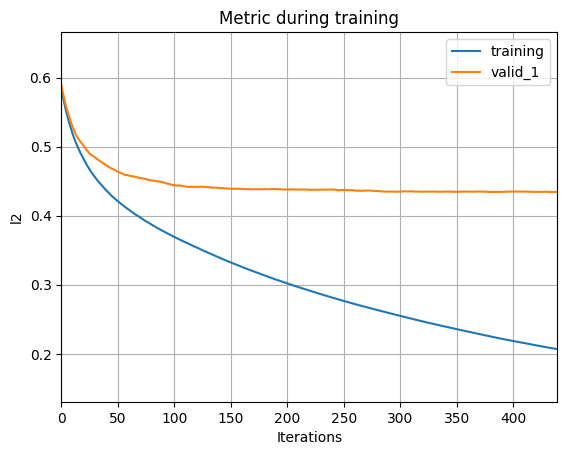

----> || Train Optimized QWK SCORE ::  0.802
----> || Val Optimized QWK SCORE ::  0.501
----> || Train Optimized Val QWK SCORE ::  0.482
----> || Val Optimized Train QWK SCORE ::  0.790
Fold 1 - Rounded Train QWK: 0.6997, Rounded Validation QWK: 0.3873


<Figure size 640x480 with 0 Axes>

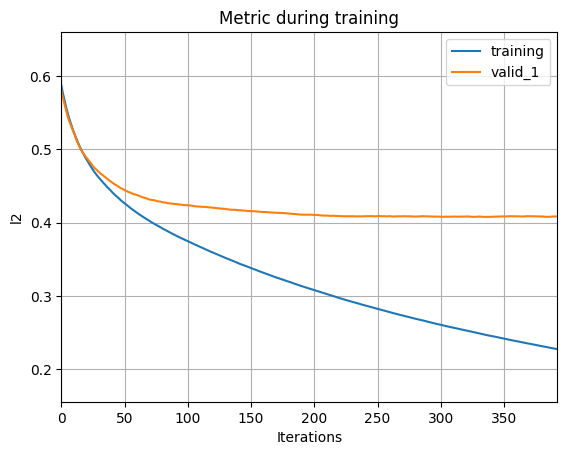

----> || Train Optimized QWK SCORE ::  0.774
----> || Val Optimized QWK SCORE ::  0.460
----> || Train Optimized Val QWK SCORE ::  0.515
----> || Val Optimized Train QWK SCORE ::  0.652
Fold 2 - Rounded Train QWK: 0.6692, Rounded Validation QWK: 0.4547


<Figure size 640x480 with 0 Axes>

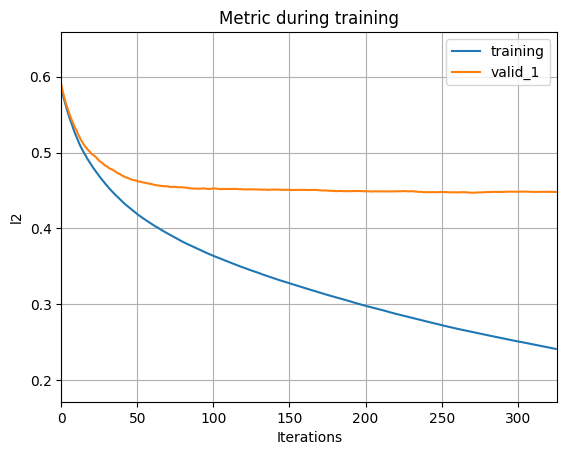

----> || Train Optimized QWK SCORE ::  0.755
----> || Val Optimized QWK SCORE ::  0.499
----> || Train Optimized Val QWK SCORE ::  0.469
----> || Val Optimized Train QWK SCORE ::  0.738
Fold 3 - Rounded Train QWK: 0.6529, Rounded Validation QWK: 0.3839


<Figure size 640x480 with 0 Axes>

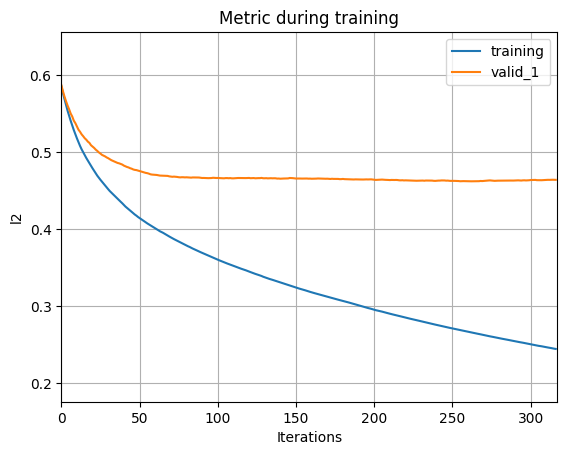

----> || Train Optimized QWK SCORE ::  0.753
----> || Val Optimized QWK SCORE ::  0.484
----> || Train Optimized Val QWK SCORE ::  0.482
----> || Val Optimized Train QWK SCORE ::  0.748
Fold 4 - Rounded Train QWK: 0.6512, Rounded Validation QWK: 0.3490


<Figure size 640x480 with 0 Axes>

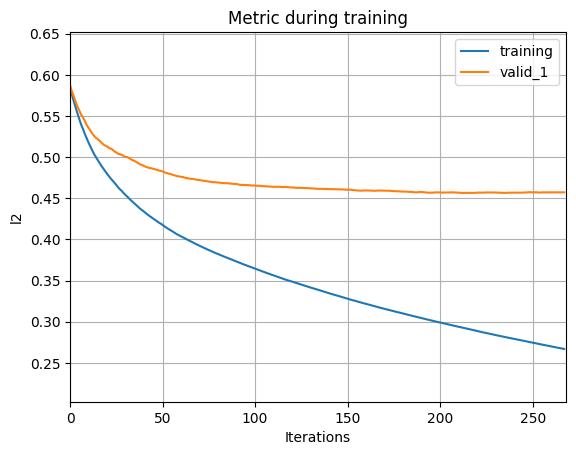

----> || Train Optimized QWK SCORE ::  0.719
----> || Val Optimized QWK SCORE ::  0.430
----> || Train Optimized Val QWK SCORE ::  0.423
----> || Val Optimized Train QWK SCORE ::  0.713
Fold 5 - Rounded Train QWK: 0.6086, Rounded Validation QWK: 0.3756
Mean Train QWK --> 0.7605
Mean Validation QWK ---> 0.4747
----> || Optimized QWK SCORE ::  0.494


In [110]:
lgb_models_list4, lgb_submission_df, lgb_raw_train_preds, lgb_raw_test_preds, lgb_optuna_study = lgb_feature_selection(
    train_selected_df4, test_selected_df4, 250
)

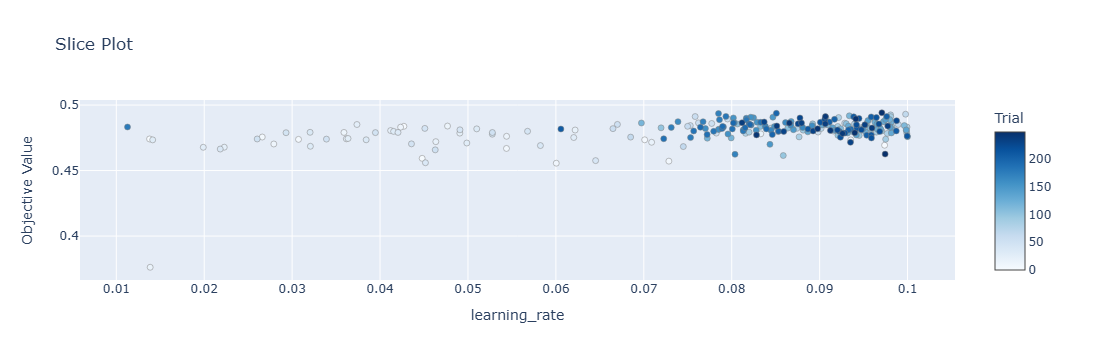

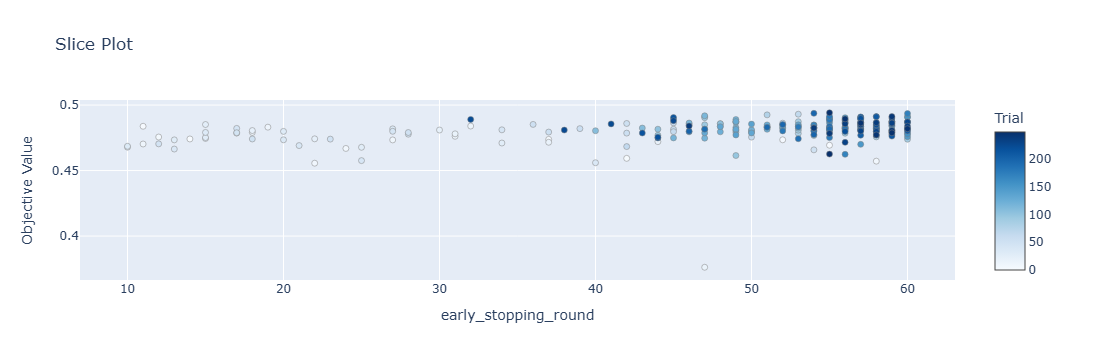

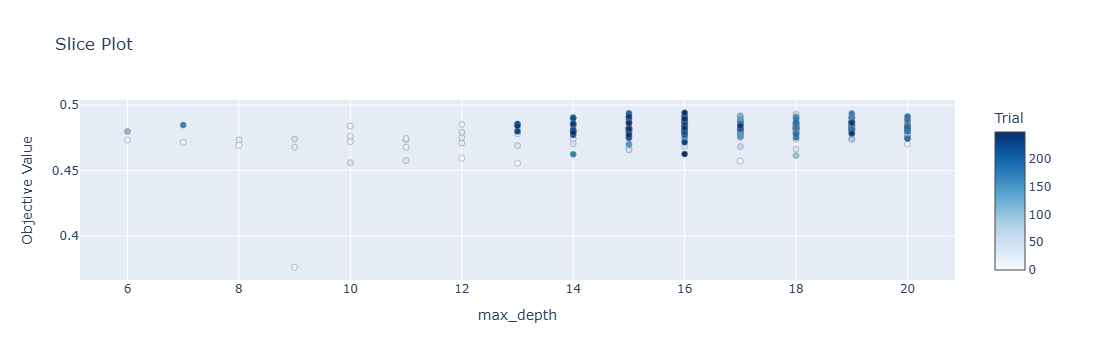

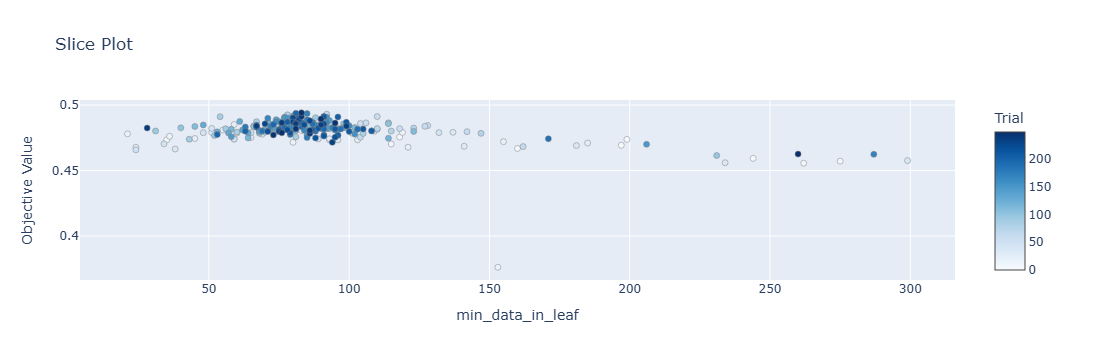

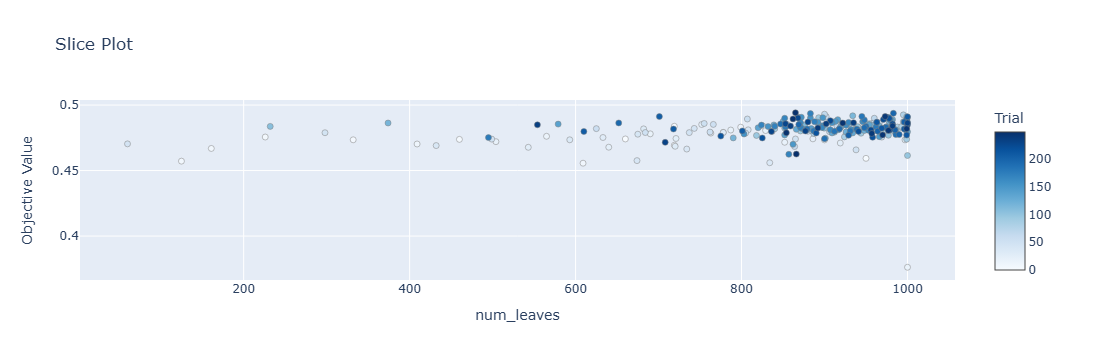

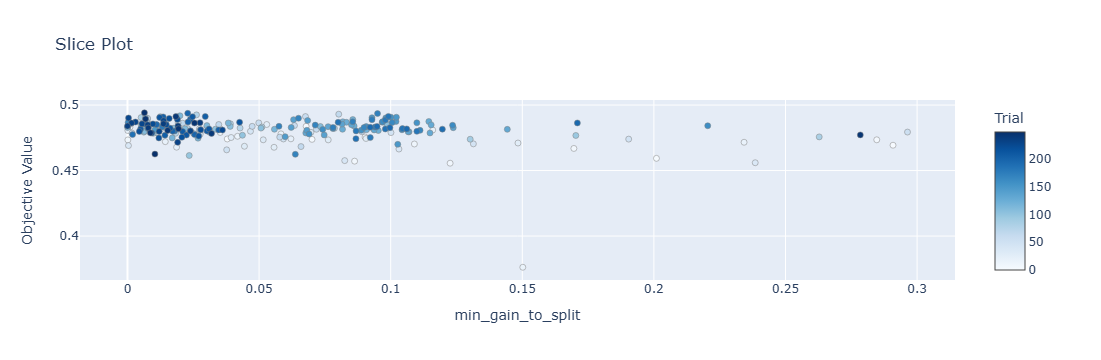

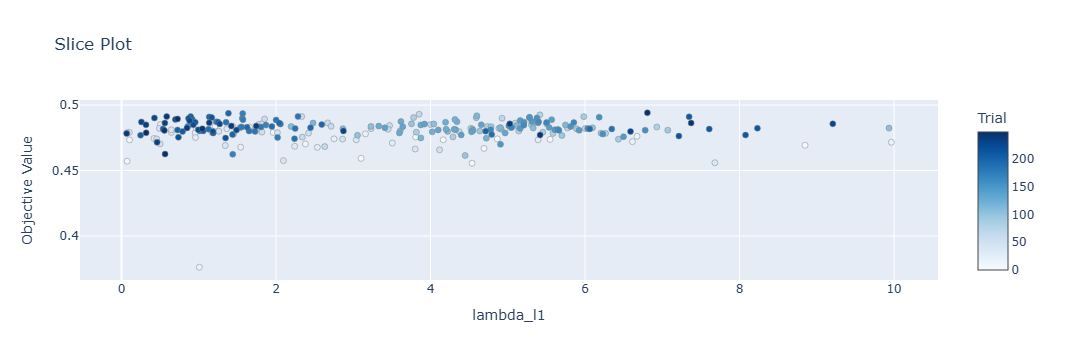

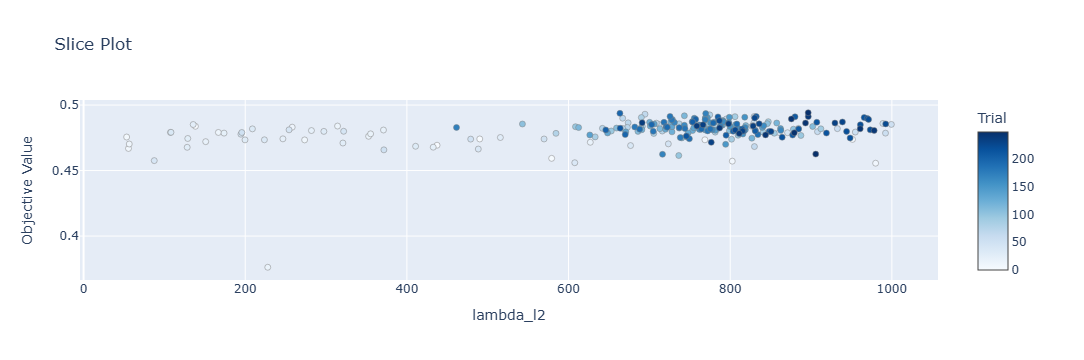

In [111]:
for param in lgb_optuna_study.best_params.keys():
    fig = plot_slice(lgb_optuna_study, params=[param])
    fig.show()

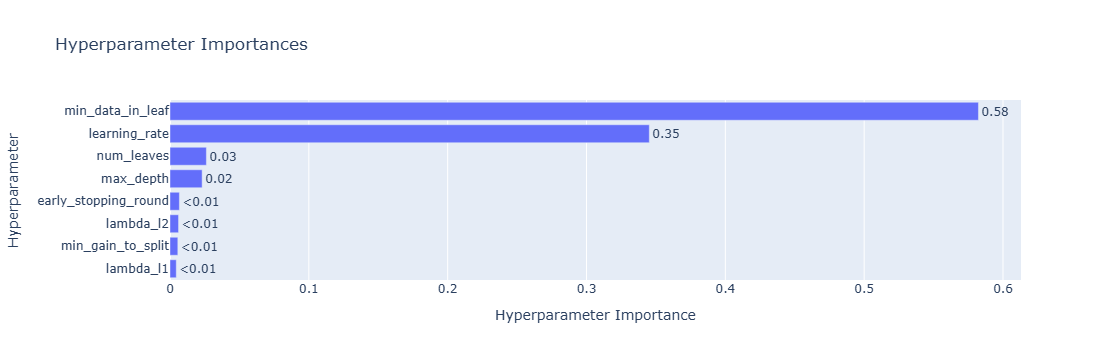

In [112]:
plot_param_importances(lgb_optuna_study)

In [113]:
lgb_optuna_study.best_params

{'learning_rate': 0.09707556732769033,
 'early_stopping_round': 55,
 'max_depth': 16,
 'min_data_in_leaf': 83,
 'num_leaves': 865,
 'min_gain_to_split': 0.0064421254970270115,
 'lambda_l1': 6.806861550000994,
 'lambda_l2': 896.4830588773848}

In [114]:
cols = train_selected_df4.drop(['id', 'sii'], axis=1).columns
importance_list = []
for model in lgb_models_list4:
    importance_list.append(model.feature_importances_)

importance_mean = np.mean(importance_list, axis=0)
imp_df = pd.DataFrame(sorted(zip(cols, importance_mean)), columns=['Feature', 'Importance']).sort_values('Importance', ascending=False)
unimportant_df = imp_df[imp_df['Importance'] < imp_df['Importance'].quantile(0.5)]
unimportant_cols = unimportant_df['Feature'].tolist()

In [115]:
train_selected_df5 = train_selected_df4.drop(unimportant_cols, axis=1)
print(train_selected_df5.shape)
train_selected_df5.head()

(2736, 124)


id  Basic_Demos-Age  CGAS-CGAS_Score  Physical-BMI  Physical-Height  \
0  00008ff9              5.0             51.0     16.877316             46.0   
1  000fd460              9.0             63.2     14.035590             48.0   
2  00105258             10.0             71.0     16.648696             56.5   
3  00115b9f              9.0             71.0     18.292347             56.0   
4  001f3379             13.0             50.0     22.279952             59.5   

   Physical-Weight  Physical-Waist_Circumference  Physical-HeartRate  \
0             50.8                          25.0                80.0   
1             46.0                          22.0                70.0   
2             75.6                          27.0                94.0   
3             81.6                          26.4                97.0   
4            112.2                          32.0                73.0   

   Physical-Systolic_BP  Fitness_Endurance-Time_Sec  FGC-FGC_CU  FGC-FGC_GSND  \
0                 130.2                        22.6         0.0         20.50   
1                 122.0                        14.4         3.0         23.08   
2                 117.0                        33.0        20.0         10.20   
3                 117.0                        37.0        18.0         17.66   
4                 102.0                        39.4        12.0         16.50   

   FGC-FGC_GSD  FGC-FGC_PU  BIA-BIA_BMC  BIA-BIA_FFMI  PAQ_A-PAQ_A_Total  \
0        21.18         0.0     2.668550      13.81770              1.844   
1        24.94         5.0     2.579490      12.82540              1.704   
2        14.70         7.0     4.310264      24.52766              2.578   
3        19.24         5.0     3.841910      14.07400              2.018   
4        17.90         6.0     4.330360      16.68770              2.004   

   PAQ_C-PAQ_C_Total  SDS-SDS_Total_Raw  \
0             2.6342               41.6   
1             2.3400               46.0   
2             2.1700               38.0   
3             2.4510               31.0   
4             4.1100               40.0   

   PreInt_EduHx-computerinternet_hoursday  Physical-Waist_Circumference_isnan  \
0                                     3.0                                 1.0   
1                                     0.0                                 0.0   
2                                     2.0                                 1.0   
3                                     0.0                                 1.0   
4                                     0.0                                 1.0   

   anglez_max  X_weekday_3_min  X_weekday_4_mean  X_weekday_6_max  \
0   89.296684        -1.181594          0.029699         1.078925   
1   89.456932        -1.175764          0.030971         1.245570   
2   89.528796        -1.384442          0.013404         1.400885   
3   89.751656        -0.973490         -0.213124         1.007214   
4   89.476036        -1.015088          0.255062         1.005606   

   Y_weekday_4_entropy  Y_weekday_6_sum  Y_weekday_7_entropy  Z_weekday_1_min  \
0            32.881972      -105.297590            24.108867        -1.001339   
1            53.061190     -1221.787835            20.828965        -1.000690   
2           132.689714       436.261438            64.399943        -1.001535   
3            12.516920       682.231018            42.000340        -1.013281   
4            13.941320      1735.811646            21.477032        -1.011558   

   Z_weekday_3_std  Z_weekday_6_min  enmo_weekday_1_15%  enmo_weekday_3_mean  \
0         0.544952        -0.993339            0.002152             0.046002   
1         0.592790        -1.021988            0.003071             0.043606   
2         0.548045        -1.032027            0.001253             0.046373   
3         0.554800        -1.019453            0.001123             0.047503   
4         0.635620        -1.011636            0.000000             0.010586   

   enmo_weekday_3_std 

In [116]:
test_selected_df5 = test_selected_df4.drop(unimportant_cols, axis=1)
print(test_selected_df5.shape)
test_selected_df5.head()

(20, 123)


id  Basic_Demos-Age  CGAS-CGAS_Score  Physical-BMI  Physical-Height  \
0  00008ff9              5.0             51.0     16.877316           46.000   
1  000fd460              9.0             63.2     14.035590           48.000   
2  00105258             10.0             71.0     16.648696           56.500   
3  00115b9f              9.0             71.0     18.292347           56.000   
4  0016bb22             18.0             65.8     22.367377           66.878   

   Physical-Weight  Physical-Waist_Circumference  Physical-HeartRate  \
0             50.8                          25.0                80.0   
1             46.0                          22.0                70.0   
2             75.6                          27.0                94.0   
3             81.6                          26.4                97.0   
4             20.0                          31.7                75.4   

   Physical-Systolic_BP  Fitness_Endurance-Time_Sec  FGC-FGC_CU  FGC-FGC_GSND  \
0                 130.2                        22.6         0.0         20.50   
1                 122.0                        14.4         3.0         23.08   
2                 117.0                        33.0        20.0         10.20   
3                 117.0                        37.0        18.0         17.66   
4                 113.6                        17.8         5.8         28.28   

   FGC-FGC_GSD  FGC-FGC_PU  BIA-BIA_BMC  BIA-BIA_FFMI  PAQ_A-PAQ_A_Total  \
0        21.18         0.0     2.668550      13.81770              1.844   
1        24.94         5.0     2.579490      12.82540              1.704   
2        14.70         7.0     4.310264      24.52766              2.578   
3        19.24         5.0     3.841910      14.07400              2.018   
4        27.96         4.2     5.477302      15.81610              1.040   

   PAQ_C-PAQ_C_Total  SDS-SDS_Total_Raw  \
0             2.6342               41.6   
1             2.3400               46.0   
2             2.1700               38.0   
3             2.4510               31.0   
4             2.2922               65.2   

   PreInt_EduHx-computerinternet_hoursday  Physical-Waist_Circumference_isnan  \
0                                     3.0                                 1.0   
1                                     0.0                                 0.0   
2                                     2.0                                 1.0   
3                                     0.0                                 1.0   
4                                     2.2                                 1.0   

   anglez_max  X_weekday_3_min  X_weekday_4_mean  X_weekday_6_max  \
0   89.296684        -1.181594          0.029699         1.078925   
1   89.456932        -1.175764          0.030971         1.245570   
2   89.528796        -1.384442          0.013404         1.400885   
3   89.751656        -0.973490         -0.213124         1.007214   
4   88.557333        -1.180735         -0.043651         0.682226   

   Y_weekday_4_entropy  Y_weekday_6_sum  Y_weekday_7_entropy  Z_weekday_1_min  \
0            32.881972      -105.297590            24.108867        -1.001339   
1            53.061190     -1221.787835            20.828965        -1.000690   
2           132.689714       436.261438            64.399943        -1.001535   
3            12.516920       682.231018            42.000340        -1.013281   
4            46.095550       533.215946            31.479834        -0.601322   

   Z_weekday_3_std  Z_weekday_6_min  enmo_weekday_1_15%  enmo_weekday_3_mean  \
0         0.544952        -0.993339            0.002152             0.046002   
1         0.592790        -1.021988            0.003071             0.043606   
2         0.548045        -1.032027            0.001253             0.046373   
3         0.554800        -1.019453            0.001123             0.047503   
4         0.555871        -0.600862            0.006451             0.059423   

   enmo_weekday_3_std 

[I 2024-12-14 22:08:40,371] A new study created in memory with name: no-name-bf99daa4-eecb-4187-9520-b183201d98aa
[I 2024-12-14 22:08:44,628] Trial 0 finished with value: 0.4857970340839002 and parameters: {'learning_rate': 0.0946319742066212, 'early_stopping_round': 99, 'max_depth': 22, 'min_data_in_leaf': 22, 'num_leaves': 1517, 'min_gain_to_split': 0.1581111365422068, 'lambda_l1': 8.105980652926585, 'lambda_l2': 523.9986145385947}. Best is trial 0 with value: 0.4857970340839002.


----> || Optimized QWK SCORE ::  0.486


[I 2024-12-14 22:08:46,847] Trial 1 finished with value: 0.4691018590100148 and parameters: {'learning_rate': 0.2837536884062162, 'early_stopping_round': 84, 'max_depth': 30, 'min_data_in_leaf': 238, 'num_leaves': 1063, 'min_gain_to_split': 0.11079049015433794, 'lambda_l1': 3.824627145524042, 'lambda_l2': 556.5534869234732}. Best is trial 0 with value: 0.4857970340839002.


----> || Optimized QWK SCORE ::  0.469


[I 2024-12-14 22:08:50,300] Trial 2 finished with value: 0.48333811880351973 and parameters: {'learning_rate': 0.19516391663195262, 'early_stopping_round': 45, 'max_depth': 8, 'min_data_in_leaf': 37, 'num_leaves': 2052, 'min_gain_to_split': 0.21590269472962362, 'lambda_l1': 1.7494509484581011, 'lambda_l2': 1234.1243080181805}. Best is trial 0 with value: 0.4857970340839002.


----> || Optimized QWK SCORE ::  0.483


[I 2024-12-14 22:08:55,674] Trial 3 finished with value: 0.47626877949443136 and parameters: {'learning_rate': 0.05973255457574926, 'early_stopping_round': 45, 'max_depth': 8, 'min_data_in_leaf': 298, 'num_leaves': 2501, 'min_gain_to_split': 0.15785769655743462, 'lambda_l1': 5.440076988925301, 'lambda_l2': 1851.9634023450426}. Best is trial 0 with value: 0.4857970340839002.


----> || Optimized QWK SCORE ::  0.476


[I 2024-12-14 22:08:57,194] Trial 4 finished with value: 0.4601482629972382 and parameters: {'learning_rate': 0.24081948884875173, 'early_stopping_round': 19, 'max_depth': 15, 'min_data_in_leaf': 234, 'num_leaves': 470, 'min_gain_to_split': 0.26107019835636996, 'lambda_l1': 8.622250416335676, 'lambda_l2': 1799.5706938412923}. Best is trial 0 with value: 0.4857970340839002.


----> || Optimized QWK SCORE ::  0.460


[I 2024-12-14 22:09:01,917] Trial 5 finished with value: 0.46879545117754573 and parameters: {'learning_rate': 0.08859798191906713, 'early_stopping_round': 80, 'max_depth': 17, 'min_data_in_leaf': 260, 'num_leaves': 2234, 'min_gain_to_split': 0.24360306347447283, 'lambda_l1': 0.8866812846259631, 'lambda_l2': 1933.1776053197714}. Best is trial 0 with value: 0.4857970340839002.


----> || Optimized QWK SCORE ::  0.469


[I 2024-12-14 22:09:06,494] Trial 6 finished with value: 0.48755724314158977 and parameters: {'learning_rate': 0.09977837599526278, 'early_stopping_round': 26, 'max_depth': 15, 'min_data_in_leaf': 176, 'num_leaves': 1839, 'min_gain_to_split': 0.10113840042609715, 'lambda_l1': 2.239990986542524, 'lambda_l2': 1474.2624230497786}. Best is trial 6 with value: 0.48755724314158977.


----> || Optimized QWK SCORE ::  0.488


[I 2024-12-14 22:09:09,903] Trial 7 finished with value: 0.4858140249345462 and parameters: {'learning_rate': 0.11793288850905916, 'early_stopping_round': 11, 'max_depth': 21, 'min_data_in_leaf': 38, 'num_leaves': 1876, 'min_gain_to_split': 0.2722821117485534, 'lambda_l1': 1.4634053849310258, 'lambda_l2': 399.88141843677613}. Best is trial 6 with value: 0.48755724314158977.


----> || Optimized QWK SCORE ::  0.486


[I 2024-12-14 22:09:14,897] Trial 8 finished with value: 0.4943507087673267 and parameters: {'learning_rate': 0.14428547540822187, 'early_stopping_round': 72, 'max_depth': 26, 'min_data_in_leaf': 170, 'num_leaves': 2758, 'min_gain_to_split': 0.14754326086167768, 'lambda_l1': 0.5432606375941662, 'lambda_l2': 1154.6622361780808}. Best is trial 8 with value: 0.4943507087673267.


----> || Optimized QWK SCORE ::  0.494


[I 2024-12-14 22:09:17,218] Trial 9 finished with value: 0.4759920534930415 and parameters: {'learning_rate': 0.11625266919331337, 'early_stopping_round': 70, 'max_depth': 24, 'min_data_in_leaf': 138, 'num_leaves': 537, 'min_gain_to_split': 0.2830016396334889, 'lambda_l1': 6.493096906191429, 'lambda_l2': 1509.1445415715314}. Best is trial 8 with value: 0.4943507087673267.


----> || Optimized QWK SCORE ::  0.476


[I 2024-12-14 22:09:37,014] Trial 10 finished with value: 0.4791810631506206 and parameters: {'learning_rate': 0.01707854593610314, 'early_stopping_round': 62, 'max_depth': 30, 'min_data_in_leaf': 114, 'num_leaves': 2933, 'min_gain_to_split': 0.011821371134951353, 'lambda_l1': 0.09571651457691727, 'lambda_l2': 1001.2199652670995}. Best is trial 8 with value: 0.4943507087673267.


----> || Optimized QWK SCORE ::  0.479


[I 2024-12-14 22:09:41,029] Trial 11 finished with value: 0.4919735666576853 and parameters: {'learning_rate': 0.1711199232090907, 'early_stopping_round': 30, 'max_depth': 14, 'min_data_in_leaf': 184, 'num_leaves': 2973, 'min_gain_to_split': 0.08466698994091723, 'lambda_l1': 3.167439626312003, 'lambda_l2': 1032.2708133384363}. Best is trial 8 with value: 0.4943507087673267.


----> || Optimized QWK SCORE ::  0.492


[I 2024-12-14 22:09:45,422] Trial 12 finished with value: 0.4865643202044043 and parameters: {'learning_rate': 0.16772775406182205, 'early_stopping_round': 37, 'max_depth': 11, 'min_data_in_leaf': 188, 'num_leaves': 2940, 'min_gain_to_split': 0.03179151896643506, 'lambda_l1': 3.5883527539515248, 'lambda_l2': 924.0655136793001}. Best is trial 8 with value: 0.4943507087673267.


----> || Optimized QWK SCORE ::  0.487


[I 2024-12-14 22:09:49,808] Trial 13 finished with value: 0.49412394795908643 and parameters: {'learning_rate': 0.19642722737184498, 'early_stopping_round': 58, 'max_depth': 26, 'min_data_in_leaf': 108, 'num_leaves': 2573, 'min_gain_to_split': 0.07594590157210333, 'lambda_l1': 3.2933295843713033, 'lambda_l2': 769.8836423186801}. Best is trial 8 with value: 0.4943507087673267.


----> || Optimized QWK SCORE ::  0.494


[I 2024-12-14 22:09:54,247] Trial 14 finished with value: 0.48964745383324004 and parameters: {'learning_rate': 0.22745301563733777, 'early_stopping_round': 58, 'max_depth': 25, 'min_data_in_leaf': 84, 'num_leaves': 2500, 'min_gain_to_split': 0.06248452701640503, 'lambda_l1': 5.097289816793686, 'lambda_l2': 735.9504025425704}. Best is trial 8 with value: 0.4943507087673267.


----> || Optimized QWK SCORE ::  0.490


[I 2024-12-14 22:09:58,445] Trial 15 finished with value: 0.4962776007192766 and parameters: {'learning_rate': 0.2063761767762024, 'early_stopping_round': 77, 'max_depth': 27, 'min_data_in_leaf': 92, 'num_leaves': 2458, 'min_gain_to_split': 0.189012201740036, 'lambda_l1': 0.1172385542058535, 'lambda_l2': 1306.4363935547685}. Best is trial 15 with value: 0.4962776007192766.


----> || Optimized QWK SCORE ::  0.496


[I 2024-12-14 22:10:01,053] Trial 16 finished with value: 0.4679634693871654 and parameters: {'learning_rate': 0.29536524670183484, 'early_stopping_round': 95, 'max_depth': 27, 'min_data_in_leaf': 81, 'num_leaves': 1368, 'min_gain_to_split': 0.20786993475831197, 'lambda_l1': 0.05827689013240833, 'lambda_l2': 184.52639713049018}. Best is trial 15 with value: 0.4962776007192766.


----> || Optimized QWK SCORE ::  0.468


[I 2024-12-14 22:10:04,464] Trial 17 finished with value: 0.47988446201499535 and parameters: {'learning_rate': 0.1412958698133365, 'early_stopping_round': 74, 'max_depth': 20, 'min_data_in_leaf': 154, 'num_leaves': 2253, 'min_gain_to_split': 0.1875768774481591, 'lambda_l1': 9.630716085570977, 'lambda_l2': 1402.6505075181474}. Best is trial 15 with value: 0.4962776007192766.


----> || Optimized QWK SCORE ::  0.480


[I 2024-12-14 22:10:07,985] Trial 18 finished with value: 0.4954230688266562 and parameters: {'learning_rate': 0.24905417784947126, 'early_stopping_round': 87, 'max_depth': 27, 'min_data_in_leaf': 66, 'num_leaves': 979, 'min_gain_to_split': 0.13244517604496586, 'lambda_l1': 0.8935575937364881, 'lambda_l2': 1312.901394790995}. Best is trial 15 with value: 0.4962776007192766.


----> || Optimized QWK SCORE ::  0.495


[I 2024-12-14 22:10:11,264] Trial 19 finished with value: 0.4967932258945643 and parameters: {'learning_rate': 0.25725379688036165, 'early_stopping_round': 88, 'max_depth': 28, 'min_data_in_leaf': 68, 'num_leaves': 955, 'min_gain_to_split': 0.13245572274838563, 'lambda_l1': 1.9768011200064461, 'lambda_l2': 1667.0460260509926}. Best is trial 19 with value: 0.4967932258945643.


----> || Optimized QWK SCORE ::  0.497


[I 2024-12-14 22:10:13,427] Trial 20 finished with value: 0.48422616641624405 and parameters: {'learning_rate': 0.26718201519152185, 'early_stopping_round': 91, 'max_depth': 29, 'min_data_in_leaf': 59, 'num_leaves': 87, 'min_gain_to_split': 0.183729817549968, 'lambda_l1': 2.388125275721895, 'lambda_l2': 1678.42679378224}. Best is trial 19 with value: 0.4967932258945643.


----> || Optimized QWK SCORE ::  0.484


[I 2024-12-14 22:10:16,955] Trial 21 finished with value: 0.49510030584787823 and parameters: {'learning_rate': 0.2172656673875991, 'early_stopping_round': 85, 'max_depth': 23, 'min_data_in_leaf': 72, 'num_leaves': 1101, 'min_gain_to_split': 0.13535751355914966, 'lambda_l1': 1.2844048101290766, 'lambda_l2': 1280.460964139971}. Best is trial 19 with value: 0.4967932258945643.


----> || Optimized QWK SCORE ::  0.495


[I 2024-12-14 22:10:19,949] Trial 22 finished with value: 0.4919773047750897 and parameters: {'learning_rate': 0.2623561337252914, 'early_stopping_round': 89, 'max_depth': 27, 'min_data_in_leaf': 110, 'num_leaves': 768, 'min_gain_to_split': 0.12041282929437985, 'lambda_l1': 2.444567309539144, 'lambda_l2': 1629.5577893135064}. Best is trial 19 with value: 0.4967932258945643.


----> || Optimized QWK SCORE ::  0.492


[I 2024-12-14 22:10:23,039] Trial 23 finished with value: 0.4855163620374475 and parameters: {'learning_rate': 0.2555330073945399, 'early_stopping_round': 100, 'max_depth': 28, 'min_data_in_leaf': 56, 'num_leaves': 1106, 'min_gain_to_split': 0.17794768894071433, 'lambda_l1': 1.1698511717402793, 'lambda_l2': 1368.0722853879406}. Best is trial 19 with value: 0.4967932258945643.


----> || Optimized QWK SCORE ::  0.486


[I 2024-12-14 22:10:25,483] Trial 24 finished with value: 0.48295488231457884 and parameters: {'learning_rate': 0.20576380286698578, 'early_stopping_round': 78, 'max_depth': 19, 'min_data_in_leaf': 135, 'num_leaves': 797, 'min_gain_to_split': 0.21770324759395024, 'lambda_l1': 4.311819134956811, 'lambda_l2': 1614.518344214968}. Best is trial 19 with value: 0.4967932258945643.


----> || Optimized QWK SCORE ::  0.483


[I 2024-12-14 22:10:28,971] Trial 25 finished with value: 0.49326512810764145 and parameters: {'learning_rate': 0.23882283111790148, 'early_stopping_round': 65, 'max_depth': 24, 'min_data_in_leaf': 95, 'num_leaves': 1272, 'min_gain_to_split': 0.1177780620443454, 'lambda_l1': 0.7005290932944589, 'lambda_l2': 1132.4324142009632}. Best is trial 19 with value: 0.4967932258945643.


----> || Optimized QWK SCORE ::  0.493


[I 2024-12-14 22:10:34,036] Trial 26 finished with value: 0.49653983863867635 and parameters: {'learning_rate': 0.27925460729260654, 'early_stopping_round': 89, 'max_depth': 28, 'min_data_in_leaf': 61, 'num_leaves': 1698, 'min_gain_to_split': 0.04881080701545962, 'lambda_l1': 1.9181839153877522, 'lambda_l2': 1751.5894967750194}. Best is trial 19 with value: 0.4967932258945643.


----> || Optimized QWK SCORE ::  0.497


[I 2024-12-14 22:10:38,615] Trial 27 finished with value: 0.48704895776573054 and parameters: {'learning_rate': 0.27719188917320897, 'early_stopping_round': 93, 'max_depth': 30, 'min_data_in_leaf': 40, 'num_leaves': 1680, 'min_gain_to_split': 0.05979123598357257, 'lambda_l1': 6.0036966926943105, 'lambda_l2': 1997.9337875710057}. Best is trial 19 with value: 0.4967932258945643.


----> || Optimized QWK SCORE ::  0.487


[I 2024-12-14 22:10:45,468] Trial 28 finished with value: 0.4833574722906432 and parameters: {'learning_rate': 0.29871094089364736, 'early_stopping_round': 78, 'max_depth': 25, 'min_data_in_leaf': 21, 'num_leaves': 1520, 'min_gain_to_split': 0.024907172966648992, 'lambda_l1': 2.7999313984770278, 'lambda_l2': 1752.5890260406945}. Best is trial 19 with value: 0.4967932258945643.


----> || Optimized QWK SCORE ::  0.483


[I 2024-12-14 22:10:50,608] Trial 29 finished with value: 0.49040015227604894 and parameters: {'learning_rate': 0.2135529047914055, 'early_stopping_round': 100, 'max_depth': 22, 'min_data_in_leaf': 129, 'num_leaves': 1631, 'min_gain_to_split': 0.04439142527695999, 'lambda_l1': 1.8945019654659054, 'lambda_l2': 1518.131758412854}. Best is trial 19 with value: 0.4967932258945643.


----> || Optimized QWK SCORE ::  0.490


[I 2024-12-14 22:10:53,805] Trial 30 finished with value: 0.48347449874619286 and parameters: {'learning_rate': 0.18832930733959094, 'early_stopping_round': 69, 'max_depth': 28, 'min_data_in_leaf': 91, 'num_leaves': 2168, 'min_gain_to_split': 0.23584194330931227, 'lambda_l1': 6.903720444022869, 'lambda_l2': 1716.6645507451435}. Best is trial 19 with value: 0.4967932258945643.


----> || Optimized QWK SCORE ::  0.483


[I 2024-12-14 22:10:56,907] Trial 31 finished with value: 0.4965915508352613 and parameters: {'learning_rate': 0.2518733791908653, 'early_stopping_round': 86, 'max_depth': 28, 'min_data_in_leaf': 65, 'num_leaves': 807, 'min_gain_to_split': 0.167859802856835, 'lambda_l1': 0.09966491116230336, 'lambda_l2': 1325.0917086414443}. Best is trial 19 with value: 0.4967932258945643.


----> || Optimized QWK SCORE ::  0.497


[I 2024-12-14 22:10:59,749] Trial 32 finished with value: 0.4916580532390997 and parameters: {'learning_rate': 0.27755728532793994, 'early_stopping_round': 81, 'max_depth': 28, 'min_data_in_leaf': 49, 'num_leaves': 404, 'min_gain_to_split': 0.16776742723702048, 'lambda_l1': 0.3399277259274759, 'lambda_l2': 1555.856737940729}. Best is trial 19 with value: 0.4967932258945643.


----> || Optimized QWK SCORE ::  0.492


[I 2024-12-14 22:11:08,392] Trial 33 finished with value: 0.4921377696727798 and parameters: {'learning_rate': 0.23618946940891725, 'early_stopping_round': 94, 'max_depth': 30, 'min_data_in_leaf': 27, 'num_leaves': 809, 'min_gain_to_split': 0.0007343566450686914, 'lambda_l1': 1.8800794666769645, 'lambda_l2': 1428.8394650544685}. Best is trial 19 with value: 0.4967932258945643.


----> || Optimized QWK SCORE ::  0.492


[I 2024-12-14 22:11:12,092] Trial 34 finished with value: 0.48731871893199574 and parameters: {'learning_rate': 0.26242128602043857, 'early_stopping_round': 84, 'max_depth': 23, 'min_data_in_leaf': 73, 'num_leaves': 1342, 'min_gain_to_split': 0.09232365156252213, 'lambda_l1': 4.311573456237997, 'lambda_l2': 1882.5274856577028}. Best is trial 19 with value: 0.4967932258945643.


----> || Optimized QWK SCORE ::  0.487


[I 2024-12-14 22:11:14,366] Trial 35 finished with value: 0.4872074200799392 and parameters: {'learning_rate': 0.28300892451494375, 'early_stopping_round': 51, 'max_depth': 29, 'min_data_in_leaf': 101, 'num_leaves': 119, 'min_gain_to_split': 0.20016037510444995, 'lambda_l1': 1.5792445483174156, 'lambda_l2': 1161.194742926146}. Best is trial 19 with value: 0.4967932258945643.


----> || Optimized QWK SCORE ::  0.487


[I 2024-12-14 22:11:17,555] Trial 36 finished with value: 0.4890448932182928 and parameters: {'learning_rate': 0.2252428339754205, 'early_stopping_round': 77, 'max_depth': 26, 'min_data_in_leaf': 54, 'num_leaves': 669, 'min_gain_to_split': 0.15374214625646232, 'lambda_l1': 2.7703107849738386, 'lambda_l2': 1822.0407525468943}. Best is trial 19 with value: 0.4967932258945643.


----> || Optimized QWK SCORE ::  0.489


[I 2024-12-14 22:11:19,846] Trial 37 finished with value: 0.49068464867001993 and parameters: {'learning_rate': 0.24819381344695746, 'early_stopping_round': 87, 'max_depth': 29, 'min_data_in_leaf': 122, 'num_leaves': 350, 'min_gain_to_split': 0.24407516485486097, 'lambda_l1': 0.030795026613140236, 'lambda_l2': 1219.5205312445498}. Best is trial 19 with value: 0.4967932258945643.


----> || Optimized QWK SCORE ::  0.491


[I 2024-12-14 22:11:23,566] Trial 38 finished with value: 0.493911340879034 and parameters: {'learning_rate': 0.18273445379833597, 'early_stopping_round': 95, 'max_depth': 6, 'min_data_in_leaf': 150, 'num_leaves': 1916, 'min_gain_to_split': 0.22824152916776724, 'lambda_l1': 0.819872193557823, 'lambda_l2': 1646.6474041234223}. Best is trial 19 with value: 0.4967932258945643.


----> || Optimized QWK SCORE ::  0.494


[I 2024-12-14 22:11:26,300] Trial 39 finished with value: 0.4907949279517235 and parameters: {'learning_rate': 0.20444228322720928, 'early_stopping_round': 82, 'max_depth': 25, 'min_data_in_leaf': 204, 'num_leaves': 932, 'min_gain_to_split': 0.17020418521786623, 'lambda_l1': 4.079727517977604, 'lambda_l2': 1347.2192045845927}. Best is trial 19 with value: 0.4967932258945643.


----> || Optimized QWK SCORE ::  0.491


[I 2024-12-14 22:11:29,369] Trial 40 finished with value: 0.4794326465897556 and parameters: {'learning_rate': 0.2711345824210758, 'early_stopping_round': 66, 'max_depth': 17, 'min_data_in_leaf': 37, 'num_leaves': 1231, 'min_gain_to_split': 0.19543685434445013, 'lambda_l1': 1.785491890890583, 'lambda_l2': 1782.1588887192104}. Best is trial 19 with value: 0.4967932258945643.


----> || Optimized QWK SCORE ::  0.479


[I 2024-12-14 22:11:32,875] Trial 41 finished with value: 0.49263167305257816 and parameters: {'learning_rate': 0.24444974668477404, 'early_stopping_round': 90, 'max_depth': 27, 'min_data_in_leaf': 67, 'num_leaves': 935, 'min_gain_to_split': 0.13542470028717002, 'lambda_l1': 0.9948028134264997, 'lambda_l2': 1282.967890869309}. Best is trial 19 with value: 0.4967932258945643.


----> || Optimized QWK SCORE ::  0.493


[I 2024-12-14 22:11:35,985] Trial 42 finished with value: 0.5010234218410261 and parameters: {'learning_rate': 0.2533520729638238, 'early_stopping_round': 86, 'max_depth': 27, 'min_data_in_leaf': 65, 'num_leaves': 581, 'min_gain_to_split': 0.14037105989278595, 'lambda_l1': 0.6680755126342414, 'lambda_l2': 1067.7649309139256}. Best is trial 42 with value: 0.5010234218410261.


----> || Optimized QWK SCORE ::  0.501


[I 2024-12-14 22:11:39,023] Trial 43 finished with value: 0.4991043769624681 and parameters: {'learning_rate': 0.2879159905604365, 'early_stopping_round': 74, 'max_depth': 24, 'min_data_in_leaf': 83, 'num_leaves': 558, 'min_gain_to_split': 0.10315856956144748, 'lambda_l1': 0.43625190167885264, 'lambda_l2': 886.2643178808037}. Best is trial 42 with value: 0.5010234218410261.


----> || Optimized QWK SCORE ::  0.499


[I 2024-12-14 22:11:42,030] Trial 44 finished with value: 0.48503127833597426 and parameters: {'learning_rate': 0.29075615144149913, 'early_stopping_round': 84, 'max_depth': 22, 'min_data_in_leaf': 45, 'num_leaves': 245, 'min_gain_to_split': 0.10579893420679379, 'lambda_l1': 0.5589782275397607, 'lambda_l2': 868.121558202075}. Best is trial 42 with value: 0.5010234218410261.


----> || Optimized QWK SCORE ::  0.485


[I 2024-12-14 22:11:44,654] Trial 45 finished with value: 0.49580986595864973 and parameters: {'learning_rate': 0.28228312557957824, 'early_stopping_round': 96, 'max_depth': 24, 'min_data_in_leaf': 81, 'num_leaves': 537, 'min_gain_to_split': 0.14439928612648528, 'lambda_l1': 1.3769007395543469, 'lambda_l2': 1017.0812493199309}. Best is trial 42 with value: 0.5010234218410261.


----> || Optimized QWK SCORE ::  0.496


[I 2024-12-14 22:11:46,880] Trial 46 finished with value: 0.48091916191505735 and parameters: {'learning_rate': 0.299298567963398, 'early_stopping_round': 73, 'max_depth': 29, 'min_data_in_leaf': 257, 'num_leaves': 651, 'min_gain_to_split': 0.09396962814423329, 'lambda_l1': 2.297386177438944, 'lambda_l2': 671.7439200247857}. Best is trial 42 with value: 0.5010234218410261.


----> || Optimized QWK SCORE ::  0.481


[I 2024-12-14 22:11:56,042] Trial 47 finished with value: 0.48865263117711055 and parameters: {'learning_rate': 0.05527958175945841, 'early_stopping_round': 89, 'max_depth': 26, 'min_data_in_leaf': 32, 'num_leaves': 296, 'min_gain_to_split': 0.07002687603718734, 'lambda_l1': 0.4213745112136631, 'lambda_l2': 455.8816275629974}. Best is trial 42 with value: 0.5010234218410261.


----> || Optimized QWK SCORE ::  0.489


[I 2024-12-14 22:11:59,250] Trial 48 finished with value: 0.4973085404747739 and parameters: {'learning_rate': 0.23016852232928975, 'early_stopping_round': 97, 'max_depth': 28, 'min_data_in_leaf': 64, 'num_leaves': 634, 'min_gain_to_split': 0.12332160397771745, 'lambda_l1': 1.962275457179021, 'lambda_l2': 920.5330134572146}. Best is trial 42 with value: 0.5010234218410261.


----> || Optimized QWK SCORE ::  0.497


[I 2024-12-14 22:12:01,653] Trial 49 finished with value: 0.4863009440261087 and parameters: {'learning_rate': 0.23087436462230912, 'early_stopping_round': 97, 'max_depth': 13, 'min_data_in_leaf': 102, 'num_leaves': 618, 'min_gain_to_split': 0.12102284909270698, 'lambda_l1': 7.5805289719722015, 'lambda_l2': 885.6734263355327}. Best is trial 42 with value: 0.5010234218410261.


----> || Optimized QWK SCORE ::  0.486


[I 2024-12-14 22:12:03,612] Trial 50 finished with value: 0.4728032166139673 and parameters: {'learning_rate': 0.2589233920388598, 'early_stopping_round': 81, 'max_depth': 25, 'min_data_in_leaf': 290, 'num_leaves': 486, 'min_gain_to_split': 0.16268736372162568, 'lambda_l1': 2.963714328443039, 'lambda_l2': 597.0799477952736}. Best is trial 42 with value: 0.5010234218410261.


----> || Optimized QWK SCORE ::  0.473


[I 2024-12-14 22:12:06,472] Trial 51 finished with value: 0.4966090782272776 and parameters: {'learning_rate': 0.272678547343246, 'early_stopping_round': 92, 'max_depth': 28, 'min_data_in_leaf': 65, 'num_leaves': 762, 'min_gain_to_split': 0.1523950366251661, 'lambda_l1': 2.019852755465117, 'lambda_l2': 972.430438505661}. Best is trial 42 with value: 0.5010234218410261.


----> || Optimized QWK SCORE ::  0.497


[I 2024-12-14 22:12:09,334] Trial 52 finished with value: 0.4999307102730015 and parameters: {'learning_rate': 0.25281472321075626, 'early_stopping_round': 92, 'max_depth': 30, 'min_data_in_leaf': 79, 'num_leaves': 716, 'min_gain_to_split': 0.14707651811214098, 'lambda_l1': 1.0831802241697908, 'lambda_l2': 825.4961817952196}. Best is trial 42 with value: 0.5010234218410261.


----> || Optimized QWK SCORE ::  0.500


[I 2024-12-14 22:12:11,779] Trial 53 finished with value: 0.48630835715664944 and parameters: {'learning_rate': 0.2691186467385844, 'early_stopping_round': 93, 'max_depth': 30, 'min_data_in_leaf': 81, 'num_leaves': 644, 'min_gain_to_split': 0.14365099049030824, 'lambda_l1': 3.490765293248632, 'lambda_l2': 805.0902106631947}. Best is trial 42 with value: 0.5010234218410261.


----> || Optimized QWK SCORE ::  0.486


[I 2024-12-14 22:12:15,741] Trial 54 finished with value: 0.49297495623228027 and parameters: {'learning_rate': 0.2223927781224502, 'early_stopping_round': 98, 'max_depth': 26, 'min_data_in_leaf': 47, 'num_leaves': 987, 'min_gain_to_split': 0.10807202123477073, 'lambda_l1': 1.1596562041077434, 'lambda_l2': 973.3728897317654}. Best is trial 42 with value: 0.5010234218410261.


----> || Optimized QWK SCORE ::  0.493


[I 2024-12-14 22:12:18,205] Trial 55 finished with value: 0.4935691318327975 and parameters: {'learning_rate': 0.28931858854074743, 'early_stopping_round': 92, 'max_depth': 29, 'min_data_in_leaf': 74, 'num_leaves': 225, 'min_gain_to_split': 0.12741292594861722, 'lambda_l1': 2.1807177387355745, 'lambda_l2': 1088.7444137363557}. Best is trial 42 with value: 0.5010234218410261.


----> || Optimized QWK SCORE ::  0.494


[I 2024-12-14 22:12:19,959] Trial 56 finished with value: 0.4903687921837362 and parameters: {'learning_rate': 0.24359411365332215, 'early_stopping_round': 10, 'max_depth': 27, 'min_data_in_leaf': 88, 'num_leaves': 543, 'min_gain_to_split': 0.15061825705049373, 'lambda_l1': 1.4658698051341672, 'lambda_l2': 313.03468294348363}. Best is trial 42 with value: 0.5010234218410261.


----> || Optimized QWK SCORE ::  0.490


[I 2024-12-14 22:12:22,790] Trial 57 finished with value: 0.49637971007108095 and parameters: {'learning_rate': 0.25730436611920676, 'early_stopping_round': 47, 'max_depth': 30, 'min_data_in_leaf': 123, 'num_leaves': 727, 'min_gain_to_split': 0.08522198762265534, 'lambda_l1': 2.641381994302662, 'lambda_l2': 671.8317990709368}. Best is trial 42 with value: 0.5010234218410261.


----> || Optimized QWK SCORE ::  0.496


[I 2024-12-14 22:12:24,836] Trial 58 finished with value: 0.4846910977563005 and parameters: {'learning_rate': 0.23423654834359087, 'early_stopping_round': 37, 'max_depth': 24, 'min_data_in_leaf': 114, 'num_leaves': 424, 'min_gain_to_split': 0.2973965606915597, 'lambda_l1': 0.8044146327932902, 'lambda_l2': 813.9295001460546}. Best is trial 42 with value: 0.5010234218410261.


----> || Optimized QWK SCORE ::  0.485


[I 2024-12-14 22:12:29,834] Trial 59 finished with value: 0.5002539109143262 and parameters: {'learning_rate': 0.13262007677352664, 'early_stopping_round': 100, 'max_depth': 28, 'min_data_in_leaf': 55, 'num_leaves': 862, 'min_gain_to_split': 0.11671654344791135, 'lambda_l1': 2.1385003037565884, 'lambda_l2': 938.9025298526706}. Best is trial 42 with value: 0.5010234218410261.


----> || Optimized QWK SCORE ::  0.500


[I 2024-12-14 22:12:34,322] Trial 60 finished with value: 0.4919243205662889 and parameters: {'learning_rate': 0.1390325642530976, 'early_stopping_round': 100, 'max_depth': 21, 'min_data_in_leaf': 52, 'num_leaves': 1179, 'min_gain_to_split': 0.11471524487198476, 'lambda_l1': 4.964954183934771, 'lambda_l2': 730.1889435279678}. Best is trial 42 with value: 0.5010234218410261.


----> || Optimized QWK SCORE ::  0.492


[I 2024-12-14 22:12:38,958] Trial 61 finished with value: 0.49740955343549065 and parameters: {'learning_rate': 0.11850840225463477, 'early_stopping_round': 97, 'max_depth': 28, 'min_data_in_leaf': 72, 'num_leaves': 887, 'min_gain_to_split': 0.12955622956368917, 'lambda_l1': 2.076024540307654, 'lambda_l2': 920.7001302235606}. Best is trial 42 with value: 0.5010234218410261.


----> || Optimized QWK SCORE ::  0.497


[I 2024-12-14 22:12:44,180] Trial 62 finished with value: 0.4977529230216744 and parameters: {'learning_rate': 0.11724266464870167, 'early_stopping_round': 96, 'max_depth': 26, 'min_data_in_leaf': 75, 'num_leaves': 876, 'min_gain_to_split': 0.1289361093264468, 'lambda_l1': 1.5186065517177676, 'lambda_l2': 902.0046503735264}. Best is trial 42 with value: 0.5010234218410261.


----> || Optimized QWK SCORE ::  0.498


[I 2024-12-14 22:12:49,688] Trial 63 finished with value: 0.49472885718155957 and parameters: {'learning_rate': 0.11235436705217991, 'early_stopping_round': 97, 'max_depth': 27, 'min_data_in_leaf': 78, 'num_leaves': 1044, 'min_gain_to_split': 0.099189641377106, 'lambda_l1': 1.6018485545599477, 'lambda_l2': 1071.7616092760925}. Best is trial 42 with value: 0.5010234218410261.


----> || Optimized QWK SCORE ::  0.495


[I 2024-12-14 22:12:55,869] Trial 64 finished with value: 0.4962525991810862 and parameters: {'learning_rate': 0.07969181801383632, 'early_stopping_round': 97, 'max_depth': 26, 'min_data_in_leaf': 99, 'num_leaves': 853, 'min_gain_to_split': 0.12672236178193652, 'lambda_l1': 1.1924424763747643, 'lambda_l2': 903.0752231050618}. Best is trial 42 with value: 0.5010234218410261.


----> || Optimized QWK SCORE ::  0.496


[I 2024-12-14 22:13:00,371] Trial 65 finished with value: 0.5003497238802583 and parameters: {'learning_rate': 0.12983671372381692, 'early_stopping_round': 100, 'max_depth': 25, 'min_data_in_leaf': 89, 'num_leaves': 882, 'min_gain_to_split': 0.11396867932245955, 'lambda_l1': 3.2286025825942923, 'lambda_l2': 950.0843667102602}. Best is trial 42 with value: 0.5010234218410261.


----> || Optimized QWK SCORE ::  0.500


[I 2024-12-14 22:13:04,209] Trial 66 finished with value: 0.503086642860241 and parameters: {'learning_rate': 0.12868949164678342, 'early_stopping_round': 100, 'max_depth': 23, 'min_data_in_leaf': 92, 'num_leaves': 889, 'min_gain_to_split': 0.13754884316706098, 'lambda_l1': 3.2333369005264148, 'lambda_l2': 832.4523520750068}. Best is trial 66 with value: 0.503086642860241.


----> || Optimized QWK SCORE ::  0.503


[I 2024-12-14 22:13:08,220] Trial 67 finished with value: 0.4944864154661911 and parameters: {'learning_rate': 0.15549428865836945, 'early_stopping_round': 100, 'max_depth': 23, 'min_data_in_leaf': 108, 'num_leaves': 1099, 'min_gain_to_split': 0.07960337788883233, 'lambda_l1': 3.2163985612049886, 'lambda_l2': 838.575805569984}. Best is trial 66 with value: 0.503086642860241.


----> || Optimized QWK SCORE ::  0.494


[I 2024-12-14 22:13:12,696] Trial 68 finished with value: 0.49446217785299607 and parameters: {'learning_rate': 0.12872895648181734, 'early_stopping_round': 94, 'max_depth': 19, 'min_data_in_leaf': 88, 'num_leaves': 1453, 'min_gain_to_split': 0.14087808816091762, 'lambda_l1': 0.3428028556389706, 'lambda_l2': 566.9402169360364}. Best is trial 66 with value: 0.503086642860241.


----> || Optimized QWK SCORE ::  0.494


[I 2024-12-14 22:13:16,250] Trial 69 finished with value: 0.4910489703522669 and parameters: {'learning_rate': 0.10288061268312891, 'early_stopping_round': 19, 'max_depth': 24, 'min_data_in_leaf': 94, 'num_leaves': 1028, 'min_gain_to_split': 0.11128042752618483, 'lambda_l1': 3.7347050917089097, 'lambda_l2': 738.1632630555711}. Best is trial 66 with value: 0.503086642860241.


----> || Optimized QWK SCORE ::  0.491


[I 2024-12-14 22:13:20,387] Trial 70 finished with value: 0.496763881339932 and parameters: {'learning_rate': 0.15968636975838102, 'early_stopping_round': 91, 'max_depth': 21, 'min_data_in_leaf': 42, 'num_leaves': 528, 'min_gain_to_split': 0.09927695009155255, 'lambda_l1': 4.768970049575498, 'lambda_l2': 1203.4769335611259}. Best is trial 66 with value: 0.503086642860241.


----> || Optimized QWK SCORE ::  0.497


[I 2024-12-14 22:13:25,032] Trial 71 finished with value: 0.49195733464659275 and parameters: {'learning_rate': 0.1297469097980058, 'early_stopping_round': 100, 'max_depth': 25, 'min_data_in_leaf': 76, 'num_leaves': 898, 'min_gain_to_split': 0.13721605025913108, 'lambda_l1': 2.401129889967051, 'lambda_l2': 1059.7918384727125}. Best is trial 66 with value: 0.503086642860241.


----> || Optimized QWK SCORE ::  0.492


[I 2024-12-14 22:13:30,554] Trial 72 finished with value: 0.4948148398775185 and parameters: {'learning_rate': 0.09092009093922196, 'early_stopping_round': 95, 'max_depth': 23, 'min_data_in_leaf': 54, 'num_leaves': 861, 'min_gain_to_split': 0.1776272931214217, 'lambda_l1': 1.0100107287662767, 'lambda_l2': 959.834107909141}. Best is trial 66 with value: 0.503086642860241.


----> || Optimized QWK SCORE ::  0.495


[I 2024-12-14 22:13:34,527] Trial 73 finished with value: 0.48956076697315143 and parameters: {'learning_rate': 0.12621892712822266, 'early_stopping_round': 87, 'max_depth': 26, 'min_data_in_leaf': 85, 'num_leaves': 720, 'min_gain_to_split': 0.11361078311719769, 'lambda_l1': 3.003227460268554, 'lambda_l2': 667.2960968940602}. Best is trial 66 with value: 0.503086642860241.


----> || Optimized QWK SCORE ::  0.490


[I 2024-12-14 22:13:39,263] Trial 74 finished with value: 0.48402512091243766 and parameters: {'learning_rate': 0.10854845965270857, 'early_stopping_round': 91, 'max_depth': 27, 'min_data_in_leaf': 58, 'num_leaves': 1158, 'min_gain_to_split': 0.15662029587671839, 'lambda_l1': 3.4536676619495412, 'lambda_l2': 1123.9714137873914}. Best is trial 66 with value: 0.503086642860241.


----> || Optimized QWK SCORE ::  0.484


[I 2024-12-14 22:13:43,157] Trial 75 finished with value: 0.4911649039243171 and parameters: {'learning_rate': 0.14540426756626965, 'early_stopping_round': 94, 'max_depth': 25, 'min_data_in_leaf': 102, 'num_leaves': 571, 'min_gain_to_split': 0.1292628456901241, 'lambda_l1': 0.6403486844183097, 'lambda_l2': 1032.096631193867}. Best is trial 66 with value: 0.503086642860241.


----> || Optimized QWK SCORE ::  0.491


[I 2024-12-14 22:13:47,921] Trial 76 finished with value: 0.4828059999688905 and parameters: {'learning_rate': 0.0759298994848293, 'early_stopping_round': 85, 'max_depth': 29, 'min_data_in_leaf': 116, 'num_leaves': 450, 'min_gain_to_split': 0.08985992039007368, 'lambda_l1': 2.6048200311009144, 'lambda_l2': 767.6884766931211}. Best is trial 66 with value: 0.503086642860241.


----> || Optimized QWK SCORE ::  0.483


[I 2024-12-14 22:13:51,789] Trial 77 finished with value: 0.48740396942658404 and parameters: {'learning_rate': 0.12331880617404123, 'early_stopping_round': 98, 'max_depth': 24, 'min_data_in_leaf': 206, 'num_leaves': 859, 'min_gain_to_split': 0.14450962401530737, 'lambda_l1': 1.6280228724966839, 'lambda_l2': 935.2172492089842}. Best is trial 66 with value: 0.503086642860241.


----> || Optimized QWK SCORE ::  0.487


[I 2024-12-14 22:13:55,420] Trial 78 finished with value: 0.4994409893883024 and parameters: {'learning_rate': 0.13776934979524377, 'early_stopping_round': 83, 'max_depth': 22, 'min_data_in_leaf': 142, 'num_leaves': 746, 'min_gain_to_split': 0.16050951833267546, 'lambda_l1': 1.3879743611009527, 'lambda_l2': 843.8647877876888}. Best is trial 66 with value: 0.503086642860241.


----> || Optimized QWK SCORE ::  0.499


[I 2024-12-14 22:13:57,749] Trial 79 finished with value: 0.48317510122625074 and parameters: {'learning_rate': 0.1681556679518253, 'early_stopping_round': 76, 'max_depth': 20, 'min_data_in_leaf': 169, 'num_leaves': 358, 'min_gain_to_split': 0.1765908285390942, 'lambda_l1': 5.595782349245305, 'lambda_l2': 838.7529706567765}. Best is trial 66 with value: 0.503086642860241.


----> || Optimized QWK SCORE ::  0.483


[I 2024-12-14 22:14:01,589] Trial 80 finished with value: 0.48330904647862927 and parameters: {'learning_rate': 0.1353204948019548, 'early_stopping_round': 82, 'max_depth': 22, 'min_data_in_leaf': 32, 'num_leaves': 708, 'min_gain_to_split': 0.1601729190321296, 'lambda_l1': 3.930050888089339, 'lambda_l2': 790.4677510843976}. Best is trial 66 with value: 0.503086642860241.


----> || Optimized QWK SCORE ::  0.483


[I 2024-12-14 22:14:05,297] Trial 81 finished with value: 0.4965679548508083 and parameters: {'learning_rate': 0.14970387572111807, 'early_stopping_round': 89, 'max_depth': 23, 'min_data_in_leaf': 142, 'num_leaves': 770, 'min_gain_to_split': 0.131988966160282, 'lambda_l1': 1.2834451989694247, 'lambda_l2': 872.4941388723075}. Best is trial 66 with value: 0.503086642860241.


----> || Optimized QWK SCORE ::  0.497


[I 2024-12-14 22:14:08,983] Trial 82 finished with value: 0.48773357593382793 and parameters: {'learning_rate': 0.11646829872945404, 'early_stopping_round': 79, 'max_depth': 25, 'min_data_in_leaf': 70, 'num_leaves': 998, 'min_gain_to_split': 0.10466980314946957, 'lambda_l1': 9.873505037339806, 'lambda_l2': 977.8318394090088}. Best is trial 66 with value: 0.503086642860241.


----> || Optimized QWK SCORE ::  0.488


[I 2024-12-14 22:14:13,654] Trial 83 finished with value: 0.48939982084204237 and parameters: {'learning_rate': 0.10345278213438773, 'early_stopping_round': 95, 'max_depth': 26, 'min_data_in_leaf': 96, 'num_leaves': 814, 'min_gain_to_split': 0.11982669177287039, 'lambda_l1': 0.9633219490564745, 'lambda_l2': 713.7248611519062}. Best is trial 66 with value: 0.503086642860241.


----> || Optimized QWK SCORE ::  0.489


[I 2024-12-14 22:14:18,047] Trial 84 finished with value: 0.4886505968205256 and parameters: {'learning_rate': 0.12164650107929163, 'early_stopping_round': 84, 'max_depth': 28, 'min_data_in_leaf': 84, 'num_leaves': 883, 'min_gain_to_split': 0.13961540648287574, 'lambda_l1': 2.1532874455275475, 'lambda_l2': 632.5625385529873}. Best is trial 66 with value: 0.503086642860241.


----> || Optimized QWK SCORE ::  0.489


[I 2024-12-14 22:14:22,361] Trial 85 finished with value: 0.49384478285214073 and parameters: {'learning_rate': 0.13666092852487277, 'early_stopping_round': 87, 'max_depth': 10, 'min_data_in_leaf': 72, 'num_leaves': 599, 'min_gain_to_split': 0.1675226376080255, 'lambda_l1': 0.2931354968424893, 'lambda_l2': 1005.3097239024786}. Best is trial 66 with value: 0.503086642860241.


----> || Optimized QWK SCORE ::  0.494


[I 2024-12-14 22:14:25,601] Trial 86 finished with value: 0.48294149128829456 and parameters: {'learning_rate': 0.16219469459051683, 'early_stopping_round': 59, 'max_depth': 27, 'min_data_in_leaf': 106, 'num_leaves': 692, 'min_gain_to_split': 0.14629165288270365, 'lambda_l1': 1.7112717543452547, 'lambda_l2': 911.343688699093}. Best is trial 66 with value: 0.503086642860241.


----> || Optimized QWK SCORE ::  0.483


[I 2024-12-14 22:14:30,095] Trial 87 finished with value: 0.4863787514817107 and parameters: {'learning_rate': 0.1803543502199214, 'early_stopping_round': 70, 'max_depth': 21, 'min_data_in_leaf': 59, 'num_leaves': 1327, 'min_gain_to_split': 0.11882572023507677, 'lambda_l1': 0.6637349271894082, 'lambda_l2': 1175.1639217868403}. Best is trial 66 with value: 0.503086642860241.


----> || Optimized QWK SCORE ::  0.486


[I 2024-12-14 22:14:34,338] Trial 88 finished with value: 0.49672421706982894 and parameters: {'learning_rate': 0.1097053819667051, 'early_stopping_round': 92, 'max_depth': 29, 'min_data_in_leaf': 133, 'num_leaves': 963, 'min_gain_to_split': 0.16012960075612498, 'lambda_l1': 1.3643511365678913, 'lambda_l2': 866.6781934228305}. Best is trial 66 with value: 0.503086642860241.


----> || Optimized QWK SCORE ::  0.497


[I 2024-12-14 22:14:40,365] Trial 89 finished with value: 0.5011680516531258 and parameters: {'learning_rate': 0.0962658827244551, 'early_stopping_round': 98, 'max_depth': 30, 'min_data_in_leaf': 79, 'num_leaves': 170, 'min_gain_to_split': 0.07214262166973658, 'lambda_l1': 2.543561834230735, 'lambda_l2': 1100.811614013186}. Best is trial 66 with value: 0.503086642860241.


----> || Optimized QWK SCORE ::  0.501


[I 2024-12-14 22:14:44,039] Trial 90 finished with value: 0.48853782818599545 and parameters: {'learning_rate': 0.09488821552046753, 'early_stopping_round': 75, 'max_depth': 30, 'min_data_in_leaf': 193, 'num_leaves': 67, 'min_gain_to_split': 0.0996701073432247, 'lambda_l1': 2.965565718699424, 'lambda_l2': 1117.7134495922194}. Best is trial 66 with value: 0.503086642860241.


----> || Optimized QWK SCORE ::  0.489


[I 2024-12-14 22:14:50,703] Trial 91 finished with value: 0.48950676428718176 and parameters: {'learning_rate': 0.07823772943310141, 'early_stopping_round': 98, 'max_depth': 29, 'min_data_in_leaf': 92, 'num_leaves': 195, 'min_gain_to_split': 0.038682866330865026, 'lambda_l1': 2.5749783498334655, 'lambda_l2': 1035.0940047043848}. Best is trial 66 with value: 0.503086642860241.


----> || Optimized QWK SCORE ::  0.490


[I 2024-12-14 22:14:54,595] Trial 92 finished with value: 0.49447367620669724 and parameters: {'learning_rate': 0.14808780020108306, 'early_stopping_round': 96, 'max_depth': 28, 'min_data_in_leaf': 79, 'num_leaves': 343, 'min_gain_to_split': 0.1337257046616988, 'lambda_l1': 2.264442827285847, 'lambda_l2': 951.6700031870389}. Best is trial 66 with value: 0.503086642860241.


----> || Optimized QWK SCORE ::  0.494


[I 2024-12-14 22:15:00,287] Trial 93 finished with value: 0.49757988200900405 and parameters: {'learning_rate': 0.11806925943491528, 'early_stopping_round': 99, 'max_depth': 30, 'min_data_in_leaf': 63, 'num_leaves': 479, 'min_gain_to_split': 0.07679144031876378, 'lambda_l1': 1.8294399408975468, 'lambda_l2': 1249.1437873981358}. Best is trial 66 with value: 0.503086642860241.


----> || Optimized QWK SCORE ::  0.498


[I 2024-12-14 22:15:06,170] Trial 94 finished with value: 0.49845888498161306 and parameters: {'learning_rate': 0.13397624901356342, 'early_stopping_round': 100, 'max_depth': 30, 'min_data_in_leaf': 49, 'num_leaves': 485, 'min_gain_to_split': 0.07182619167256263, 'lambda_l1': 1.1206544479594565, 'lambda_l2': 1253.1914874732693}. Best is trial 66 with value: 0.503086642860241.


----> || Optimized QWK SCORE ::  0.498


[I 2024-12-14 22:15:12,751] Trial 95 finished with value: 0.4942909486937408 and parameters: {'learning_rate': 0.1342985286151179, 'early_stopping_round': 93, 'max_depth': 30, 'min_data_in_leaf': 49, 'num_leaves': 401, 'min_gain_to_split': 0.06153974983471713, 'lambda_l1': 0.9844561495149404, 'lambda_l2': 1091.8996420695423}. Best is trial 66 with value: 0.503086642860241.


----> || Optimized QWK SCORE ::  0.494


[I 2024-12-14 22:15:19,054] Trial 96 finished with value: 0.4905058778262402 and parameters: {'learning_rate': 0.06864789392659418, 'early_stopping_round': 89, 'max_depth': 29, 'min_data_in_leaf': 37, 'num_leaves': 121, 'min_gain_to_split': 0.07215062455610907, 'lambda_l1': 8.827862148612535, 'lambda_l2': 832.982573485516}. Best is trial 66 with value: 0.503086642860241.


----> || Optimized QWK SCORE ::  0.491


[I 2024-12-14 22:15:28,497] Trial 97 finished with value: 0.4951317406143344 and parameters: {'learning_rate': 0.09710491697630676, 'early_stopping_round': 100, 'max_depth': 26, 'min_data_in_leaf': 24, 'num_leaves': 154, 'min_gain_to_split': 0.06785480047913353, 'lambda_l1': 0.5106512173572163, 'lambda_l2': 1173.0921497809913}. Best is trial 66 with value: 0.503086642860241.


----> || Optimized QWK SCORE ::  0.495


[I 2024-12-14 22:15:32,370] Trial 98 finished with value: 0.4913891613398791 and parameters: {'learning_rate': 0.1407596035602369, 'early_stopping_round': 90, 'max_depth': 24, 'min_data_in_leaf': 123, 'num_leaves': 288, 'min_gain_to_split': 0.08392935538516641, 'lambda_l1': 1.513785553883031, 'lambda_l2': 994.9232419452476}. Best is trial 66 with value: 0.503086642860241.


----> || Optimized QWK SCORE ::  0.491


[I 2024-12-14 22:15:40,179] Trial 99 finished with value: 0.4930262601775134 and parameters: {'learning_rate': 0.08896654404760584, 'early_stopping_round': 95, 'max_depth': 16, 'min_data_in_leaf': 88, 'num_leaves': 588, 'min_gain_to_split': 0.04601590667179074, 'lambda_l1': 0.1960101517011732, 'lambda_l2': 1415.3924706163316}. Best is trial 66 with value: 0.503086642860241.


----> || Optimized QWK SCORE ::  0.493


[I 2024-12-14 22:15:44,961] Trial 100 finished with value: 0.49612161298470847 and parameters: {'learning_rate': 0.1502035464431377, 'early_stopping_round': 98, 'max_depth': 27, 'min_data_in_leaf': 58, 'num_leaves': 502, 'min_gain_to_split': 0.09388416384276507, 'lambda_l1': 1.1070106893631202, 'lambda_l2': 1237.7241979594835}. Best is trial 66 with value: 0.503086642860241.


----> || Optimized QWK SCORE ::  0.496


[I 2024-12-14 22:15:50,557] Trial 101 finished with value: 0.4913708321577681 and parameters: {'learning_rate': 0.1318704476201022, 'early_stopping_round': 98, 'max_depth': 30, 'min_data_in_leaf': 66, 'num_leaves': 456, 'min_gain_to_split': 0.05513843274605228, 'lambda_l1': 1.8478607209958309, 'lambda_l2': 1256.88551521624}. Best is trial 66 with value: 0.503086642860241.


----> || Optimized QWK SCORE ::  0.491


[I 2024-12-14 22:15:56,516] Trial 102 finished with value: 0.4957898382229259 and parameters: {'learning_rate': 0.11320235260829452, 'early_stopping_round': 100, 'max_depth': 30, 'min_data_in_leaf': 46, 'num_leaves': 682, 'min_gain_to_split': 0.081704656907308, 'lambda_l1': 0.7908729319751381, 'lambda_l2': 760.0665039048381}. Best is trial 66 with value: 0.503086642860241.


----> || Optimized QWK SCORE ::  0.496


[I 2024-12-14 22:16:02,194] Trial 103 finished with value: 0.4942679662643301 and parameters: {'learning_rate': 0.12393770325010184, 'early_stopping_round': 93, 'max_depth': 29, 'min_data_in_leaf': 78, 'num_leaves': 616, 'min_gain_to_split': 0.05452044425741939, 'lambda_l1': 1.3279255097678815, 'lambda_l2': 1057.6256328261443}. Best is trial 66 with value: 0.503086642860241.


----> || Optimized QWK SCORE ::  0.494


[I 2024-12-14 22:16:09,026] Trial 104 finished with value: 0.48983695017705897 and parameters: {'learning_rate': 0.10177756486651052, 'early_stopping_round': 96, 'max_depth': 30, 'min_data_in_leaf': 61, 'num_leaves': 765, 'min_gain_to_split': 0.07465166886392718, 'lambda_l1': 2.8126938519225955, 'lambda_l2': 1370.4484632233766}. Best is trial 66 with value: 0.503086642860241.


----> || Optimized QWK SCORE ::  0.490


[I 2024-12-14 22:16:20,368] Trial 105 finished with value: 0.4878296173476978 and parameters: {'learning_rate': 0.036322203759973776, 'early_stopping_round': 91, 'max_depth': 23, 'min_data_in_leaf': 30, 'num_leaves': 270, 'min_gain_to_split': 0.15122464753965936, 'lambda_l1': 1.7459288973439346, 'lambda_l2': 1303.196329269334}. Best is trial 66 with value: 0.503086642860241.


----> || Optimized QWK SCORE ::  0.488


[I 2024-12-14 22:16:24,176] Trial 106 finished with value: 0.5003111639146847 and parameters: {'learning_rate': 0.17467481508974037, 'early_stopping_round': 94, 'max_depth': 22, 'min_data_in_leaf': 53, 'num_leaves': 497, 'min_gain_to_split': 0.10682715231525981, 'lambda_l1': 3.277465979179674, 'lambda_l2': 1212.9417478918351}. Best is trial 66 with value: 0.503086642860241.


----> || Optimized QWK SCORE ::  0.500


[I 2024-12-14 22:16:27,547] Trial 107 finished with value: 0.4939351476802487 and parameters: {'learning_rate': 0.19541861063433041, 'early_stopping_round': 86, 'max_depth': 24, 'min_data_in_leaf': 53, 'num_leaves': 556, 'min_gain_to_split': 0.1234040052046281, 'lambda_l1': 3.322695312943605, 'lambda_l2': 877.2014735170503}. Best is trial 66 with value: 0.503086642860241.


----> || Optimized QWK SCORE ::  0.494


[I 2024-12-14 22:16:32,045] Trial 108 finished with value: 0.49242503061199994 and parameters: {'learning_rate': 0.15789476172658962, 'early_stopping_round': 93, 'max_depth': 22, 'min_data_in_leaf': 40, 'num_leaves': 818, 'min_gain_to_split': 0.11446385598916343, 'lambda_l1': 3.7366492110474576, 'lambda_l2': 1135.474920079891}. Best is trial 66 with value: 0.503086642860241.


----> || Optimized QWK SCORE ::  0.492


[I 2024-12-14 22:16:35,757] Trial 109 finished with value: 0.4974234259328697 and parameters: {'learning_rate': 0.17368286029168056, 'early_stopping_round': 95, 'max_depth': 20, 'min_data_in_leaf': 68, 'num_leaves': 374, 'min_gain_to_split': 0.10931439302822209, 'lambda_l1': 3.1908590403273527, 'lambda_l2': 1195.7861229870255}. Best is trial 66 with value: 0.503086642860241.


----> || Optimized QWK SCORE ::  0.497


[I 2024-12-14 22:16:38,773] Trial 110 finished with value: 0.49455328972949564 and parameters: {'learning_rate': 0.21479873169441482, 'early_stopping_round': 88, 'max_depth': 22, 'min_data_in_leaf': 161, 'num_leaves': 727, 'min_gain_to_split': 0.10501949528489085, 'lambda_l1': 4.342545557744175, 'lambda_l2': 1102.7611065829226}. Best is trial 66 with value: 0.503086642860241.


----> || Optimized QWK SCORE ::  0.495


[I 2024-12-14 22:16:43,888] Trial 111 finished with value: 0.4973553268914982 and parameters: {'learning_rate': 0.14311512148743025, 'early_stopping_round': 99, 'max_depth': 28, 'min_data_in_leaf': 63, 'num_leaves': 488, 'min_gain_to_split': 0.0880840478913368, 'lambda_l1': 2.4084037733927914, 'lambda_l2': 1450.9363816719767}. Best is trial 66 with value: 0.503086642860241.


----> || Optimized QWK SCORE ::  0.497


[I 2024-12-14 22:16:49,399] Trial 112 finished with value: 0.4948642523883581 and parameters: {'learning_rate': 0.12902028680312272, 'early_stopping_round': 96, 'max_depth': 25, 'min_data_in_leaf': 83, 'num_leaves': 318, 'min_gain_to_split': 0.06581123864380461, 'lambda_l1': 2.044285197437945, 'lambda_l2': 1248.5410972577642}. Best is trial 66 with value: 0.503086642860241.


----> || Optimized QWK SCORE ::  0.495


[I 2024-12-14 22:16:55,309] Trial 113 finished with value: 0.4962265497310504 and parameters: {'learning_rate': 0.11129420605708697, 'early_stopping_round': 99, 'max_depth': 29, 'min_data_in_leaf': 75, 'num_leaves': 653, 'min_gain_to_split': 0.0952637788554497, 'lambda_l1': 0.0021989024075445562, 'lambda_l2': 944.1770865631379}. Best is trial 66 with value: 0.503086642860241.


----> || Optimized QWK SCORE ::  0.496


[I 2024-12-14 22:17:00,778] Trial 114 finished with value: 0.49230136032166494 and parameters: {'learning_rate': 0.11879210868542656, 'early_stopping_round': 98, 'max_depth': 30, 'min_data_in_leaf': 53, 'num_leaves': 424, 'min_gain_to_split': 0.07757488033757999, 'lambda_l1': 1.5481360834301894, 'lambda_l2': 708.1612919270218}. Best is trial 66 with value: 0.503086642860241.


----> || Optimized QWK SCORE ::  0.492


[I 2024-12-14 22:17:04,294] Trial 115 finished with value: 0.4793166684801792 and parameters: {'learning_rate': 0.10530879907448183, 'early_stopping_round': 83, 'max_depth': 24, 'min_data_in_leaf': 226, 'num_leaves': 1092, 'min_gain_to_split': 0.1248607589892981, 'lambda_l1': 2.7537336122586185, 'lambda_l2': 795.7323139577599}. Best is trial 66 with value: 0.503086642860241.


----> || Optimized QWK SCORE ::  0.479


[I 2024-12-14 22:17:08,968] Trial 116 finished with value: 0.4932252359177688 and parameters: {'learning_rate': 0.1526666893326841, 'early_stopping_round': 94, 'max_depth': 23, 'min_data_in_leaf': 45, 'num_leaves': 928, 'min_gain_to_split': 0.13580269357845207, 'lambda_l1': 1.1675541776268066, 'lambda_l2': 1150.5780440263236}. Best is trial 66 with value: 0.503086642860241.


----> || Optimized QWK SCORE ::  0.493


[I 2024-12-14 22:17:11,294] Trial 117 finished with value: 0.49571760943546084 and parameters: {'learning_rate': 0.2901286869737761, 'early_stopping_round': 91, 'max_depth': 27, 'min_data_in_leaf': 69, 'num_leaves': 535, 'min_gain_to_split': 0.14769595962068227, 'lambda_l1': 4.112581859632127, 'lambda_l2': 1012.6885460038075}. Best is trial 66 with value: 0.503086642860241.


----> || Optimized QWK SCORE ::  0.496


[I 2024-12-14 22:17:13,317] Trial 118 finished with value: 0.4725821172669191 and parameters: {'learning_rate': 0.2655266432301005, 'early_stopping_round': 100, 'max_depth': 26, 'min_data_in_leaf': 98, 'num_leaves': 205, 'min_gain_to_split': 0.11080609337573895, 'lambda_l1': 0.8509501726214681, 'lambda_l2': 84.93227149828476}. Best is trial 66 with value: 0.503086642860241.


----> || Optimized QWK SCORE ::  0.473


[I 2024-12-14 22:17:18,137] Trial 119 finished with value: 0.4923104693464999 and parameters: {'learning_rate': 0.14150104811193015, 'early_stopping_round': 95, 'max_depth': 25, 'min_data_in_leaf': 91, 'num_leaves': 764, 'min_gain_to_split': 0.027638773192087962, 'lambda_l1': 0.49699849314630373, 'lambda_l2': 1063.0371582770804}. Best is trial 66 with value: 0.503086642860241.


----> || Optimized QWK SCORE ::  0.492


[I 2024-12-14 22:17:24,081] Trial 120 finished with value: 0.4941751788984763 and parameters: {'learning_rate': 0.08355749719226756, 'early_stopping_round': 66, 'max_depth': 19, 'min_data_in_leaf': 63, 'num_leaves': 485, 'min_gain_to_split': 0.10124331410217068, 'lambda_l1': 3.5386889407342568, 'lambda_l2': 1338.7033110010984}. Best is trial 66 with value: 0.503086642860241.


----> || Optimized QWK SCORE ::  0.494


[I 2024-12-14 22:17:27,541] Trial 121 finished with value: 0.4882077164771692 and parameters: {'learning_rate': 0.17246439299922559, 'early_stopping_round': 96, 'max_depth': 20, 'min_data_in_leaf': 69, 'num_leaves': 354, 'min_gain_to_split': 0.10841903812151707, 'lambda_l1': 3.051432758718213, 'lambda_l2': 833.7713173379796}. Best is trial 66 with value: 0.503086642860241.


----> || Optimized QWK SCORE ::  0.488


[I 2024-12-14 22:17:30,752] Trial 122 finished with value: 0.489990510190248 and parameters: {'learning_rate': 0.1766547563931817, 'early_stopping_round': 97, 'max_depth': 21, 'min_data_in_leaf': 76, 'num_leaves': 391, 'min_gain_to_split': 0.13886443070446475, 'lambda_l1': 3.245780857599896, 'lambda_l2': 1291.5609331620383}. Best is trial 66 with value: 0.503086642860241.


----> || Optimized QWK SCORE ::  0.490


[I 2024-12-14 22:17:34,821] Trial 123 finished with value: 0.49936695128683284 and parameters: {'learning_rate': 0.16129741642341763, 'early_stopping_round': 94, 'max_depth': 18, 'min_data_in_leaf': 84, 'num_leaves': 596, 'min_gain_to_split': 0.11743806946509501, 'lambda_l1': 2.465300340199786, 'lambda_l2': 1200.2357819190881}. Best is trial 66 with value: 0.503086642860241.


----> || Optimized QWK SCORE ::  0.499


[I 2024-12-14 22:17:38,768] Trial 124 finished with value: 0.49456415496133266 and parameters: {'learning_rate': 0.16245819817920104, 'early_stopping_round': 92, 'max_depth': 16, 'min_data_in_leaf': 80, 'num_leaves': 603, 'min_gain_to_split': 0.11793529856888185, 'lambda_l1': 2.566947872702482, 'lambda_l2': 923.0097213771419}. Best is trial 66 with value: 0.503086642860241.


----> || Optimized QWK SCORE ::  0.495


[I 2024-12-14 22:17:42,810] Trial 125 finished with value: 0.49392508962317705 and parameters: {'learning_rate': 0.1269150610373177, 'early_stopping_round': 90, 'max_depth': 29, 'min_data_in_leaf': 87, 'num_leaves': 685, 'min_gain_to_split': 0.13030803537294255, 'lambda_l1': 2.1931424460113456, 'lambda_l2': 891.404611111829}. Best is trial 66 with value: 0.503086642860241.


----> || Optimized QWK SCORE ::  0.494


[I 2024-12-14 22:17:46,429] Trial 126 finished with value: 0.4890782345014726 and parameters: {'learning_rate': 0.13458229946111208, 'early_stopping_round': 80, 'max_depth': 17, 'min_data_in_leaf': 106, 'num_leaves': 829, 'min_gain_to_split': 0.15423122778596496, 'lambda_l1': 1.3973922631945577, 'lambda_l2': 1200.0056073121918}. Best is trial 66 with value: 0.503086642860241.


----> || Optimized QWK SCORE ::  0.489


[I 2024-12-14 22:17:52,358] Trial 127 finished with value: 0.4994799536174849 and parameters: {'learning_rate': 0.11968560360817342, 'early_stopping_round': 100, 'max_depth': 19, 'min_data_in_leaf': 56, 'num_leaves': 620, 'min_gain_to_split': 0.08814681951855924, 'lambda_l1': 1.9386202535423116, 'lambda_l2': 1038.2673935021214}. Best is trial 66 with value: 0.503086642860241.


----> || Optimized QWK SCORE ::  0.499


[I 2024-12-14 22:17:57,240] Trial 128 finished with value: 0.49054590626143646 and parameters: {'learning_rate': 0.2508071533027327, 'early_stopping_round': 94, 'max_depth': 18, 'min_data_in_leaf': 113, 'num_leaves': 2834, 'min_gain_to_split': 0.08676362854087072, 'lambda_l1': 2.45220999517168, 'lambda_l2': 1035.0571144791486}. Best is trial 66 with value: 0.503086642860241.


----> || Optimized QWK SCORE ::  0.491


[I 2024-12-14 22:18:01,938] Trial 129 finished with value: 0.4930279229092419 and parameters: {'learning_rate': 0.14430394414164222, 'early_stopping_round': 53, 'max_depth': 22, 'min_data_in_leaf': 55, 'num_leaves': 743, 'min_gain_to_split': 0.09738299534871671, 'lambda_l1': 1.9373919999820686, 'lambda_l2': 976.0848975866966}. Best is trial 66 with value: 0.503086642860241.


----> || Optimized QWK SCORE ::  0.493


[I 2024-12-14 22:18:06,729] Trial 130 finished with value: 0.4949187910399433 and parameters: {'learning_rate': 0.12221185629052128, 'early_stopping_round': 97, 'max_depth': 19, 'min_data_in_leaf': 50, 'num_leaves': 641, 'min_gain_to_split': 0.1265152051628064, 'lambda_l1': 2.7760822498754667, 'lambda_l2': 1105.8159666305337}. Best is trial 66 with value: 0.503086642860241.


----> || Optimized QWK SCORE ::  0.495


[I 2024-12-14 22:18:12,672] Trial 131 finished with value: 0.49732751241375506 and parameters: {'learning_rate': 0.11386598956179132, 'early_stopping_round': 99, 'max_depth': 18, 'min_data_in_leaf': 60, 'num_leaves': 562, 'min_gain_to_split': 0.09096194495604136, 'lambda_l1': 1.8345841620070575, 'lambda_l2': 1219.4008589507741}. Best is trial 66 with value: 0.503086642860241.


----> || Optimized QWK SCORE ::  0.497


[I 2024-12-14 22:18:18,362] Trial 132 finished with value: 0.4987437809537163 and parameters: {'learning_rate': 0.11860163173118228, 'early_stopping_round': 100, 'max_depth': 23, 'min_data_in_leaf': 73, 'num_leaves': 450, 'min_gain_to_split': 0.07303317643691694, 'lambda_l1': 1.7076568037668303, 'lambda_l2': 855.6261081724506}. Best is trial 66 with value: 0.503086642860241.


----> || Optimized QWK SCORE ::  0.499


[I 2024-12-14 22:18:22,303] Trial 133 finished with value: 0.4914819863191323 and parameters: {'learning_rate': 0.18725249051382903, 'early_stopping_round': 100, 'max_depth': 24, 'min_data_in_leaf': 84, 'num_leaves': 929, 'min_gain_to_split': 0.10453587238094873, 'lambda_l1': 1.5339803087177095, 'lambda_l2': 857.3567955340284}. Best is trial 66 with value: 0.503086642860241.


----> || Optimized QWK SCORE ::  0.491


[I 2024-12-14 22:18:27,683] Trial 134 finished with value: 0.49366978686452045 and parameters: {'learning_rate': 0.1316085845287387, 'early_stopping_round': 98, 'max_depth': 21, 'min_data_in_leaf': 74, 'num_leaves': 687, 'min_gain_to_split': 0.06940145988777438, 'lambda_l1': 2.2328176978833882, 'lambda_l2': 790.6530093606414}. Best is trial 66 with value: 0.503086642860241.


----> || Optimized QWK SCORE ::  0.494


[I 2024-12-14 22:18:32,979] Trial 135 finished with value: 0.49758590601238206 and parameters: {'learning_rate': 0.09880537732675594, 'early_stopping_round': 93, 'max_depth': 23, 'min_data_in_leaf': 96, 'num_leaves': 811, 'min_gain_to_split': 0.11552479603247832, 'lambda_l1': 1.1165584853596084, 'lambda_l2': 895.4441401906934}. Best is trial 66 with value: 0.503086642860241.


----> || Optimized QWK SCORE ::  0.498


[I 2024-12-14 22:18:38,849] Trial 136 finished with value: 0.49492474061866265 and parameters: {'learning_rate': 0.1238748667835386, 'early_stopping_round': 40, 'max_depth': 22, 'min_data_in_leaf': 36, 'num_leaves': 443, 'min_gain_to_split': 0.06002667400025913, 'lambda_l1': 0.6460911159287892, 'lambda_l2': 946.0645860374404}. Best is trial 66 with value: 0.503086642860241.


----> || Optimized QWK SCORE ::  0.495


[I 2024-12-14 22:18:42,434] Trial 137 finished with value: 0.49477322159614345 and parameters: {'learning_rate': 0.1396927866284447, 'early_stopping_round': 88, 'max_depth': 26, 'min_data_in_leaf': 92, 'num_leaves': 584, 'min_gain_to_split': 0.16533765636402203, 'lambda_l1': 2.0498024003139372, 'lambda_l2': 992.0104228833651}. Best is trial 66 with value: 0.503086642860241.


----> || Optimized QWK SCORE ::  0.495


[I 2024-12-14 22:18:45,205] Trial 138 finished with value: 0.4846083244573858 and parameters: {'learning_rate': 0.27564004559358374, 'early_stopping_round': 95, 'max_depth': 25, 'min_data_in_leaf': 71, 'num_leaves': 1000, 'min_gain_to_split': 0.17230309594456114, 'lambda_l1': 0.921857469341413, 'lambda_l2': 817.4739353512375}. Best is trial 66 with value: 0.503086642860241.


----> || Optimized QWK SCORE ::  0.485


[I 2024-12-14 22:18:49,048] Trial 139 finished with value: 0.4858976338015746 and parameters: {'learning_rate': 0.1656375848882396, 'early_stopping_round': 97, 'max_depth': 23, 'min_data_in_leaf': 43, 'num_leaves': 540, 'min_gain_to_split': 0.13959664022540905, 'lambda_l1': 1.6673772457829041, 'lambda_l2': 1068.53673517695}. Best is trial 66 with value: 0.503086642860241.


----> || Optimized QWK SCORE ::  0.486


[I 2024-12-14 22:18:53,165] Trial 140 finished with value: 0.496473369862815 and parameters: {'learning_rate': 0.15280180430733697, 'early_stopping_round': 86, 'max_depth': 16, 'min_data_in_leaf': 81, 'num_leaves': 641, 'min_gain_to_split': 0.12101137778380121, 'lambda_l1': 1.3816203115382815, 'lambda_l2': 1138.7276596355973}. Best is trial 66 with value: 0.503086642860241.


----> || Optimized QWK SCORE ::  0.496


[I 2024-12-14 22:18:57,735] Trial 141 finished with value: 0.4928889813115377 and parameters: {'learning_rate': 0.10723195572496616, 'early_stopping_round': 93, 'max_depth': 23, 'min_data_in_leaf': 98, 'num_leaves': 804, 'min_gain_to_split': 0.11652687415896142, 'lambda_l1': 1.1458715941823723, 'lambda_l2': 869.544305885033}. Best is trial 66 with value: 0.503086642860241.


----> || Optimized QWK SCORE ::  0.493


[I 2024-12-14 22:19:04,134] Trial 142 finished with value: 0.4976215210357424 and parameters: {'learning_rate': 0.09941882753458516, 'early_stopping_round': 100, 'max_depth': 23, 'min_data_in_leaf': 89, 'num_leaves': 871, 'min_gain_to_split': 0.08203689351782265, 'lambda_l1': 0.3624583766550531, 'lambda_l2': 906.8327053611256}. Best is trial 66 with value: 0.503086642860241.


----> || Optimized QWK SCORE ::  0.498


[I 2024-12-14 22:19:10,984] Trial 143 finished with value: 0.4937499505846821 and parameters: {'learning_rate': 0.09124940220801084, 'early_stopping_round': 100, 'max_depth': 20, 'min_data_in_leaf': 88, 'num_leaves': 1038, 'min_gain_to_split': 0.08507772248084759, 'lambda_l1': 0.32039099981996977, 'lambda_l2': 764.1782502498984}. Best is trial 66 with value: 0.503086642860241.


----> || Optimized QWK SCORE ::  0.494


[I 2024-12-14 22:19:15,942] Trial 144 finished with value: 0.4845419407935022 and parameters: {'learning_rate': 0.1144784587874023, 'early_stopping_round': 98, 'max_depth': 13, 'min_data_in_leaf': 103, 'num_leaves': 920, 'min_gain_to_split': 0.08000274918420125, 'lambda_l1': 0.5997168784170476, 'lambda_l2': 928.8823173048132}. Best is trial 66 with value: 0.503086642860241.


----> || Optimized QWK SCORE ::  0.485


[I 2024-12-14 22:19:20,192] Trial 145 finished with value: 0.49962426913556557 and parameters: {'learning_rate': 0.20337463118260993, 'early_stopping_round': 96, 'max_depth': 24, 'min_data_in_leaf': 77, 'num_leaves': 739, 'min_gain_to_split': 0.07459712106008502, 'lambda_l1': 0.7813759502905946, 'lambda_l2': 1030.352562596755}. Best is trial 66 with value: 0.503086642860241.


----> || Optimized QWK SCORE ::  0.500


[I 2024-12-14 22:19:23,673] Trial 146 finished with value: 0.48288008861811127 and parameters: {'learning_rate': 0.2408187524953397, 'early_stopping_round': 96, 'max_depth': 24, 'min_data_in_leaf': 77, 'num_leaves': 684, 'min_gain_to_split': 0.050710489390782876, 'lambda_l1': 6.609003579856149, 'lambda_l2': 1022.1972849474604}. Best is trial 66 with value: 0.503086642860241.


----> || Optimized QWK SCORE ::  0.483


[I 2024-12-14 22:19:27,234] Trial 147 finished with value: 0.49512618507143813 and parameters: {'learning_rate': 0.20181976947910002, 'early_stopping_round': 91, 'max_depth': 25, 'min_data_in_leaf': 56, 'num_leaves': 746, 'min_gain_to_split': 0.14568793196638258, 'lambda_l1': 0.7548929158242375, 'lambda_l2': 963.8965828396848}. Best is trial 66 with value: 0.503086642860241.


----> || Optimized QWK SCORE ::  0.495


[I 2024-12-14 22:19:32,486] Trial 148 finished with value: 0.4937464171518109 and parameters: {'learning_rate': 0.13563626089935796, 'early_stopping_round': 96, 'max_depth': 27, 'min_data_in_leaf': 65, 'num_leaves': 503, 'min_gain_to_split': 0.07354803651836517, 'lambda_l1': 2.4456600047679973, 'lambda_l2': 1161.1092991556347}. Best is trial 66 with value: 0.503086642860241.


----> || Optimized QWK SCORE ::  0.494


[I 2024-12-14 22:19:38,614] Trial 149 finished with value: 0.4985702190200808 and parameters: {'learning_rate': 0.12700160725651585, 'early_stopping_round': 98, 'max_depth': 24, 'min_data_in_leaf': 71, 'num_leaves': 2006, 'min_gain_to_split': 0.09231819723238549, 'lambda_l1': 0.9362432967771918, 'lambda_l2': 1084.7803721790012}. Best is trial 66 with value: 0.503086642860241.


----> || Optimized QWK SCORE ::  0.499


[I 2024-12-14 22:19:42,901] Trial 150 finished with value: 0.49041612143417956 and parameters: {'learning_rate': 0.2207578126126412, 'early_stopping_round': 61, 'max_depth': 24, 'min_data_in_leaf': 70, 'num_leaves': 1814, 'min_gain_to_split': 0.0906466357219039, 'lambda_l1': 0.9490919784882231, 'lambda_l2': 1089.2305936295706}. Best is trial 66 with value: 0.503086642860241.


----> || Optimized QWK SCORE ::  0.490


[I 2024-12-14 22:19:49,246] Trial 151 finished with value: 0.5036809346182877 and parameters: {'learning_rate': 0.12007030571027737, 'early_stopping_round': 98, 'max_depth': 25, 'min_data_in_leaf': 79, 'num_leaves': 2384, 'min_gain_to_split': 0.10207761550654507, 'lambda_l1': 1.2744104390011342, 'lambda_l2': 1049.6485213983547}. Best is trial 151 with value: 0.5036809346182877.


----> || Optimized QWK SCORE ::  0.504


[I 2024-12-14 22:19:55,496] Trial 152 finished with value: 0.5026669475615281 and parameters: {'learning_rate': 0.1283846268096264, 'early_stopping_round': 98, 'max_depth': 23, 'min_data_in_leaf': 82, 'num_leaves': 2607, 'min_gain_to_split': 0.10006452102927346, 'lambda_l1': 1.239229634555678, 'lambda_l2': 1048.1083300234623}. Best is trial 151 with value: 0.5036809346182877.


----> || Optimized QWK SCORE ::  0.503


[I 2024-12-14 22:20:00,544] Trial 153 finished with value: 0.4996324629938944 and parameters: {'learning_rate': 0.2087903980466651, 'early_stopping_round': 98, 'max_depth': 23, 'min_data_in_leaf': 82, 'num_leaves': 2331, 'min_gain_to_split': 0.09916245842232944, 'lambda_l1': 0.7990867333119899, 'lambda_l2': 1052.4772873472955}. Best is trial 151 with value: 0.5036809346182877.


----> || Optimized QWK SCORE ::  0.500


[I 2024-12-14 22:20:05,580] Trial 154 finished with value: 0.49324570814000934 and parameters: {'learning_rate': 0.1849675843000324, 'early_stopping_round': 72, 'max_depth': 22, 'min_data_in_leaf': 80, 'num_leaves': 2397, 'min_gain_to_split': 0.10280852557894722, 'lambda_l1': 1.2840905297736254, 'lambda_l2': 1027.8684648771477}. Best is trial 151 with value: 0.5036809346182877.


----> || Optimized QWK SCORE ::  0.493


[I 2024-12-14 22:20:10,507] Trial 155 finished with value: 0.5044497684786293 and parameters: {'learning_rate': 0.22744429641833272, 'early_stopping_round': 93, 'max_depth': 22, 'min_data_in_leaf': 82, 'num_leaves': 2737, 'min_gain_to_split': 0.09842659989433547, 'lambda_l1': 1.718251351432692, 'lambda_l2': 1009.5053994702945}. Best is trial 155 with value: 0.5044497684786293.


----> || Optimized QWK SCORE ::  0.504


[I 2024-12-14 22:20:15,996] Trial 156 finished with value: 0.4992287739025778 and parameters: {'learning_rate': 0.1999626873971963, 'early_stopping_round': 93, 'max_depth': 21, 'min_data_in_leaf': 84, 'num_leaves': 2614, 'min_gain_to_split': 0.10060772456906053, 'lambda_l1': 0.7352656459254604, 'lambda_l2': 992.4771963929259}. Best is trial 155 with value: 0.5044497684786293.


----> || Optimized QWK SCORE ::  0.499


[I 2024-12-14 22:20:21,090] Trial 157 finished with value: 0.4842524520555156 and parameters: {'learning_rate': 0.2028104182977847, 'early_stopping_round': 94, 'max_depth': 21, 'min_data_in_leaf': 86, 'num_leaves': 2658, 'min_gain_to_split': 0.09761515374765008, 'lambda_l1': 2.9212645067873186, 'lambda_l2': 1046.2663887528192}. Best is trial 155 with value: 0.5044497684786293.


----> || Optimized QWK SCORE ::  0.484


[I 2024-12-14 22:20:25,523] Trial 158 finished with value: 0.49975650393084536 and parameters: {'learning_rate': 0.21194154154288575, 'early_stopping_round': 92, 'max_depth': 22, 'min_data_in_leaf': 147, 'num_leaves': 2567, 'min_gain_to_split': 0.107608154600653, 'lambda_l1': 1.3159057478779386, 'lambda_l2': 1003.237878895207}. Best is trial 155 with value: 0.5044497684786293.


----> || Optimized QWK SCORE ::  0.500


[I 2024-12-14 22:20:29,608] Trial 159 finished with value: 0.4885547085464933 and parameters: {'learning_rate': 0.22764470865877717, 'early_stopping_round': 91, 'max_depth': 22, 'min_data_in_leaf': 145, 'num_leaves': 2399, 'min_gain_to_split': 0.11191158877149657, 'lambda_l1': 1.3116607084273104, 'lambda_l2': 1118.7535813125546}. Best is trial 155 with value: 0.5044497684786293.


----> || Optimized QWK SCORE ::  0.489


[I 2024-12-14 22:20:34,264] Trial 160 finished with value: 0.49538031212813394 and parameters: {'learning_rate': 0.20730567737973452, 'early_stopping_round': 95, 'max_depth': 18, 'min_data_in_leaf': 154, 'num_leaves': 2741, 'min_gain_to_split': 0.10826186740115619, 'lambda_l1': 1.8950959870550577, 'lambda_l2': 1014.9146123718406}. Best is trial 155 with value: 0.5044497684786293.


----> || Optimized QWK SCORE ::  0.495


[I 2024-12-14 22:20:39,241] Trial 161 finished with value: 0.5062378528543455 and parameters: {'learning_rate': 0.1917711299932182, 'early_stopping_round': 89, 'max_depth': 22, 'min_data_in_leaf': 93, 'num_leaves': 2538, 'min_gain_to_split': 0.1002500586770935, 'lambda_l1': 0.7644387795003902, 'lambda_l2': 962.4960949220339}. Best is trial 161 with value: 0.5062378528543455.


----> || Optimized QWK SCORE ::  0.506


[I 2024-12-14 22:20:43,946] Trial 162 finished with value: 0.4955747628347327 and parameters: {'learning_rate': 0.20857277450133127, 'early_stopping_round': 88, 'max_depth': 22, 'min_data_in_leaf': 147, 'num_leaves': 2537, 'min_gain_to_split': 0.09578906112980962, 'lambda_l1': 1.4560494488128772, 'lambda_l2': 1058.923035919597}. Best is trial 161 with value: 0.5062378528543455.


----> || Optimized QWK SCORE ::  0.496


[I 2024-12-14 22:20:48,576] Trial 163 finished with value: 0.4934269743289915 and parameters: {'learning_rate': 0.209988845183414, 'early_stopping_round': 90, 'max_depth': 22, 'min_data_in_leaf': 93, 'num_leaves': 2301, 'min_gain_to_split': 0.1047368743298844, 'lambda_l1': 1.6465560895478086, 'lambda_l2': 977.013009736778}. Best is trial 161 with value: 0.5062378528543455.


----> || Optimized QWK SCORE ::  0.493


[I 2024-12-14 22:20:53,384] Trial 164 finished with value: 0.5016192701200355 and parameters: {'learning_rate': 0.1910148750355266, 'early_stopping_round': 97, 'max_depth': 23, 'min_data_in_leaf': 129, 'num_leaves': 2695, 'min_gain_to_split': 0.11085594222879647, 'lambda_l1': 3.3719614448166766, 'lambda_l2': 1142.2161561089176}. Best is trial 161 with value: 0.5062378528543455.


----> || Optimized QWK SCORE ::  0.502


[I 2024-12-14 22:20:57,912] Trial 165 finished with value: 0.48582234732803686 and parameters: {'learning_rate': 0.19377037559683502, 'early_stopping_round': 98, 'max_depth': 23, 'min_data_in_leaf': 151, 'num_leaves': 2704, 'min_gain_to_split': 0.10999892548972635, 'lambda_l1': 3.3028824341165155, 'lambda_l2': 1129.3425387162572}. Best is trial 161 with value: 0.5062378528543455.


----> || Optimized QWK SCORE ::  0.486


[I 2024-12-14 22:21:02,970] Trial 166 finished with value: 0.4993118682089994 and parameters: {'learning_rate': 0.1911097715935344, 'early_stopping_round': 92, 'max_depth': 23, 'min_data_in_leaf': 136, 'num_leaves': 2860, 'min_gain_to_split': 0.08888912935430707, 'lambda_l1': 3.5829767000172072, 'lambda_l2': 1070.2867476911647}. Best is trial 161 with value: 0.5062378528543455.


----> || Optimized QWK SCORE ::  0.499


[I 2024-12-14 22:21:07,491] Trial 167 finished with value: 0.49565970209246424 and parameters: {'learning_rate': 0.22217930771141145, 'early_stopping_round': 97, 'max_depth': 22, 'min_data_in_leaf': 132, 'num_leaves': 2600, 'min_gain_to_split': 0.0965813618808897, 'lambda_l1': 3.8828626504309827, 'lambda_l2': 1001.1294703814245}. Best is trial 161 with value: 0.5062378528543455.


----> || Optimized QWK SCORE ::  0.496


[I 2024-12-14 22:21:11,063] Trial 168 finished with value: 0.4860245229820995 and parameters: {'learning_rate': 0.19799815134413887, 'early_stopping_round': 16, 'max_depth': 23, 'min_data_in_leaf': 140, 'num_leaves': 2462, 'min_gain_to_split': 0.10298166181413335, 'lambda_l1': 1.1150059816944151, 'lambda_l2': 938.5517766436291}. Best is trial 161 with value: 0.5062378528543455.


----> || Optimized QWK SCORE ::  0.486


[I 2024-12-14 22:21:15,162] Trial 169 finished with value: 0.4916312306374344 and parameters: {'learning_rate': 0.23613919131440353, 'early_stopping_round': 85, 'max_depth': 21, 'min_data_in_leaf': 119, 'num_leaves': 2492, 'min_gain_to_split': 0.11007351353301235, 'lambda_l1': 4.496653597162488, 'lambda_l2': 1168.0233465926628}. Best is trial 161 with value: 0.5062378528543455.


----> || Optimized QWK SCORE ::  0.492


[I 2024-12-14 22:21:18,986] Trial 170 finished with value: 0.4911427289510133 and parameters: {'learning_rate': 0.21451675033307224, 'early_stopping_round': 89, 'max_depth': 21, 'min_data_in_leaf': 161, 'num_leaves': 2556, 'min_gain_to_split': 0.25817846878687023, 'lambda_l1': 0.8133119538623517, 'lambda_l2': 1039.1938550189875}. Best is trial 161 with value: 0.5062378528543455.


----> || Optimized QWK SCORE ::  0.491


[I 2024-12-14 22:21:23,871] Trial 171 finished with value: 0.49477046749622045 and parameters: {'learning_rate': 0.18913969964383087, 'early_stopping_round': 94, 'max_depth': 22, 'min_data_in_leaf': 125, 'num_leaves': 2826, 'min_gain_to_split': 0.11599221392250142, 'lambda_l1': 3.1301190017659963, 'lambda_l2': 1187.2412754221211}. Best is trial 161 with value: 0.5062378528543455.


----> || Optimized QWK SCORE ::  0.495


[I 2024-12-14 22:21:28,299] Trial 172 finished with value: 0.47958717854617383 and parameters: {'learning_rate': 0.21033584202664604, 'early_stopping_round': 96, 'max_depth': 17, 'min_data_in_leaf': 174, 'num_leaves': 2663, 'min_gain_to_split': 0.12258249727276277, 'lambda_l1': 3.441438404049821, 'lambda_l2': 1107.4473039874001}. Best is trial 161 with value: 0.5062378528543455.


----> || Optimized QWK SCORE ::  0.480


[I 2024-12-14 22:21:32,621] Trial 173 finished with value: 0.5003566159056139 and parameters: {'learning_rate': 0.17909736232344717, 'early_stopping_round': 98, 'max_depth': 23, 'min_data_in_leaf': 158, 'num_leaves': 2266, 'min_gain_to_split': 0.1594452742441333, 'lambda_l1': 2.2845578195768916, 'lambda_l2': 979.4721432623803}. Best is trial 161 with value: 0.5062378528543455.


----> || Optimized QWK SCORE ::  0.500


[I 2024-12-14 22:21:37,053] Trial 174 finished with value: 0.5002663843744306 and parameters: {'learning_rate': 0.17994527375871663, 'early_stopping_round': 98, 'max_depth': 24, 'min_data_in_leaf': 157, 'num_leaves': 2377, 'min_gain_to_split': 0.1548907316655745, 'lambda_l1': 2.1254710550441875, 'lambda_l2': 963.0177596379137}. Best is trial 161 with value: 0.5062378528543455.


----> || Optimized QWK SCORE ::  0.500


[I 2024-12-14 22:21:41,045] Trial 175 finished with value: 0.48690349187140747 and parameters: {'learning_rate': 0.18403276281843123, 'early_stopping_round': 98, 'max_depth': 24, 'min_data_in_leaf': 166, 'num_leaves': 2242, 'min_gain_to_split': 0.1577850223456334, 'lambda_l1': 2.244860045634864, 'lambda_l2': 964.2987846155949}. Best is trial 161 with value: 0.5062378528543455.


----> || Optimized QWK SCORE ::  0.487


[I 2024-12-14 22:21:45,442] Trial 176 finished with value: 0.4911352589222633 and parameters: {'learning_rate': 0.17173167072568837, 'early_stopping_round': 96, 'max_depth': 23, 'min_data_in_leaf': 177, 'num_leaves': 2397, 'min_gain_to_split': 0.15401874598157864, 'lambda_l1': 2.708545210168421, 'lambda_l2': 989.1482871468957}. Best is trial 161 with value: 0.5062378528543455.


----> || Optimized QWK SCORE ::  0.491


[I 2024-12-14 22:21:50,252] Trial 177 finished with value: 0.49500196676815944 and parameters: {'learning_rate': 0.17792959410473236, 'early_stopping_round': 98, 'max_depth': 25, 'min_data_in_leaf': 164, 'num_leaves': 2343, 'min_gain_to_split': 0.09399976564352457, 'lambda_l1': 2.1627863605642346, 'lambda_l2': 1037.3337708792494}. Best is trial 161 with value: 0.5062378528543455.


----> || Optimized QWK SCORE ::  0.495


[I 2024-12-14 22:21:54,643] Trial 178 finished with value: 0.4995965307674356 and parameters: {'learning_rate': 0.196631293444737, 'early_stopping_round': 100, 'max_depth': 24, 'min_data_in_leaf': 159, 'num_leaves': 2296, 'min_gain_to_split': 0.1324075525434802, 'lambda_l1': 1.967847746271046, 'lambda_l2': 1084.9912694828317}. Best is trial 161 with value: 0.5062378528543455.


----> || Optimized QWK SCORE ::  0.500


[I 2024-12-14 22:21:58,850] Trial 179 finished with value: 0.5037045021482282 and parameters: {'learning_rate': 0.19404540744180027, 'early_stopping_round': 95, 'max_depth': 25, 'min_data_in_leaf': 160, 'num_leaves': 2182, 'min_gain_to_split': 0.1363954609155933, 'lambda_l1': 2.0534601595278508, 'lambda_l2': 1072.3747338466567}. Best is trial 161 with value: 0.5062378528543455.


----> || Optimized QWK SCORE ::  0.504


[I 2024-12-14 22:22:03,382] Trial 180 finished with value: 0.4989727668002403 and parameters: {'learning_rate': 0.1930009787409299, 'early_stopping_round': 92, 'max_depth': 25, 'min_data_in_leaf': 171, 'num_leaves': 2144, 'min_gain_to_split': 0.14202751079195583, 'lambda_l1': 0.5305822558144824, 'lambda_l2': 942.0617579415983}. Best is trial 161 with value: 0.5062378528543455.


----> || Optimized QWK SCORE ::  0.499


[I 2024-12-14 22:22:07,615] Trial 181 finished with value: 0.49688702127330875 and parameters: {'learning_rate': 0.19689843087133888, 'early_stopping_round': 95, 'max_depth': 24, 'min_data_in_leaf': 153, 'num_leaves': 2194, 'min_gain_to_split': 0.13282889894571967, 'lambda_l1': 2.0553772436685516, 'lambda_l2': 1117.0855236902564}. Best is trial 161 with value: 0.5062378528543455.


----> || Optimized QWK SCORE ::  0.497


[I 2024-12-14 22:22:12,112] Trial 182 finished with value: 0.4991660288372628 and parameters: {'learning_rate': 0.1806594191007837, 'early_stopping_round': 97, 'max_depth': 24, 'min_data_in_leaf': 157, 'num_leaves': 2316, 'min_gain_to_split': 0.1488856547439067, 'lambda_l1': 2.2921907417111043, 'lambda_l2': 1090.2061953329774}. Best is trial 161 with value: 0.5062378528543455.


----> || Optimized QWK SCORE ::  0.499


[I 2024-12-14 22:22:16,530] Trial 183 finished with value: 0.500680999258659 and parameters: {'learning_rate': 0.20318955054454893, 'early_stopping_round': 99, 'max_depth': 25, 'min_data_in_leaf': 184, 'num_leaves': 2508, 'min_gain_to_split': 0.13214166072259806, 'lambda_l1': 1.7692614515789038, 'lambda_l2': 1004.6757808125303}. Best is trial 161 with value: 0.5062378528543455.


----> || Optimized QWK SCORE ::  0.501


[I 2024-12-14 22:22:21,139] Trial 184 finished with value: 0.48561690156085147 and parameters: {'learning_rate': 0.20488474453374725, 'early_stopping_round': 94, 'max_depth': 25, 'min_data_in_leaf': 96, 'num_leaves': 2451, 'min_gain_to_split': 0.12544328874393543, 'lambda_l1': 1.6285206613462924, 'lambda_l2': 1003.8765537998977}. Best is trial 161 with value: 0.5062378528543455.


----> || Optimized QWK SCORE ::  0.486


[I 2024-12-14 22:22:25,175] Trial 185 finished with value: 0.49561351190153446 and parameters: {'learning_rate': 0.21790574498368626, 'early_stopping_round': 98, 'max_depth': 25, 'min_data_in_leaf': 197, 'num_leaves': 2572, 'min_gain_to_split': 0.1397206556295044, 'lambda_l1': 2.94737239237336, 'lambda_l2': 960.6226368015729}. Best is trial 161 with value: 0.5062378528543455.


----> || Optimized QWK SCORE ::  0.496


[I 2024-12-14 22:22:29,217] Trial 186 finished with value: 0.4810922583215098 and parameters: {'learning_rate': 0.18949407687901415, 'early_stopping_round': 96, 'max_depth': 23, 'min_data_in_leaf': 177, 'num_leaves': 2514, 'min_gain_to_split': 0.1356940456221705, 'lambda_l1': 5.3541396980438005, 'lambda_l2': 1062.8452067604283}. Best is trial 161 with value: 0.5062378528543455.


----> || Optimized QWK SCORE ::  0.481


[I 2024-12-14 22:22:33,413] Trial 187 finished with value: 0.49651567331403257 and parameters: {'learning_rate': 0.24710450594957542, 'early_stopping_round': 98, 'max_depth': 26, 'min_data_in_leaf': 146, 'num_leaves': 2754, 'min_gain_to_split': 0.14571875734202977, 'lambda_l1': 2.599821143804948, 'lambda_l2': 915.6005632823284}. Best is trial 161 with value: 0.5062378528543455.


----> || Optimized QWK SCORE ::  0.497


[I 2024-12-14 22:22:38,272] Trial 188 finished with value: 0.49728256210674304 and parameters: {'learning_rate': 0.18314614868280918, 'early_stopping_round': 92, 'max_depth': 23, 'min_data_in_leaf': 156, 'num_leaves': 2633, 'min_gain_to_split': 0.12089347618906235, 'lambda_l1': 1.7680437190339164, 'lambda_l2': 1018.4249651286636}. Best is trial 161 with value: 0.5062378528543455.


----> || Optimized QWK SCORE ::  0.497


[I 2024-12-14 22:22:42,314] Trial 189 finished with value: 0.47796106003245 and parameters: {'learning_rate': 0.20028895663715568, 'early_stopping_round': 95, 'max_depth': 24, 'min_data_in_leaf': 212, 'num_leaves': 2128, 'min_gain_to_split': 0.12763786824392495, 'lambda_l1': 1.0450962842249596, 'lambda_l2': 1151.5888876351917}. Best is trial 161 with value: 0.5062378528543455.


----> || Optimized QWK SCORE ::  0.478


[I 2024-12-14 22:22:45,875] Trial 190 finished with value: 0.4843168795063403 and parameters: {'learning_rate': 0.2123122067435031, 'early_stopping_round': 31, 'max_depth': 24, 'min_data_in_leaf': 182, 'num_leaves': 2379, 'min_gain_to_split': 0.15113315983488482, 'lambda_l1': 1.2650700261944787, 'lambda_l2': 994.6026893428533}. Best is trial 161 with value: 0.5062378528543455.


----> || Optimized QWK SCORE ::  0.484


[I 2024-12-14 22:22:50,357] Trial 191 finished with value: 0.4944598580240219 and parameters: {'learning_rate': 0.1934486089111641, 'early_stopping_round': 100, 'max_depth': 25, 'min_data_in_leaf': 150, 'num_leaves': 2225, 'min_gain_to_split': 0.13525108342868003, 'lambda_l1': 1.9679862935241466, 'lambda_l2': 1075.2437283236036}. Best is trial 161 with value: 0.5062378528543455.


----> || Optimized QWK SCORE ::  0.494


[I 2024-12-14 22:22:54,307] Trial 192 finished with value: 0.49434099707358237 and parameters: {'learning_rate': 0.25563689560061115, 'early_stopping_round': 100, 'max_depth': 23, 'min_data_in_leaf': 166, 'num_leaves': 2271, 'min_gain_to_split': 0.1323774472669818, 'lambda_l1': 2.343667944937522, 'lambda_l2': 1091.5961870230658}. Best is trial 161 with value: 0.5062378528543455.


----> || Optimized QWK SCORE ::  0.494


[I 2024-12-14 22:22:58,812] Trial 193 finished with value: 0.49286179230448546 and parameters: {'learning_rate': 0.19785865566771862, 'early_stopping_round': 98, 'max_depth': 24, 'min_data_in_leaf': 160, 'num_leaves': 2427, 'min_gain_to_split': 0.1120227188528412, 'lambda_l1': 1.5257784996899966, 'lambda_l2': 1034.482503774833}. Best is trial 161 with value: 0.5062378528543455.


----> || Optimized QWK SCORE ::  0.493


[I 2024-12-14 22:23:03,409] Trial 194 finished with value: 0.5030721455807261 and parameters: {'learning_rate': 0.20501786358091695, 'early_stopping_round': 100, 'max_depth': 23, 'min_data_in_leaf': 170, 'num_leaves': 2327, 'min_gain_to_split': 0.10756829885622025, 'lambda_l1': 1.9978293716649094, 'lambda_l2': 973.6256910174138}. Best is trial 161 with value: 0.5062378528543455.


----> || Optimized QWK SCORE ::  0.503


[I 2024-12-14 22:23:08,044] Trial 195 finished with value: 0.49259868047021327 and parameters: {'learning_rate': 0.20674676472307063, 'early_stopping_round': 96, 'max_depth': 26, 'min_data_in_leaf': 181, 'num_leaves': 2497, 'min_gain_to_split': 0.10833238745857329, 'lambda_l1': 0.8537847354368423, 'lambda_l2': 968.8069470905014}. Best is trial 161 with value: 0.5062378528543455.


----> || Optimized QWK SCORE ::  0.493


[I 2024-12-14 22:23:12,495] Trial 196 finished with value: 0.5000678973392231 and parameters: {'learning_rate': 0.2038126046497558, 'early_stopping_round': 97, 'max_depth': 23, 'min_data_in_leaf': 186, 'num_leaves': 2356, 'min_gain_to_split': 0.10320091659539628, 'lambda_l1': 3.713289079405334, 'lambda_l2': 934.5481470015411}. Best is trial 161 with value: 0.5062378528543455.


----> || Optimized QWK SCORE ::  0.500


[I 2024-12-14 22:23:17,157] Trial 197 finished with value: 0.4911365968643987 and parameters: {'learning_rate': 0.17830479213234457, 'early_stopping_round': 98, 'max_depth': 22, 'min_data_in_leaf': 188, 'num_leaves': 2327, 'min_gain_to_split': 0.10044517217515375, 'lambda_l1': 3.325976271737768, 'lambda_l2': 909.6967705054917}. Best is trial 161 with value: 0.5062378528543455.


----> || Optimized QWK SCORE ::  0.491


[I 2024-12-14 22:23:21,271] Trial 198 finished with value: 0.4939038732583487 and parameters: {'learning_rate': 0.18615695044161165, 'early_stopping_round': 94, 'max_depth': 23, 'min_data_in_leaf': 193, 'num_leaves': 2084, 'min_gain_to_split': 0.10449230893837831, 'lambda_l1': 3.501252780101257, 'lambda_l2': 943.2676569995697}. Best is trial 161 with value: 0.5062378528543455.


----> || Optimized QWK SCORE ::  0.494


[I 2024-12-14 22:23:26,010] Trial 199 finished with value: 0.4933469883110134 and parameters: {'learning_rate': 0.1690778347973988, 'early_stopping_round': 99, 'max_depth': 22, 'min_data_in_leaf': 171, 'num_leaves': 2704, 'min_gain_to_split': 0.11599621833881826, 'lambda_l1': 3.716207159932543, 'lambda_l2': 879.0899802169234}. Best is trial 161 with value: 0.5062378528543455.


----> || Optimized QWK SCORE ::  0.493


[I 2024-12-14 22:23:30,356] Trial 200 finished with value: 0.49180553211406663 and parameters: {'learning_rate': 0.2173464261725217, 'early_stopping_round': 93, 'max_depth': 23, 'min_data_in_leaf': 168, 'num_leaves': 2533, 'min_gain_to_split': 0.1213155575917849, 'lambda_l1': 2.9583255060976805, 'lambda_l2': 980.900736557101}. Best is trial 161 with value: 0.5062378528543455.


----> || Optimized QWK SCORE ::  0.492


[I 2024-12-14 22:23:34,696] Trial 201 finished with value: 0.48972842619736856 and parameters: {'learning_rate': 0.20580619417777538, 'early_stopping_round': 96, 'max_depth': 23, 'min_data_in_leaf': 183, 'num_leaves': 2452, 'min_gain_to_split': 0.09977742276303776, 'lambda_l1': 1.825996793399959, 'lambda_l2': 1003.0493144644485}. Best is trial 161 with value: 0.5062378528543455.


----> || Optimized QWK SCORE ::  0.490


[I 2024-12-14 22:23:39,108] Trial 202 finished with value: 0.5018781613618423 and parameters: {'learning_rate': 0.2267575773620019, 'early_stopping_round': 97, 'max_depth': 24, 'min_data_in_leaf': 80, 'num_leaves': 2378, 'min_gain_to_split': 0.10433642276529435, 'lambda_l1': 3.160775102129945, 'lambda_l2': 1041.2087370710826}. Best is trial 161 with value: 0.5062378528543455.


----> || Optimized QWK SCORE ::  0.502


[I 2024-12-14 22:23:43,493] Trial 203 finished with value: 0.5018598613606458 and parameters: {'learning_rate': 0.22895406156469628, 'early_stopping_round': 100, 'max_depth': 23, 'min_data_in_leaf': 81, 'num_leaves': 2339, 'min_gain_to_split': 0.11199358761756546, 'lambda_l1': 3.086880200223501, 'lambda_l2': 945.9212995782434}. Best is trial 161 with value: 0.5062378528543455.


----> || Optimized QWK SCORE ::  0.502


[I 2024-12-14 22:23:47,421] Trial 204 finished with value: 0.4912216947920689 and parameters: {'learning_rate': 0.26150456279519996, 'early_stopping_round': 100, 'max_depth': 22, 'min_data_in_leaf': 186, 'num_leaves': 2352, 'min_gain_to_split': 0.11373216348424964, 'lambda_l1': 3.133927715723316, 'lambda_l2': 942.394198577806}. Best is trial 161 with value: 0.5062378528543455.


----> || Optimized QWK SCORE ::  0.491


[I 2024-12-14 22:23:51,814] Trial 205 finished with value: 0.4939545232959133 and parameters: {'learning_rate': 0.22617289097068988, 'early_stopping_round': 97, 'max_depth': 25, 'min_data_in_leaf': 78, 'num_leaves': 2256, 'min_gain_to_split': 0.10515246732412817, 'lambda_l1': 3.3934863508635376, 'lambda_l2': 907.9447198602247}. Best is trial 161 with value: 0.5062378528543455.


----> || Optimized QWK SCORE ::  0.494


[I 2024-12-14 22:23:56,301] Trial 206 finished with value: 0.49455665571321084 and parameters: {'learning_rate': 0.23160987700615276, 'early_stopping_round': 100, 'max_depth': 24, 'min_data_in_leaf': 90, 'num_leaves': 2427, 'min_gain_to_split': 0.10723370870740201, 'lambda_l1': 2.7965265875981875, 'lambda_l2': 839.5779780912784}. Best is trial 161 with value: 0.5062378528543455.


----> || Optimized QWK SCORE ::  0.495


[I 2024-12-14 22:24:00,657] Trial 207 finished with value: 0.4978285838138222 and parameters: {'learning_rate': 0.2426372475855592, 'early_stopping_round': 98, 'max_depth': 22, 'min_data_in_leaf': 103, 'num_leaves': 2602, 'min_gain_to_split': 0.11286192975091966, 'lambda_l1': 3.1600791621069066, 'lambda_l2': 967.8982898498564}. Best is trial 161 with value: 0.5062378528543455.


----> || Optimized QWK SCORE ::  0.498


[I 2024-12-14 22:24:03,793] Trial 208 finished with value: 0.48480320443112734 and parameters: {'learning_rate': 0.2365831380306408, 'early_stopping_round': 94, 'max_depth': 26, 'min_data_in_leaf': 176, 'num_leaves': 1601, 'min_gain_to_split': 0.16250182904222432, 'lambda_l1': 3.824538135529309, 'lambda_l2': 910.5438127653035}. Best is trial 161 with value: 0.5062378528543455.


----> || Optimized QWK SCORE ::  0.485


[I 2024-12-14 22:24:07,955] Trial 209 finished with value: 0.48107676044519576 and parameters: {'learning_rate': 0.2217513184762306, 'early_stopping_round': 96, 'max_depth': 23, 'min_data_in_leaf': 279, 'num_leaves': 2473, 'min_gain_to_split': 0.10830104496633029, 'lambda_l1': 2.448530759488948, 'lambda_l2': 1015.8313639647672}. Best is trial 161 with value: 0.5062378528543455.


----> || Optimized QWK SCORE ::  0.481


[I 2024-12-14 22:24:16,502] Trial 210 finished with value: 0.49006912938437375 and parameters: {'learning_rate': 0.05766012709693366, 'early_stopping_round': 99, 'max_depth': 24, 'min_data_in_leaf': 191, 'num_leaves': 2975, 'min_gain_to_split': 0.12383852018342037, 'lambda_l1': 2.6972215383151497, 'lambda_l2': 1139.3708927684688}. Best is trial 161 with value: 0.5062378528543455.


----> || Optimized QWK SCORE ::  0.490


[I 2024-12-14 22:24:20,935] Trial 211 finished with value: 0.491209838209152 and parameters: {'learning_rate': 0.21583783385509087, 'early_stopping_round': 98, 'max_depth': 23, 'min_data_in_leaf': 82, 'num_leaves': 2338, 'min_gain_to_split': 0.09572150771482774, 'lambda_l1': 3.153835513451432, 'lambda_l2': 1065.2188258941705}. Best is trial 161 with value: 0.5062378528543455.


----> || Optimized QWK SCORE ::  0.491


[I 2024-12-14 22:24:25,441] Trial 212 finished with value: 0.4949555588907233 and parameters: {'learning_rate': 0.2240863441483365, 'early_stopping_round': 97, 'max_depth': 23, 'min_data_in_leaf': 88, 'num_leaves': 2382, 'min_gain_to_split': 0.10072213986828363, 'lambda_l1': 2.994185517058623, 'lambda_l2': 1040.6154044362333}. Best is trial 161 with value: 0.5062378528543455.


----> || Optimized QWK SCORE ::  0.495


[I 2024-12-14 22:24:29,809] Trial 213 finished with value: 0.49730042785502315 and parameters: {'learning_rate': 0.18995188875156077, 'early_stopping_round': 100, 'max_depth': 28, 'min_data_in_leaf': 198, 'num_leaves': 2275, 'min_gain_to_split': 0.11844004205701256, 'lambda_l1': 3.3617845539957862, 'lambda_l2': 991.7546071337075}. Best is trial 161 with value: 0.5062378528543455.


----> || Optimized QWK SCORE ::  0.497


[I 2024-12-14 22:24:34,454] Trial 214 finished with value: 0.49871936119138716 and parameters: {'learning_rate': 0.21412667052421505, 'early_stopping_round': 95, 'max_depth': 22, 'min_data_in_leaf': 82, 'num_leaves': 2798, 'min_gain_to_split': 0.10164331719082725, 'lambda_l1': 3.676848092500347, 'lambda_l2': 945.9660362888809}. Best is trial 161 with value: 0.5062378528543455.


----> || Optimized QWK SCORE ::  0.499


[I 2024-12-14 22:24:38,848] Trial 215 finished with value: 0.4954956067065509 and parameters: {'learning_rate': 0.2322495890379283, 'early_stopping_round': 91, 'max_depth': 23, 'min_data_in_leaf': 92, 'num_leaves': 2680, 'min_gain_to_split': 0.14308486315359095, 'lambda_l1': 2.1175126533190487, 'lambda_l2': 1055.1513501175086}. Best is trial 161 with value: 0.5062378528543455.


----> || Optimized QWK SCORE ::  0.495


[I 2024-12-14 22:24:43,309] Trial 216 finished with value: 0.4941473007783287 and parameters: {'learning_rate': 0.2015898879750319, 'early_stopping_round': 98, 'max_depth': 25, 'min_data_in_leaf': 73, 'num_leaves': 2206, 'min_gain_to_split': 0.09594170900585824, 'lambda_l1': 3.5881423703723105, 'lambda_l2': 873.4397210186943}. Best is trial 161 with value: 0.5062378528543455.


----> || Optimized QWK SCORE ::  0.494


[I 2024-12-14 22:24:52,602] Trial 217 finished with value: 0.4959688994008604 and parameters: {'learning_rate': 0.06837709639048999, 'early_stopping_round': 93, 'max_depth': 24, 'min_data_in_leaf': 66, 'num_leaves': 2567, 'min_gain_to_split': 0.11273871534181831, 'lambda_l1': 2.1568550730217413, 'lambda_l2': 1114.7907224295936}. Best is trial 161 with value: 0.5062378528543455.


----> || Optimized QWK SCORE ::  0.496


[I 2024-12-14 22:24:56,384] Trial 218 finished with value: 0.4961244884056494 and parameters: {'learning_rate': 0.18027903895834732, 'early_stopping_round': 97, 'max_depth': 22, 'min_data_in_leaf': 76, 'num_leaves': 1432, 'min_gain_to_split': 0.15783034783265032, 'lambda_l1': 2.527165167019631, 'lambda_l2': 997.27539671414}. Best is trial 161 with value: 0.5062378528543455.


----> || Optimized QWK SCORE ::  0.496


[I 2024-12-14 22:25:00,741] Trial 219 finished with value: 0.49149399220907486 and parameters: {'learning_rate': 0.2524041145545506, 'early_stopping_round': 100, 'max_depth': 23, 'min_data_in_leaf': 84, 'num_leaves': 2379, 'min_gain_to_split': 0.10480878637179962, 'lambda_l1': 1.7148497287435926, 'lambda_l2': 950.0041711485603}. Best is trial 161 with value: 0.5062378528543455.


----> || Optimized QWK SCORE ::  0.491


[I 2024-12-14 22:25:05,503] Trial 220 finished with value: 0.4983135207894758 and parameters: {'learning_rate': 0.209294532373373, 'early_stopping_round': 95, 'max_depth': 21, 'min_data_in_leaf': 98, 'num_leaves': 2481, 'min_gain_to_split': 0.09216090192960749, 'lambda_l1': 4.035292030626302, 'lambda_l2': 1051.98634614934}. Best is trial 161 with value: 0.5062378528543455.


----> || Optimized QWK SCORE ::  0.498


[I 2024-12-14 22:25:10,577] Trial 221 finished with value: 0.4956692817628794 and parameters: {'learning_rate': 0.20309649574480138, 'early_stopping_round': 96, 'max_depth': 24, 'min_data_in_leaf': 77, 'num_leaves': 2347, 'min_gain_to_split': 0.10712976832686376, 'lambda_l1': 0.6526206671468663, 'lambda_l2': 1024.725692446595}. Best is trial 161 with value: 0.5062378528543455.


----> || Optimized QWK SCORE ::  0.496


[I 2024-12-14 22:25:15,966] Trial 222 finished with value: 0.5038755324144935 and parameters: {'learning_rate': 0.19563007877242267, 'early_stopping_round': 98, 'max_depth': 25, 'min_data_in_leaf': 79, 'num_leaves': 2290, 'min_gain_to_split': 0.0839039292865704, 'lambda_l1': 1.2579051524756786, 'lambda_l2': 973.5575075826514}. Best is trial 161 with value: 0.5062378528543455.


----> || Optimized QWK SCORE ::  0.504


[I 2024-12-14 22:25:20,603] Trial 223 finished with value: 0.5008224774111062 and parameters: {'learning_rate': 0.19561665207272258, 'early_stopping_round': 98, 'max_depth': 25, 'min_data_in_leaf': 163, 'num_leaves': 2292, 'min_gain_to_split': 0.08628846984248056, 'lambda_l1': 1.4225790070710604, 'lambda_l2': 924.3998594871183}. Best is trial 161 with value: 0.5062378528543455.


----> || Optimized QWK SCORE ::  0.501


[I 2024-12-14 22:25:25,102] Trial 224 finished with value: 0.5019680518689817 and parameters: {'learning_rate': 0.19288535457512773, 'early_stopping_round': 99, 'max_depth': 26, 'min_data_in_leaf': 163, 'num_leaves': 2189, 'min_gain_to_split': 0.08378181303732622, 'lambda_l1': 1.3744643926791742, 'lambda_l2': 920.1240382800294}. Best is trial 161 with value: 0.5062378528543455.


----> || Optimized QWK SCORE ::  0.502


[I 2024-12-14 22:25:29,867] Trial 225 finished with value: 0.4988167188523993 and parameters: {'learning_rate': 0.18684365503530465, 'early_stopping_round': 100, 'max_depth': 26, 'min_data_in_leaf': 167, 'num_leaves': 2168, 'min_gain_to_split': 0.08737217710767022, 'lambda_l1': 1.6017278635199588, 'lambda_l2': 910.5736851929105}. Best is trial 161 with value: 0.5062378528543455.


----> || Optimized QWK SCORE ::  0.499


[I 2024-12-14 22:25:34,519] Trial 226 finished with value: 0.4984957917712839 and parameters: {'learning_rate': 0.19498738864329906, 'early_stopping_round': 98, 'max_depth': 27, 'min_data_in_leaf': 172, 'num_leaves': 2221, 'min_gain_to_split': 0.07975646897097399, 'lambda_l1': 1.4805974837557554, 'lambda_l2': 832.1252335992501}. Best is trial 161 with value: 0.5062378528543455.


----> || Optimized QWK SCORE ::  0.498


[I 2024-12-14 22:25:39,061] Trial 227 finished with value: 0.4923727439412271 and parameters: {'learning_rate': 0.189861593862898, 'early_stopping_round': 99, 'max_depth': 25, 'min_data_in_leaf': 156, 'num_leaves': 2280, 'min_gain_to_split': 0.08390933579330963, 'lambda_l1': 1.1720507665902526, 'lambda_l2': 884.5297536023603}. Best is trial 161 with value: 0.5062378528543455.


----> || Optimized QWK SCORE ::  0.492


[I 2024-12-14 22:25:43,664] Trial 228 finished with value: 0.4874790700239655 and parameters: {'learning_rate': 0.17458962360584462, 'early_stopping_round': 97, 'max_depth': 26, 'min_data_in_leaf': 165, 'num_leaves': 2905, 'min_gain_to_split': 0.09047584140719898, 'lambda_l1': 7.564760816420648, 'lambda_l2': 936.9124253732928}. Best is trial 161 with value: 0.5062378528543455.


----> || Optimized QWK SCORE ::  0.487


[I 2024-12-14 22:25:48,462] Trial 229 finished with value: 0.4958251194666061 and parameters: {'learning_rate': 0.1837168891739334, 'early_stopping_round': 100, 'max_depth': 25, 'min_data_in_leaf': 164, 'num_leaves': 2056, 'min_gain_to_split': 0.08408839416527047, 'lambda_l1': 1.8128515876415916, 'lambda_l2': 969.309404207028}. Best is trial 161 with value: 0.5062378528543455.


----> || Optimized QWK SCORE ::  0.496


[I 2024-12-14 22:25:52,849] Trial 230 finished with value: 0.5045802264844914 and parameters: {'learning_rate': 0.19209096985524637, 'early_stopping_round': 95, 'max_depth': 27, 'min_data_in_leaf': 87, 'num_leaves': 2294, 'min_gain_to_split': 0.14925316689334472, 'lambda_l1': 1.3742799897358449, 'lambda_l2': 801.1634711380816}. Best is trial 161 with value: 0.5062378528543455.


----> || Optimized QWK SCORE ::  0.505


[I 2024-12-14 22:25:57,029] Trial 231 finished with value: 0.49885985530281973 and parameters: {'learning_rate': 0.19378805741429594, 'early_stopping_round': 95, 'max_depth': 27, 'min_data_in_leaf': 88, 'num_leaves': 2265, 'min_gain_to_split': 0.15120151784735553, 'lambda_l1': 1.3776349439644122, 'lambda_l2': 803.4479364343632}. Best is trial 161 with value: 0.5062378528543455.


----> || Optimized QWK SCORE ::  0.499


[I 2024-12-14 22:26:01,603] Trial 232 finished with value: 0.4995091735641969 and parameters: {'learning_rate': 0.19549887541965233, 'early_stopping_round': 97, 'max_depth': 26, 'min_data_in_leaf': 90, 'num_leaves': 2120, 'min_gain_to_split': 0.14634390793092578, 'lambda_l1': 1.1897909846644783, 'lambda_l2': 875.5494546915472}. Best is trial 161 with value: 0.5062378528543455.


----> || Optimized QWK SCORE ::  0.500


[I 2024-12-14 22:26:05,756] Trial 233 finished with value: 0.5041583415682682 and parameters: {'learning_rate': 0.18888122998717785, 'early_stopping_round': 98, 'max_depth': 25, 'min_data_in_leaf': 161, 'num_leaves': 2193, 'min_gain_to_split': 0.15547087772590593, 'lambda_l1': 1.4934756299694567, 'lambda_l2': 854.3079436080837}. Best is trial 161 with value: 0.5062378528543455.


----> || Optimized QWK SCORE ::  0.504


[I 2024-12-14 22:26:09,996] Trial 234 finished with value: 0.49498151464386797 and parameters: {'learning_rate': 0.18731783962763357, 'early_stopping_round': 98, 'max_depth': 25, 'min_data_in_leaf': 153, 'num_leaves': 2182, 'min_gain_to_split': 0.15456160177358874, 'lambda_l1': 1.5338402003967093, 'lambda_l2': 913.6089907395458}. Best is trial 161 with value: 0.5062378528543455.


----> || Optimized QWK SCORE ::  0.495


[I 2024-12-14 22:26:14,116] Trial 235 finished with value: 0.5012383437775303 and parameters: {'learning_rate': 0.1986910439580391, 'early_stopping_round': 99, 'max_depth': 26, 'min_data_in_leaf': 159, 'num_leaves': 2302, 'min_gain_to_split': 0.16752293987003264, 'lambda_l1': 2.0124109403556147, 'lambda_l2': 968.8836632211032}. Best is trial 161 with value: 0.5062378528543455.


----> || Optimized QWK SCORE ::  0.501


[I 2024-12-14 22:26:17,972] Trial 236 finished with value: 0.4877428803759395 and parameters: {'learning_rate': 0.17955005678386834, 'early_stopping_round': 100, 'max_depth': 27, 'min_data_in_leaf': 164, 'num_leaves': 1963, 'min_gain_to_split': 0.1834288981399716, 'lambda_l1': 1.8586703176833033, 'lambda_l2': 970.3576432702664}. Best is trial 161 with value: 0.5062378528543455.


----> || Optimized QWK SCORE ::  0.488


[I 2024-12-14 22:26:21,951] Trial 237 finished with value: 0.4892584917051195 and parameters: {'learning_rate': 0.1923158319864956, 'early_stopping_round': 99, 'max_depth': 26, 'min_data_in_leaf': 160, 'num_leaves': 2222, 'min_gain_to_split': 0.1560284502354876, 'lambda_l1': 2.1170629830884327, 'lambda_l2': 858.3485301846123}. Best is trial 161 with value: 0.5062378528543455.


----> || Optimized QWK SCORE ::  0.489


[I 2024-12-14 22:26:26,134] Trial 238 finished with value: 0.502034698620912 and parameters: {'learning_rate': 0.18485449130944415, 'early_stopping_round': 96, 'max_depth': 25, 'min_data_in_leaf': 157, 'num_leaves': 2303, 'min_gain_to_split': 0.17215347731492014, 'lambda_l1': 1.7037935361535408, 'lambda_l2': 745.1093659881402}. Best is trial 161 with value: 0.5062378528543455.


----> || Optimized QWK SCORE ::  0.502


[I 2024-12-14 22:26:30,288] Trial 239 finished with value: 0.4968217463967889 and parameters: {'learning_rate': 0.1824641331265805, 'early_stopping_round': 95, 'max_depth': 25, 'min_data_in_leaf': 157, 'num_leaves': 2265, 'min_gain_to_split': 0.17291216280183877, 'lambda_l1': 1.644471118941103, 'lambda_l2': 786.4861846373994}. Best is trial 161 with value: 0.5062378528543455.


----> || Optimized QWK SCORE ::  0.497


[I 2024-12-14 22:26:34,556] Trial 240 finished with value: 0.501016135464278 and parameters: {'learning_rate': 0.19804791421336448, 'early_stopping_round': 96, 'max_depth': 25, 'min_data_in_leaf': 160, 'num_leaves': 2321, 'min_gain_to_split': 0.16714700752418013, 'lambda_l1': 1.4542772148823797, 'lambda_l2': 756.1073413441442}. Best is trial 161 with value: 0.5062378528543455.


----> || Optimized QWK SCORE ::  0.501


[I 2024-12-14 22:26:38,783] Trial 241 finished with value: 0.5010049667533766 and parameters: {'learning_rate': 0.19893111730791824, 'early_stopping_round': 96, 'max_depth': 25, 'min_data_in_leaf': 160, 'num_leaves': 2317, 'min_gain_to_split': 0.16785658872654596, 'lambda_l1': 1.5366812368450717, 'lambda_l2': 769.0419951727517}. Best is trial 161 with value: 0.5062378528543455.


----> || Optimized QWK SCORE ::  0.501


[I 2024-12-14 22:26:42,979] Trial 242 finished with value: 0.49479318127079563 and parameters: {'learning_rate': 0.19766463610164015, 'early_stopping_round': 96, 'max_depth': 25, 'min_data_in_leaf': 170, 'num_leaves': 2302, 'min_gain_to_split': 0.16357083368626463, 'lambda_l1': 1.4142078105954734, 'lambda_l2': 740.6325977951906}. Best is trial 161 with value: 0.5062378528543455.


----> || Optimized QWK SCORE ::  0.495


[I 2024-12-14 22:26:47,008] Trial 243 finished with value: 0.4980871026466882 and parameters: {'learning_rate': 0.18726445597868663, 'early_stopping_round': 94, 'max_depth': 26, 'min_data_in_leaf': 161, 'num_leaves': 2183, 'min_gain_to_split': 0.17109992575699104, 'lambda_l1': 1.703626067761509, 'lambda_l2': 771.1551066523923}. Best is trial 161 with value: 0.5062378528543455.


----> || Optimized QWK SCORE ::  0.498


[I 2024-12-14 22:26:51,028] Trial 244 finished with value: 0.5021363366331335 and parameters: {'learning_rate': 0.19981816927569443, 'early_stopping_round': 96, 'max_depth': 25, 'min_data_in_leaf': 153, 'num_leaves': 2287, 'min_gain_to_split': 0.1818305863230347, 'lambda_l1': 1.421634129073925, 'lambda_l2': 658.1035642259418}. Best is trial 161 with value: 0.5062378528543455.


----> || Optimized QWK SCORE ::  0.502


[I 2024-12-14 22:26:54,848] Trial 245 finished with value: 0.5033414982382144 and parameters: {'learning_rate': 0.19980172947007557, 'early_stopping_round': 97, 'max_depth': 25, 'min_data_in_leaf': 149, 'num_leaves': 2282, 'min_gain_to_split': 0.18805742224799382, 'lambda_l1': 1.418345653759871, 'lambda_l2': 752.8751530020731}. Best is trial 161 with value: 0.5062378528543455.


----> || Optimized QWK SCORE ::  0.503


[I 2024-12-14 22:26:58,729] Trial 246 finished with value: 0.48541300151710487 and parameters: {'learning_rate': 0.19943034390666872, 'early_stopping_round': 97, 'max_depth': 25, 'min_data_in_leaf': 141, 'num_leaves': 2307, 'min_gain_to_split': 0.1932372919270044, 'lambda_l1': 1.3637798631608127, 'lambda_l2': 595.7227991731302}. Best is trial 161 with value: 0.5062378528543455.


----> || Optimized QWK SCORE ::  0.485


[I 2024-12-14 22:27:02,653] Trial 247 finished with value: 0.4953833704228201 and parameters: {'learning_rate': 0.19854112626710876, 'early_stopping_round': 96, 'max_depth': 26, 'min_data_in_leaf': 148, 'num_leaves': 2218, 'min_gain_to_split': 0.18105267132619315, 'lambda_l1': 1.5953249157712523, 'lambda_l2': 726.3143113031424}. Best is trial 161 with value: 0.5062378528543455.


----> || Optimized QWK SCORE ::  0.495


[I 2024-12-14 22:27:06,761] Trial 248 finished with value: 0.49760572690775995 and parameters: {'learning_rate': 0.1898861814227806, 'early_stopping_round': 95, 'max_depth': 25, 'min_data_in_leaf': 152, 'num_leaves': 2420, 'min_gain_to_split': 0.1875382045341748, 'lambda_l1': 1.2662421190427442, 'lambda_l2': 669.3205343546238}. Best is trial 161 with value: 0.5062378528543455.


----> || Optimized QWK SCORE ::  0.498


[I 2024-12-14 22:27:10,721] Trial 249 finished with value: 0.4899069865606045 and parameters: {'learning_rate': 0.19306069477712082, 'early_stopping_round': 98, 'max_depth': 25, 'min_data_in_leaf': 161, 'num_leaves': 2299, 'min_gain_to_split': 0.1755834570298633, 'lambda_l1': 1.4703457629409524, 'lambda_l2': 693.9776382801256}. Best is trial 161 with value: 0.5062378528543455.


----> || Optimized QWK SCORE ::  0.490


[I 2024-12-14 22:27:14,524] Trial 250 finished with value: 0.49430308017567415 and parameters: {'learning_rate': 0.20257734091417062, 'early_stopping_round': 96, 'max_depth': 26, 'min_data_in_leaf': 153, 'num_leaves': 2132, 'min_gain_to_split': 0.16414744305469134, 'lambda_l1': 1.8067979511702907, 'lambda_l2': 772.5711312491973}. Best is trial 161 with value: 0.5062378528543455.


----> || Optimized QWK SCORE ::  0.494


[I 2024-12-14 22:27:18,312] Trial 251 finished with value: 0.49435166765171445 and parameters: {'learning_rate': 0.19909073613776915, 'early_stopping_round': 98, 'max_depth': 25, 'min_data_in_leaf': 159, 'num_leaves': 2225, 'min_gain_to_split': 0.19634290062201595, 'lambda_l1': 1.132471637480616, 'lambda_l2': 643.3294114705195}. Best is trial 161 with value: 0.5062378528543455.


----> || Optimized QWK SCORE ::  0.494


[I 2024-12-14 22:27:22,027] Trial 252 finished with value: 0.48941066412074685 and parameters: {'learning_rate': 0.19308156446474506, 'early_stopping_round': 94, 'max_depth': 26, 'min_data_in_leaf': 165, 'num_leaves': 2290, 'min_gain_to_split': 0.1876184296156789, 'lambda_l1': 1.4818547216556925, 'lambda_l2': 726.3655914309085}. Best is trial 161 with value: 0.5062378528543455.


----> || Optimized QWK SCORE ::  0.489


[I 2024-12-14 22:27:26,014] Trial 253 finished with value: 0.4906131820637494 and parameters: {'learning_rate': 0.2023191922507654, 'early_stopping_round': 98, 'max_depth': 26, 'min_data_in_leaf': 148, 'num_leaves': 2350, 'min_gain_to_split': 0.1706715701895123, 'lambda_l1': 1.046593519722844, 'lambda_l2': 687.2915494421485}. Best is trial 161 with value: 0.5062378528543455.


----> || Optimized QWK SCORE ::  0.491


[I 2024-12-14 22:27:29,779] Trial 254 finished with value: 0.49073251942286344 and parameters: {'learning_rate': 0.1945385857943949, 'early_stopping_round': 46, 'max_depth': 25, 'min_data_in_leaf': 157, 'num_leaves': 2433, 'min_gain_to_split': 0.17756816839583928, 'lambda_l1': 1.2888483842334886, 'lambda_l2': 481.2145242872623}. Best is trial 161 with value: 0.5062378528543455.


----> || Optimized QWK SCORE ::  0.491


[I 2024-12-14 22:27:33,535] Trial 255 finished with value: 0.4919832867108106 and parameters: {'learning_rate': 0.1895069865002212, 'early_stopping_round': 93, 'max_depth': 24, 'min_data_in_leaf': 172, 'num_leaves': 2254, 'min_gain_to_split': 0.1658296071903853, 'lambda_l1': 1.9395430135182985, 'lambda_l2': 743.5977730493804}. Best is trial 161 with value: 0.5062378528543455.


----> || Optimized QWK SCORE ::  0.492


[I 2024-12-14 22:27:50,566] Trial 256 finished with value: 0.48722046449490575 and parameters: {'learning_rate': 0.014018962590880063, 'early_stopping_round': 96, 'max_depth': 25, 'min_data_in_leaf': 177, 'num_leaves': 2158, 'min_gain_to_split': 0.203362305959389, 'lambda_l1': 1.670727023045484, 'lambda_l2': 804.7516033621907}. Best is trial 161 with value: 0.5062378528543455.


----> || Optimized QWK SCORE ::  0.487


[I 2024-12-14 22:27:54,269] Trial 257 finished with value: 0.49373785692502214 and parameters: {'learning_rate': 0.20511952296428929, 'early_stopping_round': 99, 'max_depth': 26, 'min_data_in_leaf': 167, 'num_leaves': 2399, 'min_gain_to_split': 0.17059370715539182, 'lambda_l1': 1.4962144079154494, 'lambda_l2': 624.5911066884362}. Best is trial 161 with value: 0.5062378528543455.


----> || Optimized QWK SCORE ::  0.494


[I 2024-12-14 22:27:58,081] Trial 258 finished with value: 0.5034740534214452 and parameters: {'learning_rate': 0.1979948874642125, 'early_stopping_round': 97, 'max_depth': 24, 'min_data_in_leaf': 150, 'num_leaves': 2329, 'min_gain_to_split': 0.18040686587770166, 'lambda_l1': 1.7953011745283642, 'lambda_l2': 811.7071384161732}. Best is trial 161 with value: 0.5062378528543455.


----> || Optimized QWK SCORE ::  0.503


[I 2024-12-14 22:28:01,861] Trial 259 finished with value: 0.4915724014204459 and parameters: {'learning_rate': 0.20660971187205462, 'early_stopping_round': 95, 'max_depth': 25, 'min_data_in_leaf': 148, 'num_leaves': 2332, 'min_gain_to_split': 0.1785856539851202, 'lambda_l1': 1.7475059021670905, 'lambda_l2': 825.6073369804843}. Best is trial 161 with value: 0.5062378528543455.


----> || Optimized QWK SCORE ::  0.492


[I 2024-12-14 22:28:05,790] Trial 260 finished with value: 0.498204109505647 and parameters: {'learning_rate': 0.19838107333844515, 'early_stopping_round': 97, 'max_depth': 24, 'min_data_in_leaf': 143, 'num_leaves': 2381, 'min_gain_to_split': 0.1827919518128724, 'lambda_l1': 1.2531164375029402, 'lambda_l2': 831.9330658038131}. Best is trial 161 with value: 0.5062378528543455.


----> || Optimized QWK SCORE ::  0.498


[I 2024-12-14 22:28:09,956] Trial 261 finished with value: 0.4985242800989015 and parameters: {'learning_rate': 0.19965316660368806, 'early_stopping_round': 100, 'max_depth': 27, 'min_data_in_leaf': 154, 'num_leaves': 2502, 'min_gain_to_split': 0.18510074858805875, 'lambda_l1': 0.9870892147804671, 'lambda_l2': 761.6993208638381}. Best is trial 161 with value: 0.5062378528543455.


----> || Optimized QWK SCORE ::  0.499


[I 2024-12-14 22:28:13,699] Trial 262 finished with value: 0.49685398675100356 and parameters: {'learning_rate': 0.20927979495608146, 'early_stopping_round': 93, 'max_depth': 7, 'min_data_in_leaf': 138, 'num_leaves': 2097, 'min_gain_to_split': 0.17316189713215835, 'lambda_l1': 1.582524490781152, 'lambda_l2': 707.6569016444937}. Best is trial 161 with value: 0.5062378528543455.


----> || Optimized QWK SCORE ::  0.497


[I 2024-12-14 22:28:17,523] Trial 263 finished with value: 0.492966119016783 and parameters: {'learning_rate': 0.19342935090869656, 'early_stopping_round': 96, 'max_depth': 25, 'min_data_in_leaf': 162, 'num_leaves': 2322, 'min_gain_to_split': 0.19262843423742143, 'lambda_l1': 1.926435301099561, 'lambda_l2': 795.511588838594}. Best is trial 161 with value: 0.5062378528543455.


----> || Optimized QWK SCORE ::  0.493


[I 2024-12-14 22:28:21,909] Trial 264 finished with value: 0.5005557965149815 and parameters: {'learning_rate': 0.18857599035336362, 'early_stopping_round': 94, 'max_depth': 24, 'min_data_in_leaf': 169, 'num_leaves': 2773, 'min_gain_to_split': 0.16720122108618607, 'lambda_l1': 1.3924537164629147, 'lambda_l2': 760.5328598945914}. Best is trial 161 with value: 0.5062378528543455.


----> || Optimized QWK SCORE ::  0.501


[I 2024-12-14 22:28:25,779] Trial 265 finished with value: 0.49528633704586045 and parameters: {'learning_rate': 0.19810872252832257, 'early_stopping_round': 99, 'max_depth': 25, 'min_data_in_leaf': 150, 'num_leaves': 2216, 'min_gain_to_split': 0.17909362590620148, 'lambda_l1': 1.6765361331400683, 'lambda_l2': 820.8434738908412}. Best is trial 161 with value: 0.5062378528543455.


----> || Optimized QWK SCORE ::  0.495


[I 2024-12-14 22:28:30,003] Trial 266 finished with value: 0.4948695719272127 and parameters: {'learning_rate': 0.20388750882086587, 'early_stopping_round': 97, 'max_depth': 26, 'min_data_in_leaf': 163, 'num_leaves': 2424, 'min_gain_to_split': 0.0775965034817172, 'lambda_l1': 1.307351877604638, 'lambda_l2': 722.4900609195553}. Best is trial 161 with value: 0.5062378528543455.


----> || Optimized QWK SCORE ::  0.495


[I 2024-12-14 22:28:34,898] Trial 267 finished with value: 0.5021551609500086 and parameters: {'learning_rate': 0.21217186216814526, 'early_stopping_round': 100, 'max_depth': 24, 'min_data_in_leaf': 155, 'num_leaves': 2639, 'min_gain_to_split': 0.06691962202374654, 'lambda_l1': 1.8362867062698052, 'lambda_l2': 795.958885327141}. Best is trial 161 with value: 0.5062378528543455.


----> || Optimized QWK SCORE ::  0.502


[I 2024-12-14 22:28:39,370] Trial 268 finished with value: 0.49141771094331876 and parameters: {'learning_rate': 0.2130191109613483, 'early_stopping_round': 100, 'max_depth': 24, 'min_data_in_leaf': 157, 'num_leaves': 2715, 'min_gain_to_split': 0.06637780310509042, 'lambda_l1': 1.0128196643006848, 'lambda_l2': 785.0531056624333}. Best is trial 161 with value: 0.5062378528543455.


----> || Optimized QWK SCORE ::  0.491


[I 2024-12-14 22:28:44,462] Trial 269 finished with value: 0.4936748695190397 and parameters: {'learning_rate': 0.18620966573306952, 'early_stopping_round': 96, 'max_depth': 24, 'min_data_in_leaf': 144, 'num_leaves': 2647, 'min_gain_to_split': 0.06568298478474857, 'lambda_l1': 1.9562104122931827, 'lambda_l2': 849.3264359829694}. Best is trial 161 with value: 0.5062378528543455.


----> || Optimized QWK SCORE ::  0.494


[I 2024-12-14 22:28:48,564] Trial 270 finished with value: 0.49211401189455106 and parameters: {'learning_rate': 0.21847059313941822, 'early_stopping_round': 90, 'max_depth': 24, 'min_data_in_leaf': 151, 'num_leaves': 1755, 'min_gain_to_split': 0.05600617824141266, 'lambda_l1': 1.5187846574867467, 'lambda_l2': 751.8839651050163}. Best is trial 161 with value: 0.5062378528543455.


----> || Optimized QWK SCORE ::  0.492


[I 2024-12-14 22:28:52,193] Trial 271 finished with value: 0.49450277626565053 and parameters: {'learning_rate': 0.23064913548894933, 'early_stopping_round': 98, 'max_depth': 25, 'min_data_in_leaf': 154, 'num_leaves': 2261, 'min_gain_to_split': 0.18985480235130828, 'lambda_l1': 1.1969540219858066, 'lambda_l2': 683.1526647622288}. Best is trial 161 with value: 0.5062378528543455.


----> || Optimized QWK SCORE ::  0.495


[I 2024-12-14 22:28:56,146] Trial 272 finished with value: 0.49930768634314393 and parameters: {'learning_rate': 0.19368723439988983, 'early_stopping_round': 92, 'max_depth': 26, 'min_data_in_leaf': 84, 'num_leaves': 2175, 'min_gain_to_split': 0.16812191819153008, 'lambda_l1': 1.4424010776985061, 'lambda_l2': 821.0511863795302}. Best is trial 161 with value: 0.5062378528543455.


----> || Optimized QWK SCORE ::  0.499


[I 2024-12-14 22:28:59,789] Trial 273 finished with value: 0.4926912944062961 and parameters: {'learning_rate': 0.2261732074605241, 'early_stopping_round': 94, 'max_depth': 27, 'min_data_in_leaf': 134, 'num_leaves': 2339, 'min_gain_to_split': 0.17629331562524034, 'lambda_l1': 1.7175721406850477, 'lambda_l2': 868.0885894666252}. Best is trial 161 with value: 0.5062378528543455.


----> || Optimized QWK SCORE ::  0.493


[I 2024-12-14 22:29:08,874] Trial 274 finished with value: 0.4913526422927119 and parameters: {'learning_rate': 0.04618742272091356, 'early_stopping_round': 100, 'max_depth': 24, 'min_data_in_leaf': 162, 'num_leaves': 2295, 'min_gain_to_split': 0.08279456122042925, 'lambda_l1': 1.9029282737377269, 'lambda_l2': 793.18559956674}. Best is trial 161 with value: 0.5062378528543455.


----> || Optimized QWK SCORE ::  0.491


[I 2024-12-14 22:29:16,521] Trial 275 finished with value: 0.495417902485101 and parameters: {'learning_rate': 0.08391666921707538, 'early_stopping_round': 97, 'max_depth': 25, 'min_data_in_leaf': 73, 'num_leaves': 2620, 'min_gain_to_split': 0.07625867823532301, 'lambda_l1': 0.9563568490746477, 'lambda_l2': 655.4838530061437}. Best is trial 161 with value: 0.5062378528543455.


----> || Optimized QWK SCORE ::  0.495


[I 2024-12-14 22:29:20,406] Trial 276 finished with value: 0.4969854360979592 and parameters: {'learning_rate': 0.20900619250618532, 'early_stopping_round': 95, 'max_depth': 24, 'min_data_in_leaf': 95, 'num_leaves': 2385, 'min_gain_to_split': 0.16318032886264172, 'lambda_l1': 1.1611136239312292, 'lambda_l2': 555.0948842150495}. Best is trial 161 with value: 0.5062378528543455.


----> || Optimized QWK SCORE ::  0.497


[I 2024-12-14 22:29:24,012] Trial 277 finished with value: 0.48620241696187605 and parameters: {'learning_rate': 0.19674288860709555, 'early_stopping_round': 98, 'max_depth': 26, 'min_data_in_leaf': 78, 'num_leaves': 2196, 'min_gain_to_split': 0.09316281866216562, 'lambda_l1': 6.061500786669915, 'lambda_l2': 255.33913316758958}. Best is trial 161 with value: 0.5062378528543455.


----> || Optimized QWK SCORE ::  0.486


[I 2024-12-14 22:29:27,980] Trial 278 finished with value: 0.4902186600264571 and parameters: {'learning_rate': 0.19173962110688408, 'early_stopping_round': 96, 'max_depth': 25, 'min_data_in_leaf': 128, 'num_leaves': 2242, 'min_gain_to_split': 0.18156455718177886, 'lambda_l1': 1.5569600982457799, 'lambda_l2': 880.9262032029912}. Best is trial 161 with value: 0.5062378528543455.


----> || Optimized QWK SCORE ::  0.490


[I 2024-12-14 22:29:32,399] Trial 279 finished with value: 0.4825811465594493 and parameters: {'learning_rate': 0.23836053892851833, 'early_stopping_round': 100, 'max_depth': 24, 'min_data_in_leaf': 169, 'num_leaves': 2754, 'min_gain_to_split': 0.08732944067643603, 'lambda_l1': 2.009726040261965, 'lambda_l2': 765.0879432578154}. Best is trial 161 with value: 0.5062378528543455.


----> || Optimized QWK SCORE ::  0.483


[I 2024-12-14 22:29:36,342] Trial 280 finished with value: 0.49101507702421243 and parameters: {'learning_rate': 0.18547282737728937, 'early_stopping_round': 55, 'max_depth': 27, 'min_data_in_leaf': 154, 'num_leaves': 2357, 'min_gain_to_split': 0.07010099165986378, 'lambda_l1': 1.3983632394665704, 'lambda_l2': 718.4847099637888}. Best is trial 161 with value: 0.5062378528543455.


----> || Optimized QWK SCORE ::  0.491


[I 2024-12-14 22:29:39,905] Trial 281 finished with value: 0.4889875917404046 and parameters: {'learning_rate': 0.2015336832447789, 'early_stopping_round': 98, 'max_depth': 25, 'min_data_in_leaf': 110, 'num_leaves': 2021, 'min_gain_to_split': 0.198395642810113, 'lambda_l1': 1.7548247434859936, 'lambda_l2': 853.736930604872}. Best is trial 161 with value: 0.5062378528543455.


----> || Optimized QWK SCORE ::  0.489


[I 2024-12-14 22:29:44,213] Trial 282 finished with value: 0.49080031143711833 and parameters: {'learning_rate': 0.21041234609080844, 'early_stopping_round': 94, 'max_depth': 24, 'min_data_in_leaf': 85, 'num_leaves': 2676, 'min_gain_to_split': 0.17462545035650381, 'lambda_l1': 1.296463129197189, 'lambda_l2': 1096.8340527987982}. Best is trial 161 with value: 0.5062378528543455.


----> || Optimized QWK SCORE ::  0.491


[I 2024-12-14 22:29:46,099] Trial 283 finished with value: 0.48929300539133413 and parameters: {'learning_rate': 0.21601524402690678, 'early_stopping_round': 25, 'max_depth': 26, 'min_data_in_leaf': 174, 'num_leaves': 59, 'min_gain_to_split': 0.21094195089114443, 'lambda_l1': 1.6173653464416045, 'lambda_l2': 788.808897376609}. Best is trial 161 with value: 0.5062378528543455.


----> || Optimized QWK SCORE ::  0.489


[I 2024-12-14 22:29:49,331] Trial 284 finished with value: 0.49399485610463967 and parameters: {'learning_rate': 0.19728555746285914, 'early_stopping_round': 92, 'max_depth': 10, 'min_data_in_leaf': 162, 'num_leaves': 1277, 'min_gain_to_split': 0.16310391356657467, 'lambda_l1': 2.2793693801923784, 'lambda_l2': 894.9437209176688}. Best is trial 161 with value: 0.5062378528543455.


----> || Optimized QWK SCORE ::  0.494


[I 2024-12-14 22:29:53,853] Trial 285 finished with value: 0.49051085402313777 and parameters: {'learning_rate': 0.1843415319157286, 'early_stopping_round': 96, 'max_depth': 25, 'min_data_in_leaf': 143, 'num_leaves': 2445, 'min_gain_to_split': 0.09626736505637588, 'lambda_l1': 1.0733765106386812, 'lambda_l2': 822.0776957256095}. Best is trial 161 with value: 0.5062378528543455.


----> || Optimized QWK SCORE ::  0.491


[I 2024-12-14 22:29:57,681] Trial 286 finished with value: 0.4982352827548906 and parameters: {'learning_rate': 0.22177410490555513, 'early_stopping_round': 98, 'max_depth': 24, 'min_data_in_leaf': 81, 'num_leaves': 2289, 'min_gain_to_split': 0.18678506868733197, 'lambda_l1': 1.84496514351854, 'lambda_l2': 1130.4578134055675}. Best is trial 161 with value: 0.5062378528543455.


----> || Optimized QWK SCORE ::  0.498


[I 2024-12-14 22:30:02,137] Trial 287 finished with value: 0.4959705925199682 and parameters: {'learning_rate': 0.19086180536497632, 'early_stopping_round': 100, 'max_depth': 25, 'min_data_in_leaf': 159, 'num_leaves': 2322, 'min_gain_to_split': 0.06351593967668397, 'lambda_l1': 1.4438120969756434, 'lambda_l2': 737.4680720115311}. Best is trial 161 with value: 0.5062378528543455.


----> || Optimized QWK SCORE ::  0.496


[I 2024-12-14 22:30:06,330] Trial 288 finished with value: 0.4983563645764698 and parameters: {'learning_rate': 0.20689154783258645, 'early_stopping_round': 95, 'max_depth': 25, 'min_data_in_leaf': 70, 'num_leaves': 2249, 'min_gain_to_split': 0.14091207205413792, 'lambda_l1': 2.0713312478183736, 'lambda_l2': 1072.6496415599113}. Best is trial 161 with value: 0.5062378528543455.


----> || Optimized QWK SCORE ::  0.498


[I 2024-12-14 22:30:10,017] Trial 289 finished with value: 0.49583139133662213 and parameters: {'learning_rate': 0.20203867193980635, 'early_stopping_round': 97, 'max_depth': 26, 'min_data_in_leaf': 167, 'num_leaves': 2183, 'min_gain_to_split': 0.1578024024550349, 'lambda_l1': 1.629427576038018, 'lambda_l2': 601.9506230817339}. Best is trial 161 with value: 0.5062378528543455.


----> || Optimized QWK SCORE ::  0.496


[I 2024-12-14 22:30:14,139] Trial 290 finished with value: 0.4865758857947362 and parameters: {'learning_rate': 0.19870558769510313, 'early_stopping_round': 93, 'max_depth': 27, 'min_data_in_leaf': 148, 'num_leaves': 2111, 'min_gain_to_split': 0.09097428460582403, 'lambda_l1': 1.2801332985595977, 'lambda_l2': 1020.3103123177585}. Best is trial 161 with value: 0.5062378528543455.


----> || Optimized QWK SCORE ::  0.487


[I 2024-12-14 22:30:18,630] Trial 291 finished with value: 0.4979885062375935 and parameters: {'learning_rate': 0.1919631256475627, 'early_stopping_round': 98, 'max_depth': 24, 'min_data_in_leaf': 156, 'num_leaves': 2387, 'min_gain_to_split': 0.0819685635574409, 'lambda_l1': 1.0084082576628055, 'lambda_l2': 910.3040914628435}. Best is trial 161 with value: 0.5062378528543455.


----> || Optimized QWK SCORE ::  0.498


[I 2024-12-14 22:30:22,853] Trial 292 finished with value: 0.505457330582189 and parameters: {'learning_rate': 0.20692373453183163, 'early_stopping_round': 100, 'max_depth': 25, 'min_data_in_leaf': 91, 'num_leaves': 2595, 'min_gain_to_split': 0.17493751653863526, 'lambda_l1': 0.8526713584972179, 'lambda_l2': 689.9434939031258}. Best is trial 161 with value: 0.5062378528543455.


----> || Optimized QWK SCORE ::  0.505


[I 2024-12-14 22:30:27,028] Trial 293 finished with value: 0.4864020384743971 and parameters: {'learning_rate': 0.2133418290325086, 'early_stopping_round': 100, 'max_depth': 23, 'min_data_in_leaf': 99, 'num_leaves': 2581, 'min_gain_to_split': 0.17185777962033788, 'lambda_l1': 0.670987380766957, 'lambda_l2': 724.685615621954}. Best is trial 161 with value: 0.5062378528543455.


----> || Optimized QWK SCORE ::  0.486


[I 2024-12-14 22:30:32,049] Trial 294 finished with value: 0.48684818980907874 and parameters: {'learning_rate': 0.2073864919661537, 'early_stopping_round': 100, 'max_depth': 28, 'min_data_in_leaf': 89, 'num_leaves': 2546, 'min_gain_to_split': 0.013073126479332398, 'lambda_l1': 0.44532832497060043, 'lambda_l2': 630.2208378563737}. Best is trial 161 with value: 0.5062378528543455.


----> || Optimized QWK SCORE ::  0.487


[I 2024-12-14 22:30:36,295] Trial 295 finished with value: 0.4987546151320268 and parameters: {'learning_rate': 0.21950523545621398, 'early_stopping_round': 96, 'max_depth': 24, 'min_data_in_leaf': 79, 'num_leaves': 2624, 'min_gain_to_split': 0.1806116440897393, 'lambda_l1': 0.7753772529899376, 'lambda_l2': 680.1260110781278}. Best is trial 161 with value: 0.5062378528543455.


----> || Optimized QWK SCORE ::  0.499


[I 2024-12-14 22:30:40,948] Trial 296 finished with value: 0.488098841301018 and parameters: {'learning_rate': 0.2298707392758698, 'early_stopping_round': 98, 'max_depth': 26, 'min_data_in_leaf': 89, 'num_leaves': 2738, 'min_gain_to_split': 0.16749220503637238, 'lambda_l1': 0.8837986025881134, 'lambda_l2': 1937.5310486883586}. Best is trial 161 with value: 0.5062378528543455.


----> || Optimized QWK SCORE ::  0.488


[I 2024-12-14 22:30:44,232] Trial 297 finished with value: 0.4846000234082185 and parameters: {'learning_rate': 0.24463313334249617, 'early_stopping_round': 94, 'max_depth': 25, 'min_data_in_leaf': 92, 'num_leaves': 2471, 'min_gain_to_split': 0.17647428455784606, 'lambda_l1': 8.749354851152535, 'lambda_l2': 705.4473049322617}. Best is trial 161 with value: 0.5062378528543455.


----> || Optimized QWK SCORE ::  0.485


[I 2024-12-14 22:30:48,607] Trial 298 finished with value: 0.49501481176522877 and parameters: {'learning_rate': 0.2056516526956233, 'early_stopping_round': 90, 'max_depth': 24, 'min_data_in_leaf': 102, 'num_leaves': 2692, 'min_gain_to_split': 0.15038803619813504, 'lambda_l1': 0.18419255765160703, 'lambda_l2': 784.5793664302656}. Best is trial 161 with value: 0.5062378528543455.


----> || Optimized QWK SCORE ::  0.495


[I 2024-12-14 22:30:52,792] Trial 299 finished with value: 0.489946973044631 and parameters: {'learning_rate': 0.20165835806127835, 'early_stopping_round': 96, 'max_depth': 26, 'min_data_in_leaf': 94, 'num_leaves': 2436, 'min_gain_to_split': 0.16136908334678104, 'lambda_l1': 1.176813283597164, 'lambda_l2': 669.5912899463341}. Best is trial 161 with value: 0.5062378528543455.


----> || Optimized QWK SCORE ::  0.490


<Figure size 640x480 with 0 Axes>

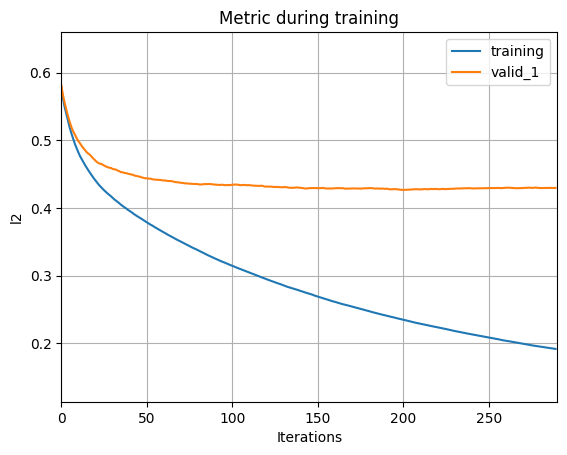

----> || Train Optimized QWK SCORE ::  0.778
----> || Val Optimized QWK SCORE ::  0.497
----> || Train Optimized Val QWK SCORE ::  0.492
----> || Val Optimized Train QWK SCORE ::  0.771
Fold 1 - Rounded Train QWK: 0.6795, Rounded Validation QWK: 0.3815


<Figure size 640x480 with 0 Axes>

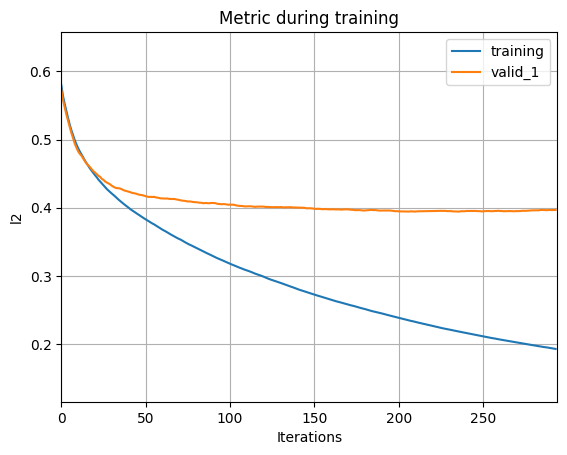

----> || Train Optimized QWK SCORE ::  0.781
----> || Val Optimized QWK SCORE ::  0.518
----> || Train Optimized Val QWK SCORE ::  0.555
----> || Val Optimized Train QWK SCORE ::  0.713
Fold 2 - Rounded Train QWK: 0.6942, Rounded Validation QWK: 0.4929


<Figure size 640x480 with 0 Axes>

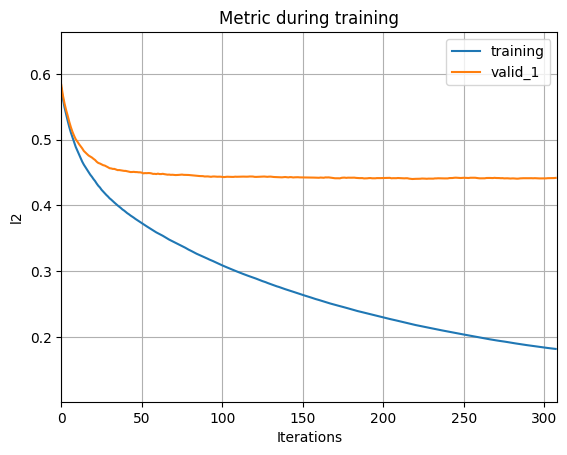

----> || Train Optimized QWK SCORE ::  0.805
----> || Val Optimized QWK SCORE ::  0.506
----> || Train Optimized Val QWK SCORE ::  0.490
----> || Val Optimized Train QWK SCORE ::  0.790
Fold 3 - Rounded Train QWK: 0.7082, Rounded Validation QWK: 0.4038


<Figure size 640x480 with 0 Axes>

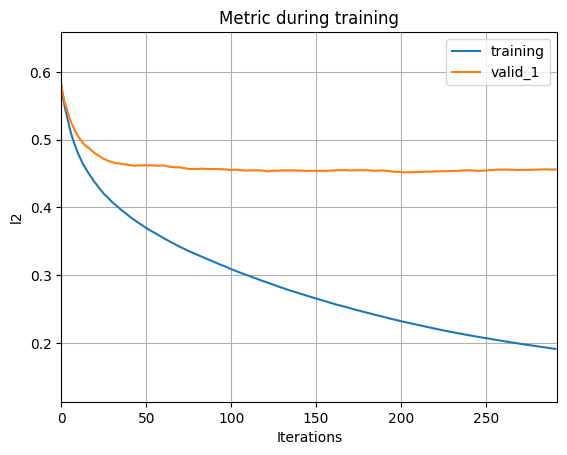

----> || Train Optimized QWK SCORE ::  0.778
----> || Val Optimized QWK SCORE ::  0.485
----> || Train Optimized Val QWK SCORE ::  0.446
----> || Val Optimized Train QWK SCORE ::  0.756
Fold 4 - Rounded Train QWK: 0.6982, Rounded Validation QWK: 0.3524


<Figure size 640x480 with 0 Axes>

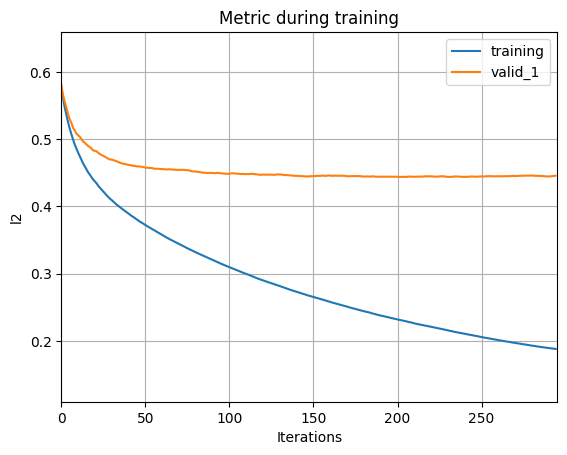

----> || Train Optimized QWK SCORE ::  0.786
----> || Val Optimized QWK SCORE ::  0.451
----> || Train Optimized Val QWK SCORE ::  0.448
----> || Val Optimized Train QWK SCORE ::  0.756
Fold 5 - Rounded Train QWK: 0.6946, Rounded Validation QWK: 0.4095
Mean Train QWK --> 0.7856
Mean Validation QWK ---> 0.4914
----> || Optimized QWK SCORE ::  0.506


In [122]:
lgb_models_list5, lgb_submission_df, lgb_raw_train_preds, lgb_raw_test_preds, lgb_optuna_study = lgb_feature_selection(
    train_selected_df5, test_selected_df5, 300
)

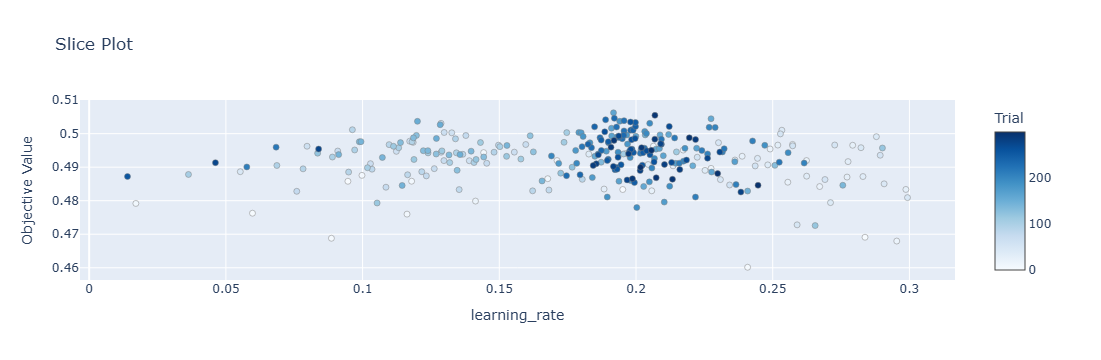

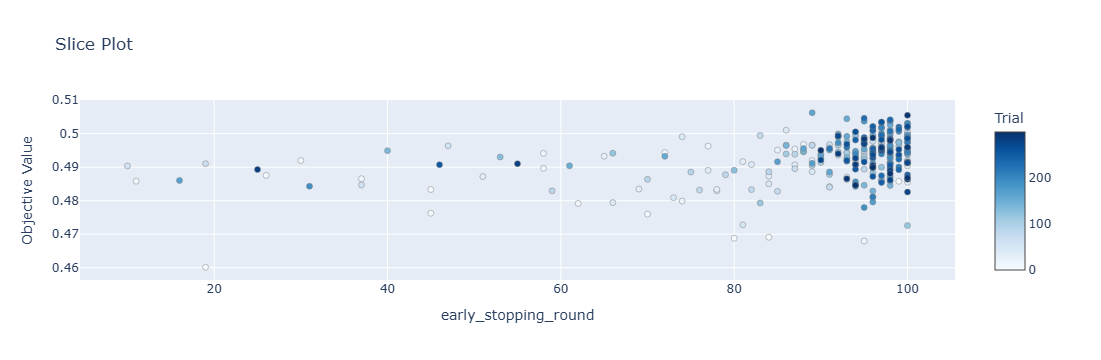

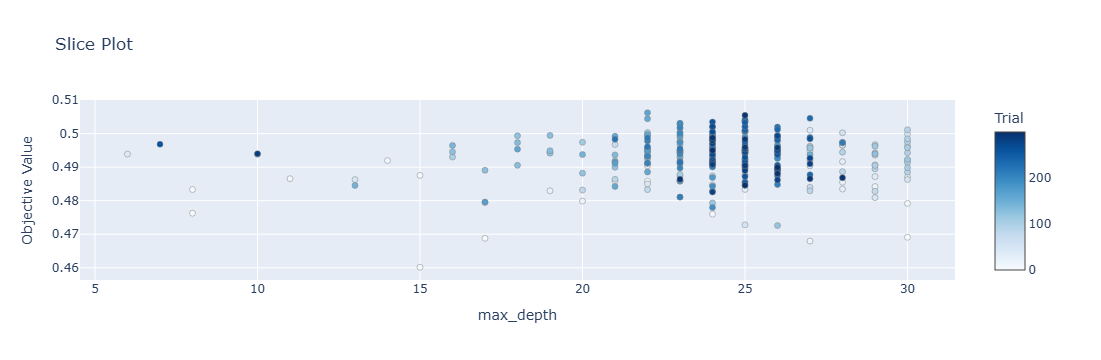

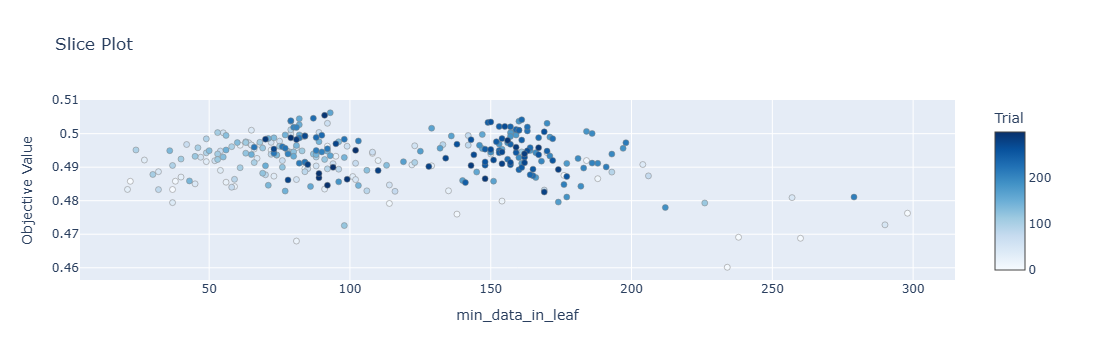

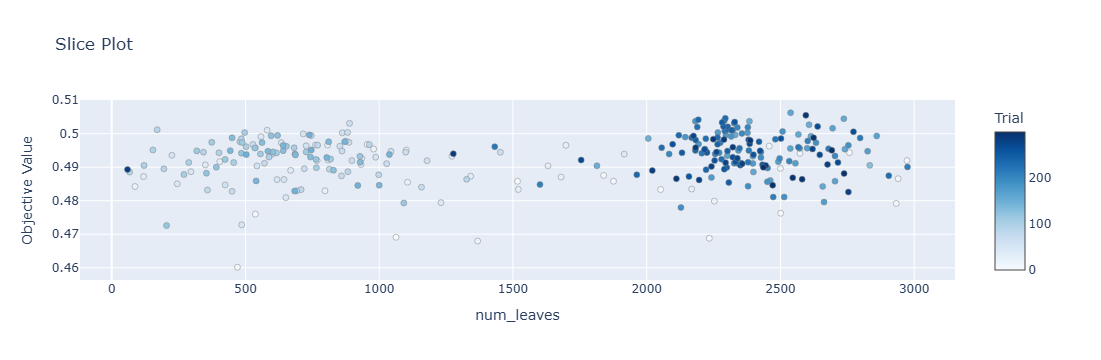

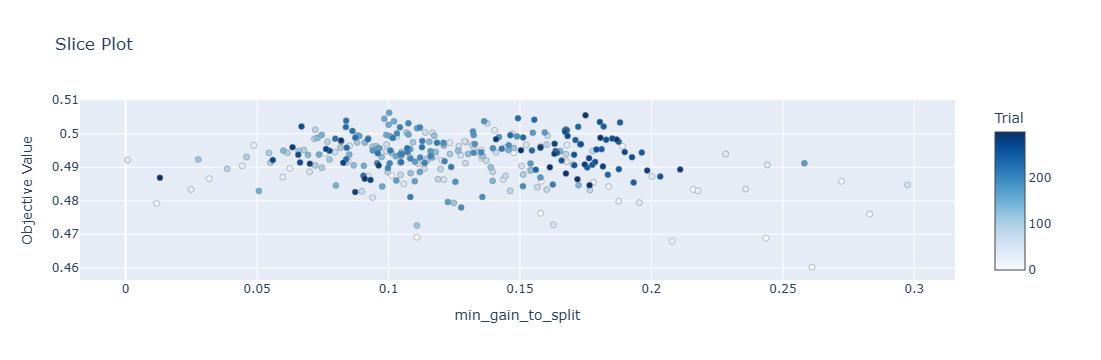

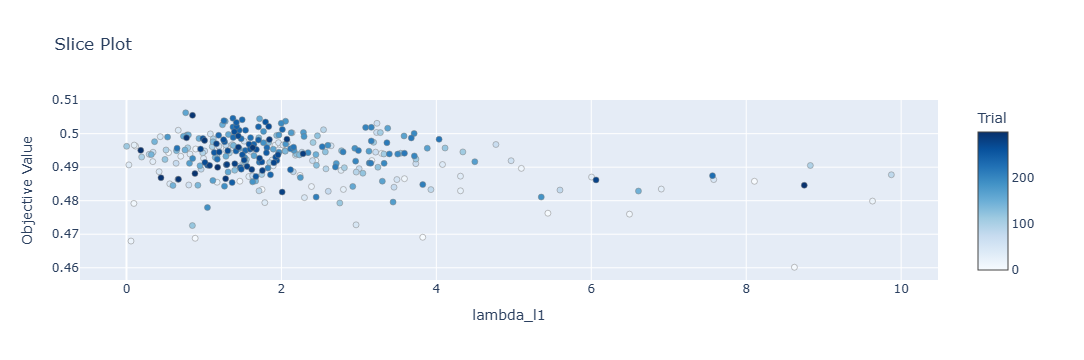

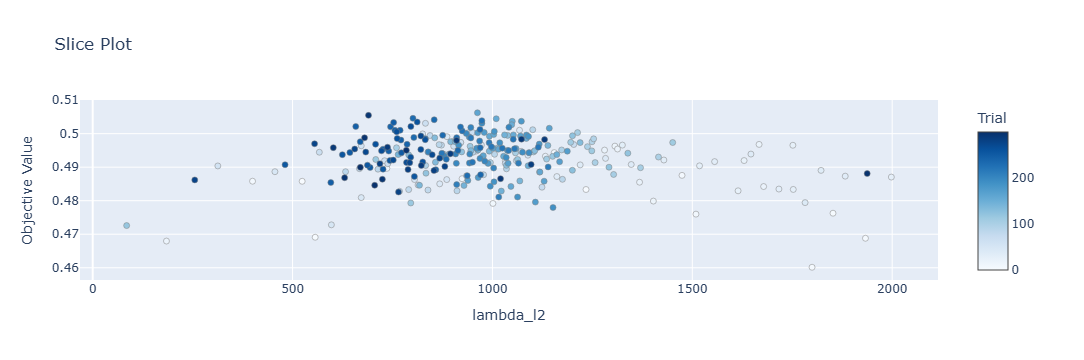

In [123]:
for param in lgb_optuna_study.best_params.keys():
    fig = plot_slice(lgb_optuna_study, params=[param])
    fig.show()

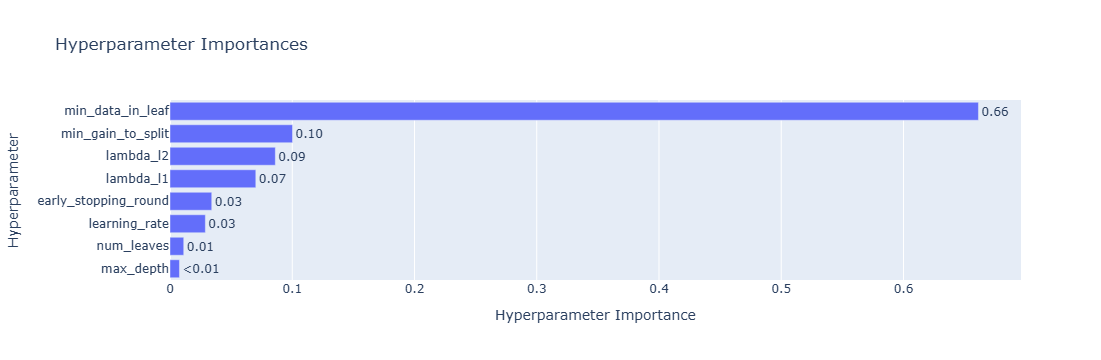

In [124]:
plot_param_importances(lgb_optuna_study)

In [125]:
lgb_optuna_study.best_params

{'learning_rate': 0.1917711299932182,
 'early_stopping_round': 89,
 'max_depth': 22,
 'min_data_in_leaf': 93,
 'num_leaves': 2538,
 'min_gain_to_split': 0.1002500586770935,
 'lambda_l1': 0.7644387795003902,
 'lambda_l2': 962.4960949220339}

In [127]:
cols = train_selected_df5.drop(['id', 'sii'], axis=1).columns
importance_list = []
for model in lgb_models_list5:
    importance_list.append(model.feature_importances_)

importance_mean = np.mean(importance_list, axis=0)
imp_df = pd.DataFrame(sorted(zip(cols, importance_mean)), columns=['Feature', 'Importance']).sort_values('Importance', ascending=False)
unimportant_df = imp_df[imp_df['Importance'] < imp_df['Importance'].quantile(0.5)]
unimportant_cols = unimportant_df['Feature'].tolist()

In [128]:
train_selected_df6 = train_selected_df5.drop(unimportant_cols, axis=1)
print(train_selected_df6.shape)
train_selected_df6.head()

(2736, 63)


id  CGAS-CGAS_Score  Physical-Height  Physical-HeartRate  FGC-FGC_CU  \
0  00008ff9             51.0             46.0                80.0         0.0   
1  000fd460             63.2             48.0                70.0         3.0   
2  00105258             71.0             56.5                94.0        20.0   
3  00115b9f             71.0             56.0                97.0        18.0   
4  001f3379             50.0             59.5                73.0        12.0   

   FGC-FGC_GSND  FGC-FGC_GSD  FGC-FGC_PU  BIA-BIA_BMC  BIA-BIA_FFMI  \
0         20.50        21.18         0.0     2.668550      13.81770   
1         23.08        24.94         5.0     2.579490      12.82540   
2         10.20        14.70         7.0     4.310264      24.52766   
3         17.66        19.24         5.0     3.841910      14.07400   
4         16.50        17.90         6.0     4.330360      16.68770   

   PAQ_A-PAQ_A_Total  SDS-SDS_Total_Raw  \
0              1.844               41.6   
1              1.704               46.0   
2              2.578               38.0   
3              2.018               31.0   
4              2.004               40.0   

   PreInt_EduHx-computerinternet_hoursday  X_weekday_4_mean  Y_weekday_6_sum  \
0                                     3.0          0.029699      -105.297590   
1                                     0.0          0.030971     -1221.787835   
2                                     2.0          0.013404       436.261438   
3                                     0.0         -0.213124       682.231018   
4                                     0.0          0.255062      1735.811646   

   Z_weekday_1_min  Z_weekday_3_std  Z_weekday_6_min  enmo_weekday_3_std  \
0        -1.001339         0.544952        -0.993339            0.088560   
1        -1.000690         0.592790        -1.021988            0.110911   
2        -1.001535         0.548045        -1.032027            0.123684   
3        -1.013281         0.554800        -1.019453            0.084379   
4        -1.011558         0.635620        -1.011636            0.026926   

   enmo_weekday_6_max  light_weekday_4_mean  \
0            2.353769             14.557556   
1            2.285202             21.486544   
2            3.491380             40.495487   
3            0.882914             25.983143   
4            1.740874             52.696568   

   battery_use_since_wear_weekday_1_30%  \
0                                217.05   
1                                201.00   
2                                205.60   
3                                147.00   
4                                228.00   

   battery_use_since_wear_weekday_3_mean  \
0                             213.972368   
1                             316.855106   
2                             280.658752   
3                             178.458450   
4                             139.089218   

   battery_use_since_wear_weekday_3_30%  battery_use_since_wear_weekday_5_max  \
0                             136.85000                             696.71665   
1                             284.86665                             507.16665   
2                             204.99334                             475.76665   
3                              95.00000                             359.00000   
4                              64.00000                             432.00000   

   X_time_of_day_hour_window_1_min  X_time_of_day_hour_window_1_entropy  \
0                        -0.782825                            32.649000   
1                        -0.881209                            15.545019   
2                        -0.971810                            37.654317   
3                        -0.857161                            10.899600   
4                        -1.006752                            12.202656   

   X_time_of_day_hour_window_2_sum  X_time_of_day_hour_window_4_mean  \
0                       239.102159                         -0.011758   
1        

In [129]:
test_selected_df6 = test_selected_df5.drop(unimportant_cols, axis=1)
print(test_selected_df6.shape)
test_selected_df6.head()

(20, 62)


id  CGAS-CGAS_Score  Physical-Height  Physical-HeartRate  FGC-FGC_CU  \
0  00008ff9             51.0           46.000                80.0         0.0   
1  000fd460             63.2           48.000                70.0         3.0   
2  00105258             71.0           56.500                94.0        20.0   
3  00115b9f             71.0           56.000                97.0        18.0   
4  0016bb22             65.8           66.878                75.4         5.8   

   FGC-FGC_GSND  FGC-FGC_GSD  FGC-FGC_PU  BIA-BIA_BMC  BIA-BIA_FFMI  \
0         20.50        21.18         0.0     2.668550      13.81770   
1         23.08        24.94         5.0     2.579490      12.82540   
2         10.20        14.70         7.0     4.310264      24.52766   
3         17.66        19.24         5.0     3.841910      14.07400   
4         28.28        27.96         4.2     5.477302      15.81610   

   PAQ_A-PAQ_A_Total  SDS-SDS_Total_Raw  \
0              1.844               41.6   
1              1.704               46.0   
2              2.578               38.0   
3              2.018               31.0   
4              1.040               65.2   

   PreInt_EduHx-computerinternet_hoursday  X_weekday_4_mean  Y_weekday_6_sum  \
0                                     3.0          0.029699      -105.297590   
1                                     0.0          0.030971     -1221.787835   
2                                     2.0          0.013404       436.261438   
3                                     0.0         -0.213124       682.231018   
4                                     2.2         -0.043651       533.215946   

   Z_weekday_1_min  Z_weekday_3_std  Z_weekday_6_min  enmo_weekday_3_std  \
0        -1.001339         0.544952        -0.993339            0.088560   
1        -1.000690         0.592790        -1.021988            0.110911   
2        -1.001535         0.548045        -1.032027            0.123684   
3        -1.013281         0.554800        -1.019453            0.084379   
4        -0.601322         0.555871        -0.600862            0.112979   

   enmo_weekday_6_max  light_weekday_4_mean  \
0            2.353769             14.557556   
1            2.285202             21.486544   
2            3.491380             40.495487   
3            0.882914             25.983143   
4            1.212740             15.765221   

   battery_use_since_wear_weekday_1_30%  \
0                                217.05   
1                                201.00   
2                                205.60   
3                                147.00   
4                                279.02   

   battery_use_since_wear_weekday_3_mean  \
0                             213.972368   
1                             316.855106   
2                             280.658752   
3                             178.458450   
4                             208.150089   

   battery_use_since_wear_weekday_3_30%  battery_use_since_wear_weekday_5_max  \
0                             136.85000                             696.71665   
1                             284.86665                             507.16665   
2                             204.99334                             475.76665   
3                              95.00000                             359.00000   
4                             166.18335                             586.00000   

   X_time_of_day_hour_window_1_min  X_time_of_day_hour_window_1_entropy  \
0                        -0.782825                            32.649000   
1                        -0.881209                            15.545019   
2                        -0.971810                            37.654317   
3                        -0.857161                            10.899600   
4                        -1.026245                            23.722354   

   X_time_of_day_hour_window_2_sum  X_time_of_day_hour_window_4_mean  \
0                       239.102159                         -0.011758   
1        

In [ ]:
lgb_models_list6, lgb_submission_df, lgb_raw_train_preds, lgb_raw_test_preds, lgb_optuna_study = lgb_feature_selection(
    train_selected_df6, test_selected_df6, 400
)

[I 2024-12-15 01:39:59,470] A new study created in memory with name: no-name-af7a33fc-d552-4fe0-ab3b-f5d18c3f22f7
[I 2024-12-15 01:40:03,535] Trial 0 finished with value: 0.46898855826550323 and parameters: {'learning_rate': 0.2667353483842392, 'early_stopping_round': 145, 'max_depth': 24, 'min_data_in_leaf': 268, 'num_leaves': 2063, 'min_gain_to_split': 0.02938293770446858, 'lambda_l1': 2.198898353541475, 'lambda_l2': 1196.856073223638}. Best is trial 0 with value: 0.46898855826550323.


----> || Optimized QWK SCORE ::  0.469


[I 2024-12-15 01:40:05,857] Trial 1 finished with value: 0.45800217828464207 and parameters: {'learning_rate': 0.17946945439348386, 'early_stopping_round': 190, 'max_depth': 24, 'min_data_in_leaf': 229, 'num_leaves': 789, 'min_gain_to_split': 0.1993791105631534, 'lambda_l1': 4.92215634218335, 'lambda_l2': 1646.4045044873822}. Best is trial 0 with value: 0.46898855826550323.


----> || Optimized QWK SCORE ::  0.458


[I 2024-12-15 01:40:10,189] Trial 2 finished with value: 0.4819272311551215 and parameters: {'learning_rate': 0.08357615396240314, 'early_stopping_round': 278, 'max_depth': 9, 'min_data_in_leaf': 198, 'num_leaves': 808, 'min_gain_to_split': 0.10360339474663358, 'lambda_l1': 6.720364582665011, 'lambda_l2': 1742.0812940781448}. Best is trial 2 with value: 0.4819272311551215.


----> || Optimized QWK SCORE ::  0.482


[I 2024-12-15 01:40:14,133] Trial 3 finished with value: 0.4624234814682868 and parameters: {'learning_rate': 0.031120969769311543, 'early_stopping_round': 178, 'max_depth': 27, 'min_data_in_leaf': 227, 'num_leaves': 934, 'min_gain_to_split': 0.25548458228444165, 'lambda_l1': 5.269057400067622, 'lambda_l2': 158.48291580522385}. Best is trial 2 with value: 0.4819272311551215.


----> || Optimized QWK SCORE ::  0.462


[I 2024-12-15 01:40:17,864] Trial 4 finished with value: 0.4526237918895044 and parameters: {'learning_rate': 0.1152003855171716, 'early_stopping_round': 187, 'max_depth': 29, 'min_data_in_leaf': 286, 'num_leaves': 2733, 'min_gain_to_split': 0.2434516405556504, 'lambda_l1': 7.30008407656651, 'lambda_l2': 1052.7438370161838}. Best is trial 2 with value: 0.4819272311551215.


----> || Optimized QWK SCORE ::  0.453


[I 2024-12-15 01:40:22,138] Trial 5 finished with value: 0.46509869639954193 and parameters: {'learning_rate': 0.07072224961356333, 'early_stopping_round': 199, 'max_depth': 30, 'min_data_in_leaf': 191, 'num_leaves': 2541, 'min_gain_to_split': 0.23825912149093254, 'lambda_l1': 8.817815608018124, 'lambda_l2': 1381.382801401895}. Best is trial 2 with value: 0.4819272311551215.


----> || Optimized QWK SCORE ::  0.465


[I 2024-12-15 01:40:25,628] Trial 6 finished with value: 0.47568767988711713 and parameters: {'learning_rate': 0.20869327179617855, 'early_stopping_round': 151, 'max_depth': 12, 'min_data_in_leaf': 150, 'num_leaves': 1189, 'min_gain_to_split': 0.06586874864200065, 'lambda_l1': 7.84823140739428, 'lambda_l2': 1821.2151375868007}. Best is trial 2 with value: 0.4819272311551215.


----> || Optimized QWK SCORE ::  0.476


[I 2024-12-15 01:40:31,741] Trial 7 finished with value: 0.48316835075150977 and parameters: {'learning_rate': 0.08616414930424876, 'early_stopping_round': 193, 'max_depth': 27, 'min_data_in_leaf': 127, 'num_leaves': 72, 'min_gain_to_split': 0.02035943747393296, 'lambda_l1': 5.210130890086454, 'lambda_l2': 1311.869598484887}. Best is trial 7 with value: 0.48316835075150977.


----> || Optimized QWK SCORE ::  0.483


[I 2024-12-15 01:40:36,476] Trial 8 finished with value: 0.46231803003335614 and parameters: {'learning_rate': 0.02989303278011462, 'early_stopping_round': 165, 'max_depth': 24, 'min_data_in_leaf': 214, 'num_leaves': 1459, 'min_gain_to_split': 0.1280271857218713, 'lambda_l1': 9.884583365696507, 'lambda_l2': 116.26804776906334}. Best is trial 7 with value: 0.48316835075150977.


----> || Optimized QWK SCORE ::  0.462


[I 2024-12-15 01:40:43,029] Trial 9 finished with value: 0.4743141290355387 and parameters: {'learning_rate': 0.0615766695380565, 'early_stopping_round': 206, 'max_depth': 27, 'min_data_in_leaf': 38, 'num_leaves': 892, 'min_gain_to_split': 0.12726968209403722, 'lambda_l1': 4.921492760036421, 'lambda_l2': 1473.9762321455132}. Best is trial 7 with value: 0.48316835075150977.


----> || Optimized QWK SCORE ::  0.474


[I 2024-12-15 01:40:45,615] Trial 10 finished with value: 0.4800481887730259 and parameters: {'learning_rate': 0.13366678123184142, 'early_stopping_round': 38, 'max_depth': 17, 'min_data_in_leaf': 109, 'num_leaves': 105, 'min_gain_to_split': 0.0006810775039431047, 'lambda_l1': 0.3979842679221175, 'lambda_l2': 527.5745574795692}. Best is trial 7 with value: 0.48316835075150977.


----> || Optimized QWK SCORE ::  0.480


[I 2024-12-15 01:40:50,399] Trial 11 finished with value: 0.47606441255937704 and parameters: {'learning_rate': 0.09605273170621846, 'early_stopping_round': 292, 'max_depth': 7, 'min_data_in_leaf': 111, 'num_leaves': 226, 'min_gain_to_split': 0.08256246603241471, 'lambda_l1': 6.161441228162698, 'lambda_l2': 1946.7217688920102}. Best is trial 7 with value: 0.48316835075150977.


----> || Optimized QWK SCORE ::  0.476


[I 2024-12-15 01:40:53,764] Trial 12 finished with value: 0.4777673662063966 and parameters: {'learning_rate': 0.163711796678346, 'early_stopping_round': 296, 'max_depth': 17, 'min_data_in_leaf': 146, 'num_leaves': 381, 'min_gain_to_split': 0.07353395189141647, 'lambda_l1': 3.601384805948477, 'lambda_l2': 664.3626630759668}. Best is trial 7 with value: 0.48316835075150977.


----> || Optimized QWK SCORE ::  0.478


[I 2024-12-15 01:40:57,152] Trial 13 finished with value: 0.4757642278027969 and parameters: {'learning_rate': 0.08786524370533685, 'early_stopping_round': 246, 'max_depth': 8, 'min_data_in_leaf': 73, 'num_leaves': 577, 'min_gain_to_split': 0.1725683643883802, 'lambda_l1': 6.82612704997322, 'lambda_l2': 1586.2020767705537}. Best is trial 7 with value: 0.48316835075150977.


----> || Optimized QWK SCORE ::  0.476


[I 2024-12-15 01:41:13,029] Trial 14 finished with value: 0.48304581615863484 and parameters: {'learning_rate': 0.017547820293254524, 'early_stopping_round': 100, 'max_depth': 13, 'min_data_in_leaf': 174, 'num_leaves': 1845, 'min_gain_to_split': 0.036216576532150005, 'lambda_l1': 3.360375923068645, 'lambda_l2': 816.3436105738242}. Best is trial 7 with value: 0.48316835075150977.


----> || Optimized QWK SCORE ::  0.483


[I 2024-12-15 01:41:25,168] Trial 15 finished with value: 0.4904499278050434 and parameters: {'learning_rate': 0.023660425868677185, 'early_stopping_round': 92, 'max_depth': 13, 'min_data_in_leaf': 109, 'num_leaves': 1909, 'min_gain_to_split': 0.026823359819498904, 'lambda_l1': 2.8095736936380593, 'lambda_l2': 848.8066325377151}. Best is trial 15 with value: 0.4904499278050434.


----> || Optimized QWK SCORE ::  0.490


[I 2024-12-15 01:41:50,196] Trial 16 finished with value: 0.48424036106811463 and parameters: {'learning_rate': 0.011220752887608617, 'early_stopping_round': 86, 'max_depth': 20, 'min_data_in_leaf': 103, 'num_leaves': 2290, 'min_gain_to_split': 0.009698472916162937, 'lambda_l1': 1.190022102348732, 'lambda_l2': 1232.6307871337638}. Best is trial 15 with value: 0.4904499278050434.


----> || Optimized QWK SCORE ::  0.484


[I 2024-12-15 01:42:16,349] Trial 17 finished with value: 0.48369930799334404 and parameters: {'learning_rate': 0.010267554637933558, 'early_stopping_round': 68, 'max_depth': 21, 'min_data_in_leaf': 69, 'num_leaves': 2325, 'min_gain_to_split': 0.04883168921685445, 'lambda_l1': 0.2790390828395546, 'lambda_l2': 886.1202447264654}. Best is trial 15 with value: 0.4904499278050434.


----> || Optimized QWK SCORE ::  0.484


[I 2024-12-15 01:42:25,669] Trial 18 finished with value: 0.490992278062101 and parameters: {'learning_rate': 0.04834550753776755, 'early_stopping_round': 113, 'max_depth': 14, 'min_data_in_leaf': 70, 'num_leaves': 2937, 'min_gain_to_split': 0.004014868313785391, 'lambda_l1': 1.5725341869575378, 'lambda_l2': 431.3117129716786}. Best is trial 18 with value: 0.490992278062101.


----> || Optimized QWK SCORE ::  0.491


[I 2024-12-15 01:42:31,555] Trial 19 finished with value: 0.4785072027363053 and parameters: {'learning_rate': 0.05270571329057211, 'early_stopping_round': 115, 'max_depth': 14, 'min_data_in_leaf': 33, 'num_leaves': 2856, 'min_gain_to_split': 0.29139232977990537, 'lambda_l1': 2.3463074202028857, 'lambda_l2': 415.8870963589389}. Best is trial 18 with value: 0.490992278062101.


----> || Optimized QWK SCORE ::  0.479


[I 2024-12-15 01:42:34,130] Trial 20 finished with value: 0.4711249385493007 and parameters: {'learning_rate': 0.28686914956705306, 'early_stopping_round': 12, 'max_depth': 11, 'min_data_in_leaf': 72, 'num_leaves': 1639, 'min_gain_to_split': 0.10345077802160552, 'lambda_l1': 3.2988183435798657, 'lambda_l2': 397.26815230893305}. Best is trial 18 with value: 0.490992278062101.


----> || Optimized QWK SCORE ::  0.471


[I 2024-12-15 01:42:43,544] Trial 21 finished with value: 0.4731601723338176 and parameters: {'learning_rate': 0.04813297348268361, 'early_stopping_round': 89, 'max_depth': 20, 'min_data_in_leaf': 95, 'num_leaves': 2987, 'min_gain_to_split': 0.008170678149398541, 'lambda_l1': 1.3714772685631555, 'lambda_l2': 1030.6587617360763}. Best is trial 18 with value: 0.490992278062101.


----> || Optimized QWK SCORE ::  0.473


[I 2024-12-15 01:42:56,742] Trial 22 finished with value: 0.4788366930511021 and parameters: {'learning_rate': 0.04362671365645731, 'early_stopping_round': 123, 'max_depth': 16, 'min_data_in_leaf': 48, 'num_leaves': 2204, 'min_gain_to_split': 0.04906623619013535, 'lambda_l1': 1.6522420486744487, 'lambda_l2': 804.8394386552399}. Best is trial 18 with value: 0.490992278062101.


----> || Optimized QWK SCORE ::  0.479


[I 2024-12-15 01:43:14,956] Trial 23 finished with value: 0.4788979071937438 and parameters: {'learning_rate': 0.011807226704251932, 'early_stopping_round': 65, 'max_depth': 15, 'min_data_in_leaf': 94, 'num_leaves': 2538, 'min_gain_to_split': 0.0010969498887254212, 'lambda_l1': 1.0198702449709534, 'lambda_l2': 608.9729376952895}. Best is trial 18 with value: 0.490992278062101.


----> || Optimized QWK SCORE ::  0.479


[I 2024-12-15 01:43:20,385] Trial 24 finished with value: 0.48497733645865104 and parameters: {'learning_rate': 0.11304431684898841, 'early_stopping_round': 72, 'max_depth': 19, 'min_data_in_leaf': 121, 'num_leaves': 2038, 'min_gain_to_split': 0.04913610754183813, 'lambda_l1': 2.7296259671965717, 'lambda_l2': 1149.8636059068904}. Best is trial 18 with value: 0.490992278062101.


----> || Optimized QWK SCORE ::  0.485


[I 2024-12-15 01:43:24,035] Trial 25 finished with value: 0.4837069455475811 and parameters: {'learning_rate': 0.12075098714231135, 'early_stopping_round': 48, 'max_depth': 10, 'min_data_in_leaf': 133, 'num_leaves': 1923, 'min_gain_to_split': 0.05203502221814639, 'lambda_l1': 2.6757551431776054, 'lambda_l2': 359.97573171337666}. Best is trial 18 with value: 0.490992278062101.


----> || Optimized QWK SCORE ::  0.484


[I 2024-12-15 01:43:28,273] Trial 26 finished with value: 0.4915345044508478 and parameters: {'learning_rate': 0.19769125802554435, 'early_stopping_round': 129, 'max_depth': 19, 'min_data_in_leaf': 22, 'num_leaves': 1590, 'min_gain_to_split': 0.09257278234518185, 'lambda_l1': 4.111236642263389, 'lambda_l2': 954.7649948688891}. Best is trial 26 with value: 0.4915345044508478.


----> || Optimized QWK SCORE ::  0.492


[I 2024-12-15 01:43:31,652] Trial 27 finished with value: 0.48273724713629085 and parameters: {'learning_rate': 0.23685823387238703, 'early_stopping_round': 126, 'max_depth': 6, 'min_data_in_leaf': 22, 'num_leaves': 1506, 'min_gain_to_split': 0.09398019239598349, 'lambda_l1': 4.165399059861568, 'lambda_l2': 706.1476670192517}. Best is trial 26 with value: 0.4915345044508478.


----> || Optimized QWK SCORE ::  0.483


[I 2024-12-15 01:43:34,469] Trial 28 finished with value: 0.47404717836450316 and parameters: {'learning_rate': 0.19824472496193818, 'early_stopping_round': 140, 'max_depth': 22, 'min_data_in_leaf': 60, 'num_leaves': 1180, 'min_gain_to_split': 0.16218118183842253, 'lambda_l1': 3.9920845749376523, 'lambda_l2': 943.6320526549148}. Best is trial 26 with value: 0.4915345044508478.


----> || Optimized QWK SCORE ::  0.474


[I 2024-12-15 01:43:38,262] Trial 29 finished with value: 0.48346523358182714 and parameters: {'learning_rate': 0.24617281362489637, 'early_stopping_round': 108, 'max_depth': 14, 'min_data_in_leaf': 85, 'num_leaves': 1722, 'min_gain_to_split': 0.02943895191138149, 'lambda_l1': 2.0275800402497657, 'lambda_l2': 246.73281858277193}. Best is trial 26 with value: 0.4915345044508478.


----> || Optimized QWK SCORE ::  0.483


[I 2024-12-15 01:43:41,898] Trial 30 finished with value: 0.4815002548073811 and parameters: {'learning_rate': 0.14001091963320722, 'early_stopping_round': 140, 'max_depth': 18, 'min_data_in_leaf': 48, 'num_leaves': 1352, 'min_gain_to_split': 0.12858488665163917, 'lambda_l1': 4.139637436293023, 'lambda_l2': 534.8367833666264}. Best is trial 26 with value: 0.4915345044508478.


----> || Optimized QWK SCORE ::  0.482


[I 2024-12-15 01:43:46,031] Trial 31 finished with value: 0.47966670010833257 and parameters: {'learning_rate': 0.21581972320114412, 'early_stopping_round': 76, 'max_depth': 19, 'min_data_in_leaf': 118, 'num_leaves': 1994, 'min_gain_to_split': 0.034130668768834777, 'lambda_l1': 2.8874447836692103, 'lambda_l2': 1090.971836710627}. Best is trial 26 with value: 0.4915345044508478.


----> || Optimized QWK SCORE ::  0.480


[I 2024-12-15 01:43:51,489] Trial 32 finished with value: 0.4862834512942217 and parameters: {'learning_rate': 0.17524273823761777, 'early_stopping_round': 45, 'max_depth': 16, 'min_data_in_leaf': 23, 'num_leaves': 2137, 'min_gain_to_split': 0.06827760702092141, 'lambda_l1': 2.101013889136148, 'lambda_l2': 1178.4295702513684}. Best is trial 26 with value: 0.4915345044508478.


----> || Optimized QWK SCORE ::  0.486


[I 2024-12-15 01:43:56,622] Trial 33 finished with value: 0.4875978025636757 and parameters: {'learning_rate': 0.1883529165005328, 'early_stopping_round': 43, 'max_depth': 15, 'min_data_in_leaf': 20, 'num_leaves': 1741, 'min_gain_to_split': 0.07040178063464772, 'lambda_l1': 1.9863312769045702, 'lambda_l2': 1259.0685733032765}. Best is trial 26 with value: 0.4915345044508478.


----> || Optimized QWK SCORE ::  0.488


[I 2024-12-15 01:43:59,964] Trial 34 finished with value: 0.4816364921498022 and parameters: {'learning_rate': 0.1916955891192693, 'early_stopping_round': 13, 'max_depth': 12, 'min_data_in_leaf': 52, 'num_leaves': 1746, 'min_gain_to_split': 0.09024663321142885, 'lambda_l1': 0.6886986050048274, 'lambda_l2': 749.0225697467839}. Best is trial 26 with value: 0.4915345044508478.


----> || Optimized QWK SCORE ::  0.482


[I 2024-12-15 01:44:02,968] Trial 35 finished with value: 0.4802716759200333 and parameters: {'learning_rate': 0.2276362854125955, 'early_stopping_round': 94, 'max_depth': 10, 'min_data_in_leaf': 37, 'num_leaves': 1212, 'min_gain_to_split': 0.11736795997468154, 'lambda_l1': 4.69941695050276, 'lambda_l2': 938.6639075865038}. Best is trial 26 with value: 0.4915345044508478.


----> || Optimized QWK SCORE ::  0.480


[I 2024-12-15 01:44:09,447] Trial 36 finished with value: 0.48481571257590317 and parameters: {'learning_rate': 0.25610525324260436, 'early_stopping_round': 29, 'max_depth': 14, 'min_data_in_leaf': 23, 'num_leaves': 2494, 'min_gain_to_split': 0.022629421990673235, 'lambda_l1': 1.7714155046190134, 'lambda_l2': 1456.682580186358}. Best is trial 26 with value: 0.4915345044508478.


----> || Optimized QWK SCORE ::  0.485


[I 2024-12-15 01:44:12,422] Trial 37 finished with value: 0.4751214555615534 and parameters: {'learning_rate': 0.15979227846948152, 'early_stopping_round': 163, 'max_depth': 12, 'min_data_in_leaf': 75, 'num_leaves': 1026, 'min_gain_to_split': 0.20101231499804106, 'lambda_l1': 3.1383865432767784, 'lambda_l2': 1238.4214385576597}. Best is trial 26 with value: 0.4915345044508478.


----> || Optimized QWK SCORE ::  0.475


[I 2024-12-15 01:44:16,374] Trial 38 finished with value: 0.48532219766389506 and parameters: {'learning_rate': 0.17795242782951948, 'early_stopping_round': 53, 'max_depth': 23, 'min_data_in_leaf': 61, 'num_leaves': 1381, 'min_gain_to_split': 0.06198175560688439, 'lambda_l1': 5.58521937690425, 'lambda_l2': 975.1988523623914}. Best is trial 26 with value: 0.4915345044508478.


----> || Optimized QWK SCORE ::  0.485


[I 2024-12-15 01:44:20,186] Trial 39 finished with value: 0.46338444372771737 and parameters: {'learning_rate': 0.1475793125165106, 'early_stopping_round': 130, 'max_depth': 16, 'min_data_in_leaf': 249, 'num_leaves': 2741, 'min_gain_to_split': 0.11113884116860474, 'lambda_l1': 3.8265882115403658, 'lambda_l2': 238.57439369695146}. Best is trial 26 with value: 0.4915345044508478.


----> || Optimized QWK SCORE ::  0.463


[I 2024-12-15 01:44:24,141] Trial 40 finished with value: 0.459813528385572 and parameters: {'learning_rate': 0.0723683833630736, 'early_stopping_round': 29, 'max_depth': 18, 'min_data_in_leaf': 296, 'num_leaves': 1610, 'min_gain_to_split': 0.07830463575558147, 'lambda_l1': 0.044817931372985065, 'lambda_l2': 1372.738135818164}. Best is trial 26 with value: 0.4915345044508478.


----> || Optimized QWK SCORE ::  0.460


[I 2024-12-15 01:44:30,018] Trial 41 finished with value: 0.48849608746532835 and parameters: {'learning_rate': 0.1751862856796107, 'early_stopping_round': 57, 'max_depth': 15, 'min_data_in_leaf': 21, 'num_leaves': 1851, 'min_gain_to_split': 0.059733367780645405, 'lambda_l1': 2.2704833967556803, 'lambda_l2': 1082.213148159279}. Best is trial 26 with value: 0.4915345044508478.


----> || Optimized QWK SCORE ::  0.488


[I 2024-12-15 01:44:35,931] Trial 42 finished with value: 0.48058540149318474 and parameters: {'learning_rate': 0.2031727770801172, 'early_stopping_round': 59, 'max_depth': 15, 'min_data_in_leaf': 39, 'num_leaves': 2432, 'min_gain_to_split': 0.02174613859224826, 'lambda_l1': 2.207773242306768, 'lambda_l2': 1082.188046352529}. Best is trial 26 with value: 0.4915345044508478.


----> || Optimized QWK SCORE ::  0.481


[I 2024-12-15 01:44:39,623] Trial 43 finished with value: 0.4827697639928612 and parameters: {'learning_rate': 0.18876916100074956, 'early_stopping_round': 82, 'max_depth': 13, 'min_data_in_leaf': 86, 'num_leaves': 1791, 'min_gain_to_split': 0.03792249488828372, 'lambda_l1': 2.571246278838104, 'lambda_l2': 50.397770791597736}. Best is trial 26 with value: 0.4915345044508478.


----> || Optimized QWK SCORE ::  0.483


[I 2024-12-15 01:45:00,825] Trial 44 finished with value: 0.4844163252605923 and parameters: {'learning_rate': 0.032054164025355394, 'early_stopping_round': 224, 'max_depth': 17, 'min_data_in_leaf': 20, 'num_leaves': 1871, 'min_gain_to_split': 0.05958756065537843, 'lambda_l1': 4.400280497540496, 'lambda_l2': 1289.7663298634734}. Best is trial 26 with value: 0.4915345044508478.


----> || Optimized QWK SCORE ::  0.484


[I 2024-12-15 01:45:05,394] Trial 45 finished with value: 0.4953948096591455 and parameters: {'learning_rate': 0.22199259349470682, 'early_stopping_round': 108, 'max_depth': 15, 'min_data_in_leaf': 55, 'num_leaves': 1590, 'min_gain_to_split': 0.08075433602593132, 'lambda_l1': 1.0355241508881832, 'lambda_l2': 838.4806350556951}. Best is trial 45 with value: 0.4953948096591455.


----> || Optimized QWK SCORE ::  0.495


[I 2024-12-15 01:45:08,964] Trial 46 finished with value: 0.48288769668900844 and parameters: {'learning_rate': 0.22563141934480668, 'early_stopping_round': 111, 'max_depth': 13, 'min_data_in_leaf': 54, 'num_leaves': 1323, 'min_gain_to_split': 0.14289535671249531, 'lambda_l1': 0.7366525905380855, 'lambda_l2': 844.2464357031151}. Best is trial 45 with value: 0.4953948096591455.


----> || Optimized QWK SCORE ::  0.483


[I 2024-12-15 01:45:12,133] Trial 47 finished with value: 0.47884657532828157 and parameters: {'learning_rate': 0.2713369987204823, 'early_stopping_round': 155, 'max_depth': 11, 'min_data_in_leaf': 40, 'num_leaves': 654, 'min_gain_to_split': 0.09529446865839805, 'lambda_l1': 1.5513905289618743, 'lambda_l2': 588.4654572499073}. Best is trial 45 with value: 0.4953948096591455.


----> || Optimized QWK SCORE ::  0.479


[I 2024-12-15 01:45:17,968] Trial 48 finished with value: 0.4886504300511376 and parameters: {'learning_rate': 0.21372026918420708, 'early_stopping_round': 170, 'max_depth': 9, 'min_data_in_leaf': 65, 'num_leaves': 1475, 'min_gain_to_split': 0.016433454800974866, 'lambda_l1': 0.8347911833457216, 'lambda_l2': 760.97683016767}. Best is trial 45 with value: 0.4953948096591455.


----> || Optimized QWK SCORE ::  0.489


[I 2024-12-15 01:45:21,390] Trial 49 finished with value: 0.41541057118121083 and parameters: {'learning_rate': 0.222062627478548, 'early_stopping_round': 187, 'max_depth': 8, 'min_data_in_leaf': 156, 'num_leaves': 1047, 'min_gain_to_split': 0.01248793888604282, 'lambda_l1': 0.7932412945508411, 'lambda_l2': 728.017013248389}. Best is trial 45 with value: 0.4953948096591455.


----> || Optimized QWK SCORE ::  0.415


[I 2024-12-15 01:45:26,238] Trial 50 finished with value: 0.4828095932995574 and parameters: {'learning_rate': 0.20960487683091217, 'early_stopping_round': 172, 'max_depth': 9, 'min_data_in_leaf': 79, 'num_leaves': 1608, 'min_gain_to_split': 0.0385535330792605, 'lambda_l1': 1.1551078107977997, 'lambda_l2': 497.8589380716447}. Best is trial 45 with value: 0.4953948096591455.


----> || Optimized QWK SCORE ::  0.483


[I 2024-12-15 01:45:31,393] Trial 51 finished with value: 0.4819742221474671 and parameters: {'learning_rate': 0.23797247293883536, 'early_stopping_round': 102, 'max_depth': 11, 'min_data_in_leaf': 62, 'num_leaves': 1586, 'min_gain_to_split': 0.018511188268101088, 'lambda_l1': 1.4165142213544981, 'lambda_l2': 920.7428022040663}. Best is trial 45 with value: 0.4953948096591455.


----> || Optimized QWK SCORE ::  0.482


[I 2024-12-15 01:45:35,741] Trial 52 finished with value: 0.48434600787657556 and parameters: {'learning_rate': 0.17371014836953932, 'early_stopping_round': 150, 'max_depth': 18, 'min_data_in_leaf': 173, 'num_leaves': 1458, 'min_gain_to_split': 0.027179770052661555, 'lambda_l1': 0.4272262107215661, 'lambda_l2': 838.4647343191475}. Best is trial 45 with value: 0.4953948096591455.


----> || Optimized QWK SCORE ::  0.484


[I 2024-12-15 01:45:47,761] Trial 53 finished with value: 0.48392434029914544 and parameters: {'learning_rate': 0.027513055052732185, 'early_stopping_round': 117, 'max_depth': 14, 'min_data_in_leaf': 134, 'num_leaves': 2171, 'min_gain_to_split': 0.07848449638888724, 'lambda_l1': 3.114762399176627, 'lambda_l2': 996.6469899095341}. Best is trial 45 with value: 0.4953948096591455.


----> || Optimized QWK SCORE ::  0.484


[I 2024-12-15 01:45:55,051] Trial 54 finished with value: 0.4761691872630741 and parameters: {'learning_rate': 0.16962591600498636, 'early_stopping_round': 212, 'max_depth': 25, 'min_data_in_leaf': 33, 'num_leaves': 1929, 'min_gain_to_split': 0.042730626553654345, 'lambda_l1': 2.475515245481582, 'lambda_l2': 645.568656307229}. Best is trial 45 with value: 0.4953948096591455.


----> || Optimized QWK SCORE ::  0.476


[I 2024-12-15 01:46:04,355] Trial 55 finished with value: 0.48477821905691554 and parameters: {'learning_rate': 0.06585136258996885, 'early_stopping_round': 132, 'max_depth': 16, 'min_data_in_leaf': 102, 'num_leaves': 2659, 'min_gain_to_split': 0.0011138402480410196, 'lambda_l1': 5.715411360737138, 'lambda_l2': 781.3788507005789}. Best is trial 45 with value: 0.4953948096591455.


----> || Optimized QWK SCORE ::  0.485


[I 2024-12-15 01:46:08,340] Trial 56 finished with value: 0.47703648434234247 and parameters: {'learning_rate': 0.25965768775049425, 'early_stopping_round': 98, 'max_depth': 12, 'min_data_in_leaf': 44, 'num_leaves': 1207, 'min_gain_to_split': 0.06064260549088011, 'lambda_l1': 3.5015046568283594, 'lambda_l2': 885.0820187426245}. Best is trial 45 with value: 0.4953948096591455.


----> || Optimized QWK SCORE ::  0.477


[I 2024-12-15 01:46:14,480] Trial 57 finished with value: 0.4916522637777738 and parameters: {'learning_rate': 0.1516798821054697, 'early_stopping_round': 178, 'max_depth': 17, 'min_data_in_leaf': 68, 'num_leaves': 1466, 'min_gain_to_split': 0.05560742530952026, 'lambda_l1': 1.757473978935418, 'lambda_l2': 1099.0202769836924}. Best is trial 45 with value: 0.4953948096591455.


----> || Optimized QWK SCORE ::  0.492


[I 2024-12-15 01:46:17,384] Trial 58 finished with value: 0.4739953327081198 and parameters: {'learning_rate': 0.2957799468311522, 'early_stopping_round': 177, 'max_depth': 20, 'min_data_in_leaf': 92, 'num_leaves': 1484, 'min_gain_to_split': 0.19853341554868537, 'lambda_l1': 0.8674118756511977, 'lambda_l2': 474.3798480335404}. Best is trial 45 with value: 0.4953948096591455.


----> || Optimized QWK SCORE ::  0.474


[I 2024-12-15 01:46:24,208] Trial 59 finished with value: 0.4884891441119479 and parameters: {'learning_rate': 0.10497354890706706, 'early_stopping_round': 163, 'max_depth': 21, 'min_data_in_leaf': 60, 'num_leaves': 857, 'min_gain_to_split': 0.013902210621574344, 'lambda_l1': 1.7399421239707333, 'lambda_l2': 307.21088356011046}. Best is trial 45 with value: 0.4953948096591455.


----> || Optimized QWK SCORE ::  0.488


[I 2024-12-15 01:46:27,275] Trial 60 finished with value: 0.47763875273882117 and parameters: {'learning_rate': 0.27325493109605903, 'early_stopping_round': 194, 'max_depth': 17, 'min_data_in_leaf': 69, 'num_leaves': 1289, 'min_gain_to_split': 0.08341528182982556, 'lambda_l1': 9.575231145391628, 'lambda_l2': 1158.1883242633132}. Best is trial 45 with value: 0.4953948096591455.


----> || Optimized QWK SCORE ::  0.478


[I 2024-12-15 01:46:35,103] Trial 61 finished with value: 0.4845358664158733 and parameters: {'learning_rate': 0.13081585081064184, 'early_stopping_round': 143, 'max_depth': 15, 'min_data_in_leaf': 31, 'num_leaves': 1699, 'min_gain_to_split': 0.056219423753982284, 'lambda_l1': 1.0844378812001387, 'lambda_l2': 1042.4714249884069}. Best is trial 45 with value: 0.4953948096591455.


----> || Optimized QWK SCORE ::  0.485


[I 2024-12-15 01:46:39,602] Trial 62 finished with value: 0.49142295803965075 and parameters: {'learning_rate': 0.20976051469358126, 'early_stopping_round': 87, 'max_depth': 19, 'min_data_in_leaf': 80, 'num_leaves': 1411, 'min_gain_to_split': 0.04109890809714449, 'lambda_l1': 0.41332450518221286, 'lambda_l2': 1137.4439298253806}. Best is trial 45 with value: 0.4953948096591455.


----> || Optimized QWK SCORE ::  0.491


[I 2024-12-15 01:46:43,807] Trial 63 finished with value: 0.4904904462135422 and parameters: {'learning_rate': 0.2371991521316883, 'early_stopping_round': 120, 'max_depth': 21, 'min_data_in_leaf': 85, 'num_leaves': 1021, 'min_gain_to_split': 0.046184376717776796, 'lambda_l1': 0.016629415386041235, 'lambda_l2': 1124.539844907826}. Best is trial 45 with value: 0.4953948096591455.


----> || Optimized QWK SCORE ::  0.490


[I 2024-12-15 01:46:48,193] Trial 64 finished with value: 0.4876322134705031 and parameters: {'learning_rate': 0.24344321048662299, 'early_stopping_round': 120, 'max_depth': 19, 'min_data_in_leaf': 80, 'num_leaves': 1041, 'min_gain_to_split': 0.045035224796821226, 'lambda_l1': 0.09314441943443455, 'lambda_l2': 1121.9393098961623}. Best is trial 45 with value: 0.4953948096591455.


----> || Optimized QWK SCORE ::  0.488


[I 2024-12-15 01:46:52,493] Trial 65 finished with value: 0.48245741738244285 and parameters: {'learning_rate': 0.23144747913150013, 'early_stopping_round': 104, 'max_depth': 22, 'min_data_in_leaf': 101, 'num_leaves': 1101, 'min_gain_to_split': 0.02913723208903251, 'lambda_l1': 0.4880053320165527, 'lambda_l2': 1596.901131323517}. Best is trial 45 with value: 0.4953948096591455.


----> || Optimized QWK SCORE ::  0.482


[I 2024-12-15 01:47:02,192] Trial 66 finished with value: 0.48406512936852086 and parameters: {'learning_rate': 0.03929021996200137, 'early_stopping_round': 84, 'max_depth': 25, 'min_data_in_leaf': 86, 'num_leaves': 734, 'min_gain_to_split': 0.10330855464240818, 'lambda_l1': 1.323165501269326, 'lambda_l2': 1347.683872849625}. Best is trial 45 with value: 0.4953948096591455.


----> || Optimized QWK SCORE ::  0.484


[I 2024-12-15 01:47:05,635] Trial 67 finished with value: 0.4916648637409632 and parameters: {'learning_rate': 0.2510900789627107, 'early_stopping_round': 134, 'max_depth': 20, 'min_data_in_leaf': 113, 'num_leaves': 445, 'min_gain_to_split': 0.04782682069731096, 'lambda_l1': 0.4328089425336965, 'lambda_l2': 1204.5445952992554}. Best is trial 45 with value: 0.4953948096591455.


----> || Optimized QWK SCORE ::  0.492


[I 2024-12-15 01:47:08,076] Trial 68 finished with value: 0.4770939708998848 and parameters: {'learning_rate': 0.24609846867834842, 'early_stopping_round': 134, 'max_depth': 21, 'min_data_in_leaf': 112, 'num_leaves': 409, 'min_gain_to_split': 0.0724503887249491, 'lambda_l1': 7.795788761681787, 'lambda_l2': 1463.3994710591635}. Best is trial 45 with value: 0.4953948096591455.


----> || Optimized QWK SCORE ::  0.477


[I 2024-12-15 01:47:11,704] Trial 69 finished with value: 0.48214160409795814 and parameters: {'learning_rate': 0.25846236265035993, 'early_stopping_round': 149, 'max_depth': 20, 'min_data_in_leaf': 54, 'num_leaves': 416, 'min_gain_to_split': 0.08408545755379618, 'lambda_l1': 0.34783143227689517, 'lambda_l2': 1730.0090553614596}. Best is trial 45 with value: 0.4953948096591455.


----> || Optimized QWK SCORE ::  0.482


[I 2024-12-15 01:47:14,659] Trial 70 finished with value: 0.4877873855111684 and parameters: {'learning_rate': 0.2786095423115772, 'early_stopping_round': 124, 'max_depth': 22, 'min_data_in_leaf': 145, 'num_leaves': 545, 'min_gain_to_split': 0.047709605611351784, 'lambda_l1': 0.5441944250176052, 'lambda_l2': 1181.2945460574479}. Best is trial 45 with value: 0.4953948096591455.


----> || Optimized QWK SCORE ::  0.488


[I 2024-12-15 01:47:18,057] Trial 71 finished with value: 0.4881168638654556 and parameters: {'learning_rate': 0.20497271410056755, 'early_stopping_round': 110, 'max_depth': 18, 'min_data_in_leaf': 111, 'num_leaves': 168, 'min_gain_to_split': 0.03302257161855951, 'lambda_l1': 0.14602478092375115, 'lambda_l2': 1221.6734743378959}. Best is trial 45 with value: 0.4953948096591455.


----> || Optimized QWK SCORE ::  0.488


[I 2024-12-15 01:47:20,359] Trial 72 finished with value: 0.47293682845881657 and parameters: {'learning_rate': 0.1971842549042202, 'early_stopping_round': 94, 'max_depth': 19, 'min_data_in_leaf': 95, 'num_leaves': 946, 'min_gain_to_split': 0.2960133262455392, 'lambda_l1': 1.8286707290062585, 'lambda_l2': 1034.5796589043302}. Best is trial 45 with value: 0.4953948096591455.


----> || Optimized QWK SCORE ::  0.473


[I 2024-12-15 01:47:25,240] Trial 73 finished with value: 0.46671440078761295 and parameters: {'learning_rate': 0.2186522278283542, 'early_stopping_round': 75, 'max_depth': 23, 'min_data_in_leaf': 120, 'num_leaves': 2981, 'min_gain_to_split': 0.052662523172320966, 'lambda_l1': 1.1702161073901354, 'lambda_l2': 883.5899629332124}. Best is trial 45 with value: 0.4953948096591455.


----> || Optimized QWK SCORE ::  0.467


[I 2024-12-15 01:47:34,227] Trial 74 finished with value: 0.4868708268574554 and parameters: {'learning_rate': 0.05388571654449689, 'early_stopping_round': 137, 'max_depth': 17, 'min_data_in_leaf': 74, 'num_leaves': 298, 'min_gain_to_split': 0.0661979783313755, 'lambda_l1': 0.00023155811243702473, 'lambda_l2': 1304.83887283755}. Best is trial 45 with value: 0.4953948096591455.


----> || Optimized QWK SCORE ::  0.487


[I 2024-12-15 01:47:37,849] Trial 75 finished with value: 0.4798010428393442 and parameters: {'learning_rate': 0.2538033684133142, 'early_stopping_round': 116, 'max_depth': 20, 'min_data_in_leaf': 136, 'num_leaves': 1248, 'min_gain_to_split': 0.007487557421206478, 'lambda_l1': 2.9240046749468314, 'lambda_l2': 985.7990418590081}. Best is trial 45 with value: 0.4953948096591455.


----> || Optimized QWK SCORE ::  0.480


[I 2024-12-15 01:47:42,490] Trial 76 finished with value: 0.4861974225247627 and parameters: {'learning_rate': 0.2313867069194171, 'early_stopping_round': 92, 'max_depth': 19, 'min_data_in_leaf': 92, 'num_leaves': 1399, 'min_gain_to_split': 0.02709061751653183, 'lambda_l1': 1.456354116828011, 'lambda_l2': 1114.199694011096}. Best is trial 45 with value: 0.4953948096591455.


----> || Optimized QWK SCORE ::  0.486


[I 2024-12-15 01:47:53,467] Trial 77 finished with value: 0.47281139048187093 and parameters: {'learning_rate': 0.0228164311840878, 'early_stopping_round': 126, 'max_depth': 18, 'min_data_in_leaf': 207, 'num_leaves': 1132, 'min_gain_to_split': 0.040230680640062084, 'lambda_l1': 0.9859899431568616, 'lambda_l2': 1197.1573623174065}. Best is trial 45 with value: 0.4953948096591455.


----> || Optimized QWK SCORE ::  0.473


[I 2024-12-15 01:47:58,069] Trial 78 finished with value: 0.4937542198126723 and parameters: {'learning_rate': 0.15263586889511885, 'early_stopping_round': 156, 'max_depth': 21, 'min_data_in_leaf': 83, 'num_leaves': 744, 'min_gain_to_split': 0.0959648996302183, 'lambda_l1': 0.5005063648695509, 'lambda_l2': 1399.0032624688465}. Best is trial 45 with value: 0.4953948096591455.


----> || Optimized QWK SCORE ::  0.494


[I 2024-12-15 01:48:02,378] Trial 79 finished with value: 0.48636417356837014 and parameters: {'learning_rate': 0.12590091428649988, 'early_stopping_round': 152, 'max_depth': 21, 'min_data_in_leaf': 82, 'num_leaves': 546, 'min_gain_to_split': 0.11782438434854901, 'lambda_l1': 0.26614160471182485, 'lambda_l2': 1404.295133520222}. Best is trial 45 with value: 0.4953948096591455.


----> || Optimized QWK SCORE ::  0.486


[I 2024-12-15 01:48:07,135] Trial 80 finished with value: 0.48784540587113057 and parameters: {'learning_rate': 0.1518742297279221, 'early_stopping_round': 160, 'max_depth': 23, 'min_data_in_leaf': 69, 'num_leaves': 810, 'min_gain_to_split': 0.09869901789374591, 'lambda_l1': 0.5639411900490887, 'lambda_l2': 1533.1021012544943}. Best is trial 45 with value: 0.4953948096591455.


----> || Optimized QWK SCORE ::  0.488


[I 2024-12-15 01:48:11,075] Trial 81 finished with value: 0.48385862547228475 and parameters: {'learning_rate': 0.1470261840514923, 'early_stopping_round': 106, 'max_depth': 22, 'min_data_in_leaf': 105, 'num_leaves': 626, 'min_gain_to_split': 0.09167185389933598, 'lambda_l1': 1.9346966145354374, 'lambda_l2': 1424.0507004472738}. Best is trial 45 with value: 0.4953948096591455.


----> || Optimized QWK SCORE ::  0.484


[I 2024-12-15 01:48:15,985] Trial 82 finished with value: 0.4892572153031546 and parameters: {'learning_rate': 0.07942506060400856, 'early_stopping_round': 81, 'max_depth': 16, 'min_data_in_leaf': 126, 'num_leaves': 711, 'min_gain_to_split': 0.1383345061962985, 'lambda_l1': 0.6510115059392013, 'lambda_l2': 1263.9615640367606}. Best is trial 45 with value: 0.4953948096591455.


----> || Optimized QWK SCORE ::  0.489


[I 2024-12-15 01:48:22,450] Trial 83 finished with value: 0.47984288352347226 and parameters: {'learning_rate': 0.13660134529006762, 'early_stopping_round': 142, 'max_depth': 13, 'min_data_in_leaf': 48, 'num_leaves': 1543, 'min_gain_to_split': 0.06872654742452279, 'lambda_l1': 1.5479472684532978, 'lambda_l2': 1329.171411128171}. Best is trial 45 with value: 0.4953948096591455.


----> || Optimized QWK SCORE ::  0.480


[I 2024-12-15 01:48:25,555] Trial 84 finished with value: 0.48750239460600453 and parameters: {'learning_rate': 0.19630008524146894, 'early_stopping_round': 68, 'max_depth': 30, 'min_data_in_leaf': 77, 'num_leaves': 975, 'min_gain_to_split': 0.11235932873536421, 'lambda_l1': 1.0235629976820528, 'lambda_l2': 685.8021162428222}. Best is trial 45 with value: 0.4953948096591455.


----> || Optimized QWK SCORE ::  0.488


[I 2024-12-15 01:48:30,568] Trial 85 finished with value: 0.4887471881381451 and parameters: {'learning_rate': 0.18753885383943913, 'early_stopping_round': 180, 'max_depth': 19, 'min_data_in_leaf': 89, 'num_leaves': 1668, 'min_gain_to_split': 0.07515782276211189, 'lambda_l1': 1.3118221093316607, 'lambda_l2': 954.2838918546491}. Best is trial 45 with value: 0.4953948096591455.


----> || Optimized QWK SCORE ::  0.489


[I 2024-12-15 01:48:34,969] Trial 86 finished with value: 0.48925305568130373 and parameters: {'learning_rate': 0.1623546433169544, 'early_stopping_round': 112, 'max_depth': 14, 'min_data_in_leaf': 99, 'num_leaves': 490, 'min_gain_to_split': 0.05548220142275593, 'lambda_l1': 0.3297250031350254, 'lambda_l2': 1061.6123742301727}. Best is trial 45 with value: 0.4953948096591455.


----> || Optimized QWK SCORE ::  0.489


[I 2024-12-15 01:48:38,793] Trial 87 finished with value: 0.4784667310060945 and parameters: {'learning_rate': 0.24038096659716335, 'early_stopping_round': 280, 'max_depth': 20, 'min_data_in_leaf': 59, 'num_leaves': 1408, 'min_gain_to_split': 0.08829471040363278, 'lambda_l1': 4.588062640459279, 'lambda_l2': 1133.0397003122355}. Best is trial 45 with value: 0.4953948096591455.


----> || Optimized QWK SCORE ::  0.478


[I 2024-12-15 01:48:47,016] Trial 88 finished with value: 0.48270803243452254 and parameters: {'learning_rate': 0.1833830771830237, 'early_stopping_round': 130, 'max_depth': 17, 'min_data_in_leaf': 30, 'num_leaves': 2298, 'min_gain_to_split': 0.02185479178657872, 'lambda_l1': 2.2725788247915224, 'lambda_l2': 1005.8354787974781}. Best is trial 45 with value: 0.4953948096591455.


----> || Optimized QWK SCORE ::  0.483


[I 2024-12-15 01:48:51,152] Trial 89 finished with value: 0.49197724991635994 and parameters: {'learning_rate': 0.20955383805705086, 'early_stopping_round': 100, 'max_depth': 24, 'min_data_in_leaf': 66, 'num_leaves': 288, 'min_gain_to_split': 0.0365754013071698, 'lambda_l1': 5.243966856714542, 'lambda_l2': 1534.3339735416973}. Best is trial 45 with value: 0.4953948096591455.


----> || Optimized QWK SCORE ::  0.492


[I 2024-12-15 01:48:54,651] Trial 90 finished with value: 0.47966670010833257 and parameters: {'learning_rate': 0.2080719134323862, 'early_stopping_round': 119, 'max_depth': 26, 'min_data_in_leaf': 67, 'num_leaves': 288, 'min_gain_to_split': 0.04538092984786189, 'lambda_l1': 6.248384866854778, 'lambda_l2': 1648.3707174361564}. Best is trial 45 with value: 0.4953948096591455.


----> || Optimized QWK SCORE ::  0.480


[I 2024-12-15 01:48:58,529] Trial 91 finished with value: 0.49051025680635385 and parameters: {'learning_rate': 0.2137365718283956, 'early_stopping_round': 96, 'max_depth': 21, 'min_data_in_leaf': 54, 'num_leaves': 107, 'min_gain_to_split': 0.03570393704233544, 'lambda_l1': 5.383512819029914, 'lambda_l2': 1528.9489262220063}. Best is trial 45 with value: 0.4953948096591455.


----> || Optimized QWK SCORE ::  0.491


[I 2024-12-15 01:49:02,467] Trial 92 finished with value: 0.47862363950359443 and parameters: {'learning_rate': 0.21306995101818826, 'early_stopping_round': 100, 'max_depth': 24, 'min_data_in_leaf': 44, 'num_leaves': 85, 'min_gain_to_split': 0.037317215293033994, 'lambda_l1': 5.1270186205246, 'lambda_l2': 1530.2233254336797}. Best is trial 45 with value: 0.4953948096591455.


----> || Optimized QWK SCORE ::  0.479


[I 2024-12-15 01:49:05,446] Trial 93 finished with value: 0.4871496685661123 and parameters: {'learning_rate': 0.25152554390000076, 'early_stopping_round': 158, 'max_depth': 21, 'min_data_in_leaf': 53, 'num_leaves': 184, 'min_gain_to_split': 0.06505354160473369, 'lambda_l1': 5.692371807159136, 'lambda_l2': 1856.247215560401}. Best is trial 45 with value: 0.4953948096591455.


----> || Optimized QWK SCORE ::  0.487


[I 2024-12-15 01:49:08,666] Trial 94 finished with value: 0.4789112185194606 and parameters: {'learning_rate': 0.22032086588653002, 'early_stopping_round': 87, 'max_depth': 21, 'min_data_in_leaf': 55, 'num_leaves': 244, 'min_gain_to_split': 0.05179897911020592, 'lambda_l1': 6.403575203500049, 'lambda_l2': 1508.2106368268987}. Best is trial 45 with value: 0.4953948096591455.


----> || Optimized QWK SCORE ::  0.479


[I 2024-12-15 01:49:12,844] Trial 95 finished with value: 0.48662844464214805 and parameters: {'learning_rate': 0.23393882793202186, 'early_stopping_round': 146, 'max_depth': 24, 'min_data_in_leaf': 73, 'num_leaves': 365, 'min_gain_to_split': 0.03378648551826034, 'lambda_l1': 5.028153675019422, 'lambda_l2': 1652.6474116018474}. Best is trial 45 with value: 0.4953948096591455.


----> || Optimized QWK SCORE ::  0.487


[I 2024-12-15 01:49:14,297] Trial 96 finished with value: 0.3579253218689441 and parameters: {'learning_rate': 0.223989760475176, 'early_stopping_round': 106, 'max_depth': 22, 'min_data_in_leaf': 63, 'num_leaves': 110, 'min_gain_to_split': 0.27861066016365377, 'lambda_l1': 7.263646417449769, 'lambda_l2': 1591.3840428095657}. Best is trial 45 with value: 0.4953948096591455.


----> || Optimized QWK SCORE ::  0.358


[I 2024-12-15 01:49:19,133] Trial 97 finished with value: 0.48356942546918813 and parameters: {'learning_rate': 0.20117595113955916, 'early_stopping_round': 97, 'max_depth': 18, 'min_data_in_leaf': 81, 'num_leaves': 340, 'min_gain_to_split': 0.004602832194800802, 'lambda_l1': 5.342946704579058, 'lambda_l2': 1706.720383778903}. Best is trial 45 with value: 0.4953948096591455.


----> || Optimized QWK SCORE ::  0.484


[I 2024-12-15 01:49:22,687] Trial 98 finished with value: 0.4850179107152839 and parameters: {'learning_rate': 0.26336629061192013, 'early_stopping_round': 202, 'max_depth': 23, 'min_data_in_leaf': 46, 'num_leaves': 58, 'min_gain_to_split': 0.04265087525439432, 'lambda_l1': 4.828658059839764, 'lambda_l2': 1372.594664577719}. Best is trial 45 with value: 0.4953948096591455.


----> || Optimized QWK SCORE ::  0.485


[I 2024-12-15 01:49:29,021] Trial 99 finished with value: 0.4762141257887238 and parameters: {'learning_rate': 0.1669130224159568, 'early_stopping_round': 124, 'max_depth': 20, 'min_data_in_leaf': 36, 'num_leaves': 502, 'min_gain_to_split': 0.015069355842155149, 'lambda_l1': 5.989946450248986, 'lambda_l2': 1259.8156367873557}. Best is trial 45 with value: 0.4953948096591455.


----> || Optimized QWK SCORE ::  0.476


[I 2024-12-15 01:49:33,817] Trial 100 finished with value: 0.47020738537313045 and parameters: {'learning_rate': 0.09450082265235979, 'early_stopping_round': 169, 'max_depth': 19, 'min_data_in_leaf': 86, 'num_leaves': 1546, 'min_gain_to_split': 0.16309081209877166, 'lambda_l1': 5.2891340720541775, 'lambda_l2': 1796.9181655412513}. Best is trial 45 with value: 0.4953948096591455.


----> || Optimized QWK SCORE ::  0.470


[I 2024-12-15 01:49:50,470] Trial 101 finished with value: 0.48207042024987834 and parameters: {'learning_rate': 0.018439334933596924, 'early_stopping_round': 79, 'max_depth': 28, 'min_data_in_leaf': 71, 'num_leaves': 860, 'min_gain_to_split': 0.026980714651880688, 'lambda_l1': 4.360228936018002, 'lambda_l2': 807.38128463568}. Best is trial 45 with value: 0.4953948096591455.


----> || Optimized QWK SCORE ::  0.482


[I 2024-12-15 01:49:53,268] Trial 102 finished with value: 0.48375327743023855 and parameters: {'learning_rate': 0.2296559605762906, 'early_stopping_round': 88, 'max_depth': 20, 'min_data_in_leaf': 108, 'num_leaves': 173, 'min_gain_to_split': 0.024005947745230207, 'lambda_l1': 0.840186115058192, 'lambda_l2': 854.5366313310312}. Best is trial 45 with value: 0.4953948096591455.


----> || Optimized QWK SCORE ::  0.484


[I 2024-12-15 01:49:55,187] Trial 103 finished with value: 0.48041124705795 and parameters: {'learning_rate': 0.2098906311848081, 'early_stopping_round': 63, 'max_depth': 15, 'min_data_in_leaf': 115, 'num_leaves': 454, 'min_gain_to_split': 0.05843901411660513, 'lambda_l1': 3.627013070830553, 'lambda_l2': 153.27784162920221}. Best is trial 45 with value: 0.4953948096591455.


----> || Optimized QWK SCORE ::  0.480


[I 2024-12-15 01:50:12,406] Trial 104 finished with value: 0.4898039435986742 and parameters: {'learning_rate': 0.03728947292383754, 'early_stopping_round': 113, 'max_depth': 16, 'min_data_in_leaf': 27, 'num_leaves': 2054, 'min_gain_to_split': 0.03441788545236299, 'lambda_l1': 5.545268366268532, 'lambda_l2': 923.9507474708416}. Best is trial 45 with value: 0.4953948096591455.


----> || Optimized QWK SCORE ::  0.490


[I 2024-12-15 01:50:19,510] Trial 105 finished with value: 0.48700106811199384 and parameters: {'learning_rate': 0.11136857947604575, 'early_stopping_round': 135, 'max_depth': 13, 'min_data_in_leaf': 64, 'num_leaves': 1756, 'min_gain_to_split': 0.07972903349682856, 'lambda_l1': 0.2028705451280819, 'lambda_l2': 1436.9215389912267}. Best is trial 45 with value: 0.4953948096591455.


----> || Optimized QWK SCORE ::  0.487


[I 2024-12-15 01:50:23,766] Trial 106 finished with value: 0.48603197433202405 and parameters: {'learning_rate': 0.24928599480824004, 'early_stopping_round': 99, 'max_depth': 14, 'min_data_in_leaf': 99, 'num_leaves': 1326, 'min_gain_to_split': 0.008703973635276727, 'lambda_l1': 5.935069336069265, 'lambda_l2': 1206.8309964596087}. Best is trial 45 with value: 0.4953948096591455.


----> || Optimized QWK SCORE ::  0.486


[I 2024-12-15 01:50:29,789] Trial 107 finished with value: 0.48808823728675765 and parameters: {'learning_rate': 0.23865015233910467, 'early_stopping_round': 245, 'max_depth': 21, 'min_data_in_leaf': 77, 'num_leaves': 1804, 'min_gain_to_split': 0.04988284529440355, 'lambda_l1': 0.6639166760667292, 'lambda_l2': 1501.897126259205}. Best is trial 45 with value: 0.4953948096591455.


----> || Optimized QWK SCORE ::  0.488


[I 2024-12-15 01:50:33,648] Trial 108 finished with value: 0.4877145692866064 and parameters: {'learning_rate': 0.15593853957118306, 'early_stopping_round': 128, 'max_depth': 18, 'min_data_in_leaf': 183, 'num_leaves': 618, 'min_gain_to_split': 0.021259434959575194, 'lambda_l1': 3.900574157685631, 'lambda_l2': 1079.6341638438785}. Best is trial 45 with value: 0.4953948096591455.


----> || Optimized QWK SCORE ::  0.488


[I 2024-12-15 01:50:36,934] Trial 109 finished with value: 0.4679339861520875 and parameters: {'learning_rate': 0.18035270650025345, 'early_stopping_round': 184, 'max_depth': 12, 'min_data_in_leaf': 271, 'num_leaves': 723, 'min_gain_to_split': 0.031515293407984105, 'lambda_l1': 1.6190879722508362, 'lambda_l2': 1033.4637308324116}. Best is trial 45 with value: 0.4953948096591455.


----> || Optimized QWK SCORE ::  0.468


[I 2024-12-15 01:50:41,655] Trial 110 finished with value: 0.4756630991158678 and parameters: {'learning_rate': 0.2178805973234424, 'early_stopping_round': 71, 'max_depth': 22, 'min_data_in_leaf': 89, 'num_leaves': 1924, 'min_gain_to_split': 0.061826009505116165, 'lambda_l1': 0.46310704133663305, 'lambda_l2': 1154.5647773941098}. Best is trial 45 with value: 0.4953948096591455.


----> || Optimized QWK SCORE ::  0.476


[I 2024-12-15 01:50:58,419] Trial 111 finished with value: 0.48209560229445503 and parameters: {'learning_rate': 0.037614813174522886, 'early_stopping_round': 113, 'max_depth': 16, 'min_data_in_leaf': 27, 'num_leaves': 1641, 'min_gain_to_split': 0.04125230785309347, 'lambda_l1': 1.2718642975248948, 'lambda_l2': 914.1990213353495}. Best is trial 45 with value: 0.4953948096591455.


----> || Optimized QWK SCORE ::  0.482


[I 2024-12-15 01:51:18,683] Trial 112 finished with value: 0.47778277689665893 and parameters: {'learning_rate': 0.02875399172653046, 'early_stopping_round': 91, 'max_depth': 16, 'min_data_in_leaf': 38, 'num_leaves': 2376, 'min_gain_to_split': 0.016586534080777406, 'lambda_l1': 5.473588040363247, 'lambda_l2': 974.5354439410773}. Best is trial 45 with value: 0.4953948096591455.


----> || Optimized QWK SCORE ::  0.478


[I 2024-12-15 01:51:31,788] Trial 113 finished with value: 0.47925713626562794 and parameters: {'learning_rate': 0.04689211686697836, 'early_stopping_round': 121, 'max_depth': 15, 'min_data_in_leaf': 56, 'num_leaves': 2125, 'min_gain_to_split': 0.03436369940351985, 'lambda_l1': 4.7938185549171015, 'lambda_l2': 913.9270674910604}. Best is trial 45 with value: 0.4953948096591455.


----> || Optimized QWK SCORE ::  0.479


[I 2024-12-15 01:51:45,030] Trial 114 finished with value: 0.4764783135298273 and parameters: {'learning_rate': 0.056682746924540575, 'early_stopping_round': 103, 'max_depth': 17, 'min_data_in_leaf': 49, 'num_leaves': 2632, 'min_gain_to_split': 0.04617251495244564, 'lambda_l1': 0.9081236435885263, 'lambda_l2': 1574.7723110162183}. Best is trial 45 with value: 0.4953948096591455.


----> || Optimized QWK SCORE ::  0.476


[I 2024-12-15 01:51:48,879] Trial 115 finished with value: 0.4773279979710594 and parameters: {'learning_rate': 0.22593038236320215, 'early_stopping_round': 109, 'max_depth': 19, 'min_data_in_leaf': 96, 'num_leaves': 2084, 'min_gain_to_split': 0.07289602358198316, 'lambda_l1': 5.908157062416741, 'lambda_l2': 585.3986216272988}. Best is trial 45 with value: 0.4953948096591455.


----> || Optimized QWK SCORE ::  0.477


[I 2024-12-15 01:52:39,150] Trial 116 finished with value: 0.48590026306273093 and parameters: {'learning_rate': 0.016418798683120874, 'early_stopping_round': 116, 'max_depth': 17, 'min_data_in_leaf': 28, 'num_leaves': 2234, 'min_gain_to_split': 7.895403684676783e-05, 'lambda_l1': 6.499357954827007, 'lambda_l2': 1087.7146824996953}. Best is trial 45 with value: 0.4953948096591455.


----> || Optimized QWK SCORE ::  0.486


[I 2024-12-15 01:52:50,981] Trial 117 finished with value: 0.469477258654842 and parameters: {'learning_rate': 0.035548948427949714, 'early_stopping_round': 134, 'max_depth': 15, 'min_data_in_leaf': 40, 'num_leaves': 1982, 'min_gain_to_split': 0.10085048789326517, 'lambda_l1': 4.533122260964121, 'lambda_l2': 1294.9312270899595}. Best is trial 45 with value: 0.4953948096591455.


----> || Optimized QWK SCORE ::  0.469


[I 2024-12-15 01:52:55,443] Trial 118 finished with value: 0.48997915172354123 and parameters: {'learning_rate': 0.14634528293763868, 'early_stopping_round': 96, 'max_depth': 18, 'min_data_in_leaf': 66, 'num_leaves': 1142, 'min_gain_to_split': 0.03746774232791781, 'lambda_l1': 2.7848091752933093, 'lambda_l2': 770.3194684452747}. Best is trial 45 with value: 0.4953948096591455.


----> || Optimized QWK SCORE ::  0.490


[I 2024-12-15 01:52:59,506] Trial 119 finished with value: 0.48573766318775224 and parameters: {'learning_rate': 0.1717088602657502, 'early_stopping_round': 94, 'max_depth': 19, 'min_data_in_leaf': 68, 'num_leaves': 1138, 'min_gain_to_split': 0.054047885508099636, 'lambda_l1': 3.257050361420112, 'lambda_l2': 725.3763793484036}. Best is trial 45 with value: 0.4953948096591455.


----> || Optimized QWK SCORE ::  0.486


[I 2024-12-15 01:53:04,435] Trial 120 finished with value: 0.4874935020703748 and parameters: {'learning_rate': 0.13986272294440633, 'early_stopping_round': 78, 'max_depth': 20, 'min_data_in_leaf': 80, 'num_leaves': 1292, 'min_gain_to_split': 0.011922631442719937, 'lambda_l1': 2.6997887681224597, 'lambda_l2': 785.5115212716179}. Best is trial 45 with value: 0.4953948096591455.


----> || Optimized QWK SCORE ::  0.487


[I 2024-12-15 01:53:08,876] Trial 121 finished with value: 0.488426157054609 and parameters: {'learning_rate': 0.20377609295112517, 'early_stopping_round': 106, 'max_depth': 18, 'min_data_in_leaf': 73, 'num_leaves': 1445, 'min_gain_to_split': 0.031046547332233686, 'lambda_l1': 5.063711672661829, 'lambda_l2': 873.2689241659348}. Best is trial 45 with value: 0.4953948096591455.


----> || Optimized QWK SCORE ::  0.488


[I 2024-12-15 01:53:12,934] Trial 122 finished with value: 0.4783691320517801 and parameters: {'learning_rate': 0.19136242234662257, 'early_stopping_round': 113, 'max_depth': 16, 'min_data_in_leaf': 64, 'num_leaves': 920, 'min_gain_to_split': 0.03769968891226933, 'lambda_l1': 4.197403744617766, 'lambda_l2': 926.8723511060464}. Best is trial 45 with value: 0.4953948096591455.


----> || Optimized QWK SCORE ::  0.478


[I 2024-12-15 01:53:18,065] Trial 123 finished with value: 0.48835899033094554 and parameters: {'learning_rate': 0.2153864686861212, 'early_stopping_round': 89, 'max_depth': 14, 'min_data_in_leaf': 43, 'num_leaves': 1559, 'min_gain_to_split': 0.04772501893992765, 'lambda_l1': 0.028857483947206025, 'lambda_l2': 1115.4714294241153}. Best is trial 45 with value: 0.4953948096591455.


----> || Optimized QWK SCORE ::  0.488


[I 2024-12-15 01:53:22,011] Trial 124 finished with value: 0.48424488284752365 and parameters: {'learning_rate': 0.1507220891648507, 'early_stopping_round': 98, 'max_depth': 18, 'min_data_in_leaf': 59, 'num_leaves': 1239, 'min_gain_to_split': 0.10906028856220498, 'lambda_l1': 2.1364057485513577, 'lambda_l2': 655.9324344987151}. Best is trial 45 with value: 0.4953948096591455.


----> || Optimized QWK SCORE ::  0.484


[I 2024-12-15 01:53:29,063] Trial 125 finished with value: 0.3991369784368074 and parameters: {'learning_rate': 0.1457035228387195, 'early_stopping_round': 139, 'max_depth': 21, 'min_data_in_leaf': 52, 'num_leaves': 2812, 'min_gain_to_split': 0.02580536841118256, 'lambda_l1': 2.9278954170641773, 'lambda_l2': 829.7339614475983}. Best is trial 45 with value: 0.4953948096591455.


----> || Optimized QWK SCORE ::  0.399


[I 2024-12-15 01:53:33,711] Trial 126 finished with value: 0.4851256976590168 and parameters: {'learning_rate': 0.12678377601673435, 'early_stopping_round': 84, 'max_depth': 17, 'min_data_in_leaf': 84, 'num_leaves': 983, 'min_gain_to_split': 0.038859935374454854, 'lambda_l1': 0.35929242599117767, 'lambda_l2': 997.304283703183}. Best is trial 45 with value: 0.4953948096591455.


----> || Optimized QWK SCORE ::  0.485


[I 2024-12-15 01:53:44,534] Trial 127 finished with value: 0.4820707477845303 and parameters: {'learning_rate': 0.023641881756610566, 'early_stopping_round': 122, 'max_depth': 19, 'min_data_in_leaf': 77, 'num_leaves': 1368, 'min_gain_to_split': 0.08511650887334027, 'lambda_l1': 5.447712972498479, 'lambda_l2': 415.76620231678646}. Best is trial 45 with value: 0.4953948096591455.


----> || Optimized QWK SCORE ::  0.482


[I 2024-12-15 01:53:49,911] Trial 128 finished with value: 0.48013455062569 and parameters: {'learning_rate': 0.04572985818614681, 'early_stopping_round': 117, 'max_depth': 23, 'min_data_in_leaf': 127, 'num_leaves': 1696, 'min_gain_to_split': 0.23160827887598712, 'lambda_l1': 2.472487115273318, 'lambda_l2': 755.1824535568651}. Best is trial 45 with value: 0.4953948096591455.


----> || Optimized QWK SCORE ::  0.480


[I 2024-12-15 01:53:56,982] Trial 129 finished with value: 0.48179088378970336 and parameters: {'learning_rate': 0.07210575420516743, 'early_stopping_round': 103, 'max_depth': 13, 'min_data_in_leaf': 90, 'num_leaves': 1491, 'min_gain_to_split': 0.05692946329624603, 'lambda_l1': 1.812032573099033, 'lambda_l2': 1034.3273074691358}. Best is trial 45 with value: 0.4953948096591455.


----> || Optimized QWK SCORE ::  0.482


[I 2024-12-15 01:53:59,929] Trial 130 finished with value: 0.46011300445756376 and parameters: {'learning_rate': 0.19537946304299197, 'early_stopping_round': 129, 'max_depth': 25, 'min_data_in_leaf': 228, 'num_leaves': 1079, 'min_gain_to_split': 0.06722929686781516, 'lambda_l1': 1.0987495929196784, 'lambda_l2': 1170.9304440156743}. Best is trial 45 with value: 0.4953948096591455.


----> || Optimized QWK SCORE ::  0.460


[I 2024-12-15 01:54:03,917] Trial 131 finished with value: 0.47872540144872844 and parameters: {'learning_rate': 0.07987545339114553, 'early_stopping_round': 81, 'max_depth': 16, 'min_data_in_leaf': 129, 'num_leaves': 758, 'min_gain_to_split': 0.18507944913459823, 'lambda_l1': 0.6356112131615865, 'lambda_l2': 1374.8546502013373}. Best is trial 45 with value: 0.4953948096591455.


----> || Optimized QWK SCORE ::  0.479


[I 2024-12-15 01:54:08,456] Trial 132 finished with value: 0.491793656336605 and parameters: {'learning_rate': 0.11731394075292245, 'early_stopping_round': 95, 'max_depth': 16, 'min_data_in_leaf': 107, 'num_leaves': 658, 'min_gain_to_split': 0.018995894588304592, 'lambda_l1': 0.8066322522274276, 'lambda_l2': 1233.9586453808251}. Best is trial 45 with value: 0.4953948096591455.


----> || Optimized QWK SCORE ::  0.492


[I 2024-12-15 01:54:13,030] Trial 133 finished with value: 0.48428137430973994 and parameters: {'learning_rate': 0.1447169234657068, 'early_stopping_round': 95, 'max_depth': 20, 'min_data_in_leaf': 67, 'num_leaves': 242, 'min_gain_to_split': 0.01867083416176815, 'lambda_l1': 0.8160032104452549, 'lambda_l2': 1246.5815156431077}. Best is trial 45 with value: 0.4953948096591455.


----> || Optimized QWK SCORE ::  0.484


[I 2024-12-15 01:54:17,312] Trial 134 finished with value: 0.4914236722434674 and parameters: {'learning_rate': 0.15983241945657953, 'early_stopping_round': 101, 'max_depth': 17, 'min_data_in_leaf': 106, 'num_leaves': 693, 'min_gain_to_split': 0.030410562465409012, 'lambda_l1': 1.4303362682823155, 'lambda_l2': 1202.3975066657538}. Best is trial 45 with value: 0.4953948096591455.


----> || Optimized QWK SCORE ::  0.491


[I 2024-12-15 01:54:21,259] Trial 135 finished with value: 0.48931740561109116 and parameters: {'learning_rate': 0.118477275989658, 'early_stopping_round': 75, 'max_depth': 17, 'min_data_in_leaf': 107, 'num_leaves': 668, 'min_gain_to_split': 0.02798941572981801, 'lambda_l1': 1.445830715239329, 'lambda_l2': 1207.9649505994619}. Best is trial 45 with value: 0.4953948096591455.


----> || Optimized QWK SCORE ::  0.489


[I 2024-12-15 01:54:24,905] Trial 136 finished with value: 0.48657530528912996 and parameters: {'learning_rate': 0.15640647175756053, 'early_stopping_round': 108, 'max_depth': 18, 'min_data_in_leaf': 141, 'num_leaves': 564, 'min_gain_to_split': 0.011925133517912656, 'lambda_l1': 2.026969328739109, 'lambda_l2': 1336.2900701252456}. Best is trial 45 with value: 0.4953948096591455.


----> || Optimized QWK SCORE ::  0.487


[I 2024-12-15 01:54:27,587] Trial 137 finished with value: 0.48275803617337454 and parameters: {'learning_rate': 0.1657514881448462, 'early_stopping_round': 88, 'max_depth': 14, 'min_data_in_leaf': 115, 'num_leaves': 816, 'min_gain_to_split': 0.043675549034540004, 'lambda_l1': 1.2102919860949384, 'lambda_l2': 244.67442927334918}. Best is trial 45 with value: 0.4953948096591455.


----> || Optimized QWK SCORE ::  0.483


[I 2024-12-15 01:54:31,236] Trial 138 finished with value: 0.4942052078352015 and parameters: {'learning_rate': 0.18617964835487946, 'early_stopping_round': 98, 'max_depth': 22, 'min_data_in_leaf': 105, 'num_leaves': 341, 'min_gain_to_split': 0.021182156705279127, 'lambda_l1': 0.23893905611685445, 'lambda_l2': 1182.099567371701}. Best is trial 45 with value: 0.4953948096591455.


----> || Optimized QWK SCORE ::  0.494


[I 2024-12-15 01:54:34,935] Trial 139 finished with value: 0.4842950453738456 and parameters: {'learning_rate': 0.19952142843331283, 'early_stopping_round': 192, 'max_depth': 22, 'min_data_in_leaf': 123, 'num_leaves': 440, 'min_gain_to_split': 0.007541419003516642, 'lambda_l1': 0.1790062503821454, 'lambda_l2': 1124.57176470202}. Best is trial 45 with value: 0.4953948096591455.


----> || Optimized QWK SCORE ::  0.484


[I 2024-12-15 01:54:39,376] Trial 140 finished with value: 0.4890148419779081 and parameters: {'learning_rate': 0.18271232280613467, 'early_stopping_round': 155, 'max_depth': 21, 'min_data_in_leaf': 103, 'num_leaves': 334, 'min_gain_to_split': 0.01949165164296076, 'lambda_l1': 0.4877091274690854, 'lambda_l2': 1168.8689953349256}. Best is trial 45 with value: 0.4953948096591455.


----> || Optimized QWK SCORE ::  0.489


[I 2024-12-15 01:54:43,368] Trial 141 finished with value: 0.4810225576856848 and parameters: {'learning_rate': 0.15924189319619955, 'early_stopping_round': 101, 'max_depth': 20, 'min_data_in_leaf': 95, 'num_leaves': 124, 'min_gain_to_split': 0.023165794505031, 'lambda_l1': 0.31973442889159, 'lambda_l2': 1277.4182287011226}. Best is trial 45 with value: 0.4953948096591455.


----> || Optimized QWK SCORE ::  0.481


[I 2024-12-15 01:54:46,580] Trial 142 finished with value: 0.4818342406743592 and parameters: {'learning_rate': 0.21088527818927177, 'early_stopping_round': 93, 'max_depth': 21, 'min_data_in_leaf': 118, 'num_leaves': 662, 'min_gain_to_split': 0.03125620978719995, 'lambda_l1': 0.9693909302596755, 'lambda_l2': 1244.7362479816502}. Best is trial 45 with value: 0.4953948096591455.


----> || Optimized QWK SCORE ::  0.482


[I 2024-12-15 01:54:50,891] Trial 143 finished with value: 0.49431675420300525 and parameters: {'learning_rate': 0.13321839786878636, 'early_stopping_round': 108, 'max_depth': 22, 'min_data_in_leaf': 110, 'num_leaves': 495, 'min_gain_to_split': 0.04028228259815589, 'lambda_l1': 0.6333381299634189, 'lambda_l2': 1474.71215016933}. Best is trial 45 with value: 0.4953948096591455.


----> || Optimized QWK SCORE ::  0.494


[I 2024-12-15 01:54:55,106] Trial 144 finished with value: 0.4858816879323651 and parameters: {'learning_rate': 0.1297641701870853, 'early_stopping_round': 110, 'max_depth': 22, 'min_data_in_leaf': 110, 'num_leaves': 525, 'min_gain_to_split': 0.05151920233202185, 'lambda_l1': 0.6998452776512123, 'lambda_l2': 1612.5490763425403}. Best is trial 45 with value: 0.4953948096591455.


----> || Optimized QWK SCORE ::  0.486


[I 2024-12-15 01:54:59,640] Trial 145 finished with value: 0.4899368847461786 and parameters: {'learning_rate': 0.13510706031879186, 'early_stopping_round': 103, 'max_depth': 23, 'min_data_in_leaf': 97, 'num_leaves': 601, 'min_gain_to_split': 0.015394852236946255, 'lambda_l1': 0.5803288493687544, 'lambda_l2': 1469.2393396882212}. Best is trial 45 with value: 0.4953948096591455.


----> || Optimized QWK SCORE ::  0.490


[I 2024-12-15 01:55:02,362] Trial 146 finished with value: 0.48350682815052726 and parameters: {'learning_rate': 0.2208574545019608, 'early_stopping_round': 125, 'max_depth': 24, 'min_data_in_leaf': 102, 'num_leaves': 372, 'min_gain_to_split': 0.12638752952605017, 'lambda_l1': 0.180134916321546, 'lambda_l2': 1394.2081287058536}. Best is trial 45 with value: 0.4953948096591455.


----> || Optimized QWK SCORE ::  0.484


[I 2024-12-15 01:55:07,638] Trial 147 finished with value: 0.486796718180578 and parameters: {'learning_rate': 0.10489701405033364, 'early_stopping_round': 118, 'max_depth': 22, 'min_data_in_leaf': 107, 'num_leaves': 471, 'min_gain_to_split': 0.04522992122750011, 'lambda_l1': 0.9899191890282769, 'lambda_l2': 1551.095420146738}. Best is trial 45 with value: 0.4953948096591455.


----> || Optimized QWK SCORE ::  0.487


[I 2024-12-15 01:55:09,594] Trial 148 finished with value: 0.45422069524223185 and parameters: {'learning_rate': 0.20587406072068226, 'early_stopping_round': 87, 'max_depth': 26, 'min_data_in_leaf': 238, 'num_leaves': 237, 'min_gain_to_split': 0.004108203569581003, 'lambda_l1': 1.5828607807554904, 'lambda_l2': 1207.1851001728478}. Best is trial 45 with value: 0.4953948096591455.


----> || Optimized QWK SCORE ::  0.454


[I 2024-12-15 01:55:13,899] Trial 149 finished with value: 0.4851997516042228 and parameters: {'learning_rate': 0.18914761025325152, 'early_stopping_round': 143, 'max_depth': 21, 'min_data_in_leaf': 86, 'num_leaves': 808, 'min_gain_to_split': 0.02687850517359766, 'lambda_l1': 0.03223749184062997, 'lambda_l2': 1059.578216607842}. Best is trial 45 with value: 0.4953948096591455.


----> || Optimized QWK SCORE ::  0.485


[I 2024-12-15 01:55:17,255] Trial 150 finished with value: 0.4879514546426029 and parameters: {'learning_rate': 0.24431345206288846, 'early_stopping_round': 174, 'max_depth': 23, 'min_data_in_leaf': 117, 'num_leaves': 287, 'min_gain_to_split': 0.041134069173118265, 'lambda_l1': 0.7903504355702121, 'lambda_l2': 1307.103146630571}. Best is trial 45 with value: 0.4953948096591455.


----> || Optimized QWK SCORE ::  0.488


[I 2024-12-15 01:55:22,491] Trial 151 finished with value: 0.48542999809638177 and parameters: {'learning_rate': 0.15007163756239286, 'early_stopping_round': 107, 'max_depth': 20, 'min_data_in_leaf': 73, 'num_leaves': 415, 'min_gain_to_split': 0.0382038084740866, 'lambda_l1': 0.38198419195350386, 'lambda_l2': 1501.220470551109}. Best is trial 45 with value: 0.4953948096591455.


----> || Optimized QWK SCORE ::  0.485


[I 2024-12-15 01:55:28,292] Trial 152 finished with value: 0.4829048789633765 and parameters: {'learning_rate': 0.14108644506269732, 'early_stopping_round': 97, 'max_depth': 19, 'min_data_in_leaf': 92, 'num_leaves': 1171, 'min_gain_to_split': 0.03363557123634026, 'lambda_l1': 1.301924351533573, 'lambda_l2': 1427.6244867179234}. Best is trial 45 with value: 0.4953948096591455.


----> || Optimized QWK SCORE ::  0.483


[I 2024-12-15 01:55:32,862] Trial 153 finished with value: 0.4783333203553881 and parameters: {'learning_rate': 0.17595239658284245, 'early_stopping_round': 97, 'max_depth': 15, 'min_data_in_leaf': 82, 'num_leaves': 1428, 'min_gain_to_split': 0.052112518138922405, 'lambda_l1': 0.47846270065772484, 'lambda_l2': 1137.1622187815994}. Best is trial 45 with value: 0.4953948096591455.


----> || Optimized QWK SCORE ::  0.478


[I 2024-12-15 01:55:37,312] Trial 154 finished with value: 0.4827930978874375 and parameters: {'learning_rate': 0.12190863620472336, 'early_stopping_round': 91, 'max_depth': 17, 'min_data_in_leaf': 60, 'num_leaves': 715, 'min_gain_to_split': 0.09295368038806952, 'lambda_l1': 1.1007291694006751, 'lambda_l2': 1104.2328625257126}. Best is trial 45 with value: 0.4953948096591455.


----> || Optimized QWK SCORE ::  0.483


[I 2024-12-15 01:55:41,695] Trial 155 finished with value: 0.4859079164725316 and parameters: {'learning_rate': 0.16409552363321245, 'early_stopping_round': 104, 'max_depth': 18, 'min_data_in_leaf': 111, 'num_leaves': 888, 'min_gain_to_split': 0.020947126600403355, 'lambda_l1': 3.561112667868791, 'lambda_l2': 1176.7781477636163}. Best is trial 45 with value: 0.4953948096591455.


----> || Optimized QWK SCORE ::  0.486


[I 2024-12-15 01:55:44,824] Trial 156 finished with value: 0.4868524700851494 and parameters: {'learning_rate': 0.13581086260883463, 'early_stopping_round': 83, 'max_depth': 21, 'min_data_in_leaf': 102, 'num_leaves': 589, 'min_gain_to_split': 0.0596388207716954, 'lambda_l1': 0.7122420964661246, 'lambda_l2': 294.55355835123004}. Best is trial 45 with value: 0.4953948096591455.


----> || Optimized QWK SCORE ::  0.487


[I 2024-12-15 01:55:48,429] Trial 157 finished with value: 0.4849635409822092 and parameters: {'learning_rate': 0.23351184374639922, 'early_stopping_round': 165, 'max_depth': 19, 'min_data_in_leaf': 78, 'num_leaves': 175, 'min_gain_to_split': 0.030151139153855658, 'lambda_l1': 1.835426379595981, 'lambda_l2': 954.8087864725964}. Best is trial 45 with value: 0.4953948096591455.


----> || Optimized QWK SCORE ::  0.485


[I 2024-12-15 01:55:52,570] Trial 158 finished with value: 0.49097640475212456 and parameters: {'learning_rate': 0.2151963364174172, 'early_stopping_round': 113, 'max_depth': 20, 'min_data_in_leaf': 69, 'num_leaves': 516, 'min_gain_to_split': 0.036166483068592034, 'lambda_l1': 0.3088908195207774, 'lambda_l2': 1481.321831233571}. Best is trial 45 with value: 0.4953948096591455.


----> || Optimized QWK SCORE ::  0.491


[I 2024-12-15 01:55:56,678] Trial 159 finished with value: 0.4937684678351292 and parameters: {'learning_rate': 0.22387656318555965, 'early_stopping_round': 117, 'max_depth': 22, 'min_data_in_leaf': 88, 'num_leaves': 493, 'min_gain_to_split': 0.04715256958753016, 'lambda_l1': 0.22777517371325962, 'lambda_l2': 1487.9765729599474}. Best is trial 45 with value: 0.4953948096591455.


----> || Optimized QWK SCORE ::  0.494


[I 2024-12-15 01:55:59,845] Trial 160 finished with value: 0.48814857939373524 and parameters: {'learning_rate': 0.2139736228469496, 'early_stopping_round': 123, 'max_depth': 20, 'min_data_in_leaf': 164, 'num_leaves': 503, 'min_gain_to_split': 0.046167752487405914, 'lambda_l1': 0.28127908719916406, 'lambda_l2': 1491.3522968099542}. Best is trial 45 with value: 0.4953948096591455.


----> || Optimized QWK SCORE ::  0.488


[I 2024-12-15 01:56:03,688] Trial 161 finished with value: 0.48419570553388835 and parameters: {'learning_rate': 0.22788802105083797, 'early_stopping_round': 113, 'max_depth': 22, 'min_data_in_leaf': 90, 'num_leaves': 399, 'min_gain_to_split': 0.04150244373981119, 'lambda_l1': 0.49563493618137644, 'lambda_l2': 1542.8630556492951}. Best is trial 45 with value: 0.4953948096591455.


----> || Optimized QWK SCORE ::  0.484


[I 2024-12-15 01:56:07,478] Trial 162 finished with value: 0.48638470211551776 and parameters: {'learning_rate': 0.22332680841787828, 'early_stopping_round': 117, 'max_depth': 22, 'min_data_in_leaf': 85, 'num_leaves': 535, 'min_gain_to_split': 0.03482634001117831, 'lambda_l1': 0.1661400852527964, 'lambda_l2': 1457.3086893626646}. Best is trial 45 with value: 0.4953948096591455.


----> || Optimized QWK SCORE ::  0.486


[I 2024-12-15 01:56:12,315] Trial 163 finished with value: 0.48599597021232144 and parameters: {'learning_rate': 0.20632229892269294, 'early_stopping_round': 111, 'max_depth': 21, 'min_data_in_leaf': 70, 'num_leaves': 666, 'min_gain_to_split': 0.025769566260519357, 'lambda_l1': 0.8689386179603374, 'lambda_l2': 1615.7033279246257}. Best is trial 45 with value: 0.4953948096591455.


----> || Optimized QWK SCORE ::  0.486


[I 2024-12-15 01:56:15,888] Trial 164 finished with value: 0.48004504050578545 and parameters: {'learning_rate': 0.1987491842519941, 'early_stopping_round': 130, 'max_depth': 24, 'min_data_in_leaf': 98, 'num_leaves': 341, 'min_gain_to_split': 0.05443836111467401, 'lambda_l1': 0.6115824010678784, 'lambda_l2': 1346.2342628641638}. Best is trial 45 with value: 0.4953948096591455.


----> || Optimized QWK SCORE ::  0.480


[I 2024-12-15 01:56:20,374] Trial 165 finished with value: 0.4935403155798396 and parameters: {'learning_rate': 0.23725222415151007, 'early_stopping_round': 102, 'max_depth': 23, 'min_data_in_leaf': 78, 'num_leaves': 1611, 'min_gain_to_split': 0.06213680373761225, 'lambda_l1': 0.2994195380105894, 'lambda_l2': 1557.7182334239096}. Best is trial 45 with value: 0.4953948096591455.


----> || Optimized QWK SCORE ::  0.494


[I 2024-12-15 01:56:25,359] Trial 166 finished with value: 0.4902972271693987 and parameters: {'learning_rate': 0.2183844765007693, 'early_stopping_round': 120, 'max_depth': 23, 'min_data_in_leaf': 76, 'num_leaves': 1604, 'min_gain_to_split': 0.06458976291909088, 'lambda_l1': 0.2887008412824822, 'lambda_l2': 1665.9242439672873}. Best is trial 45 with value: 0.4953948096591455.


----> || Optimized QWK SCORE ::  0.490


[I 2024-12-15 01:56:28,612] Trial 167 finished with value: 0.4876993628505337 and parameters: {'learning_rate': 0.23186072817420722, 'early_stopping_round': 103, 'max_depth': 22, 'min_data_in_leaf': 83, 'num_leaves': 300, 'min_gain_to_split': 0.07696314367251732, 'lambda_l1': 0.03400237365456371, 'lambda_l2': 1556.6802796925965}. Best is trial 45 with value: 0.4953948096591455.


----> || Optimized QWK SCORE ::  0.488


[I 2024-12-15 01:56:32,390] Trial 168 finished with value: 0.48806989708558735 and parameters: {'learning_rate': 0.2229972426100737, 'early_stopping_round': 110, 'max_depth': 23, 'min_data_in_leaf': 58, 'num_leaves': 589, 'min_gain_to_split': 0.06960329056284889, 'lambda_l1': 0.025318735797458802, 'lambda_l2': 1421.5858661911025}. Best is trial 45 with value: 0.4953948096591455.


----> || Optimized QWK SCORE ::  0.488


[I 2024-12-15 01:56:37,303] Trial 169 finished with value: 0.48219822672117696 and parameters: {'learning_rate': 0.24099767830011387, 'early_stopping_round': 133, 'max_depth': 24, 'min_data_in_leaf': 70, 'num_leaves': 1514, 'min_gain_to_split': 0.04894718224886466, 'lambda_l1': 0.41859210963246407, 'lambda_l2': 1523.6673793853324}. Best is trial 45 with value: 0.4953948096591455.


----> || Optimized QWK SCORE ::  0.482


[I 2024-12-15 01:56:41,286] Trial 170 finished with value: 0.487358225969148 and parameters: {'learning_rate': 0.23800226901217134, 'early_stopping_round': 148, 'max_depth': 21, 'min_data_in_leaf': 63, 'num_leaves': 451, 'min_gain_to_split': 0.06166328241924138, 'lambda_l1': 0.6514049269077143, 'lambda_l2': 1687.6605871565296}. Best is trial 45 with value: 0.4953948096591455.


----> || Optimized QWK SCORE ::  0.487


[I 2024-12-15 01:56:46,099] Trial 171 finished with value: 0.4833717966302653 and parameters: {'learning_rate': 0.21400332877042993, 'early_stopping_round': 101, 'max_depth': 20, 'min_data_in_leaf': 93, 'num_leaves': 1749, 'min_gain_to_split': 0.04460219625984764, 'lambda_l1': 0.2568056485905516, 'lambda_l2': 1474.1995843207649}. Best is trial 45 with value: 0.4953948096591455.


----> || Optimized QWK SCORE ::  0.483


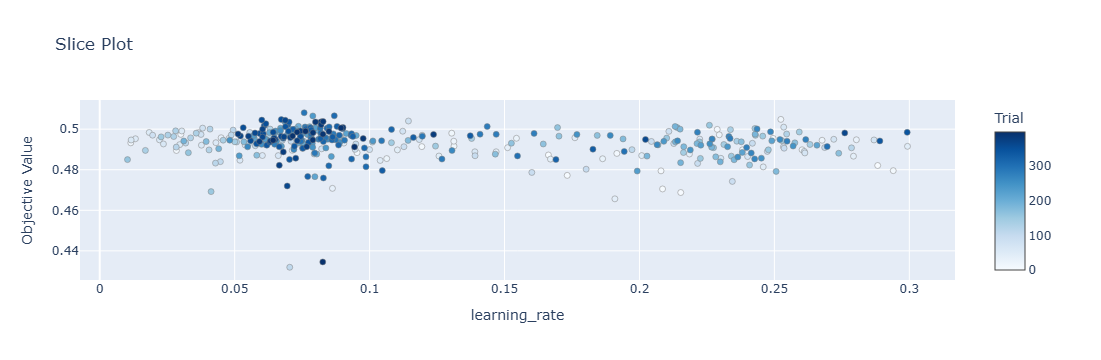

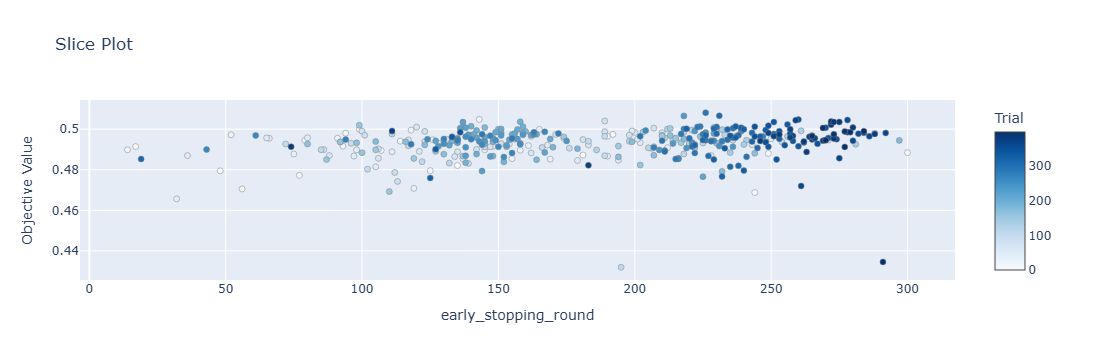

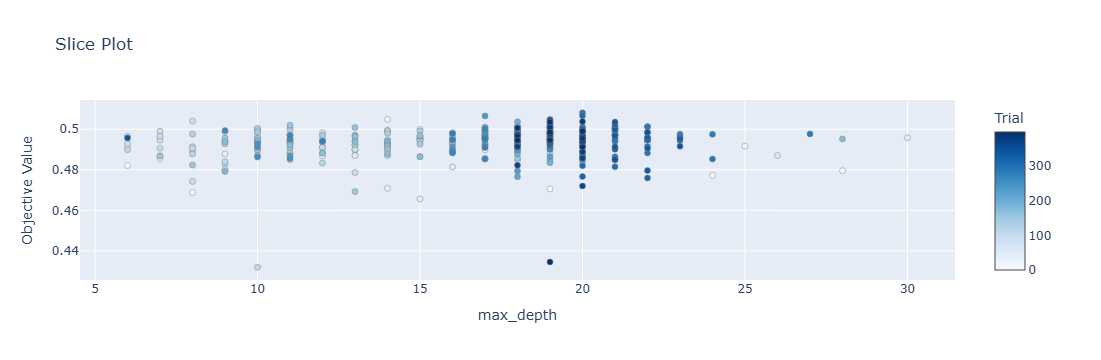

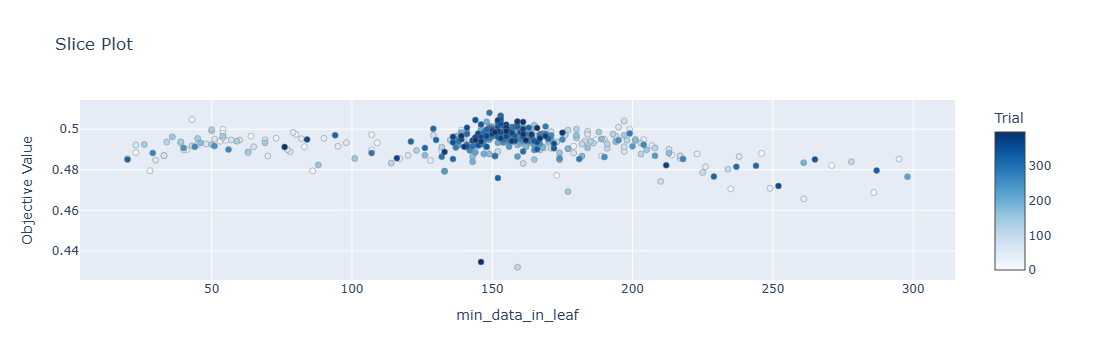

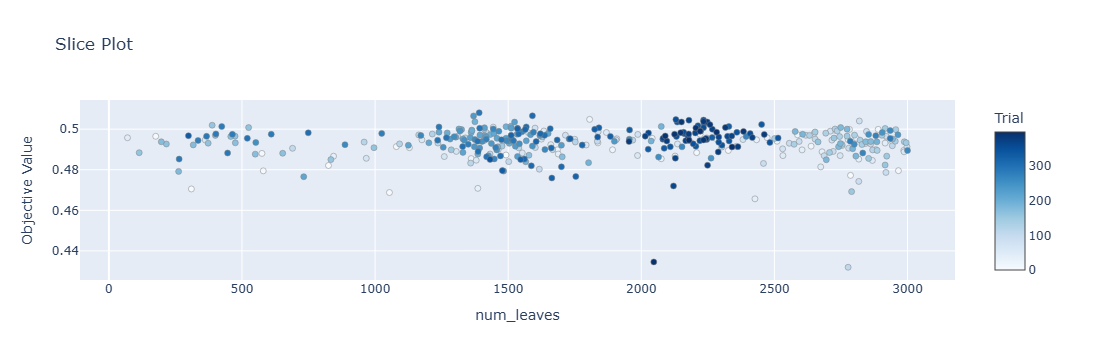

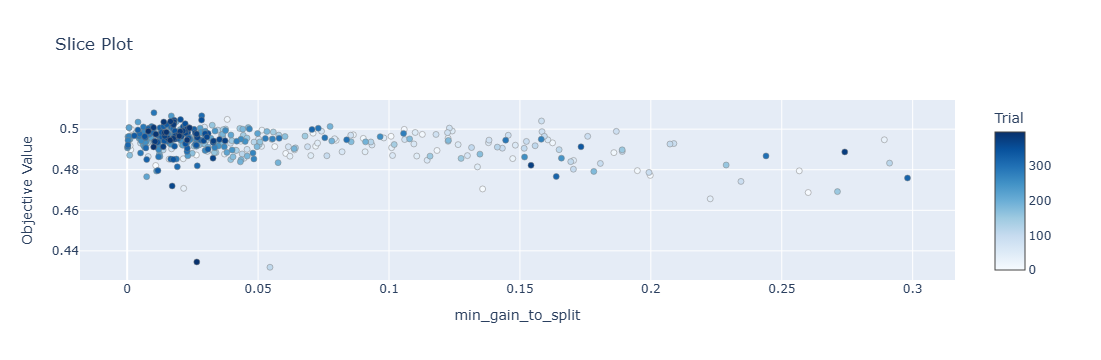

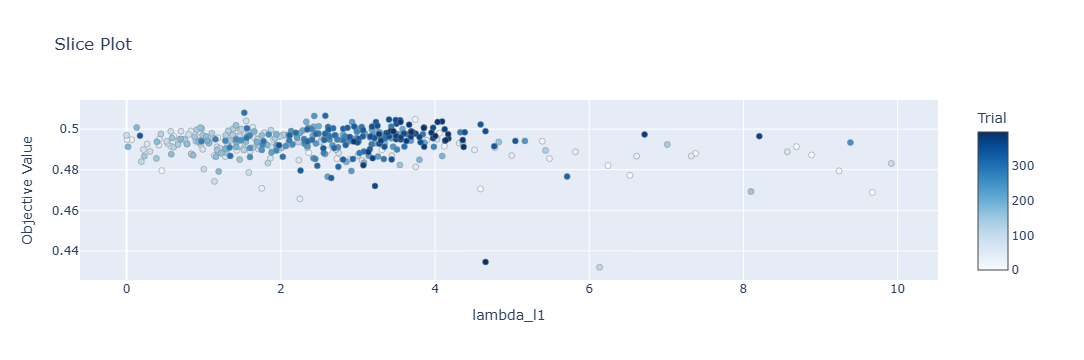

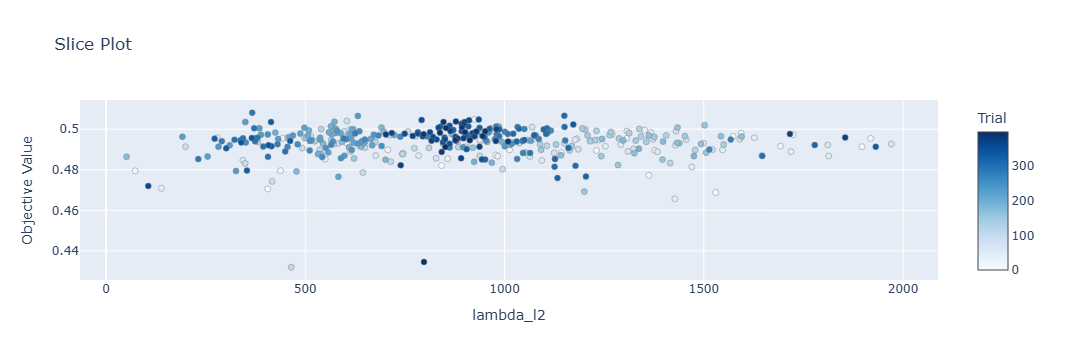

In [131]:
for param in lgb_optuna_study.best_params.keys():
    fig = plot_slice(lgb_optuna_study, params=[param])
    fig.show()

In [132]:
plot_param_importances(lgb_optuna_study)

In [133]:
lgb_optuna_study.best_params

{'learning_rate': 0.0757564557671527,
 'early_stopping_round': 226,
 'max_depth': 20,
 'min_data_in_leaf': 149,
 'num_leaves': 1391,
 'min_gain_to_split': 0.010221417473402997,
 'lambda_l1': 1.526244907849987,
 'lambda_l2': 366.76940406966696}

In [ ]:
cols = train_selected_df5.drop(['id', 'sii'], axis=1).columns
importance_list = []
for model in lgb_models_list5:
    importance_list.append(model.feature_importances_)

importance_mean = np.mean(importance_list, axis=0)
imp_df = pd.DataFrame(sorted(zip(cols, importance_mean)), columns=['Feature', 'Importance']).sort_values('Importance', ascending=False)
unimportant_df = imp_df[imp_df['Importance'] < imp_df['Importance'].quantile(0.5)]
unimportant_cols = unimportant_df['Feature'].tolist()

In [ ]:
# https://www.kaggle.com/code/ichigoe/lb0-494-with-tabnet
# Edited by Max (Jongyun Han)
def lgb_train(params, train_data, test_data):
    X = train_data.drop(['id', 'sii'], axis=1)
    y = train_data['sii']

    test_data_copy = test_data.copy()
    test_data = test_data.drop('id', axis=1)

    SKF = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=SEED)
    
    train_S = []
    test_S = []
    
    oof_non_rounded = np.zeros(len(y), dtype=float) 
    oof_rounded = np.zeros(len(y), dtype=int) 
    test_preds = np.zeros((len(test_data), n_splits))

    models_list = []

    #for fold, (train_idx, test_idx) in enumerate(tqdm(SKF.split(X, y), desc="Training Folds", total=n_splits)):
    for fold, (train_idx, test_idx) in enumerate(SKF.split(X, y)):
        X_train, X_val = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[test_idx]
        
        lgb_callbacks = [
            lgb.log_evaluation(period=20)
        ]

        model = LGBMRegressor(
            **params
        )
        
        model.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_val, y_val)])#, callbacks=lgb_callbacks)

        plt.figure()
        lgb.plot_metric(model)
        plt.show()
        
        y_train_pred = model.predict(X_train)
        y_val_pred = model.predict(X_val)

        oof_non_rounded[test_idx] = y_val_pred
        y_val_pred_rounded = y_val_pred.round(0).astype(int)
        oof_rounded[test_idx] = y_val_pred_rounded

        train_KappaOPtimizer = minimize(evaluate_predictions,
                                  x0=[0.5, 1.5, 2.5], args=(y_train, y_train_pred), 
                                  method='Nelder-Mead')
        assert train_KappaOPtimizer.success, "Train Optimization did not converge."

        train_pred_tuned = threshold_Rounder(y_train_pred, train_KappaOPtimizer.x)
        train_Kappa = quadratic_weighted_kappa(y_train, train_pred_tuned)

        print(f"----> || Train Optimized QWK SCORE :: {Fore.CYAN}{Style.BRIGHT} {train_Kappa:.3f}{Style.RESET_ALL}")

        val_KappaOPtimizer = minimize(evaluate_predictions,
                                  x0=[0.5, 1.5, 2.5], args=(y_val, y_val_pred), 
                                  method='Nelder-Mead')
        assert val_KappaOPtimizer.success, "Val Optimization did not converge."

        val_pred_tuned = threshold_Rounder(y_val_pred, val_KappaOPtimizer.x)
        val_Kappa = quadratic_weighted_kappa(y_val, val_pred_tuned)

        print(f"----> || Val Optimized QWK SCORE :: {Fore.CYAN}{Style.BRIGHT} {val_Kappa:.3f}{Style.RESET_ALL}")

        train_optimized_val_pred_tuned = threshold_Rounder(y_val_pred, train_KappaOPtimizer.x)
        train_optimized_val_Kappa = quadratic_weighted_kappa(y_val, train_optimized_val_pred_tuned)

        print(f"----> || Train Optimized Val QWK SCORE :: {Fore.CYAN}{Style.BRIGHT} {train_optimized_val_Kappa:.3f}{Style.RESET_ALL}")

        val_optimized_train_pred_tuned = threshold_Rounder(y_train_pred, val_KappaOPtimizer.x)
        val_optimized_train_Kappa = quadratic_weighted_kappa(y_train, val_optimized_train_pred_tuned)

        print(f"----> || Val Optimized Train QWK SCORE :: {Fore.CYAN}{Style.BRIGHT} {val_optimized_train_Kappa:.3f}{Style.RESET_ALL}")

        rounded_train_kappa = quadratic_weighted_kappa(y_train, y_train_pred.round(0).astype(int))
        rounded_val_kappa = quadratic_weighted_kappa(y_val, y_val_pred_rounded)        

        train_S.append(train_Kappa)
        test_S.append(val_Kappa)
        
        test_preds[:, fold] = model.predict(test_data)
        
        print(f"Fold {fold+1} - Rounded Train QWK: {rounded_train_kappa:.4f}, Rounded Validation QWK: {rounded_val_kappa:.4f}")
        #clear_output(wait=True)

        models_list.append(model)

    print(f"Mean Train QWK --> {np.mean(train_S):.4f}")
    print(f"Mean Validation QWK ---> {np.mean(test_S):.4f}")

    KappaOPtimizer = minimize(evaluate_predictions,
                              x0=[0.5, 1.5, 2.5], args=(y, oof_non_rounded), 
                              method='Nelder-Mead')
    assert KappaOPtimizer.success, "Optimization did not converge."
    
    oof_tuned = threshold_Rounder(oof_non_rounded, KappaOPtimizer.x)
    tKappa = quadratic_weighted_kappa(y, oof_tuned)

    print(f"----> || Optimized QWK SCORE :: {Fore.CYAN}{Style.BRIGHT} {tKappa:.3f}{Style.RESET_ALL}")

    tpm = test_preds.mean(axis=1)
    tpTuned = threshold_Rounder(tpm, KappaOPtimizer.x)
    
    submission = pd.DataFrame({
        'id': test_data_copy['id'],
        'sii': tpTuned
    })

    return models_list, submission, oof_non_rounded, tpm

In [ ]:
lgb_params = {
    'verbosity': -1,
    'seed': SEED,
    'learning_rate': 0.01,
    'num_iterations': 3000,
    'early_stopping_round': 10,
    'max_depth': 12,
    'min_data_in_leaf': 40,
    'num_leaves': 20,
    'min_gain_to_split': 0.05,
    'feature_fraction': 0.8,
    #'bagging_fraction': 0.784,
    #'bagging_freq': 4,
    'lambda_l1': 2,
    'lambda_l2': 50,
    'device': 'gpu'
}

lgb_models_list, lgb_submission_df, lgb_raw_train_preds, lgb_raw_test_preds = lgb_train(lgb_params, train_final_df, test_final_df)

In [ ]:
# https://www.kaggle.com/code/ichigoe/lb0-494-with-tabnet
# Edited by Max (Jongyun Han)
def catboost_feature_selection(train_data, test_data, optuna_n_trials=100):
    X = train_data.drop(['id', 'sii'], axis=1)
    y = train_data['sii']

    test_data_copy = test_data.copy()
    test_data = test_data.drop('id', axis=1)

    SKF = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=SEED)
    
    train_S = []
    test_S = []
    
    oof_non_rounded = np.zeros(len(y), dtype=float) 
    oof_rounded = np.zeros(len(y), dtype=int) 
    test_preds = np.zeros((len(test_data), n_splits))

    models_list = []

    base_params = {
        'iterations': 3000,
        'random_seed': SEED,
        'verbose': 0,
        'task_type': 'GPU',
        'use_best_model': True,
        'boosting_type': 'Plain'
    }

    def objective(trial):
        
        params_to_tune = {
            'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.03),
            'depth': trial.suggest_int('depth', 6, 9),
            'l2_leaf_reg': trial.suggest_int('l2_leaf_reg', 10, 70),
            'early_stopping_rounds': trial.suggest_int('early_stopping_rounds', 20, 40)
        }
    
        #for fold, (train_idx, test_idx) in enumerate(tqdm(SKF.split(X, y), desc="Training Folds", total=n_splits)):
        for fold, (train_idx, test_idx) in enumerate(SKF.split(X, y)):
            X_train, X_val = X.iloc[train_idx], X.iloc[test_idx]
            y_train, y_val = y.iloc[train_idx], y.iloc[test_idx]
    
            model = CatBoostRegressor(
                **base_params,
                **params_to_tune
            )
            
            model.fit(X_train, y_train, eval_set=(X_val, y_val))#, plot=True)
    
            y_train_pred = model.predict(X_train)
            y_val_pred = model.predict(X_val)
    
            oof_non_rounded[test_idx] = y_val_pred
            y_val_pred_rounded = y_val_pred.round(0).astype(int)
            oof_rounded[test_idx] = y_val_pred_rounded
    
            train_KappaOPtimizer = minimize(evaluate_predictions,
                                      x0=[0.5, 1.5, 2.5], args=(y_train, y_train_pred), 
                                      method='Nelder-Mead')
            assert train_KappaOPtimizer.success, "Train Optimization did not converge."
    
            train_pred_tuned = threshold_Rounder(y_train_pred, train_KappaOPtimizer.x)
            train_Kappa = quadratic_weighted_kappa(y_train, train_pred_tuned)
    
            #print(f"----> || Train Optimized QWK SCORE :: {Fore.CYAN}{Style.BRIGHT} {train_Kappa:.3f}{Style.RESET_ALL}")
    
            val_KappaOPtimizer = minimize(evaluate_predictions,
                                      x0=[0.5, 1.5, 2.5], args=(y_val, y_val_pred), 
                                      method='Nelder-Mead')
            assert val_KappaOPtimizer.success, "Val Optimization did not converge."
    
            val_pred_tuned = threshold_Rounder(y_val_pred, val_KappaOPtimizer.x)
            val_Kappa = quadratic_weighted_kappa(y_val, val_pred_tuned)
    
            #print(f"----> || Val Optimized QWK SCORE :: {Fore.CYAN}{Style.BRIGHT} {val_Kappa:.3f}{Style.RESET_ALL}")
    
            train_optimized_val_pred_tuned = threshold_Rounder(y_val_pred, train_KappaOPtimizer.x)
            train_optimized_val_Kappa = quadratic_weighted_kappa(y_val, train_optimized_val_pred_tuned)
    
            #print(f"----> || Train Optimized Val QWK SCORE :: {Fore.CYAN}{Style.BRIGHT} {train_optimized_val_Kappa:.3f}{Style.RESET_ALL}")
    
            val_optimized_train_pred_tuned = threshold_Rounder(y_train_pred, val_KappaOPtimizer.x)
            val_optimized_train_Kappa = quadratic_weighted_kappa(y_train, val_optimized_train_pred_tuned)
    
            #print(f"----> || Val Optimized Train QWK SCORE :: {Fore.CYAN}{Style.BRIGHT} {val_optimized_train_Kappa:.3f}{Style.RESET_ALL}")
    
            rounded_train_kappa = quadratic_weighted_kappa(y_train, y_train_pred.round(0).astype(int))
            rounded_val_kappa = quadratic_weighted_kappa(y_val, y_val_pred_rounded)        
    
            train_S.append(train_Kappa)
            test_S.append(val_Kappa)
            
            test_preds[:, fold] = model.predict(test_data)
            
            #print(f"Fold {fold+1} - Rounded Train QWK: {rounded_train_kappa:.4f}, Rounded Validation QWK: {rounded_val_kappa:.4f}")
            #clear_output(wait=True)
    
            models_list.append(model)
    
        #print(f"Mean Train QWK --> {np.mean(train_S):.4f}")
        #print(f"Mean Validation QWK ---> {np.mean(test_S):.4f}")
    
        KappaOPtimizer = minimize(evaluate_predictions,
                                  x0=[0.5, 1.5, 2.5], args=(y, oof_non_rounded), 
                                  method='Nelder-Mead')
        assert KappaOPtimizer.success, "Optimization did not converge."
        
        oof_tuned = threshold_Rounder(oof_non_rounded, KappaOPtimizer.x)
        tKappa = quadratic_weighted_kappa(y, oof_tuned)
    
        print(f"----> || Optimized QWK SCORE :: {Fore.CYAN}{Style.BRIGHT} {tKappa:.3f}{Style.RESET_ALL}")
    
        tpm = test_preds.mean(axis=1)
        tpTuned = threshold_Rounder(tpm, KappaOPtimizer.x)
        
        submission = pd.DataFrame({
            'id': test_data_copy['id'],
            'sii': tpTuned
        })
    
        return tKappa

    study = optuna.create_study(direction="maximize")
    study.optimize(objective, n_trials=optuna_n_trials)  # You can increase n_trials for better results

    return study

In [ ]:
catboost_optuna_study = catboost_feature_selection(train_final_df, test_final_df, 5)

In [ ]:
plot_optimization_history(catboost_optuna_study)

In [ ]:
plot_optimization_history(catboost_optuna_study)

In [ ]:
plot_parallel_coordinate(catboost_optuna_study)

In [ ]:
plot_slice(catboost_optuna_study)

In [ ]:
plot_param_importances(catboost_optuna_study)

In [ ]:
plot_rank(catboost_optuna_study)

In [ ]:
# https://www.kaggle.com/code/ichigoe/lb0-494-with-tabnet
# Edited by Max (Jongyun Han)
def catboost_train(train_data, test_data):
    X = train_data.drop(['id', 'sii'], axis=1)
    y = train_data['sii']

    test_data_copy = test_data.copy()
    test_data = test_data.drop('id', axis=1)

    SKF = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=SEED)
    
    train_S = []
    test_S = []
    
    oof_non_rounded = np.zeros(len(y), dtype=float) 
    oof_rounded = np.zeros(len(y), dtype=int) 
    test_preds = np.zeros((len(test_data), n_splits))

    models_list = []

    catboost_params = {
        'learning_rate': 0.02,
        'depth': 9,
        'iterations': 2000,
        'random_seed': SEED,
        'verbose': 0,
        'l2_leaf_reg': 15,
        'task_type': 'GPU',
        'use_best_model': True,
        'early_stopping_rounds': 30,
        'boosting_type': 'Ordered'
    }

    #for fold, (train_idx, test_idx) in enumerate(tqdm(SKF.split(X, y), desc="Training Folds", total=n_splits)):
    for fold, (train_idx, test_idx) in enumerate(SKF.split(X, y)):
        X_train, X_val = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[test_idx]

        model = CatBoostRegressor(
            **catboost_params
        )
        
        model.fit(X_train, y_train, eval_set=(X_val, y_val), plot=True)

        y_train_pred = model.predict(X_train)
        y_val_pred = model.predict(X_val)

        oof_non_rounded[test_idx] = y_val_pred
        y_val_pred_rounded = y_val_pred.round(0).astype(int)
        oof_rounded[test_idx] = y_val_pred_rounded

        train_KappaOPtimizer = minimize(evaluate_predictions,
                                  x0=[0.5, 1.5, 2.5], args=(y_train, y_train_pred), 
                                  method='Nelder-Mead')
        assert train_KappaOPtimizer.success, "Train Optimization did not converge."

        train_pred_tuned = threshold_Rounder(y_train_pred, train_KappaOPtimizer.x)
        train_Kappa = quadratic_weighted_kappa(y_train, train_pred_tuned)

        print(f"----> || Train Optimized QWK SCORE :: {Fore.CYAN}{Style.BRIGHT} {train_Kappa:.3f}{Style.RESET_ALL}")

        val_KappaOPtimizer = minimize(evaluate_predictions,
                                  x0=[0.5, 1.5, 2.5], args=(y_val, y_val_pred), 
                                  method='Nelder-Mead')
        assert val_KappaOPtimizer.success, "Val Optimization did not converge."

        val_pred_tuned = threshold_Rounder(y_val_pred, val_KappaOPtimizer.x)
        val_Kappa = quadratic_weighted_kappa(y_val, val_pred_tuned)

        print(f"----> || Val Optimized QWK SCORE :: {Fore.CYAN}{Style.BRIGHT} {val_Kappa:.3f}{Style.RESET_ALL}")

        train_optimized_val_pred_tuned = threshold_Rounder(y_val_pred, train_KappaOPtimizer.x)
        train_optimized_val_Kappa = quadratic_weighted_kappa(y_val, train_optimized_val_pred_tuned)

        print(f"----> || Train Optimized Val QWK SCORE :: {Fore.CYAN}{Style.BRIGHT} {train_optimized_val_Kappa:.3f}{Style.RESET_ALL}")

        val_optimized_train_pred_tuned = threshold_Rounder(y_train_pred, val_KappaOPtimizer.x)
        val_optimized_train_Kappa = quadratic_weighted_kappa(y_train, val_optimized_train_pred_tuned)

        print(f"----> || Val Optimized Train QWK SCORE :: {Fore.CYAN}{Style.BRIGHT} {val_optimized_train_Kappa:.3f}{Style.RESET_ALL}")

        rounded_train_kappa = quadratic_weighted_kappa(y_train, y_train_pred.round(0).astype(int))
        rounded_val_kappa = quadratic_weighted_kappa(y_val, y_val_pred_rounded)        

        train_S.append(train_Kappa)
        test_S.append(val_Kappa)
        
        test_preds[:, fold] = model.predict(test_data)
        
        print(f"Fold {fold+1} - Rounded Train QWK: {rounded_train_kappa:.4f}, Rounded Validation QWK: {rounded_val_kappa:.4f}")
        #clear_output(wait=True)

        models_list.append(model)

    print(f"Mean Train QWK --> {np.mean(train_S):.4f}")
    print(f"Mean Validation QWK ---> {np.mean(test_S):.4f}")

    KappaOPtimizer = minimize(evaluate_predictions,
                              x0=[0.5, 1.5, 2.5], args=(y, oof_non_rounded), 
                              method='Nelder-Mead')
    assert KappaOPtimizer.success, "Optimization did not converge."
    
    oof_tuned = threshold_Rounder(oof_non_rounded, KappaOPtimizer.x)
    tKappa = quadratic_weighted_kappa(y, oof_tuned)

    print(f"----> || Optimized QWK SCORE :: {Fore.CYAN}{Style.BRIGHT} {tKappa:.3f}{Style.RESET_ALL}")

    tpm = test_preds.mean(axis=1)
    tpTuned = threshold_Rounder(tpm, KappaOPtimizer.x)
    
    submission = pd.DataFrame({
        'id': test_data_copy['id'],
        'sii': tpTuned
    })

    return models_list, submission, oof_non_rounded, tpm

In [ ]:
cat_models_list, cat_submission_df, cat_raw_train_preds, cat_raw_test_preds = catboost_train(train_final_df, test_final_df)

In [ ]:
#submission_df.to_csv('submission.csv', index=False)